In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(881)

# Define the model that generates pair simulations.
yuima = importr("yuima")
n_ou_sim_string = """
n_sim_ou = function(random_seed, num_sim,
                    mu11, mu12, mu21, mu22, sigma11, sigma12, sigma21, sigma22,
                    xinit_vec, T0, T, length){

  set.seed(random_seed)

  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  ou_model = setModel(drift=drift, diffusion=diffusion, 
                        time.variable = "t",
                        state.var=c("X1","X2"), solve.variable=c("X1","X2"))

  newsamp = setSampling(Initial=T0, Terminal=T, n=length)

  n_sim_ou_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    ou_sim = simulate(ou_model, 
                      true.par=list(
                        mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                        sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22), 
                      xinit=xinit_vec[i], sampling=newsamp)
    original_data = ou_sim@data@original.data
    one_sim_ou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_ou) = c('series1', 'series2')
    n_sim_ou_data[, (2*i-1):(2*i)] = one_sim_ou
  }
  return(n_sim_ou_data)
}
"""

n_ou_sim = SignatureTranslatedAnonymousPackage(n_ou_sim_string, "n_ou_sim")
def n_ou_simulation(random_seed, num_sim,
                    mu11, mu12, mu21, mu22, sigma11, sigma12, sigma21, sigma22,
                    xinit_vec, T0, T, length):
    """num_sim simulations of bivariate Ornstein-Uhlenbeck process,
    length = length of one series
    """
    n_ou_sim_data = pd.DataFrame(
        n_ou_sim.n_sim_ou(random_seed=random_seed, num_sim=num_sim,
                              mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22,
                              sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                              xinit_vec=xinit_vec, T0=T0, T=T, length=length)).transpose()
    return n_ou_sim_data

def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef


def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series2.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) #6(14)
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(21)
    
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#6(27)
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, #8(8)
                               
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,#6(14)
                               
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
                               
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)
                               
                               corr_sqts1_lag_0,
                               corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
                               corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3])#7(34)
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3']
    
    return stats_data


def loss_function(params):

    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)


    n_sim_log_price = n_ou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3],
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)
    
    sum_loss[6] = sum_loss[6]/10 
    sum_loss[7] = sum_loss[7]/10 
    
    loss = np.sum(sum_loss)
    
    print(sum_loss)
    print(loss)
    print('----------')

    return loss



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats



initial0 = [1, 1, 1, 1, -1, -1, -1, -1]
begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(0, None), (None, None), (0, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

[1]  1  1  1  1 -1 -1 -1 -1

return_mean1                         243.651496
return_mean2                         231.659172
return_sd1                           419.192477
return_sd2                           403.096192
return_skew1                         160.584770
return_skew2                         218.456515
return_kurtosis1                     126.753207
return_kurtosis2                     179.946194
return_autocorrelation_ts1_lag1       17.570546
return_autocorrelation_ts1_lag2       19.075338
return_autocorrelation_ts1_lag3       19.030071
return_autocorrelation_ts2_lag1       19.462909
return_autocorrelation_ts2_lag2       19.947684
return_autocorrelation_ts2_lag3       18.720702
return_correlation_ts1_lag_0         168.048207
return_correlation_ts1_lag_1          18.914405
return_correlation_ts1_lag_2          19.154723
return_correlation_ts1_lag_3          18.363552
return_correlation_ts2_lag_1          19.109346
return_correlation_ts2_lag_2          19.190977
return_corr

return_mean1                          84.107556
return_mean2                         233.035988
return_sd1                           434.454017
return_sd2                           403.834372
return_skew1                         166.965350
return_skew2                         221.712018
return_kurtosis1                     127.304299
return_kurtosis2                     180.273059
return_autocorrelation_ts1_lag1       21.803275
return_autocorrelation_ts1_lag2       25.373736
return_autocorrelation_ts1_lag3       17.877015
return_autocorrelation_ts2_lag1       16.818829
return_autocorrelation_ts2_lag2       20.038806
return_autocorrelation_ts2_lag3       17.688584
return_correlation_ts1_lag_0         166.761277
return_correlation_ts1_lag_1          18.573554
return_correlation_ts1_lag_2          21.135242
return_correlation_ts1_lag_3          18.231690
return_correlation_ts2_lag_1          18.955331
return_correlation_ts2_lag_2          19.833774
return_correlation_ts2_lag_3          16

return_mean1                          54.664507
return_mean2                         235.271122
return_sd1                           442.284503
return_sd2                           405.209443
return_skew1                         162.342179
return_skew2                         217.315449
return_kurtosis1                     127.572678
return_kurtosis2                     180.833415
return_autocorrelation_ts1_lag1       22.600932
return_autocorrelation_ts1_lag2       25.918964
return_autocorrelation_ts1_lag3       19.057841
return_autocorrelation_ts2_lag1       17.344265
return_autocorrelation_ts2_lag2       19.551026
return_autocorrelation_ts2_lag3       16.873441
return_correlation_ts1_lag_0         165.547133
return_correlation_ts1_lag_1          18.354023
return_correlation_ts1_lag_2          20.169430
return_correlation_ts1_lag_3          18.651574
return_correlation_ts2_lag_1          18.582297
return_correlation_ts2_lag_2          19.753850
return_correlation_ts2_lag_3          18

return_mean1                          52.730543
return_mean2                         230.965523
return_sd1                           442.613029
return_sd2                           404.983143
return_skew1                         168.335084
return_skew2                         222.246351
return_kurtosis1                     127.844602
return_kurtosis2                     181.132679
return_autocorrelation_ts1_lag1       23.621063
return_autocorrelation_ts1_lag2       24.933790
return_autocorrelation_ts1_lag3       19.642817
return_autocorrelation_ts2_lag1       18.562226
return_autocorrelation_ts2_lag2       18.320637
return_autocorrelation_ts2_lag3       17.546303
return_correlation_ts1_lag_0         165.774397
return_correlation_ts1_lag_1          19.939574
return_correlation_ts1_lag_2          17.897603
return_correlation_ts1_lag_3          18.430578
return_correlation_ts2_lag_1          20.058492
return_correlation_ts2_lag_2          19.441617
return_correlation_ts2_lag_3          17

return_mean1                          54.471205
return_mean2                         237.050889
return_sd1                           438.857720
return_sd2                           402.429354
return_skew1                         167.958375
return_skew2                         222.054637
return_kurtosis1                     128.187293
return_kurtosis2                     181.457421
return_autocorrelation_ts1_lag1       23.631730
return_autocorrelation_ts1_lag2       24.965427
return_autocorrelation_ts1_lag3       19.412321
return_autocorrelation_ts2_lag1       18.569822
return_autocorrelation_ts2_lag2       19.114397
return_autocorrelation_ts2_lag3       19.406942
return_correlation_ts1_lag_0         165.745774
return_correlation_ts1_lag_1          18.547729
return_correlation_ts1_lag_2          20.087852
return_correlation_ts1_lag_3          19.730423
return_correlation_ts2_lag_1          20.857105
return_correlation_ts2_lag_2          19.922251
return_correlation_ts2_lag_3          18

return_mean1                          52.866804
return_mean2                         233.358337
return_sd1                           438.398647
return_sd2                           402.055606
return_skew1                         169.527851
return_skew2                         223.432468
return_kurtosis1                     126.735649
return_kurtosis2                     179.717634
return_autocorrelation_ts1_lag1       22.229154
return_autocorrelation_ts1_lag2       23.752556
return_autocorrelation_ts1_lag3       19.641828
return_autocorrelation_ts2_lag1       16.435996
return_autocorrelation_ts2_lag2       17.910536
return_autocorrelation_ts2_lag3       18.981514
return_correlation_ts1_lag_0         165.742056
return_correlation_ts1_lag_1          17.289445
return_correlation_ts1_lag_2          16.993719
return_correlation_ts1_lag_3          19.174208
return_correlation_ts2_lag_1          18.650751
return_correlation_ts2_lag_2          18.634537
return_correlation_ts2_lag_3          17

return_mean1                         176.471344
return_mean2                         232.229508
return_sd1                           466.520828
return_sd2                           402.292397
return_skew1                         160.856686
return_skew2                         219.939544
return_kurtosis1                     127.296578
return_kurtosis2                     180.275971
return_autocorrelation_ts1_lag1       34.047247
return_autocorrelation_ts1_lag2       34.800733
return_autocorrelation_ts1_lag3       26.292387
return_autocorrelation_ts2_lag1       18.445146
return_autocorrelation_ts2_lag2       16.936803
return_autocorrelation_ts2_lag3       18.067452
return_correlation_ts1_lag_0         161.191713
return_correlation_ts1_lag_1          20.557955
return_correlation_ts1_lag_2          18.748067
return_correlation_ts1_lag_3          19.407874
return_correlation_ts2_lag_1          19.461183
return_correlation_ts2_lag_2          19.331789
return_correlation_ts2_lag_3          17

return_mean1                          52.567097
return_mean2                         232.076888
return_sd1                           442.604415
return_sd2                           405.499109
return_skew1                         166.962345
return_skew2                         219.127083
return_kurtosis1                     127.335770
return_kurtosis2                     180.148817
return_autocorrelation_ts1_lag1       24.185776
return_autocorrelation_ts1_lag2       25.868437
return_autocorrelation_ts1_lag3       19.783268
return_autocorrelation_ts2_lag1       19.074039
return_autocorrelation_ts2_lag2       17.910300
return_autocorrelation_ts2_lag3       18.239428
return_correlation_ts1_lag_0         165.800100
return_correlation_ts1_lag_1          19.785547
return_correlation_ts1_lag_2          17.828125
return_correlation_ts1_lag_3          19.332145
return_correlation_ts2_lag_1          19.712096
return_correlation_ts2_lag_2          20.772814
return_correlation_ts2_lag_3          18

return_mean1                          56.120532
return_mean2                         229.707444
return_sd1                           439.096756
return_sd2                           404.797808
return_skew1                         164.457005
return_skew2                         221.656046
return_kurtosis1                     127.683872
return_kurtosis2                     180.926860
return_autocorrelation_ts1_lag1       22.694977
return_autocorrelation_ts1_lag2       24.782241
return_autocorrelation_ts1_lag3       19.586026
return_autocorrelation_ts2_lag1       18.912478
return_autocorrelation_ts2_lag2       18.029629
return_autocorrelation_ts2_lag3       16.990716
return_correlation_ts1_lag_0         165.707244
return_correlation_ts1_lag_1          18.857816
return_correlation_ts1_lag_2          18.635680
return_correlation_ts1_lag_3          17.300009
return_correlation_ts2_lag_1          19.421071
return_correlation_ts2_lag_2          20.008908
return_correlation_ts2_lag_3          17

return_mean1                          52.637578
return_mean2                         232.999955
return_sd1                           441.171082
return_sd2                           405.214397
return_skew1                         162.578876
return_skew2                         217.802833
return_kurtosis1                     127.075016
return_kurtosis2                     180.262805
return_autocorrelation_ts1_lag1       22.800251
return_autocorrelation_ts1_lag2       24.666735
return_autocorrelation_ts1_lag3       19.220944
return_autocorrelation_ts2_lag1       18.302749
return_autocorrelation_ts2_lag2       18.630171
return_autocorrelation_ts2_lag3       17.616776
return_correlation_ts1_lag_0         165.714313
return_correlation_ts1_lag_1          17.304180
return_correlation_ts1_lag_2          19.448107
return_correlation_ts1_lag_3          19.671317
return_correlation_ts2_lag_1          20.805503
return_correlation_ts2_lag_2          19.344827
return_correlation_ts2_lag_3          17

return_mean1                          53.841496
return_mean2                         132.314301
return_sd1                           437.617059
return_sd2                           407.499164
return_skew1                         162.292272
return_skew2                         218.759426
return_kurtosis1                     128.232873
return_kurtosis2                     181.400066
return_autocorrelation_ts1_lag1       24.463815
return_autocorrelation_ts1_lag2       24.673703
return_autocorrelation_ts1_lag3       19.814820
return_autocorrelation_ts2_lag1       20.058734
return_autocorrelation_ts2_lag2       18.973106
return_autocorrelation_ts2_lag3       19.538772
return_correlation_ts1_lag_0         167.298302
return_correlation_ts1_lag_1          20.475452
return_correlation_ts1_lag_2          18.853568
return_correlation_ts1_lag_3          19.981026
return_correlation_ts2_lag_1          21.625901
return_correlation_ts2_lag_2          19.348232
return_correlation_ts2_lag_3          18

return_mean1                          55.769083
return_mean2                          73.495708
return_sd1                           439.262880
return_sd2                           418.006008
return_skew1                         165.409662
return_skew2                         219.881339
return_kurtosis1                     127.055351
return_kurtosis2                     180.438691
return_autocorrelation_ts1_lag1       22.603623
return_autocorrelation_ts1_lag2       25.141933
return_autocorrelation_ts1_lag3       21.310524
return_autocorrelation_ts2_lag1       20.254582
return_autocorrelation_ts2_lag2       21.939493
return_autocorrelation_ts2_lag3       20.584883
return_correlation_ts1_lag_0         167.900328
return_correlation_ts1_lag_1          20.298862
return_correlation_ts1_lag_2          20.643130
return_correlation_ts1_lag_3          20.745084
return_correlation_ts2_lag_1          20.585611
return_correlation_ts2_lag_2          22.484463
return_correlation_ts2_lag_3          20

return_mean1                          56.205471
return_mean2                          78.897139
return_sd1                           436.940980
return_sd2                           413.180330
return_skew1                         164.757013
return_skew2                         217.975138
return_kurtosis1                     127.706724
return_kurtosis2                     180.941948
return_autocorrelation_ts1_lag1       22.850074
return_autocorrelation_ts1_lag2       24.340310
return_autocorrelation_ts1_lag3       19.617400
return_autocorrelation_ts2_lag1       20.615816
return_autocorrelation_ts2_lag2       19.383233
return_autocorrelation_ts2_lag3       19.955758
return_correlation_ts1_lag_0         167.873684
return_correlation_ts1_lag_1          20.872375
return_correlation_ts1_lag_2          19.984979
return_correlation_ts1_lag_3          19.855235
return_correlation_ts2_lag_1          22.475751
return_correlation_ts2_lag_2          20.615239
return_correlation_ts2_lag_3          20

return_mean1                          55.062899
return_mean2                          78.216402
return_sd1                           443.047246
return_sd2                           418.440648
return_skew1                         167.712831
return_skew2                         220.382896
return_kurtosis1                     127.974283
return_kurtosis2                     181.206077
return_autocorrelation_ts1_lag1       24.005099
return_autocorrelation_ts1_lag2       25.345172
return_autocorrelation_ts1_lag3       20.643836
return_autocorrelation_ts2_lag1       22.538646
return_autocorrelation_ts2_lag2       21.371092
return_autocorrelation_ts2_lag3       20.922689
return_correlation_ts1_lag_0         167.877833
return_correlation_ts1_lag_1          20.542417
return_correlation_ts1_lag_2          20.995929
return_correlation_ts1_lag_3          20.775223
return_correlation_ts2_lag_1          22.105780
return_correlation_ts2_lag_2          22.262792
return_correlation_ts2_lag_3          20

return_mean1                          55.211189
return_mean2                          76.119848
return_sd1                           442.310806
return_sd2                           417.857370
return_skew1                         165.966817
return_skew2                         222.211509
return_kurtosis1                     127.956207
return_kurtosis2                     181.326231
return_autocorrelation_ts1_lag1       23.589777
return_autocorrelation_ts1_lag2       25.936647
return_autocorrelation_ts1_lag3       18.578290
return_autocorrelation_ts2_lag1       21.488003
return_autocorrelation_ts2_lag2       22.046603
return_autocorrelation_ts2_lag3       19.678492
return_correlation_ts1_lag_0         167.874571
return_correlation_ts1_lag_1          20.721307
return_correlation_ts1_lag_2          21.290381
return_correlation_ts1_lag_3          18.362996
return_correlation_ts2_lag_1          21.771478
return_correlation_ts2_lag_2          22.271826
return_correlation_ts2_lag_3          18

return_mean1                          53.439250
return_mean2                          76.530463
return_sd1                           438.989555
return_sd2                           415.457828
return_skew1                         166.162813
return_skew2                         219.438201
return_kurtosis1                     127.250099
return_kurtosis2                     180.582884
return_autocorrelation_ts1_lag1       22.741680
return_autocorrelation_ts1_lag2       25.221872
return_autocorrelation_ts1_lag3       20.643396
return_autocorrelation_ts2_lag1       20.333271
return_autocorrelation_ts2_lag2       21.892837
return_autocorrelation_ts2_lag3       20.418325
return_correlation_ts1_lag_0         167.871933
return_correlation_ts1_lag_1          20.814633
return_correlation_ts1_lag_2          22.449587
return_correlation_ts1_lag_3          19.955640
return_correlation_ts2_lag_1          21.309664
return_correlation_ts2_lag_2          22.874258
return_correlation_ts2_lag_3          20

return_mean1                          57.711100
return_mean2                          79.125163
return_sd1                           436.683094
return_sd2                           414.240558
return_skew1                         163.329357
return_skew2                         219.983616
return_kurtosis1                     126.958320
return_kurtosis2                     180.307766
return_autocorrelation_ts1_lag1       23.404184
return_autocorrelation_ts1_lag2       24.427191
return_autocorrelation_ts1_lag3       20.167819
return_autocorrelation_ts2_lag1       21.441802
return_autocorrelation_ts2_lag2       21.327335
return_autocorrelation_ts2_lag3       20.601707
return_correlation_ts1_lag_0         167.869019
return_correlation_ts1_lag_1          21.183590
return_correlation_ts1_lag_2          20.366646
return_correlation_ts1_lag_3          21.975857
return_correlation_ts2_lag_1          21.208286
return_correlation_ts2_lag_2          21.653106
return_correlation_ts2_lag_3          20

return_mean1                          52.152048
return_mean2                          55.338878
return_sd1                           436.709156
return_sd2                           412.182096
return_skew1                         164.595725
return_skew2                         217.809284
return_kurtosis1                     127.371896
return_kurtosis2                     180.440284
return_autocorrelation_ts1_lag1       24.177241
return_autocorrelation_ts1_lag2       25.826506
return_autocorrelation_ts1_lag3       20.338345
return_autocorrelation_ts2_lag1       21.672151
return_autocorrelation_ts2_lag2       21.852395
return_autocorrelation_ts2_lag3       19.772837
return_correlation_ts1_lag_0         167.732578
return_correlation_ts1_lag_1          21.488013
return_correlation_ts1_lag_2          21.687929
return_correlation_ts1_lag_3          20.366724
return_correlation_ts2_lag_1          21.195133
return_correlation_ts2_lag_2          21.985209
return_correlation_ts2_lag_3          18

return_mean1                          53.266615
return_mean2                          47.627803
return_sd1                           439.165021
return_sd2                           411.887398
return_skew1                         164.024926
return_skew2                         217.054396
return_kurtosis1                     127.727094
return_kurtosis2                     180.908998
return_autocorrelation_ts1_lag1       24.130796
return_autocorrelation_ts1_lag2       24.778173
return_autocorrelation_ts1_lag3       20.476445
return_autocorrelation_ts2_lag1       20.202157
return_autocorrelation_ts2_lag2       20.062675
return_autocorrelation_ts2_lag3       19.643213
return_correlation_ts1_lag_0         167.648198
return_correlation_ts1_lag_1          21.039757
return_correlation_ts1_lag_2          19.685133
return_correlation_ts1_lag_3          20.030080
return_correlation_ts2_lag_1          22.178188
return_correlation_ts2_lag_2          21.779646
return_correlation_ts2_lag_3          19

return_mean1                          58.567491
return_mean2                          50.990327
return_sd1                           436.979230
return_sd2                           410.968435
return_skew1                         162.410763
return_skew2                         220.716561
return_kurtosis1                     126.876872
return_kurtosis2                     180.070813
return_autocorrelation_ts1_lag1       22.509448
return_autocorrelation_ts1_lag2       25.042258
return_autocorrelation_ts1_lag3       18.727240
return_autocorrelation_ts2_lag1       19.413686
return_autocorrelation_ts2_lag2       21.837739
return_autocorrelation_ts2_lag3       19.966885
return_correlation_ts1_lag_0         167.646798
return_correlation_ts1_lag_1          19.798560
return_correlation_ts1_lag_2          20.222902
return_correlation_ts1_lag_3          19.321069
return_correlation_ts2_lag_1          21.598825
return_correlation_ts2_lag_2          22.142663
return_correlation_ts2_lag_3          19

return_mean1                          51.800260
return_mean2                          50.374856
return_sd1                           441.304948
return_sd2                           414.498831
return_skew1                         163.819365
return_skew2                         221.002744
return_kurtosis1                     127.220470
return_kurtosis2                     180.260124
return_autocorrelation_ts1_lag1       22.725545
return_autocorrelation_ts1_lag2       24.643970
return_autocorrelation_ts1_lag3       19.513522
return_autocorrelation_ts2_lag1       21.003258
return_autocorrelation_ts2_lag2       20.177378
return_autocorrelation_ts2_lag3       20.731271
return_correlation_ts1_lag_0         167.651527
return_correlation_ts1_lag_1          19.883019
return_correlation_ts1_lag_2          20.069486
return_correlation_ts1_lag_3          21.144125
return_correlation_ts2_lag_1          20.779597
return_correlation_ts2_lag_2          21.004505
return_correlation_ts2_lag_3          19

return_mean1                          51.240634
return_mean2                          52.827316
return_sd1                           250.250193
return_sd2                           415.014545
return_skew1                         160.714243
return_skew2                         219.871475
return_kurtosis1                     127.911689
return_kurtosis2                     181.344221
return_autocorrelation_ts1_lag1       30.618470
return_autocorrelation_ts1_lag2       33.601862
return_autocorrelation_ts1_lag3       26.456184
return_autocorrelation_ts2_lag1       21.193477
return_autocorrelation_ts2_lag2       20.625094
return_autocorrelation_ts2_lag3       20.732615
return_correlation_ts1_lag_0         141.568413
return_correlation_ts1_lag_1          21.623702
return_correlation_ts1_lag_2          23.318762
return_correlation_ts1_lag_3          21.521501
return_correlation_ts2_lag_1          22.590831
return_correlation_ts2_lag_2          24.351641
return_correlation_ts2_lag_3          20

return_mean1                          51.464824
return_mean2                          49.701140
return_sd1                           221.903124
return_sd2                           413.232111
return_skew1                         166.761122
return_skew2                         221.410078
return_kurtosis1                     127.856180
return_kurtosis2                     180.951763
return_autocorrelation_ts1_lag1       34.927153
return_autocorrelation_ts1_lag2       35.878651
return_autocorrelation_ts1_lag3       26.627740
return_autocorrelation_ts2_lag1       19.423551
return_autocorrelation_ts2_lag2       20.987402
return_autocorrelation_ts2_lag3       19.703246
return_correlation_ts1_lag_0          98.100109
return_correlation_ts1_lag_1          23.687830
return_correlation_ts1_lag_2          24.065080
return_correlation_ts1_lag_3          21.145682
return_correlation_ts2_lag_1          22.735938
return_correlation_ts2_lag_2          25.810111
return_correlation_ts2_lag_3          20

return_mean1                          49.296544
return_mean2                          52.208076
return_sd1                           220.185652
return_sd2                           415.033578
return_skew1                         161.461795
return_skew2                         220.001985
return_kurtosis1                     128.070271
return_kurtosis2                     180.234013
return_autocorrelation_ts1_lag1       32.314394
return_autocorrelation_ts1_lag2       34.899395
return_autocorrelation_ts1_lag3       26.875509
return_autocorrelation_ts2_lag1       19.160482
return_autocorrelation_ts2_lag2       21.329511
return_autocorrelation_ts2_lag3       19.489729
return_correlation_ts1_lag_0          98.934976
return_correlation_ts1_lag_1          22.160331
return_correlation_ts1_lag_2          22.601042
return_correlation_ts1_lag_3          22.319784
return_correlation_ts2_lag_1          22.799871
return_correlation_ts2_lag_2          25.441635
return_correlation_ts2_lag_3          20

return_mean1                          52.846442
return_mean2                          48.014468
return_sd1                           222.404276
return_sd2                           410.780953
return_skew1                         162.380297
return_skew2                         220.435590
return_kurtosis1                     127.463297
return_kurtosis2                     180.316832
return_autocorrelation_ts1_lag1       32.898500
return_autocorrelation_ts1_lag2       36.393028
return_autocorrelation_ts1_lag3       27.214161
return_autocorrelation_ts2_lag1       21.371095
return_autocorrelation_ts2_lag2       20.491157
return_autocorrelation_ts2_lag3       20.180041
return_correlation_ts1_lag_0          99.031822
return_correlation_ts1_lag_1          22.224124
return_correlation_ts1_lag_2          22.331544
return_correlation_ts1_lag_3          22.855475
return_correlation_ts2_lag_1          22.884188
return_correlation_ts2_lag_2          24.715762
return_correlation_ts2_lag_3          20

return_mean1                          51.272847
return_mean2                          50.204256
return_sd1                           221.552518
return_sd2                           415.434469
return_skew1                         166.005676
return_skew2                         220.648264
return_kurtosis1                     127.649135
return_kurtosis2                     180.264570
return_autocorrelation_ts1_lag1       32.565465
return_autocorrelation_ts1_lag2       36.071537
return_autocorrelation_ts1_lag3       27.340303
return_autocorrelation_ts2_lag1       20.081191
return_autocorrelation_ts2_lag2       21.307401
return_autocorrelation_ts2_lag3       19.433913
return_correlation_ts1_lag_0         100.243443
return_correlation_ts1_lag_1          22.634384
return_correlation_ts1_lag_2          23.338478
return_correlation_ts1_lag_3          21.049480
return_correlation_ts2_lag_1          22.865528
return_correlation_ts2_lag_2          25.213098
return_correlation_ts2_lag_3          21

return_mean1                          53.797717
return_mean2                          51.204149
return_sd1                           225.274140
return_sd2                           416.193347
return_skew1                         165.085715
return_skew2                         217.310955
return_kurtosis1                     127.625709
return_kurtosis2                     180.428326
return_autocorrelation_ts1_lag1       31.579159
return_autocorrelation_ts1_lag2       35.139093
return_autocorrelation_ts1_lag3       25.247111
return_autocorrelation_ts2_lag1       19.282898
return_autocorrelation_ts2_lag2       19.342824
return_autocorrelation_ts2_lag3       20.091300
return_correlation_ts1_lag_0          99.110371
return_correlation_ts1_lag_1          20.794781
return_correlation_ts1_lag_2          21.860082
return_correlation_ts1_lag_3          20.264776
return_correlation_ts2_lag_1          22.404325
return_correlation_ts2_lag_2          23.815719
return_correlation_ts2_lag_3          20

return_mean1                          52.573708
return_mean2                          48.859301
return_sd1                           468.158869
return_sd2                           411.686572
return_skew1                         164.138236
return_skew2                         219.621326
return_kurtosis1                     127.390634
return_kurtosis2                     180.419588
return_autocorrelation_ts1_lag1       21.602983
return_autocorrelation_ts1_lag2       24.428719
return_autocorrelation_ts1_lag3       19.944743
return_autocorrelation_ts2_lag1       21.236483
return_autocorrelation_ts2_lag2       20.855498
return_autocorrelation_ts2_lag3       20.376673
return_correlation_ts1_lag_0         100.441443
return_correlation_ts1_lag_1          20.555555
return_correlation_ts1_lag_2          19.879043
return_correlation_ts1_lag_3          19.216203
return_correlation_ts2_lag_1          22.368271
return_correlation_ts2_lag_2          22.397464
return_correlation_ts2_lag_3          18

return_mean1                          51.930411
return_mean2                          53.905863
return_sd1                           142.250498
return_sd2                           415.602038
return_skew1                         161.874359
return_skew2                         217.425527
return_kurtosis1                     128.156230
return_kurtosis2                     180.233870
return_autocorrelation_ts1_lag1       44.198207
return_autocorrelation_ts1_lag2       47.030774
return_autocorrelation_ts1_lag3       37.010888
return_autocorrelation_ts2_lag1       22.140715
return_autocorrelation_ts2_lag2       20.198245
return_autocorrelation_ts2_lag3       20.007135
return_correlation_ts1_lag_0          97.819319
return_correlation_ts1_lag_1          25.527200
return_correlation_ts1_lag_2          24.794925
return_correlation_ts1_lag_3          22.960126
return_correlation_ts2_lag_1          26.113307
return_correlation_ts2_lag_2          26.380582
return_correlation_ts2_lag_3          21

return_mean1                          51.032371
return_mean2                          49.206524
return_sd1                           136.856217
return_sd2                           413.337862
return_skew1                         165.547059
return_skew2                         225.227722
return_kurtosis1                     128.758055
return_kurtosis2                     181.533081
return_autocorrelation_ts1_lag1       45.143930
return_autocorrelation_ts1_lag2       46.188322
return_autocorrelation_ts1_lag3       36.161830
return_autocorrelation_ts2_lag1       19.426637
return_autocorrelation_ts2_lag2       19.597418
return_autocorrelation_ts2_lag3       20.857321
return_correlation_ts1_lag_0          97.005310
return_correlation_ts1_lag_1          24.412563
return_correlation_ts1_lag_2          23.666645
return_correlation_ts1_lag_3          23.602206
return_correlation_ts2_lag_1          24.132815
return_correlation_ts2_lag_2          26.740875
return_correlation_ts2_lag_3          22

return_mean1                          50.024381
return_mean2                          48.882199
return_sd1                           140.566485
return_sd2                           412.792949
return_skew1                         160.069453
return_skew2                         219.916527
return_kurtosis1                     127.237592
return_kurtosis2                     180.899770
return_autocorrelation_ts1_lag1       43.636802
return_autocorrelation_ts1_lag2       48.082294
return_autocorrelation_ts1_lag3       37.323661
return_autocorrelation_ts2_lag1       20.453578
return_autocorrelation_ts2_lag2       21.585176
return_autocorrelation_ts2_lag3       19.336159
return_correlation_ts1_lag_0          97.536562
return_correlation_ts1_lag_1          23.227348
return_correlation_ts1_lag_2          25.487574
return_correlation_ts1_lag_3          24.271968
return_correlation_ts2_lag_1          25.621417
return_correlation_ts2_lag_2          26.627067
return_correlation_ts2_lag_3          22

return_mean1                          50.159445
return_mean2                          45.862812
return_sd1                           137.222369
return_sd2                           207.297157
return_skew1                         164.263076
return_skew2                         219.436102
return_kurtosis1                     128.742508
return_kurtosis2                     180.993393
return_autocorrelation_ts1_lag1       44.860025
return_autocorrelation_ts1_lag2       47.897131
return_autocorrelation_ts1_lag3       36.146434
return_autocorrelation_ts2_lag1       25.171355
return_autocorrelation_ts2_lag2       24.990189
return_autocorrelation_ts2_lag3       21.475433
return_correlation_ts1_lag_0         160.828223
return_correlation_ts1_lag_1          29.297633
return_correlation_ts1_lag_2          30.437299
return_correlation_ts1_lag_3          26.751585
return_correlation_ts2_lag_1          30.242538
return_correlation_ts2_lag_2          31.702482
return_correlation_ts2_lag_3          25

return_mean1                          50.564661
return_mean2                          50.929825
return_sd1                           141.597747
return_sd2                           248.055519
return_skew1                         164.302513
return_skew2                         218.965101
return_kurtosis1                     127.882697
return_kurtosis2                     180.777448
return_autocorrelation_ts1_lag1       43.757684
return_autocorrelation_ts1_lag2       48.149253
return_autocorrelation_ts1_lag3       37.097274
return_autocorrelation_ts2_lag1       22.920981
return_autocorrelation_ts2_lag2       23.952907
return_autocorrelation_ts2_lag3       22.201553
return_correlation_ts1_lag_0         144.668142
return_correlation_ts1_lag_1          27.386920
return_correlation_ts1_lag_2          28.891312
return_correlation_ts1_lag_3          26.162266
return_correlation_ts2_lag_1          28.512831
return_correlation_ts2_lag_2          30.246675
return_correlation_ts2_lag_3          25

return_mean1                          47.518667
return_mean2                          48.160194
return_sd1                           138.289647
return_sd2                           239.826255
return_skew1                         163.848994
return_skew2                         221.848644
return_kurtosis1                     127.741505
return_kurtosis2                     180.847407
return_autocorrelation_ts1_lag1       45.864599
return_autocorrelation_ts1_lag2       48.955097
return_autocorrelation_ts1_lag3       38.660069
return_autocorrelation_ts2_lag1       24.187986
return_autocorrelation_ts2_lag2       24.325694
return_autocorrelation_ts2_lag3       22.427161
return_correlation_ts1_lag_0         145.848475
return_correlation_ts1_lag_1          28.320601
return_correlation_ts1_lag_2          29.343552
return_correlation_ts1_lag_3          27.575510
return_correlation_ts2_lag_1          29.736515
return_correlation_ts2_lag_2          30.331701
return_correlation_ts2_lag_3          27

return_mean1                          50.102455
return_mean2                          47.665799
return_sd1                           139.690071
return_sd2                           241.828228
return_skew1                         161.324802
return_skew2                         219.996586
return_kurtosis1                     128.141600
return_kurtosis2                     180.420976
return_autocorrelation_ts1_lag1       43.633275
return_autocorrelation_ts1_lag2       48.436921
return_autocorrelation_ts1_lag3       37.470663
return_autocorrelation_ts2_lag1       22.377042
return_autocorrelation_ts2_lag2       23.597353
return_autocorrelation_ts2_lag3       21.301180
return_correlation_ts1_lag_0         145.890675
return_correlation_ts1_lag_1          27.172829
return_correlation_ts1_lag_2          28.809501
return_correlation_ts1_lag_3          26.162591
return_correlation_ts2_lag_1          28.423179
return_correlation_ts2_lag_2          30.357892
return_correlation_ts2_lag_3          25

return_mean1                           49.026571
return_mean2                           67.394866
return_sd1                            138.723103
return_sd2                           1178.064546
return_skew1                          164.070042
return_skew2                          221.541386
return_kurtosis1                      128.846015
return_kurtosis2                      181.027252
return_autocorrelation_ts1_lag1        44.788992
return_autocorrelation_ts1_lag2        48.121443
return_autocorrelation_ts1_lag3        38.106639
return_autocorrelation_ts2_lag1        19.872894
return_autocorrelation_ts2_lag2        18.326557
return_autocorrelation_ts2_lag3        17.605614
return_correlation_ts1_lag_0          152.502177
return_correlation_ts1_lag_1           19.478974
return_correlation_ts1_lag_2           19.281456
return_correlation_ts1_lag_3           19.065341
return_correlation_ts2_lag_1           21.261846
return_correlation_ts2_lag_2           20.363767
return_correlation_t

return_mean1                          51.102446
return_mean2                          43.887709
return_sd1                           139.750157
return_sd2                           118.239369
return_skew1                         162.968900
return_skew2                         218.807967
return_kurtosis1                     127.742893
return_kurtosis2                     181.074597
return_autocorrelation_ts1_lag1       45.038199
return_autocorrelation_ts1_lag2       48.222302
return_autocorrelation_ts1_lag3       38.691383
return_autocorrelation_ts2_lag1       32.140734
return_autocorrelation_ts2_lag2       33.183508
return_autocorrelation_ts2_lag3       29.971368
return_correlation_ts1_lag_0         129.530511
return_correlation_ts1_lag_1          35.424664
return_correlation_ts1_lag_2          36.398002
return_correlation_ts1_lag_3          33.134715
return_correlation_ts2_lag_1          35.831785
return_correlation_ts2_lag_2          37.907850
return_correlation_ts2_lag_3          34

return_mean1                          50.472430
return_mean2                          45.208152
return_sd1                           137.861961
return_sd2                           109.583628
return_skew1                         161.640868
return_skew2                         220.281738
return_kurtosis1                     128.275078
return_kurtosis2                     180.789305
return_autocorrelation_ts1_lag1       44.747929
return_autocorrelation_ts1_lag2       46.011947
return_autocorrelation_ts1_lag3       37.933097
return_autocorrelation_ts2_lag1       33.822295
return_autocorrelation_ts2_lag2       35.039449
return_autocorrelation_ts2_lag3       31.924914
return_correlation_ts1_lag_0         125.068020
return_correlation_ts1_lag_1          37.139506
return_correlation_ts1_lag_2          36.429876
return_correlation_ts1_lag_3          34.024653
return_correlation_ts2_lag_1          36.399771
return_correlation_ts2_lag_2          38.892857
return_correlation_ts2_lag_3          34

return_mean1                          49.001914
return_mean2                          43.096891
return_sd1                           138.915294
return_sd2                           109.869871
return_skew1                         160.262380
return_skew2                         220.018393
return_kurtosis1                     127.804555
return_kurtosis2                     180.796450
return_autocorrelation_ts1_lag1       44.990773
return_autocorrelation_ts1_lag2       46.946903
return_autocorrelation_ts1_lag3       39.058891
return_autocorrelation_ts2_lag1       34.087773
return_autocorrelation_ts2_lag2       36.712877
return_autocorrelation_ts2_lag3       32.493086
return_correlation_ts1_lag_0         126.436941
return_correlation_ts1_lag_1          37.586157
return_correlation_ts1_lag_2          38.231593
return_correlation_ts1_lag_3          34.752850
return_correlation_ts2_lag_1          35.425686
return_correlation_ts2_lag_2          39.260491
return_correlation_ts2_lag_3          34

return_mean1                          50.683661
return_mean2                          42.520552
return_sd1                           140.903225
return_sd2                           108.771752
return_skew1                         164.676714
return_skew2                         214.384456
return_kurtosis1                     127.825381
return_kurtosis2                     180.210902
return_autocorrelation_ts1_lag1       43.432469
return_autocorrelation_ts1_lag2       46.637623
return_autocorrelation_ts1_lag3       37.550827
return_autocorrelation_ts2_lag1       33.003851
return_autocorrelation_ts2_lag2       35.255495
return_autocorrelation_ts2_lag3       31.345352
return_correlation_ts1_lag_0         126.350600
return_correlation_ts1_lag_1          35.690866
return_correlation_ts1_lag_2          37.412454
return_correlation_ts1_lag_3          34.484991
return_correlation_ts2_lag_1          35.724452
return_correlation_ts2_lag_2          37.963798
return_correlation_ts2_lag_3          34

return_mean1                          47.162274
return_mean2                          42.557430
return_sd1                           138.878551
return_sd2                           111.138147
return_skew1                         165.076272
return_skew2                         217.562006
return_kurtosis1                     128.629226
return_kurtosis2                     181.787432
return_autocorrelation_ts1_lag1       49.031784
return_autocorrelation_ts1_lag2       50.539586
return_autocorrelation_ts1_lag3       41.875652
return_autocorrelation_ts2_lag1       36.584506
return_autocorrelation_ts2_lag2       35.651174
return_autocorrelation_ts2_lag3       32.828492
return_correlation_ts1_lag_0         126.659639
return_correlation_ts1_lag_1          40.161842
return_correlation_ts1_lag_2          38.797750
return_correlation_ts1_lag_3          36.480051
return_correlation_ts2_lag_1          39.491139
return_correlation_ts2_lag_2          40.539452
return_correlation_ts2_lag_3          37

return_mean1                          55.573550
return_mean2                          45.284339
return_sd1                           137.467939
return_sd2                           111.960893
return_skew1                         163.798254
return_skew2                         220.279320
return_kurtosis1                     127.461714
return_kurtosis2                     180.214731
return_autocorrelation_ts1_lag1       42.192035
return_autocorrelation_ts1_lag2       43.459047
return_autocorrelation_ts1_lag3       35.614554
return_autocorrelation_ts2_lag1       33.325759
return_autocorrelation_ts2_lag2       34.039406
return_autocorrelation_ts2_lag3       32.425199
return_correlation_ts1_lag_0         125.988410
return_correlation_ts1_lag_1          34.667135
return_correlation_ts1_lag_2          35.000316
return_correlation_ts1_lag_3          33.521516
return_correlation_ts2_lag_1          35.029842
return_correlation_ts2_lag_2          37.069193
return_correlation_ts2_lag_3          33

return_mean1                          56.590257
return_mean2                          43.965326
return_sd1                           136.212777
return_sd2                           111.562950
return_skew1                         162.282377
return_skew2                         215.306529
return_kurtosis1                     128.046580
return_kurtosis2                     180.726052
return_autocorrelation_ts1_lag1       41.427134
return_autocorrelation_ts1_lag2       45.753203
return_autocorrelation_ts1_lag3       36.025405
return_autocorrelation_ts2_lag1       33.313535
return_autocorrelation_ts2_lag2       33.137506
return_autocorrelation_ts2_lag3       31.218974
return_correlation_ts1_lag_0         126.396646
return_correlation_ts1_lag_1          34.178400
return_correlation_ts1_lag_2          35.145226
return_correlation_ts1_lag_3          32.714222
return_correlation_ts2_lag_1          35.172409
return_correlation_ts2_lag_2          37.803180
return_correlation_ts2_lag_3          34

return_mean1                          52.867308
return_mean2                          41.118189
return_sd1                           137.643121
return_sd2                           107.760610
return_skew1                         163.275510
return_skew2                         218.351260
return_kurtosis1                     127.877630
return_kurtosis2                     180.848656
return_autocorrelation_ts1_lag1       41.992515
return_autocorrelation_ts1_lag2       44.000651
return_autocorrelation_ts1_lag3       34.811694
return_autocorrelation_ts2_lag1       33.456405
return_autocorrelation_ts2_lag2       33.460538
return_autocorrelation_ts2_lag3       29.705211
return_correlation_ts1_lag_0         125.909451
return_correlation_ts1_lag_1          35.139636
return_correlation_ts1_lag_2          35.191260
return_correlation_ts1_lag_3          31.354610
return_correlation_ts2_lag_1          34.947626
return_correlation_ts2_lag_2          37.071509
return_correlation_ts2_lag_3          31

return_mean1                          53.557944
return_mean2                          41.786217
return_sd1                           136.983427
return_sd2                           110.473500
return_skew1                         162.974369
return_skew2                         218.549655
return_kurtosis1                     127.710804
return_kurtosis2                     180.289538
return_autocorrelation_ts1_lag1       42.845452
return_autocorrelation_ts1_lag2       46.842051
return_autocorrelation_ts1_lag3       34.934878
return_autocorrelation_ts2_lag1       34.517214
return_autocorrelation_ts2_lag2       35.677702
return_autocorrelation_ts2_lag3       31.395344
return_correlation_ts1_lag_0         126.026483
return_correlation_ts1_lag_1          35.824722
return_correlation_ts1_lag_2          37.853916
return_correlation_ts1_lag_3          31.767740
return_correlation_ts2_lag_1          37.042762
return_correlation_ts2_lag_2          38.172290
return_correlation_ts2_lag_3          33

return_mean1                          54.475036
return_mean2                          44.393229
return_sd1                           136.418526
return_sd2                           111.625619
return_skew1                         163.877108
return_skew2                         217.132268
return_kurtosis1                     127.677940
return_kurtosis2                     180.688531
return_autocorrelation_ts1_lag1       42.753296
return_autocorrelation_ts1_lag2       45.821575
return_autocorrelation_ts1_lag3       36.702405
return_autocorrelation_ts2_lag1       34.633225
return_autocorrelation_ts2_lag2       35.543585
return_autocorrelation_ts2_lag3       32.332314
return_correlation_ts1_lag_0         125.927202
return_correlation_ts1_lag_1          36.179201
return_correlation_ts1_lag_2          36.426540
return_correlation_ts1_lag_3          34.664094
return_correlation_ts2_lag_1          36.329936
return_correlation_ts2_lag_2          38.571251
return_correlation_ts2_lag_3          33

return_mean1                          54.269269
return_mean2                          41.231834
return_sd1                           139.230619
return_sd2                           110.688227
return_skew1                         160.594937
return_skew2                         218.868868
return_kurtosis1                     128.488524
return_kurtosis2                     181.242880
return_autocorrelation_ts1_lag1       41.588163
return_autocorrelation_ts1_lag2       44.943611
return_autocorrelation_ts1_lag3       34.398303
return_autocorrelation_ts2_lag1       33.804570
return_autocorrelation_ts2_lag2       35.493781
return_autocorrelation_ts2_lag3       30.239802
return_correlation_ts1_lag_0         126.849048
return_correlation_ts1_lag_1          34.707450
return_correlation_ts1_lag_2          35.858390
return_correlation_ts1_lag_3          31.748675
return_correlation_ts2_lag_1          36.214121
return_correlation_ts2_lag_2          38.815513
return_correlation_ts2_lag_3          33

return_mean1                         152.822468
return_mean2                          43.396604
return_sd1                           134.501709
return_sd2                           109.593224
return_skew1                         162.750411
return_skew2                         214.976064
return_kurtosis1                     128.051756
return_kurtosis2                     181.239200
return_autocorrelation_ts1_lag1       35.962741
return_autocorrelation_ts1_lag2       40.860641
return_autocorrelation_ts1_lag3       31.439898
return_autocorrelation_ts2_lag1       34.269779
return_autocorrelation_ts2_lag2       36.302544
return_autocorrelation_ts2_lag3       32.539928
return_correlation_ts1_lag_0         125.848247
return_correlation_ts1_lag_1          33.974960
return_correlation_ts1_lag_2          34.602635
return_correlation_ts1_lag_3          32.184970
return_correlation_ts2_lag_1          32.030842
return_correlation_ts2_lag_2          37.279023
return_correlation_ts2_lag_3          30

return_mean1                          54.335840
return_mean2                          42.655160
return_sd1                           133.366963
return_sd2                           110.380695
return_skew1                         160.490861
return_skew2                         220.108034
return_kurtosis1                     126.990399
return_kurtosis2                     180.479670
return_autocorrelation_ts1_lag1       37.623052
return_autocorrelation_ts1_lag2       41.773187
return_autocorrelation_ts1_lag3       29.577457
return_autocorrelation_ts2_lag1       33.551597
return_autocorrelation_ts2_lag2       35.652916
return_autocorrelation_ts2_lag3       29.702644
return_correlation_ts1_lag_0         125.969465
return_correlation_ts1_lag_1          33.955168
return_correlation_ts1_lag_2          35.793805
return_correlation_ts1_lag_3          30.185571
return_correlation_ts2_lag_1          33.573115
return_correlation_ts2_lag_2          37.882048
return_correlation_ts2_lag_3          29

return_mean1                          48.053793
return_mean2                          42.714560
return_sd1                           132.683344
return_sd2                           112.178108
return_skew1                         158.488275
return_skew2                         217.235448
return_kurtosis1                     128.138427
return_kurtosis2                     182.134542
return_autocorrelation_ts1_lag1       40.397397
return_autocorrelation_ts1_lag2       42.476030
return_autocorrelation_ts1_lag3       33.812128
return_autocorrelation_ts2_lag1       33.967403
return_autocorrelation_ts2_lag2       35.626621
return_autocorrelation_ts2_lag3       31.999414
return_correlation_ts1_lag_0         126.194215
return_correlation_ts1_lag_1          35.544066
return_correlation_ts1_lag_2          34.682780
return_correlation_ts1_lag_3          31.799772
return_correlation_ts2_lag_1          34.267699
return_correlation_ts2_lag_2          37.148388
return_correlation_ts2_lag_3          33

return_mean1                          49.363955
return_mean2                          44.231290
return_sd1                           132.683316
return_sd2                           108.604629
return_skew1                         165.321381
return_skew2                         220.104830
return_kurtosis1                     128.130941
return_kurtosis2                     181.181252
return_autocorrelation_ts1_lag1       36.928124
return_autocorrelation_ts1_lag2       40.961031
return_autocorrelation_ts1_lag3       31.384700
return_autocorrelation_ts2_lag1       32.063154
return_autocorrelation_ts2_lag2       34.595117
return_autocorrelation_ts2_lag3       29.220079
return_correlation_ts1_lag_0         125.637981
return_correlation_ts1_lag_1          32.538709
return_correlation_ts1_lag_2          34.240637
return_correlation_ts1_lag_3          30.511976
return_correlation_ts2_lag_1          32.561112
return_correlation_ts2_lag_2          35.851932
return_correlation_ts2_lag_3          31

return_mean1                          48.448523
return_mean2                          42.946440
return_sd1                           133.340515
return_sd2                           110.269938
return_skew1                         167.116330
return_skew2                         220.406024
return_kurtosis1                     127.738810
return_kurtosis2                     181.468156
return_autocorrelation_ts1_lag1       38.753470
return_autocorrelation_ts1_lag2       42.604290
return_autocorrelation_ts1_lag3       33.062242
return_autocorrelation_ts2_lag1       34.622033
return_autocorrelation_ts2_lag2       36.144503
return_autocorrelation_ts2_lag3       33.090358
return_correlation_ts1_lag_0         126.624226
return_correlation_ts1_lag_1          34.961620
return_correlation_ts1_lag_2          35.901622
return_correlation_ts1_lag_3          32.606290
return_correlation_ts2_lag_1          34.984542
return_correlation_ts2_lag_2          37.898754
return_correlation_ts2_lag_3          32

return_mean1                          48.931203
return_mean2                          46.099795
return_sd1                           132.922571
return_sd2                           109.405971
return_skew1                         164.424959
return_skew2                         220.820333
return_kurtosis1                     128.406945
return_kurtosis2                     180.498375
return_autocorrelation_ts1_lag1       38.413455
return_autocorrelation_ts1_lag2       39.449306
return_autocorrelation_ts1_lag3       33.664186
return_autocorrelation_ts2_lag1       31.587021
return_autocorrelation_ts2_lag2       32.036446
return_autocorrelation_ts2_lag3       29.398140
return_correlation_ts1_lag_0         125.683022
return_correlation_ts1_lag_1          32.656110
return_correlation_ts1_lag_2          32.272125
return_correlation_ts1_lag_3          30.877250
return_correlation_ts2_lag_1          32.751433
return_correlation_ts2_lag_2          34.766992
return_correlation_ts2_lag_3          30

return_mean1                          49.860989
return_mean2                          44.148061
return_sd1                           133.666894
return_sd2                           109.452967
return_skew1                         157.979549
return_skew2                         219.064659
return_kurtosis1                     126.915976
return_kurtosis2                     180.297746
return_autocorrelation_ts1_lag1       37.035270
return_autocorrelation_ts1_lag2       41.172428
return_autocorrelation_ts1_lag3       32.521286
return_autocorrelation_ts2_lag1       30.811098
return_autocorrelation_ts2_lag2       31.287868
return_autocorrelation_ts2_lag3       30.095692
return_correlation_ts1_lag_0         125.530071
return_correlation_ts1_lag_1          31.259189
return_correlation_ts1_lag_2          32.705791
return_correlation_ts1_lag_3          30.883531
return_correlation_ts2_lag_1          31.464174
return_correlation_ts2_lag_2          35.410944
return_correlation_ts2_lag_3          30

return_mean1                          48.850468
return_mean2                          43.021482
return_sd1                           132.108030
return_sd2                           107.620372
return_skew1                         171.442509
return_skew2                         223.559165
return_kurtosis1                     127.939769
return_kurtosis2                     181.998996
return_autocorrelation_ts1_lag1       38.011470
return_autocorrelation_ts1_lag2       42.012428
return_autocorrelation_ts1_lag3       31.524323
return_autocorrelation_ts2_lag1       29.870463
return_autocorrelation_ts2_lag2       32.215304
return_autocorrelation_ts2_lag3       29.885025
return_correlation_ts1_lag_0         125.340304
return_correlation_ts1_lag_1          32.002044
return_correlation_ts1_lag_2          33.177045
return_correlation_ts1_lag_3          30.742832
return_correlation_ts2_lag_1          31.512507
return_correlation_ts2_lag_2          34.981704
return_correlation_ts2_lag_3          30

return_mean1                          48.357314
return_mean2                          45.832273
return_sd1                           134.038510
return_sd2                           109.698928
return_skew1                         161.545477
return_skew2                         221.152997
return_kurtosis1                     127.985079
return_kurtosis2                     180.379566
return_autocorrelation_ts1_lag1       36.437759
return_autocorrelation_ts1_lag2       41.487289
return_autocorrelation_ts1_lag3       32.050546
return_autocorrelation_ts2_lag1       30.736923
return_autocorrelation_ts2_lag2       32.797300
return_autocorrelation_ts2_lag3       29.265106
return_correlation_ts1_lag_0         125.348864
return_correlation_ts1_lag_1          30.480827
return_correlation_ts1_lag_2          33.727559
return_correlation_ts1_lag_3          30.554293
return_correlation_ts2_lag_1          31.565161
return_correlation_ts2_lag_2          35.712857
return_correlation_ts2_lag_3          30

return_mean1                          48.409618
return_mean2                         104.542368
return_sd1                           134.774464
return_sd2                           114.132076
return_skew1                         164.021657
return_skew2                         218.162263
return_kurtosis1                     128.406218
return_kurtosis2                     181.415732
return_autocorrelation_ts1_lag1       39.247550
return_autocorrelation_ts1_lag2       39.439935
return_autocorrelation_ts1_lag3       32.655593
return_autocorrelation_ts2_lag1       41.622355
return_autocorrelation_ts2_lag2       39.942648
return_autocorrelation_ts2_lag3       38.446077
return_correlation_ts1_lag_0         126.579673
return_correlation_ts1_lag_1          37.344669
return_correlation_ts1_lag_2          35.920322
return_correlation_ts1_lag_3          34.657451
return_correlation_ts2_lag_1          38.065960
return_correlation_ts2_lag_2          38.255964
return_correlation_ts2_lag_3          35

return_mean1                          46.339863
return_mean2                          41.166435
return_sd1                           135.269477
return_sd2                           109.201556
return_skew1                         165.881830
return_skew2                         218.810813
return_kurtosis1                     127.885066
return_kurtosis2                     180.938585
return_autocorrelation_ts1_lag1       40.917077
return_autocorrelation_ts1_lag2       42.838022
return_autocorrelation_ts1_lag3       33.508979
return_autocorrelation_ts2_lag1       33.391694
return_autocorrelation_ts2_lag2       32.329501
return_autocorrelation_ts2_lag3       29.079718
return_correlation_ts1_lag_0         125.158423
return_correlation_ts1_lag_1          34.166203
return_correlation_ts1_lag_2          33.241128
return_correlation_ts1_lag_3          30.127153
return_correlation_ts2_lag_1          34.497966
return_correlation_ts2_lag_2          36.656407
return_correlation_ts2_lag_3          30

return_mean1                          48.100063
return_mean2                          44.957421
return_sd1                           133.302433
return_sd2                           107.555263
return_skew1                         167.762652
return_skew2                         219.271993
return_kurtosis1                     127.953306
return_kurtosis2                     180.797539
return_autocorrelation_ts1_lag1       40.518946
return_autocorrelation_ts1_lag2       41.473563
return_autocorrelation_ts1_lag3       31.961771
return_autocorrelation_ts2_lag1       31.327422
return_autocorrelation_ts2_lag2       30.814482
return_autocorrelation_ts2_lag3       28.403482
return_correlation_ts1_lag_0         125.326256
return_correlation_ts1_lag_1          33.193788
return_correlation_ts1_lag_2          32.383597
return_correlation_ts1_lag_3          30.242088
return_correlation_ts2_lag_1          33.163913
return_correlation_ts2_lag_2          34.162231
return_correlation_ts2_lag_3          30

return_mean1                          49.651061
return_mean2                          43.361020
return_sd1                           132.155855
return_sd2                           107.508762
return_skew1                         162.788891
return_skew2                         217.190656
return_kurtosis1                     127.143543
return_kurtosis2                     180.079755
return_autocorrelation_ts1_lag1       38.013040
return_autocorrelation_ts1_lag2       41.804924
return_autocorrelation_ts1_lag3       32.460272
return_autocorrelation_ts2_lag1       29.479335
return_autocorrelation_ts2_lag2       32.041095
return_autocorrelation_ts2_lag3       29.738432
return_correlation_ts1_lag_0         125.426668
return_correlation_ts1_lag_1          31.971709
return_correlation_ts1_lag_2          32.951589
return_correlation_ts1_lag_3          30.579489
return_correlation_ts2_lag_1          32.339353
return_correlation_ts2_lag_2          34.780733
return_correlation_ts2_lag_3          31

return_mean1                          49.325285
return_mean2                          43.476318
return_sd1                           132.577111
return_sd2                           106.420775
return_skew1                         164.715629
return_skew2                         219.687767
return_kurtosis1                     126.935450
return_kurtosis2                     180.393073
return_autocorrelation_ts1_lag1       37.258516
return_autocorrelation_ts1_lag2       41.084339
return_autocorrelation_ts1_lag3       32.256036
return_autocorrelation_ts2_lag1       29.321976
return_autocorrelation_ts2_lag2       30.465297
return_autocorrelation_ts2_lag3       27.685351
return_correlation_ts1_lag_0         125.063894
return_correlation_ts1_lag_1          30.429046
return_correlation_ts1_lag_2          32.127802
return_correlation_ts1_lag_3          28.820461
return_correlation_ts2_lag_1          31.210296
return_correlation_ts2_lag_2          33.190614
return_correlation_ts2_lag_3          28

return_mean1                          48.280047
return_mean2                          44.188211
return_sd1                           131.991869
return_sd2                           109.417623
return_skew1                         165.603488
return_skew2                         221.419026
return_kurtosis1                     128.096071
return_kurtosis2                     180.196877
return_autocorrelation_ts1_lag1       39.396819
return_autocorrelation_ts1_lag2       41.465945
return_autocorrelation_ts1_lag3       31.989547
return_autocorrelation_ts2_lag1       31.104757
return_autocorrelation_ts2_lag2       32.429739
return_autocorrelation_ts2_lag3       29.197869
return_correlation_ts1_lag_0         125.155326
return_correlation_ts1_lag_1          32.713553
return_correlation_ts1_lag_2          32.410138
return_correlation_ts1_lag_3          31.459811
return_correlation_ts2_lag_1          33.378248
return_correlation_ts2_lag_2          34.409805
return_correlation_ts2_lag_3          30

return_mean1                          49.403791
return_mean2                          45.801543
return_sd1                           134.121474
return_sd2                           107.297541
return_skew1                         165.996836
return_skew2                         215.009659
return_kurtosis1                     127.622594
return_kurtosis2                     180.608077
return_autocorrelation_ts1_lag1       36.553235
return_autocorrelation_ts1_lag2       40.665411
return_autocorrelation_ts1_lag3       32.018371
return_autocorrelation_ts2_lag1       30.397582
return_autocorrelation_ts2_lag2       30.416959
return_autocorrelation_ts2_lag3       27.822419
return_correlation_ts1_lag_0         125.387950
return_correlation_ts1_lag_1          31.290324
return_correlation_ts1_lag_2          31.995236
return_correlation_ts1_lag_3          29.729560
return_correlation_ts2_lag_1          31.005358
return_correlation_ts2_lag_2          32.795725
return_correlation_ts2_lag_3          30

return_mean1                          48.675939
return_mean2                          43.151839
return_sd1                           132.638388
return_sd2                           108.507377
return_skew1                         165.096835
return_skew2                         223.490224
return_kurtosis1                     128.000863
return_kurtosis2                     180.659250
return_autocorrelation_ts1_lag1       37.932467
return_autocorrelation_ts1_lag2       42.409811
return_autocorrelation_ts1_lag3       32.161797
return_autocorrelation_ts2_lag1       30.122174
return_autocorrelation_ts2_lag2       31.149395
return_autocorrelation_ts2_lag3       28.240885
return_correlation_ts1_lag_0         125.196239
return_correlation_ts1_lag_1          31.391738
return_correlation_ts1_lag_2          33.075862
return_correlation_ts1_lag_3          29.329074
return_correlation_ts2_lag_1          30.384256
return_correlation_ts2_lag_2          35.077913
return_correlation_ts2_lag_3          29

return_mean1                          61.474810
return_mean2                          41.947712
return_sd1                           869.285880
return_sd2                           108.582043
return_skew1                         166.662606
return_skew2                         218.497226
return_kurtosis1                     127.428554
return_kurtosis2                     180.281485
return_autocorrelation_ts1_lag1       19.703650
return_autocorrelation_ts1_lag2       20.591686
return_autocorrelation_ts1_lag3       17.789120
return_autocorrelation_ts2_lag1       29.215416
return_autocorrelation_ts2_lag2       31.782771
return_autocorrelation_ts2_lag3       28.944167
return_correlation_ts1_lag_0         118.535181
return_correlation_ts1_lag_1          20.436958
return_correlation_ts1_lag_2          21.286858
return_correlation_ts1_lag_3          21.013159
return_correlation_ts2_lag_1          21.063074
return_correlation_ts2_lag_2          22.600559
return_correlation_ts2_lag_3          19

return_mean1                          50.746252
return_mean2                          43.275978
return_sd1                           174.916487
return_sd2                           107.178639
return_skew1                         161.952725
return_skew2                         222.536450
return_kurtosis1                     126.920361
return_kurtosis2                     180.474559
return_autocorrelation_ts1_lag1       32.287375
return_autocorrelation_ts1_lag2       33.603505
return_autocorrelation_ts1_lag3       26.189022
return_autocorrelation_ts2_lag1       29.340565
return_autocorrelation_ts2_lag2       29.998857
return_autocorrelation_ts2_lag3       27.571998
return_correlation_ts1_lag_0         124.734633
return_correlation_ts1_lag_1          29.092120
return_correlation_ts1_lag_2          28.129910
return_correlation_ts1_lag_3          27.183114
return_correlation_ts2_lag_1          28.858720
return_correlation_ts2_lag_2          30.108531
return_correlation_ts2_lag_3          27

return_mean1                          52.099238
return_mean2                          42.912448
return_sd1                           173.432515
return_sd2                           107.770607
return_skew1                         165.989800
return_skew2                         220.378791
return_kurtosis1                     127.375181
return_kurtosis2                     179.597042
return_autocorrelation_ts1_lag1       32.557941
return_autocorrelation_ts1_lag2       34.985328
return_autocorrelation_ts1_lag3       27.290702
return_autocorrelation_ts2_lag1       29.308200
return_autocorrelation_ts2_lag2       29.646533
return_autocorrelation_ts2_lag3       27.684277
return_correlation_ts1_lag_0         125.089024
return_correlation_ts1_lag_1          29.536821
return_correlation_ts1_lag_2          29.707589
return_correlation_ts1_lag_3          27.536512
return_correlation_ts2_lag_1          28.385971
return_correlation_ts2_lag_2          29.580236
return_correlation_ts2_lag_3          27

return_mean1                          48.399959
return_mean2                          43.237106
return_sd1                           178.010764
return_sd2                           107.856388
return_skew1                         161.682708
return_skew2                         216.429166
return_kurtosis1                     127.454618
return_kurtosis2                     180.880010
return_autocorrelation_ts1_lag1       34.057783
return_autocorrelation_ts1_lag2       35.520853
return_autocorrelation_ts1_lag3       27.733144
return_autocorrelation_ts2_lag1       29.512054
return_autocorrelation_ts2_lag2       32.384855
return_autocorrelation_ts2_lag3       27.974716
return_correlation_ts1_lag_0         125.182092
return_correlation_ts1_lag_1          29.542078
return_correlation_ts1_lag_2          31.069734
return_correlation_ts1_lag_3          27.773072
return_correlation_ts2_lag_1          30.793320
return_correlation_ts2_lag_2          32.188940
return_correlation_ts2_lag_3          28

return_mean1                          50.482208
return_mean2                          52.113995
return_sd1                           176.688687
return_sd2                           371.763965
return_skew1                         165.091083
return_skew2                         217.601951
return_kurtosis1                     127.299286
return_kurtosis2                     179.968954
return_autocorrelation_ts1_lag1       33.614729
return_autocorrelation_ts1_lag2       35.802131
return_autocorrelation_ts1_lag3       28.103184
return_autocorrelation_ts2_lag1       19.418473
return_autocorrelation_ts2_lag2       20.331463
return_autocorrelation_ts2_lag3       19.665587
return_correlation_ts1_lag_0          48.724673
return_correlation_ts1_lag_1          23.280447
return_correlation_ts1_lag_2          23.250700
return_correlation_ts1_lag_3          21.677935
return_correlation_ts2_lag_1          21.913581
return_correlation_ts2_lag_2          25.047333
return_correlation_ts2_lag_3          19

return_mean1                          51.217278
return_mean2                          47.201347
return_sd1                           174.581418
return_sd2                           209.137378
return_skew1                         164.296921
return_skew2                         217.757233
return_kurtosis1                     128.500497
return_kurtosis2                     180.905278
return_autocorrelation_ts1_lag1       32.238086
return_autocorrelation_ts1_lag2       35.802351
return_autocorrelation_ts1_lag3       26.936028
return_autocorrelation_ts2_lag1       22.736561
return_autocorrelation_ts2_lag2       22.539233
return_autocorrelation_ts2_lag3       20.852905
return_correlation_ts1_lag_0          73.508917
return_correlation_ts1_lag_1          24.204808
return_correlation_ts1_lag_2          25.123653
return_correlation_ts1_lag_3          23.670128
return_correlation_ts2_lag_1          24.011458
return_correlation_ts2_lag_2          26.998752
return_correlation_ts2_lag_3          22

return_mean1                          50.562905
return_mean2                          43.263197
return_sd1                           171.138103
return_sd2                           189.010628
return_skew1                         167.063812
return_skew2                         218.563819
return_kurtosis1                     127.057365
return_kurtosis2                     180.981734
return_autocorrelation_ts1_lag1       33.217775
return_autocorrelation_ts1_lag2       34.925569
return_autocorrelation_ts1_lag3       28.060212
return_autocorrelation_ts2_lag1       23.712302
return_autocorrelation_ts2_lag2       22.835695
return_autocorrelation_ts2_lag3       22.529569
return_correlation_ts1_lag_0          76.122267
return_correlation_ts1_lag_1          24.912954
return_correlation_ts1_lag_2          25.784410
return_correlation_ts1_lag_3          22.436812
return_correlation_ts2_lag_1          27.380102
return_correlation_ts2_lag_2          25.833132
return_correlation_ts2_lag_3          24

return_mean1                          49.055389
return_mean2                          46.129414
return_sd1                           175.174621
return_sd2                           195.134788
return_skew1                         164.777867
return_skew2                         219.918677
return_kurtosis1                     128.186512
return_kurtosis2                     181.253286
return_autocorrelation_ts1_lag1       33.098411
return_autocorrelation_ts1_lag2       35.618275
return_autocorrelation_ts1_lag3       26.031523
return_autocorrelation_ts2_lag1       21.884983
return_autocorrelation_ts2_lag2       23.922842
return_autocorrelation_ts2_lag3       22.791159
return_correlation_ts1_lag_0          78.040553
return_correlation_ts1_lag_1          25.499180
return_correlation_ts1_lag_2          26.167190
return_correlation_ts1_lag_3          24.741886
return_correlation_ts2_lag_1          27.040212
return_correlation_ts2_lag_2          28.338582
return_correlation_ts2_lag_3          23

return_mean1                          51.143916
return_mean2                          47.295233
return_sd1                           176.715149
return_sd2                           194.682801
return_skew1                         165.643587
return_skew2                         221.172441
return_kurtosis1                     127.188459
return_kurtosis2                     181.092016
return_autocorrelation_ts1_lag1       33.178500
return_autocorrelation_ts1_lag2       36.537397
return_autocorrelation_ts1_lag3       27.452570
return_autocorrelation_ts2_lag1       23.801235
return_autocorrelation_ts2_lag2       23.561552
return_autocorrelation_ts2_lag3       22.500139
return_correlation_ts1_lag_0          77.774613
return_correlation_ts1_lag_1          26.186823
return_correlation_ts1_lag_2          26.565861
return_correlation_ts1_lag_3          24.333449
return_correlation_ts2_lag_1          25.167066
return_correlation_ts2_lag_2          27.156204
return_correlation_ts2_lag_3          23

return_mean1                          48.352970
return_mean2                          43.740611
return_sd1                           175.954751
return_sd2                           131.955825
return_skew1                         162.055468
return_skew2                         220.910273
return_kurtosis1                     127.579031
return_kurtosis2                     180.333801
return_autocorrelation_ts1_lag1       33.593357
return_autocorrelation_ts1_lag2       36.248051
return_autocorrelation_ts1_lag3       28.389330
return_autocorrelation_ts2_lag1       26.097023
return_autocorrelation_ts2_lag2       27.193314
return_autocorrelation_ts2_lag3       24.849893
return_correlation_ts1_lag_0          35.104193
return_correlation_ts1_lag_1          26.074197
return_correlation_ts1_lag_2          28.109365
return_correlation_ts1_lag_3          27.440574
return_correlation_ts2_lag_1          28.773770
return_correlation_ts2_lag_2          31.007644
return_correlation_ts2_lag_3          25

return_mean1                          47.675856
return_mean2                          46.340366
return_sd1                           173.479720
return_sd2                           138.141688
return_skew1                         165.773533
return_skew2                         222.542056
return_kurtosis1                     127.276910
return_kurtosis2                     181.754095
return_autocorrelation_ts1_lag1       30.849718
return_autocorrelation_ts1_lag2       33.844736
return_autocorrelation_ts1_lag3       26.239606
return_autocorrelation_ts2_lag1       25.203470
return_autocorrelation_ts2_lag2       26.995940
return_autocorrelation_ts2_lag3       23.374031
return_correlation_ts1_lag_0          37.532300
return_correlation_ts1_lag_1          25.913170
return_correlation_ts1_lag_2          27.312611
return_correlation_ts1_lag_3          25.713314
return_correlation_ts2_lag_1          26.298329
return_correlation_ts2_lag_2          28.239160
return_correlation_ts2_lag_3          26

return_mean1                          47.765249
return_mean2                          44.210015
return_sd1                           173.773440
return_sd2                           137.012900
return_skew1                         169.325848
return_skew2                         222.626490
return_kurtosis1                     127.229554
return_kurtosis2                     181.220300
return_autocorrelation_ts1_lag1       34.375584
return_autocorrelation_ts1_lag2       36.371444
return_autocorrelation_ts1_lag3       25.893317
return_autocorrelation_ts2_lag1       25.649028
return_autocorrelation_ts2_lag2       27.880197
return_autocorrelation_ts2_lag3       23.590686
return_correlation_ts1_lag_0          38.102775
return_correlation_ts1_lag_1          27.804705
return_correlation_ts1_lag_2          29.451486
return_correlation_ts1_lag_3          24.833783
return_correlation_ts2_lag_1          27.037786
return_correlation_ts2_lag_2          30.672361
return_correlation_ts2_lag_3          25

return_mean1                          50.947724
return_mean2                          44.571304
return_sd1                           172.896019
return_sd2                           135.935913
return_skew1                         163.510594
return_skew2                         218.842115
return_kurtosis1                     127.612692
return_kurtosis2                     181.401218
return_autocorrelation_ts1_lag1       31.638491
return_autocorrelation_ts1_lag2       34.641328
return_autocorrelation_ts1_lag3       27.094800
return_autocorrelation_ts2_lag1       25.215044
return_autocorrelation_ts2_lag2       27.187933
return_autocorrelation_ts2_lag3       22.412013
return_correlation_ts1_lag_0          37.020146
return_correlation_ts1_lag_1          27.100171
return_correlation_ts1_lag_2          28.414222
return_correlation_ts1_lag_3          24.138268
return_correlation_ts2_lag_1          28.313926
return_correlation_ts2_lag_2          29.006310
return_correlation_ts2_lag_3          25

return_mean1                          44.305968
return_mean2                          45.708955
return_sd1                           171.570482
return_sd2                           135.784870
return_skew1                         165.925350
return_skew2                         218.422815
return_kurtosis1                     127.929883
return_kurtosis2                     180.274253
return_autocorrelation_ts1_lag1       30.289743
return_autocorrelation_ts1_lag2       31.642127
return_autocorrelation_ts1_lag3       22.936834
return_autocorrelation_ts2_lag1       26.291857
return_autocorrelation_ts2_lag2       27.166873
return_autocorrelation_ts2_lag3       25.075443
return_correlation_ts1_lag_0          37.335411
return_correlation_ts1_lag_1          26.200341
return_correlation_ts1_lag_2          26.555965
return_correlation_ts1_lag_3          25.452325
return_correlation_ts2_lag_1          26.213118
return_correlation_ts2_lag_2          29.348784
return_correlation_ts2_lag_3          23

return_mean1                          52.944456
return_mean2                          46.528279
return_sd1                           167.764596
return_sd2                           137.897901
return_skew1                         166.184684
return_skew2                         217.187630
return_kurtosis1                     127.392026
return_kurtosis2                     181.068486
return_autocorrelation_ts1_lag1       26.900708
return_autocorrelation_ts1_lag2       28.617897
return_autocorrelation_ts1_lag3       22.047511
return_autocorrelation_ts2_lag1       25.809448
return_autocorrelation_ts2_lag2       26.903982
return_autocorrelation_ts2_lag3       24.906320
return_correlation_ts1_lag_0          37.235630
return_correlation_ts1_lag_1          26.257742
return_correlation_ts1_lag_2          25.278256
return_correlation_ts1_lag_3          24.894313
return_correlation_ts2_lag_1          24.955981
return_correlation_ts2_lag_2          26.890448
return_correlation_ts2_lag_3          23

return_mean1                          53.231751
return_mean2                          46.204371
return_sd1                           166.437746
return_sd2                           136.395435
return_skew1                         165.978387
return_skew2                         221.822397
return_kurtosis1                     127.330630
return_kurtosis2                     181.198723
return_autocorrelation_ts1_lag1       27.560147
return_autocorrelation_ts1_lag2       30.132362
return_autocorrelation_ts1_lag3       22.642177
return_autocorrelation_ts2_lag1       27.593113
return_autocorrelation_ts2_lag2       27.079800
return_autocorrelation_ts2_lag3       23.515165
return_correlation_ts1_lag_0          35.877072
return_correlation_ts1_lag_1          24.953844
return_correlation_ts1_lag_2          25.967477
return_correlation_ts1_lag_3          23.437558
return_correlation_ts2_lag_1          24.098927
return_correlation_ts2_lag_2          26.780737
return_correlation_ts2_lag_3          23

return_mean1                          50.711030
return_mean2                          47.506282
return_sd1                           166.152242
return_sd2                           135.881543
return_skew1                         171.112047
return_skew2                         215.848141
return_kurtosis1                     126.739398
return_kurtosis2                     180.783205
return_autocorrelation_ts1_lag1       26.305318
return_autocorrelation_ts1_lag2       28.621896
return_autocorrelation_ts1_lag3       22.409481
return_autocorrelation_ts2_lag1       25.999665
return_autocorrelation_ts2_lag2       26.481961
return_autocorrelation_ts2_lag3       25.193045
return_correlation_ts1_lag_0          37.761065
return_correlation_ts1_lag_1          24.594190
return_correlation_ts1_lag_2          25.466670
return_correlation_ts1_lag_3          24.348574
return_correlation_ts2_lag_1          25.097977
return_correlation_ts2_lag_2          27.470485
return_correlation_ts2_lag_3          22

return_mean1                          50.107043
return_mean2                          46.629489
return_sd1                           164.669334
return_sd2                           135.549574
return_skew1                         166.063062
return_skew2                         221.623238
return_kurtosis1                     127.618780
return_kurtosis2                     180.843096
return_autocorrelation_ts1_lag1       26.655255
return_autocorrelation_ts1_lag2       28.387822
return_autocorrelation_ts1_lag3       21.641174
return_autocorrelation_ts2_lag1       26.831856
return_autocorrelation_ts2_lag2       27.412606
return_autocorrelation_ts2_lag3       24.840200
return_correlation_ts1_lag_0          36.980474
return_correlation_ts1_lag_1          24.422182
return_correlation_ts1_lag_2          25.750692
return_correlation_ts1_lag_3          24.000481
return_correlation_ts2_lag_1          25.763899
return_correlation_ts2_lag_2          26.352156
return_correlation_ts2_lag_3          22

return_mean1                          50.132354
return_mean2                          44.071351
return_sd1                           164.672254
return_sd2                           136.294132
return_skew1                         165.743699
return_skew2                         220.584390
return_kurtosis1                     127.758236
return_kurtosis2                     180.412574
return_autocorrelation_ts1_lag1       26.861108
return_autocorrelation_ts1_lag2       29.974397
return_autocorrelation_ts1_lag3       22.933679
return_autocorrelation_ts2_lag1       25.493634
return_autocorrelation_ts2_lag2       27.043274
return_autocorrelation_ts2_lag3       24.012885
return_correlation_ts1_lag_0          36.254323
return_correlation_ts1_lag_1          26.284364
return_correlation_ts1_lag_2          25.787697
return_correlation_ts1_lag_3          24.992346
return_correlation_ts2_lag_1          24.629902
return_correlation_ts2_lag_2          28.214390
return_correlation_ts2_lag_3          23

return_mean1                          65.757824
return_mean2                          48.471428
return_sd1                           164.253085
return_sd2                           137.636845
return_skew1                         163.336627
return_skew2                         218.305616
return_kurtosis1                     127.085680
return_kurtosis2                     180.822848
return_autocorrelation_ts1_lag1       22.777063
return_autocorrelation_ts1_lag2       27.522888
return_autocorrelation_ts1_lag3       19.335237
return_autocorrelation_ts2_lag1       24.966621
return_autocorrelation_ts2_lag2       26.910442
return_autocorrelation_ts2_lag3       23.593999
return_correlation_ts1_lag_0          36.364132
return_correlation_ts1_lag_1          23.174523
return_correlation_ts1_lag_2          24.794257
return_correlation_ts1_lag_3          23.580121
return_correlation_ts2_lag_1          22.901063
return_correlation_ts2_lag_2          22.774497
return_correlation_ts2_lag_3          22

return_mean1                          69.966715
return_mean2                          46.546028
return_sd1                           163.618427
return_sd2                           137.972229
return_skew1                         167.998455
return_skew2                         216.835164
return_kurtosis1                     127.513376
return_kurtosis2                     180.203740
return_autocorrelation_ts1_lag1       24.422775
return_autocorrelation_ts1_lag2       26.294666
return_autocorrelation_ts1_lag3       20.432141
return_autocorrelation_ts2_lag1       25.804742
return_autocorrelation_ts2_lag2       27.122259
return_autocorrelation_ts2_lag3       25.824970
return_correlation_ts1_lag_0          35.816852
return_correlation_ts1_lag_1          23.882931
return_correlation_ts1_lag_2          23.656203
return_correlation_ts1_lag_3          24.308762
return_correlation_ts2_lag_1          23.586415
return_correlation_ts2_lag_2          25.765390
return_correlation_ts2_lag_3          23

return_mean1                          69.055458
return_mean2                          45.578186
return_sd1                           163.344697
return_sd2                           136.479538
return_skew1                         165.429395
return_skew2                         221.367300
return_kurtosis1                     127.810234
return_kurtosis2                     181.414610
return_autocorrelation_ts1_lag1       26.313219
return_autocorrelation_ts1_lag2       26.675596
return_autocorrelation_ts1_lag3       21.293145
return_autocorrelation_ts2_lag1       26.704255
return_autocorrelation_ts2_lag2       26.635541
return_autocorrelation_ts2_lag3       25.791960
return_correlation_ts1_lag_0          36.962566
return_correlation_ts1_lag_1          23.805754
return_correlation_ts1_lag_2          24.709701
return_correlation_ts1_lag_3          24.942334
return_correlation_ts2_lag_1          25.496328
return_correlation_ts2_lag_2          24.806282
return_correlation_ts2_lag_3          22

return_mean1                          67.476432
return_mean2                          46.652613
return_sd1                           163.242493
return_sd2                           137.397459
return_skew1                         163.588838
return_skew2                         218.689362
return_kurtosis1                     126.934971
return_kurtosis2                     181.252458
return_autocorrelation_ts1_lag1       26.066336
return_autocorrelation_ts1_lag2       26.703659
return_autocorrelation_ts1_lag3       21.921153
return_autocorrelation_ts2_lag1       26.130684
return_autocorrelation_ts2_lag2       27.953967
return_autocorrelation_ts2_lag3       24.515737
return_correlation_ts1_lag_0          37.302017
return_correlation_ts1_lag_1          24.190355
return_correlation_ts1_lag_2          25.049206
return_correlation_ts1_lag_3          23.752354
return_correlation_ts2_lag_1          23.992783
return_correlation_ts2_lag_2          26.371327
return_correlation_ts2_lag_3          21

return_mean1                          67.284808
return_mean2                          54.403791
return_sd1                           160.929314
return_sd2                           138.801560
return_skew1                         165.466974
return_skew2                         221.004700
return_kurtosis1                     127.306583
return_kurtosis2                     181.205420
return_autocorrelation_ts1_lag1       23.034989
return_autocorrelation_ts1_lag2       26.334090
return_autocorrelation_ts1_lag3       20.537510
return_autocorrelation_ts2_lag1       27.338404
return_autocorrelation_ts2_lag2       28.594756
return_autocorrelation_ts2_lag3       25.821942
return_correlation_ts1_lag_0          37.101453
return_correlation_ts1_lag_1          24.402301
return_correlation_ts1_lag_2          26.294044
return_correlation_ts1_lag_3          24.743858
return_correlation_ts2_lag_1          24.271285
return_correlation_ts2_lag_2          25.925109
return_correlation_ts2_lag_3          22

return_mean1                          64.751520
return_mean2                          58.098147
return_sd1                           164.984406
return_sd2                           132.436565
return_skew1                         163.349363
return_skew2                         217.216104
return_kurtosis1                     128.115100
return_kurtosis2                     181.417849
return_autocorrelation_ts1_lag1       24.206775
return_autocorrelation_ts1_lag2       27.275291
return_autocorrelation_ts1_lag3       20.852739
return_autocorrelation_ts2_lag1       21.364613
return_autocorrelation_ts2_lag2       23.026480
return_autocorrelation_ts2_lag3       20.436252
return_correlation_ts1_lag_0          37.088864
return_correlation_ts1_lag_1          20.163266
return_correlation_ts1_lag_2          23.541080
return_correlation_ts1_lag_3          20.686718
return_correlation_ts2_lag_1          21.939635
return_correlation_ts2_lag_2          21.226942
return_correlation_ts2_lag_3          19

return_mean1                          69.694461
return_mean2                          50.704994
return_sd1                           163.084811
return_sd2                           131.327903
return_skew1                         164.537139
return_skew2                         221.151878
return_kurtosis1                     128.357471
return_kurtosis2                     180.865878
return_autocorrelation_ts1_lag1       23.142953
return_autocorrelation_ts1_lag2       27.195566
return_autocorrelation_ts1_lag3       21.887015
return_autocorrelation_ts2_lag1       21.602915
return_autocorrelation_ts2_lag2       21.614368
return_autocorrelation_ts2_lag3       19.400765
return_correlation_ts1_lag_0          36.419018
return_correlation_ts1_lag_1          21.917066
return_correlation_ts1_lag_2          22.676434
return_correlation_ts1_lag_3          22.787499
return_correlation_ts2_lag_1          22.401212
return_correlation_ts2_lag_2          23.730663
return_correlation_ts2_lag_3          20

return_mean1                          69.911864
return_mean2                          50.966099
return_sd1                           163.458289
return_sd2                           132.543349
return_skew1                         162.872697
return_skew2                         220.780204
return_kurtosis1                     126.513213
return_kurtosis2                     180.862175
return_autocorrelation_ts1_lag1       25.600095
return_autocorrelation_ts1_lag2       27.054301
return_autocorrelation_ts1_lag3       21.092646
return_autocorrelation_ts2_lag1       21.218653
return_autocorrelation_ts2_lag2       23.279148
return_autocorrelation_ts2_lag3       21.107143
return_correlation_ts1_lag_0          36.680818
return_correlation_ts1_lag_1          21.527903
return_correlation_ts1_lag_2          22.044741
return_correlation_ts1_lag_3          21.297888
return_correlation_ts2_lag_1          22.269774
return_correlation_ts2_lag_2          25.083360
return_correlation_ts2_lag_3          21

return_mean1                          65.415387
return_mean2                          50.700960
return_sd1                           164.805320
return_sd2                           131.682273
return_skew1                         165.236723
return_skew2                         220.404075
return_kurtosis1                     127.298011
return_kurtosis2                     180.632734
return_autocorrelation_ts1_lag1       22.141283
return_autocorrelation_ts1_lag2       26.194601
return_autocorrelation_ts1_lag3       20.436496
return_autocorrelation_ts2_lag1       21.413681
return_autocorrelation_ts2_lag2       21.668179
return_autocorrelation_ts2_lag3       21.092152
return_correlation_ts1_lag_0          36.671315
return_correlation_ts1_lag_1          21.638598
return_correlation_ts1_lag_2          22.698660
return_correlation_ts1_lag_3          21.332649
return_correlation_ts2_lag_1          22.352660
return_correlation_ts2_lag_2          22.841222
return_correlation_ts2_lag_3          20

return_mean1                          69.989806
return_mean2                         129.187722
return_sd1                           162.456703
return_sd2                           134.812033
return_skew1                         166.036580
return_skew2                         222.613798
return_kurtosis1                     127.298894
return_kurtosis2                     180.168687
return_autocorrelation_ts1_lag1       25.919826
return_autocorrelation_ts1_lag2       27.357674
return_autocorrelation_ts1_lag3       21.468347
return_autocorrelation_ts2_lag1       25.682964
return_autocorrelation_ts2_lag2       24.178269
return_autocorrelation_ts2_lag3       25.179567
return_correlation_ts1_lag_0          36.364715
return_correlation_ts1_lag_1          24.313154
return_correlation_ts1_lag_2          22.333046
return_correlation_ts1_lag_3          24.165742
return_correlation_ts2_lag_1          23.047079
return_correlation_ts2_lag_2          25.214966
return_correlation_ts2_lag_3          23

return_mean1                          69.007472
return_mean2                          43.260783
return_sd1                           163.850559
return_sd2                           131.474946
return_skew1                         164.173782
return_skew2                         220.941850
return_kurtosis1                     128.142002
return_kurtosis2                     179.561733
return_autocorrelation_ts1_lag1       25.342766
return_autocorrelation_ts1_lag2       27.873522
return_autocorrelation_ts1_lag3       19.567924
return_autocorrelation_ts2_lag1       21.568362
return_autocorrelation_ts2_lag2       22.342872
return_autocorrelation_ts2_lag3       19.273291
return_correlation_ts1_lag_0          35.972494
return_correlation_ts1_lag_1          21.130724
return_correlation_ts1_lag_2          23.071757
return_correlation_ts1_lag_3          19.799468
return_correlation_ts2_lag_1          21.198416
return_correlation_ts2_lag_2          23.424874
return_correlation_ts2_lag_3          19

return_mean1                          69.712484
return_mean2                          39.189224
return_sd1                           163.579348
return_sd2                           131.254295
return_skew1                         164.228567
return_skew2                         219.683526
return_kurtosis1                     126.957562
return_kurtosis2                     180.251880
return_autocorrelation_ts1_lag1       22.756635
return_autocorrelation_ts1_lag2       26.593186
return_autocorrelation_ts1_lag3       19.986238
return_autocorrelation_ts2_lag1       21.313857
return_autocorrelation_ts2_lag2       22.076270
return_autocorrelation_ts2_lag3       21.047039
return_correlation_ts1_lag_0          34.722059
return_correlation_ts1_lag_1          20.259043
return_correlation_ts1_lag_2          21.439048
return_correlation_ts1_lag_3          20.832928
return_correlation_ts2_lag_1          23.276094
return_correlation_ts2_lag_2          23.176794
return_correlation_ts2_lag_3          20

return_mean1                          64.842878
return_mean2                          40.312551
return_sd1                           161.560206
return_sd2                           133.559350
return_skew1                         163.654517
return_skew2                         215.971702
return_kurtosis1                     127.359930
return_kurtosis2                     180.723997
return_autocorrelation_ts1_lag1       25.019188
return_autocorrelation_ts1_lag2       27.881385
return_autocorrelation_ts1_lag3       21.197894
return_autocorrelation_ts2_lag1       21.336920
return_autocorrelation_ts2_lag2       20.637115
return_autocorrelation_ts2_lag3       19.952331
return_correlation_ts1_lag_0          35.850398
return_correlation_ts1_lag_1          22.200133
return_correlation_ts1_lag_2          22.966681
return_correlation_ts1_lag_3          19.979024
return_correlation_ts2_lag_1          20.864579
return_correlation_ts2_lag_2          23.286095
return_correlation_ts2_lag_3          19

return_mean1                          67.240621
return_mean2                          38.463817
return_sd1                           165.589755
return_sd2                           130.447154
return_skew1                         165.777819
return_skew2                         220.972233
return_kurtosis1                     128.340840
return_kurtosis2                     180.763470
return_autocorrelation_ts1_lag1       25.014868
return_autocorrelation_ts1_lag2       26.108468
return_autocorrelation_ts1_lag3       20.903297
return_autocorrelation_ts2_lag1       21.291730
return_autocorrelation_ts2_lag2       21.629462
return_autocorrelation_ts2_lag3       20.354947
return_correlation_ts1_lag_0          37.056574
return_correlation_ts1_lag_1          20.677944
return_correlation_ts1_lag_2          20.063835
return_correlation_ts1_lag_3          20.264865
return_correlation_ts2_lag_1          23.107180
return_correlation_ts2_lag_2          22.170543
return_correlation_ts2_lag_3          18

return_mean1                          68.533844
return_mean2                          38.647825
return_sd1                           160.454887
return_sd2                           132.722553
return_skew1                         160.190197
return_skew2                         221.303767
return_kurtosis1                     126.958520
return_kurtosis2                     180.840622
return_autocorrelation_ts1_lag1       25.251575
return_autocorrelation_ts1_lag2       27.089948
return_autocorrelation_ts1_lag3       21.618343
return_autocorrelation_ts2_lag1       21.527127
return_autocorrelation_ts2_lag2       21.354511
return_autocorrelation_ts2_lag3       20.031413
return_correlation_ts1_lag_0          35.830013
return_correlation_ts1_lag_1          22.522920
return_correlation_ts1_lag_2          20.853452
return_correlation_ts1_lag_3          21.474120
return_correlation_ts2_lag_1          23.769743
return_correlation_ts2_lag_2          22.621620
return_correlation_ts2_lag_3          19

return_mean1                          67.696685
return_mean2                          41.234977
return_sd1                           161.238213
return_sd2                           132.887536
return_skew1                         166.261272
return_skew2                         219.346340
return_kurtosis1                     126.642156
return_kurtosis2                     180.433228
return_autocorrelation_ts1_lag1       23.287104
return_autocorrelation_ts1_lag2       26.232358
return_autocorrelation_ts1_lag3       21.981656
return_autocorrelation_ts2_lag1       21.453075
return_autocorrelation_ts2_lag2       22.355050
return_autocorrelation_ts2_lag3       20.934805
return_correlation_ts1_lag_0          34.386242
return_correlation_ts1_lag_1          21.271580
return_correlation_ts1_lag_2          22.121106
return_correlation_ts1_lag_3          20.760710
return_correlation_ts2_lag_1          20.947300
return_correlation_ts2_lag_2          23.267386
return_correlation_ts2_lag_3          20

return_mean1                          65.369006
return_mean2                          39.838395
return_sd1                           163.460603
return_sd2                           130.266959
return_skew1                         164.333556
return_skew2                         222.698267
return_kurtosis1                     127.616639
return_kurtosis2                     180.698706
return_autocorrelation_ts1_lag1       25.135137
return_autocorrelation_ts1_lag2       24.516168
return_autocorrelation_ts1_lag3       21.605711
return_autocorrelation_ts2_lag1       20.245280
return_autocorrelation_ts2_lag2       21.924325
return_autocorrelation_ts2_lag3       20.561151
return_correlation_ts1_lag_0          37.003194
return_correlation_ts1_lag_1          21.984704
return_correlation_ts1_lag_2          21.437343
return_correlation_ts1_lag_3          20.755527
return_correlation_ts2_lag_1          22.149690
return_correlation_ts2_lag_2          22.134389
return_correlation_ts2_lag_3          20

return_mean1                          67.668233
return_mean2                          37.649445
return_sd1                           161.838263
return_sd2                           129.807554
return_skew1                         164.603322
return_skew2                         219.759757
return_kurtosis1                     127.779681
return_kurtosis2                     180.979774
return_autocorrelation_ts1_lag1       24.287161
return_autocorrelation_ts1_lag2       26.240459
return_autocorrelation_ts1_lag3       21.694233
return_autocorrelation_ts2_lag1       22.161619
return_autocorrelation_ts2_lag2       21.645724
return_autocorrelation_ts2_lag3       20.154449
return_correlation_ts1_lag_0          35.036444
return_correlation_ts1_lag_1          20.987067
return_correlation_ts1_lag_2          21.956581
return_correlation_ts1_lag_3          21.019838
return_correlation_ts2_lag_1          23.693278
return_correlation_ts2_lag_2          22.228705
return_correlation_ts2_lag_3          20

return_mean1                          66.067106
return_mean2                          40.190310
return_sd1                           227.012128
return_sd2                           131.004403
return_skew1                         153.322708
return_skew2                         221.734116
return_kurtosis1                     140.022995
return_kurtosis2                     179.324362
return_autocorrelation_ts1_lag1      165.474926
return_autocorrelation_ts1_lag2      169.366028
return_autocorrelation_ts1_lag3      157.046263
return_autocorrelation_ts2_lag1       19.352154
return_autocorrelation_ts2_lag2       21.866727
return_autocorrelation_ts2_lag3       20.217608
return_correlation_ts1_lag_0          35.305947
return_correlation_ts1_lag_1          43.263400
return_correlation_ts1_lag_2          44.426528
return_correlation_ts1_lag_3          41.103865
return_correlation_ts2_lag_1          41.785983
return_correlation_ts2_lag_2          46.541736
return_correlation_ts2_lag_3          40

return_mean1                          66.087811
return_mean2                          36.965442
return_sd1                           104.443328
return_sd2                           131.451191
return_skew1                         168.231382
return_skew2                         222.253180
return_kurtosis1                     127.396550
return_kurtosis2                     180.347162
return_autocorrelation_ts1_lag1       28.942397
return_autocorrelation_ts1_lag2       32.180540
return_autocorrelation_ts1_lag3       22.866568
return_autocorrelation_ts2_lag1       20.668397
return_autocorrelation_ts2_lag2       21.397252
return_autocorrelation_ts2_lag3       20.813359
return_correlation_ts1_lag_0          36.120131
return_correlation_ts1_lag_1          20.419091
return_correlation_ts1_lag_2          23.813236
return_correlation_ts1_lag_3          22.379516
return_correlation_ts2_lag_1          22.421549
return_correlation_ts2_lag_2          24.499295
return_correlation_ts2_lag_3          20

return_mean1                          65.832649
return_mean2                          41.243510
return_sd1                           113.434384
return_sd2                           130.538642
return_skew1                         164.135169
return_skew2                         217.369541
return_kurtosis1                     127.330465
return_kurtosis2                     180.880759
return_autocorrelation_ts1_lag1       26.034574
return_autocorrelation_ts1_lag2       30.259573
return_autocorrelation_ts1_lag3       23.034647
return_autocorrelation_ts2_lag1       21.728791
return_autocorrelation_ts2_lag2       21.059115
return_autocorrelation_ts2_lag3       20.553350
return_correlation_ts1_lag_0          35.920684
return_correlation_ts1_lag_1          21.525919
return_correlation_ts1_lag_2          22.754593
return_correlation_ts1_lag_3          20.517115
return_correlation_ts2_lag_1          22.883873
return_correlation_ts2_lag_2          23.114581
return_correlation_ts2_lag_3          21

return_mean1                          65.973634
return_mean2                          38.899367
return_sd1                           115.332092
return_sd2                           130.424102
return_skew1                         165.706079
return_skew2                         222.209102
return_kurtosis1                     128.570898
return_kurtosis2                     180.442982
return_autocorrelation_ts1_lag1       27.346972
return_autocorrelation_ts1_lag2       29.518773
return_autocorrelation_ts1_lag3       22.839796
return_autocorrelation_ts2_lag1       20.715699
return_autocorrelation_ts2_lag2       21.470104
return_autocorrelation_ts2_lag3       19.703444
return_correlation_ts1_lag_0          36.291333
return_correlation_ts1_lag_1          21.711762
return_correlation_ts1_lag_2          23.147379
return_correlation_ts1_lag_3          21.754442
return_correlation_ts2_lag_1          21.016610
return_correlation_ts2_lag_2          23.693715
return_correlation_ts2_lag_3          21

return_mean1                          67.448199
return_mean2                          37.660680
return_sd1                           114.018219
return_sd2                           132.056759
return_skew1                         160.682632
return_skew2                         220.594603
return_kurtosis1                     127.535793
return_kurtosis2                     180.655885
return_autocorrelation_ts1_lag1       27.144863
return_autocorrelation_ts1_lag2       31.038626
return_autocorrelation_ts1_lag3       22.841405
return_autocorrelation_ts2_lag1       21.984863
return_autocorrelation_ts2_lag2       20.989813
return_autocorrelation_ts2_lag3       20.767230
return_correlation_ts1_lag_0          35.789035
return_correlation_ts1_lag_1          23.195810
return_correlation_ts1_lag_2          23.479259
return_correlation_ts1_lag_3          21.318170
return_correlation_ts2_lag_1          23.046927
return_correlation_ts2_lag_2          24.385581
return_correlation_ts2_lag_3          20

return_mean1                          67.837502
return_mean2                          44.523228
return_sd1                           115.315191
return_sd2                           291.778177
return_skew1                         164.868698
return_skew2                         220.837264
return_kurtosis1                     127.559396
return_kurtosis2                     181.019370
return_autocorrelation_ts1_lag1       28.463439
return_autocorrelation_ts1_lag2       30.871635
return_autocorrelation_ts1_lag3       23.800910
return_autocorrelation_ts2_lag1       18.301739
return_autocorrelation_ts2_lag2       20.097253
return_autocorrelation_ts2_lag3       19.027965
return_correlation_ts1_lag_0          35.211986
return_correlation_ts1_lag_1          19.686904
return_correlation_ts1_lag_2          20.758165
return_correlation_ts1_lag_3          21.005343
return_correlation_ts2_lag_1          21.593913
return_correlation_ts2_lag_2          22.224094
return_correlation_ts2_lag_3          20

return_mean1                          67.257262
return_mean2                          41.370339
return_sd1                           114.271229
return_sd2                           137.236789
return_skew1                         167.561284
return_skew2                         219.748526
return_kurtosis1                     127.881140
return_kurtosis2                     180.788263
return_autocorrelation_ts1_lag1       28.839775
return_autocorrelation_ts1_lag2       31.268624
return_autocorrelation_ts1_lag3       23.493270
return_autocorrelation_ts2_lag1       21.349351
return_autocorrelation_ts2_lag2       22.373041
return_autocorrelation_ts2_lag3       20.577573
return_correlation_ts1_lag_0          35.953186
return_correlation_ts1_lag_1          20.796773
return_correlation_ts1_lag_2          23.007122
return_correlation_ts1_lag_3          21.812741
return_correlation_ts2_lag_1          23.658482
return_correlation_ts2_lag_2          24.852547
return_correlation_ts2_lag_3          22

return_mean1                          64.886839
return_mean2                          40.150667
return_sd1                           113.300785
return_sd2                           133.503249
return_skew1                         162.103005
return_skew2                         218.523500
return_kurtosis1                     127.356185
return_kurtosis2                     180.397507
return_autocorrelation_ts1_lag1       26.949123
return_autocorrelation_ts1_lag2       30.995925
return_autocorrelation_ts1_lag3       22.240503
return_autocorrelation_ts2_lag1       19.580098
return_autocorrelation_ts2_lag2       20.038107
return_autocorrelation_ts2_lag3       21.323451
return_correlation_ts1_lag_0          35.608496
return_correlation_ts1_lag_1          21.992184
return_correlation_ts1_lag_2          23.874729
return_correlation_ts1_lag_3          22.031255
return_correlation_ts2_lag_1          22.481971
return_correlation_ts2_lag_2          24.612361
return_correlation_ts2_lag_3          20

return_mean1                          65.920152
return_mean2                          39.408968
return_sd1                           111.958705
return_sd2                           134.088547
return_skew1                         168.694098
return_skew2                         218.707846
return_kurtosis1                     127.477610
return_kurtosis2                     181.193598
return_autocorrelation_ts1_lag1       29.192105
return_autocorrelation_ts1_lag2       33.375289
return_autocorrelation_ts1_lag3       23.952140
return_autocorrelation_ts2_lag1       20.658990
return_autocorrelation_ts2_lag2       21.718454
return_autocorrelation_ts2_lag3       19.619901
return_correlation_ts1_lag_0          36.272269
return_correlation_ts1_lag_1          21.367821
return_correlation_ts1_lag_2          24.428287
return_correlation_ts1_lag_3          22.458373
return_correlation_ts2_lag_1          22.945211
return_correlation_ts2_lag_2          23.477598
return_correlation_ts2_lag_3          21

return_mean1                          68.420909
return_mean2                          40.047269
return_sd1                           114.854497
return_sd2                           135.373142
return_skew1                         163.559651
return_skew2                         217.798006
return_kurtosis1                     127.104222
return_kurtosis2                     180.156784
return_autocorrelation_ts1_lag1       28.752547
return_autocorrelation_ts1_lag2       31.002488
return_autocorrelation_ts1_lag3       24.297087
return_autocorrelation_ts2_lag1       21.931468
return_autocorrelation_ts2_lag2       22.569034
return_autocorrelation_ts2_lag3       20.903846
return_correlation_ts1_lag_0          36.133125
return_correlation_ts1_lag_1          23.499390
return_correlation_ts1_lag_2          24.319354
return_correlation_ts1_lag_3          22.273410
return_correlation_ts2_lag_1          22.940930
return_correlation_ts2_lag_2          25.389828
return_correlation_ts2_lag_3          21

return_mean1                          65.934529
return_mean2                          38.526382
return_sd1                           112.950073
return_sd2                           132.915464
return_skew1                         162.606386
return_skew2                         221.505418
return_kurtosis1                     127.336269
return_kurtosis2                     180.172104
return_autocorrelation_ts1_lag1       28.721009
return_autocorrelation_ts1_lag2       31.572252
return_autocorrelation_ts1_lag3       26.336044
return_autocorrelation_ts2_lag1       19.955488
return_autocorrelation_ts2_lag2       21.625167
return_autocorrelation_ts2_lag3       20.284910
return_correlation_ts1_lag_0          35.222421
return_correlation_ts1_lag_1          22.045908
return_correlation_ts1_lag_2          22.544175
return_correlation_ts1_lag_3          21.804150
return_correlation_ts2_lag_1          23.567089
return_correlation_ts2_lag_2          23.960217
return_correlation_ts2_lag_3          21

return_mean1                          67.524269
return_mean2                          40.056197
return_sd1                           113.115659
return_sd2                           121.866803
return_skew1                         164.354849
return_skew2                         220.101800
return_kurtosis1                     127.657656
return_kurtosis2                     180.437155
return_autocorrelation_ts1_lag1       28.909046
return_autocorrelation_ts1_lag2       31.505219
return_autocorrelation_ts1_lag3       24.620501
return_autocorrelation_ts2_lag1       21.558768
return_autocorrelation_ts2_lag2       22.833335
return_autocorrelation_ts2_lag3       21.249728
return_correlation_ts1_lag_0          40.028020
return_correlation_ts1_lag_1          23.709659
return_correlation_ts1_lag_2          23.471964
return_correlation_ts1_lag_3          22.454611
return_correlation_ts2_lag_1          24.602543
return_correlation_ts2_lag_2          25.527588
return_correlation_ts2_lag_3          20

return_mean1                          67.503715
return_mean2                          38.691658
return_sd1                           115.871709
return_sd2                           126.179340
return_skew1                         163.771446
return_skew2                         218.039827
return_kurtosis1                     127.598563
return_kurtosis2                     180.083445
return_autocorrelation_ts1_lag1       29.538095
return_autocorrelation_ts1_lag2       30.471817
return_autocorrelation_ts1_lag3       25.162673
return_autocorrelation_ts2_lag1       21.027454
return_autocorrelation_ts2_lag2       21.054887
return_autocorrelation_ts2_lag3       20.417745
return_correlation_ts1_lag_0          34.207275
return_correlation_ts1_lag_1          21.995160
return_correlation_ts1_lag_2          23.743796
return_correlation_ts1_lag_3          22.628738
return_correlation_ts2_lag_1          24.537888
return_correlation_ts2_lag_2          25.546871
return_correlation_ts2_lag_3          21

return_mean1                          66.459742
return_mean2                          40.857488
return_sd1                           112.538247
return_sd2                           127.903824
return_skew1                         163.230106
return_skew2                         219.690090
return_kurtosis1                     127.120623
return_kurtosis2                     180.595333
return_autocorrelation_ts1_lag1       26.389477
return_autocorrelation_ts1_lag2       31.155945
return_autocorrelation_ts1_lag3       23.825713
return_autocorrelation_ts2_lag1       21.667069
return_autocorrelation_ts2_lag2       21.517058
return_autocorrelation_ts2_lag3       20.769322
return_correlation_ts1_lag_0          35.291930
return_correlation_ts1_lag_1          21.661476
return_correlation_ts1_lag_2          23.168895
return_correlation_ts1_lag_3          21.892051
return_correlation_ts2_lag_1          21.822268
return_correlation_ts2_lag_2          25.101257
return_correlation_ts2_lag_3          22

return_mean1                          67.427675
return_mean2                          40.249544
return_sd1                           114.478917
return_sd2                           128.317245
return_skew1                         165.391794
return_skew2                         219.000908
return_kurtosis1                     128.272756
return_kurtosis2                     179.959633
return_autocorrelation_ts1_lag1       27.714524
return_autocorrelation_ts1_lag2       32.259980
return_autocorrelation_ts1_lag3       24.886150
return_autocorrelation_ts2_lag1       20.729615
return_autocorrelation_ts2_lag2       20.909245
return_autocorrelation_ts2_lag3       20.110343
return_correlation_ts1_lag_0          34.709497
return_correlation_ts1_lag_1          23.280737
return_correlation_ts1_lag_2          23.386643
return_correlation_ts1_lag_3          21.482324
return_correlation_ts2_lag_1          23.874983
return_correlation_ts2_lag_2          24.320469
return_correlation_ts2_lag_3          20

return_mean1                         116.910441
return_mean2                          49.163513
return_sd1                            88.327901
return_sd2                           123.517260
return_skew1                         163.598980
return_skew2                         222.200828
return_kurtosis1                     127.189136
return_kurtosis2                     180.119176
return_autocorrelation_ts1_lag1       24.561652
return_autocorrelation_ts1_lag2       25.808997
return_autocorrelation_ts1_lag3       21.694033
return_autocorrelation_ts2_lag1       19.249887
return_autocorrelation_ts2_lag2       19.492456
return_autocorrelation_ts2_lag3       18.602652
return_correlation_ts1_lag_0          38.759910
return_correlation_ts1_lag_1          19.182191
return_correlation_ts1_lag_2          19.257045
return_correlation_ts1_lag_3          19.803153
return_correlation_ts2_lag_1          20.892941
return_correlation_ts2_lag_2          19.831119
return_correlation_ts2_lag_3          20

return_mean1                          41.676506
return_mean2                          42.883566
return_sd1                           104.135881
return_sd2                           127.766775
return_skew1                         162.648315
return_skew2                         218.327873
return_kurtosis1                     127.541868
return_kurtosis2                     180.625391
return_autocorrelation_ts1_lag1       22.386647
return_autocorrelation_ts1_lag2       22.336636
return_autocorrelation_ts1_lag3       18.441355
return_autocorrelation_ts2_lag1       21.726334
return_autocorrelation_ts2_lag2       22.125318
return_autocorrelation_ts2_lag3       19.230825
return_correlation_ts1_lag_0          36.991689
return_correlation_ts1_lag_1          20.237581
return_correlation_ts1_lag_2          20.252424
return_correlation_ts1_lag_3          19.420827
return_correlation_ts2_lag_1          21.819080
return_correlation_ts2_lag_2          21.688629
return_correlation_ts2_lag_3          18

return_mean1                          43.006762
return_mean2                          39.847617
return_sd1                           105.953499
return_sd2                           127.368125
return_skew1                         166.545130
return_skew2                         217.639103
return_kurtosis1                     126.912195
return_kurtosis2                     180.535858
return_autocorrelation_ts1_lag1       21.096206
return_autocorrelation_ts1_lag2       22.873012
return_autocorrelation_ts1_lag3       18.869391
return_autocorrelation_ts2_lag1       22.418642
return_autocorrelation_ts2_lag2       22.686745
return_autocorrelation_ts2_lag3       22.057427
return_correlation_ts1_lag_0          35.549911
return_correlation_ts1_lag_1          21.177511
return_correlation_ts1_lag_2          20.889515
return_correlation_ts1_lag_3          21.075014
return_correlation_ts2_lag_1          21.573051
return_correlation_ts2_lag_2          21.498709
return_correlation_ts2_lag_3          19

return_mean1                          41.933813
return_mean2                          38.572230
return_sd1                           105.455364
return_sd2                           127.803140
return_skew1                         164.412727
return_skew2                         222.505108
return_kurtosis1                     127.232664
return_kurtosis2                     179.478706
return_autocorrelation_ts1_lag1       21.570741
return_autocorrelation_ts1_lag2       24.163332
return_autocorrelation_ts1_lag3       18.364593
return_autocorrelation_ts2_lag1       22.754480
return_autocorrelation_ts2_lag2       22.572917
return_autocorrelation_ts2_lag3       20.164535
return_correlation_ts1_lag_0          35.333932
return_correlation_ts1_lag_1          19.988226
return_correlation_ts1_lag_2          21.124509
return_correlation_ts1_lag_3          20.067724
return_correlation_ts2_lag_1          21.480433
return_correlation_ts2_lag_2          21.627006
return_correlation_ts2_lag_3          19

return_mean1                          41.217799
return_mean2                          39.301442
return_sd1                           106.125132
return_sd2                           127.230870
return_skew1                         164.971866
return_skew2                         222.051093
return_kurtosis1                     127.449910
return_kurtosis2                     180.765410
return_autocorrelation_ts1_lag1       22.622774
return_autocorrelation_ts1_lag2       23.156624
return_autocorrelation_ts1_lag3       18.674163
return_autocorrelation_ts2_lag1       20.835467
return_autocorrelation_ts2_lag2       22.299355
return_autocorrelation_ts2_lag3       20.381013
return_correlation_ts1_lag_0          34.393630
return_correlation_ts1_lag_1          19.963996
return_correlation_ts1_lag_2          21.470976
return_correlation_ts1_lag_3          20.070202
return_correlation_ts2_lag_1          20.201656
return_correlation_ts2_lag_2          21.766418
return_correlation_ts2_lag_3          20

return_mean1                          39.781783
return_mean2                          38.560178
return_sd1                           105.200169
return_sd2                           128.909404
return_skew1                         167.673374
return_skew2                         218.882925
return_kurtosis1                     127.094379
return_kurtosis2                     180.832273
return_autocorrelation_ts1_lag1       20.938592
return_autocorrelation_ts1_lag2       23.351758
return_autocorrelation_ts1_lag3       17.879919
return_autocorrelation_ts2_lag1       21.419145
return_autocorrelation_ts2_lag2       23.068350
return_autocorrelation_ts2_lag3       20.088962
return_correlation_ts1_lag_0          34.171653
return_correlation_ts1_lag_1          21.003424
return_correlation_ts1_lag_2          19.836116
return_correlation_ts1_lag_3          19.047760
return_correlation_ts2_lag_1          21.073280
return_correlation_ts2_lag_2          20.479624
return_correlation_ts2_lag_3          19

return_mean1                         231.920017
return_mean2                          40.732504
return_sd1                           122.398702
return_sd2                           126.221125
return_skew1                         158.746328
return_skew2                         220.002571
return_kurtosis1                     128.086614
return_kurtosis2                     180.355093
return_autocorrelation_ts1_lag1       37.577273
return_autocorrelation_ts1_lag2       42.463260
return_autocorrelation_ts1_lag3       31.740713
return_autocorrelation_ts2_lag1       20.870086
return_autocorrelation_ts2_lag2       21.163647
return_autocorrelation_ts2_lag3       20.846471
return_correlation_ts1_lag_0          35.295425
return_correlation_ts1_lag_1          24.248966
return_correlation_ts1_lag_2          25.067490
return_correlation_ts1_lag_3          23.496186
return_correlation_ts2_lag_1          25.349323
return_correlation_ts2_lag_2          26.900564
return_correlation_ts2_lag_3          23

return_mean1                          38.282606
return_mean2                          37.862155
return_sd1                           109.613694
return_sd2                           128.004052
return_skew1                         163.204138
return_skew2                         219.911111
return_kurtosis1                     126.239710
return_kurtosis2                     180.635185
return_autocorrelation_ts1_lag1       20.415583
return_autocorrelation_ts1_lag2       23.141002
return_autocorrelation_ts1_lag3       19.767806
return_autocorrelation_ts2_lag1       22.122906
return_autocorrelation_ts2_lag2       22.654298
return_autocorrelation_ts2_lag3       21.906303
return_correlation_ts1_lag_0          34.671123
return_correlation_ts1_lag_1          21.266328
return_correlation_ts1_lag_2          21.352099
return_correlation_ts1_lag_3          20.313230
return_correlation_ts2_lag_1          20.460604
return_correlation_ts2_lag_2          21.848120
return_correlation_ts2_lag_3          20

return_mean1                          35.346221
return_mean2                          41.185290
return_sd1                           108.776813
return_sd2                           127.419165
return_skew1                         169.145964
return_skew2                         221.092541
return_kurtosis1                     127.249281
return_kurtosis2                     180.250797
return_autocorrelation_ts1_lag1       21.811550
return_autocorrelation_ts1_lag2       21.967458
return_autocorrelation_ts1_lag3       18.300445
return_autocorrelation_ts2_lag1       20.984603
return_autocorrelation_ts2_lag2       21.408547
return_autocorrelation_ts2_lag3       20.988021
return_correlation_ts1_lag_0          35.433958
return_correlation_ts1_lag_1          19.834460
return_correlation_ts1_lag_2          20.816989
return_correlation_ts1_lag_3          20.523539
return_correlation_ts2_lag_1          19.842930
return_correlation_ts2_lag_2          22.355639
return_correlation_ts2_lag_3          19

return_mean1                          35.789492
return_mean2                          36.165596
return_sd1                           107.418948
return_sd2                           127.372109
return_skew1                         162.467999
return_skew2                         217.575361
return_kurtosis1                     126.839867
return_kurtosis2                     180.112559
return_autocorrelation_ts1_lag1       20.955646
return_autocorrelation_ts1_lag2       23.962722
return_autocorrelation_ts1_lag3       18.770286
return_autocorrelation_ts2_lag1       20.178854
return_autocorrelation_ts2_lag2       21.586901
return_autocorrelation_ts2_lag3       21.555625
return_correlation_ts1_lag_0          36.080565
return_correlation_ts1_lag_1          20.387502
return_correlation_ts1_lag_2          20.851625
return_correlation_ts1_lag_3          18.611800
return_correlation_ts2_lag_1          21.030538
return_correlation_ts2_lag_2          20.384573
return_correlation_ts2_lag_3          18

return_mean1                          34.690295
return_mean2                          39.544343
return_sd1                           105.720096
return_sd2                           127.522465
return_skew1                         165.822047
return_skew2                         217.386734
return_kurtosis1                     127.887814
return_kurtosis2                     180.272714
return_autocorrelation_ts1_lag1       21.438821
return_autocorrelation_ts1_lag2       23.555392
return_autocorrelation_ts1_lag3       18.749621
return_autocorrelation_ts2_lag1       21.943938
return_autocorrelation_ts2_lag2       22.299895
return_autocorrelation_ts2_lag3       21.244774
return_correlation_ts1_lag_0          34.689532
return_correlation_ts1_lag_1          20.582739
return_correlation_ts1_lag_2          18.986605
return_correlation_ts1_lag_3          19.104727
return_correlation_ts2_lag_1          20.659577
return_correlation_ts2_lag_2          21.251623
return_correlation_ts2_lag_3          20

return_mean1                          33.317266
return_mean2                          39.052400
return_sd1                           105.462913
return_sd2                           127.308446
return_skew1                         168.898174
return_skew2                         220.565795
return_kurtosis1                     127.643046
return_kurtosis2                     180.836146
return_autocorrelation_ts1_lag1       20.733695
return_autocorrelation_ts1_lag2       21.096200
return_autocorrelation_ts1_lag3       18.162867
return_autocorrelation_ts2_lag1       22.715496
return_autocorrelation_ts2_lag2       23.061964
return_autocorrelation_ts2_lag3       19.905948
return_correlation_ts1_lag_0          35.336542
return_correlation_ts1_lag_1          21.567067
return_correlation_ts1_lag_2          19.592414
return_correlation_ts1_lag_3          19.518567
return_correlation_ts2_lag_1          21.746208
return_correlation_ts2_lag_2          21.894001
return_correlation_ts2_lag_3          18

return_mean1                          35.734466
return_mean2                          45.057742
return_sd1                           106.798406
return_sd2                           125.607398
return_skew1                         164.966023
return_skew2                         225.523515
return_kurtosis1                     127.732542
return_kurtosis2                     180.862441
return_autocorrelation_ts1_lag1       21.394903
return_autocorrelation_ts1_lag2       22.705759
return_autocorrelation_ts1_lag3       18.474257
return_autocorrelation_ts2_lag1       20.498746
return_autocorrelation_ts2_lag2       22.323294
return_autocorrelation_ts2_lag3       22.031761
return_correlation_ts1_lag_0          36.593256
return_correlation_ts1_lag_1          20.149936
return_correlation_ts1_lag_2          19.187435
return_correlation_ts1_lag_3          19.208235
return_correlation_ts2_lag_1          21.336081
return_correlation_ts2_lag_2          19.951798
return_correlation_ts2_lag_3          18

return_mean1                          38.163191
return_mean2                          49.092990
return_sd1                           106.953671
return_sd2                           126.629678
return_skew1                         167.904075
return_skew2                         220.174801
return_kurtosis1                     127.087244
return_kurtosis2                     180.415654
return_autocorrelation_ts1_lag1       20.493062
return_autocorrelation_ts1_lag2       21.128214
return_autocorrelation_ts1_lag3       19.662479
return_autocorrelation_ts2_lag1       18.937474
return_autocorrelation_ts2_lag2       20.866727
return_autocorrelation_ts2_lag3       20.147258
return_correlation_ts1_lag_0          35.180355
return_correlation_ts1_lag_1          19.661040
return_correlation_ts1_lag_2          19.689271
return_correlation_ts1_lag_3          20.623675
return_correlation_ts2_lag_1          20.365642
return_correlation_ts2_lag_2          20.560979
return_correlation_ts2_lag_3          17

return_mean1                          34.360008
return_mean2                          49.040344
return_sd1                           106.866040
return_sd2                           126.210129
return_skew1                         166.016560
return_skew2                         219.141786
return_kurtosis1                     127.266145
return_kurtosis2                     180.573228
return_autocorrelation_ts1_lag1       20.157816
return_autocorrelation_ts1_lag2       22.085709
return_autocorrelation_ts1_lag3       17.652309
return_autocorrelation_ts2_lag1       18.439199
return_autocorrelation_ts2_lag2       20.778334
return_autocorrelation_ts2_lag3       20.520110
return_correlation_ts1_lag_0          36.151661
return_correlation_ts1_lag_1          19.485435
return_correlation_ts1_lag_2          20.354920
return_correlation_ts1_lag_3          19.578229
return_correlation_ts2_lag_1          21.663165
return_correlation_ts2_lag_2          19.680961
return_correlation_ts2_lag_3          19

return_mean1                          36.109800
return_mean2                          50.184295
return_sd1                           106.362282
return_sd2                           128.114001
return_skew1                         165.056225
return_skew2                         222.594654
return_kurtosis1                     127.790294
return_kurtosis2                     180.451253
return_autocorrelation_ts1_lag1       20.192262
return_autocorrelation_ts1_lag2       22.126772
return_autocorrelation_ts1_lag3       18.510378
return_autocorrelation_ts2_lag1       19.184860
return_autocorrelation_ts2_lag2       20.936605
return_autocorrelation_ts2_lag3       19.249575
return_correlation_ts1_lag_0          35.273440
return_correlation_ts1_lag_1          20.175269
return_correlation_ts1_lag_2          19.673448
return_correlation_ts1_lag_3          19.416000
return_correlation_ts2_lag_1          21.301932
return_correlation_ts2_lag_2          20.666039
return_correlation_ts2_lag_3          18

return_mean1                          35.887302
return_mean2                          47.557069
return_sd1                           105.710355
return_sd2                           126.930851
return_skew1                         163.032836
return_skew2                         221.840807
return_kurtosis1                     127.165594
return_kurtosis2                     180.078437
return_autocorrelation_ts1_lag1       20.336109
return_autocorrelation_ts1_lag2       22.197897
return_autocorrelation_ts1_lag3       18.929966
return_autocorrelation_ts2_lag1       19.794197
return_autocorrelation_ts2_lag2       21.648418
return_autocorrelation_ts2_lag3       19.852136
return_correlation_ts1_lag_0          34.057441
return_correlation_ts1_lag_1          19.119500
return_correlation_ts1_lag_2          19.886669
return_correlation_ts1_lag_3          19.046441
return_correlation_ts2_lag_1          20.844827
return_correlation_ts2_lag_2          21.254737
return_correlation_ts2_lag_3          19

return_mean1                          34.803113
return_mean2                          36.170171
return_sd1                           106.740148
return_sd2                           127.902019
return_skew1                         163.070807
return_skew2                         220.993432
return_kurtosis1                     127.605948
return_kurtosis2                     179.807612
return_autocorrelation_ts1_lag1       20.426993
return_autocorrelation_ts1_lag2       21.497097
return_autocorrelation_ts1_lag3       18.933471
return_autocorrelation_ts2_lag1       19.340393
return_autocorrelation_ts2_lag2       21.560043
return_autocorrelation_ts2_lag3       19.537298
return_correlation_ts1_lag_0          34.695325
return_correlation_ts1_lag_1          19.156043
return_correlation_ts1_lag_2          20.536707
return_correlation_ts1_lag_3          20.058528
return_correlation_ts2_lag_1          20.958551
return_correlation_ts2_lag_2          20.481443
return_correlation_ts2_lag_3          18

return_mean1                          35.425893
return_mean2                          38.720179
return_sd1                           105.634279
return_sd2                           126.277029
return_skew1                         170.305956
return_skew2                         216.859807
return_kurtosis1                     128.066311
return_kurtosis2                     181.167805
return_autocorrelation_ts1_lag1       20.718211
return_autocorrelation_ts1_lag2       23.514768
return_autocorrelation_ts1_lag3       19.413840
return_autocorrelation_ts2_lag1       19.642109
return_autocorrelation_ts2_lag2       22.290591
return_autocorrelation_ts2_lag3       19.116969
return_correlation_ts1_lag_0          37.252471
return_correlation_ts1_lag_1          19.346086
return_correlation_ts1_lag_2          19.354370
return_correlation_ts1_lag_3          19.068901
return_correlation_ts2_lag_1          19.464163
return_correlation_ts2_lag_2          20.360710
return_correlation_ts2_lag_3          19

return_mean1                          36.918200
return_mean2                          35.804625
return_sd1                           107.703400
return_sd2                           125.410134
return_skew1                         164.644811
return_skew2                         221.436469
return_kurtosis1                     127.003281
return_kurtosis2                     180.263099
return_autocorrelation_ts1_lag1       22.083002
return_autocorrelation_ts1_lag2       21.937979
return_autocorrelation_ts1_lag3       18.820765
return_autocorrelation_ts2_lag1       17.845736
return_autocorrelation_ts2_lag2       20.327116
return_autocorrelation_ts2_lag3       19.005554
return_correlation_ts1_lag_0          34.768781
return_correlation_ts1_lag_1          19.435511
return_correlation_ts1_lag_2          21.342664
return_correlation_ts1_lag_3          18.984080
return_correlation_ts2_lag_1          20.037025
return_correlation_ts2_lag_2          20.224377
return_correlation_ts2_lag_3          19

return_mean1                          34.839690
return_mean2                          38.045096
return_sd1                           106.501145
return_sd2                           127.090957
return_skew1                         164.508576
return_skew2                         215.859594
return_kurtosis1                     127.069185
return_kurtosis2                     180.614789
return_autocorrelation_ts1_lag1       20.914991
return_autocorrelation_ts1_lag2       21.690932
return_autocorrelation_ts1_lag3       19.621171
return_autocorrelation_ts2_lag1       19.724364
return_autocorrelation_ts2_lag2       20.055636
return_autocorrelation_ts2_lag3       18.992849
return_correlation_ts1_lag_0          34.302784
return_correlation_ts1_lag_1          19.408641
return_correlation_ts1_lag_2          19.780499
return_correlation_ts1_lag_3          18.589976
return_correlation_ts2_lag_1          20.526400
return_correlation_ts2_lag_2          19.689457
return_correlation_ts2_lag_3          19

return_mean1                          34.296293
return_mean2                          39.086691
return_sd1                           105.686087
return_sd2                           124.134881
return_skew1                         162.081386
return_skew2                         224.949798
return_kurtosis1                     126.893244
return_kurtosis2                     180.151290
return_autocorrelation_ts1_lag1       20.524234
return_autocorrelation_ts1_lag2       23.132562
return_autocorrelation_ts1_lag3       19.547511
return_autocorrelation_ts2_lag1       20.274567
return_autocorrelation_ts2_lag2       20.276172
return_autocorrelation_ts2_lag3       18.600446
return_correlation_ts1_lag_0          35.546263
return_correlation_ts1_lag_1          19.626403
return_correlation_ts1_lag_2          20.228601
return_correlation_ts1_lag_3          20.176356
return_correlation_ts2_lag_1          20.342801
return_correlation_ts2_lag_2          20.138264
return_correlation_ts2_lag_3          18

return_mean1                          37.601229
return_mean2                          37.516146
return_sd1                           105.916795
return_sd2                           125.405328
return_skew1                         164.382969
return_skew2                         223.383630
return_kurtosis1                     127.236554
return_kurtosis2                     180.869217
return_autocorrelation_ts1_lag1       21.165812
return_autocorrelation_ts1_lag2       21.532192
return_autocorrelation_ts1_lag3       19.229453
return_autocorrelation_ts2_lag1       19.958274
return_autocorrelation_ts2_lag2       22.600519
return_autocorrelation_ts2_lag3       19.395996
return_correlation_ts1_lag_0          36.460027
return_correlation_ts1_lag_1          19.574767
return_correlation_ts1_lag_2          19.647575
return_correlation_ts1_lag_3          19.886332
return_correlation_ts2_lag_1          19.862884
return_correlation_ts2_lag_2          20.044146
return_correlation_ts2_lag_3          18

return_mean1                          36.125834
return_mean2                          35.877739
return_sd1                           105.690855
return_sd2                           125.899982
return_skew1                         167.795002
return_skew2                         220.823167
return_kurtosis1                     127.371345
return_kurtosis2                     180.594342
return_autocorrelation_ts1_lag1       20.753299
return_autocorrelation_ts1_lag2       21.613783
return_autocorrelation_ts1_lag3       18.453993
return_autocorrelation_ts2_lag1       18.730785
return_autocorrelation_ts2_lag2       19.780834
return_autocorrelation_ts2_lag3       18.497953
return_correlation_ts1_lag_0          35.160821
return_correlation_ts1_lag_1          18.953990
return_correlation_ts1_lag_2          20.042287
return_correlation_ts1_lag_3          19.827838
return_correlation_ts2_lag_1          19.815253
return_correlation_ts2_lag_2          21.496925
return_correlation_ts2_lag_3          19

return_mean1                          33.028471
return_mean2                          36.851791
return_sd1                           106.465848
return_sd2                           126.566757
return_skew1                         164.452360
return_skew2                         222.676397
return_kurtosis1                     128.490367
return_kurtosis2                     179.882542
return_autocorrelation_ts1_lag1       20.010906
return_autocorrelation_ts1_lag2       23.028702
return_autocorrelation_ts1_lag3       19.924664
return_autocorrelation_ts2_lag1       21.546421
return_autocorrelation_ts2_lag2       20.392008
return_autocorrelation_ts2_lag3       19.204917
return_correlation_ts1_lag_0          35.467628
return_correlation_ts1_lag_1          18.863258
return_correlation_ts1_lag_2          19.409598
return_correlation_ts1_lag_3          19.449241
return_correlation_ts2_lag_1          18.330753
return_correlation_ts2_lag_2          20.844220
return_correlation_ts2_lag_3          18

return_mean1                          34.963939
return_mean2                          39.542268
return_sd1                            91.580252
return_sd2                           125.720983
return_skew1                         167.916178
return_skew2                         222.788413
return_kurtosis1                     127.710250
return_kurtosis2                     180.716909
return_autocorrelation_ts1_lag1       22.802814
return_autocorrelation_ts1_lag2       23.341209
return_autocorrelation_ts1_lag3       17.638386
return_autocorrelation_ts2_lag1       19.292639
return_autocorrelation_ts2_lag2       19.397705
return_autocorrelation_ts2_lag3       19.169030
return_correlation_ts1_lag_0          34.558394
return_correlation_ts1_lag_1          19.804910
return_correlation_ts1_lag_2          20.767394
return_correlation_ts1_lag_3          18.419485
return_correlation_ts2_lag_1          20.169995
return_correlation_ts2_lag_2          19.295224
return_correlation_ts2_lag_3          18

return_mean1                          36.034485
return_mean2                          37.193206
return_sd1                            93.557390
return_sd2                           124.919410
return_skew1                         165.259383
return_skew2                         226.216177
return_kurtosis1                     127.681406
return_kurtosis2                     180.205294
return_autocorrelation_ts1_lag1       21.537694
return_autocorrelation_ts1_lag2       23.187017
return_autocorrelation_ts1_lag3       19.139993
return_autocorrelation_ts2_lag1       18.937355
return_autocorrelation_ts2_lag2       20.860076
return_autocorrelation_ts2_lag3       19.506676
return_correlation_ts1_lag_0          34.120164
return_correlation_ts1_lag_1          19.481621
return_correlation_ts1_lag_2          19.964124
return_correlation_ts1_lag_3          19.067037
return_correlation_ts2_lag_1          19.500259
return_correlation_ts2_lag_2          19.542804
return_correlation_ts2_lag_3          19

return_mean1                          32.969012
return_mean2                          35.375817
return_sd1                            92.697081
return_sd2                           124.325765
return_skew1                         164.029372
return_skew2                         221.592585
return_kurtosis1                     127.143321
return_kurtosis2                     179.289940
return_autocorrelation_ts1_lag1       21.158745
return_autocorrelation_ts1_lag2       21.914717
return_autocorrelation_ts1_lag3       19.645370
return_autocorrelation_ts2_lag1       19.886558
return_autocorrelation_ts2_lag2       21.198293
return_autocorrelation_ts2_lag3       19.341513
return_correlation_ts1_lag_0          36.714174
return_correlation_ts1_lag_1          19.094564
return_correlation_ts1_lag_2          18.729640
return_correlation_ts1_lag_3          19.751931
return_correlation_ts2_lag_1          20.546612
return_correlation_ts2_lag_2          20.533717
return_correlation_ts2_lag_3          19

return_mean1                          33.500575
return_mean2                          38.325452
return_sd1                            91.719664
return_sd2                           127.075580
return_skew1                         165.198613
return_skew2                         218.154239
return_kurtosis1                     127.724854
return_kurtosis2                     180.601452
return_autocorrelation_ts1_lag1       21.385675
return_autocorrelation_ts1_lag2       23.571626
return_autocorrelation_ts1_lag3       20.291349
return_autocorrelation_ts2_lag1       19.511033
return_autocorrelation_ts2_lag2       20.324021
return_autocorrelation_ts2_lag3       19.632140
return_correlation_ts1_lag_0          35.937100
return_correlation_ts1_lag_1          19.088125
return_correlation_ts1_lag_2          21.084175
return_correlation_ts1_lag_3          19.088294
return_correlation_ts2_lag_1          19.554331
return_correlation_ts2_lag_2          20.572124
return_correlation_ts2_lag_3          18

return_mean1                          34.132268
return_mean2                          35.468881
return_sd1                            93.418895
return_sd2                           124.702978
return_skew1                         164.141680
return_skew2                         224.384594
return_kurtosis1                     127.570639
return_kurtosis2                     180.385473
return_autocorrelation_ts1_lag1       21.292783
return_autocorrelation_ts1_lag2       22.696417
return_autocorrelation_ts1_lag3       18.929290
return_autocorrelation_ts2_lag1       19.567697
return_autocorrelation_ts2_lag2       20.682976
return_autocorrelation_ts2_lag3       17.356811
return_correlation_ts1_lag_0          34.831915
return_correlation_ts1_lag_1          20.088723
return_correlation_ts1_lag_2          19.447353
return_correlation_ts1_lag_3          20.565322
return_correlation_ts2_lag_1          20.213774
return_correlation_ts2_lag_2          21.107172
return_correlation_ts2_lag_3          18

return_mean1                          32.904868
return_mean2                          36.038604
return_sd1                            90.906077
return_sd2                           104.958015
return_skew1                         161.322555
return_skew2                         222.048932
return_kurtosis1                     127.843952
return_kurtosis2                     180.441956
return_autocorrelation_ts1_lag1       20.820177
return_autocorrelation_ts1_lag2       23.650815
return_autocorrelation_ts1_lag3       19.014887
return_autocorrelation_ts2_lag1       19.341966
return_autocorrelation_ts2_lag2       20.714922
return_autocorrelation_ts2_lag3       21.470602
return_correlation_ts1_lag_0          35.158160
return_correlation_ts1_lag_1          18.658364
return_correlation_ts1_lag_2          21.723915
return_correlation_ts1_lag_3          20.179622
return_correlation_ts2_lag_1          21.798045
return_correlation_ts2_lag_2          20.544378
return_correlation_ts2_lag_3          19

return_mean1                          34.796483
return_mean2                          34.296428
return_sd1                            92.936550
return_sd2                           105.179217
return_skew1                         165.403530
return_skew2                         214.911321
return_kurtosis1                     127.115958
return_kurtosis2                     180.854986
return_autocorrelation_ts1_lag1       21.416391
return_autocorrelation_ts1_lag2       23.535769
return_autocorrelation_ts1_lag3       19.810480
return_autocorrelation_ts2_lag1       20.141037
return_autocorrelation_ts2_lag2       20.912565
return_autocorrelation_ts2_lag3       20.967320
return_correlation_ts1_lag_0          35.293197
return_correlation_ts1_lag_1          19.415330
return_correlation_ts1_lag_2          21.274871
return_correlation_ts1_lag_3          19.989056
return_correlation_ts2_lag_1          19.418042
return_correlation_ts2_lag_2          20.574494
return_correlation_ts2_lag_3          20

return_mean1                          33.859517
return_mean2                          34.316470
return_sd1                            92.526384
return_sd2                           103.354166
return_skew1                         164.459427
return_skew2                         220.416055
return_kurtosis1                     127.476775
return_kurtosis2                     180.277076
return_autocorrelation_ts1_lag1       21.354180
return_autocorrelation_ts1_lag2       23.416713
return_autocorrelation_ts1_lag3       17.921113
return_autocorrelation_ts2_lag1       20.526847
return_autocorrelation_ts2_lag2       21.548911
return_autocorrelation_ts2_lag3       20.589395
return_correlation_ts1_lag_0          32.469208
return_correlation_ts1_lag_1          20.517358
return_correlation_ts1_lag_2          21.003472
return_correlation_ts1_lag_3          18.671080
return_correlation_ts2_lag_1          19.311264
return_correlation_ts2_lag_2          22.386327
return_correlation_ts2_lag_3          20

return_mean1                          33.907736
return_mean2                          37.193742
return_sd1                            92.346683
return_sd2                           105.935258
return_skew1                         164.986606
return_skew2                         222.229505
return_kurtosis1                     127.150345
return_kurtosis2                     180.483505
return_autocorrelation_ts1_lag1       21.225631
return_autocorrelation_ts1_lag2       23.953471
return_autocorrelation_ts1_lag3       18.255207
return_autocorrelation_ts2_lag1       19.912719
return_autocorrelation_ts2_lag2       21.710785
return_autocorrelation_ts2_lag3       19.400409
return_correlation_ts1_lag_0          34.157660
return_correlation_ts1_lag_1          20.397907
return_correlation_ts1_lag_2          20.915002
return_correlation_ts1_lag_3          18.789302
return_correlation_ts2_lag_1          20.579650
return_correlation_ts2_lag_2          22.071621
return_correlation_ts2_lag_3          18

return_mean1                          33.096010
return_mean2                          34.983661
return_sd1                            92.517787
return_sd2                           105.660865
return_skew1                         169.040209
return_skew2                         219.126795
return_kurtosis1                     127.605574
return_kurtosis2                     180.932148
return_autocorrelation_ts1_lag1       20.417649
return_autocorrelation_ts1_lag2       23.305285
return_autocorrelation_ts1_lag3       17.853104
return_autocorrelation_ts2_lag1       20.024992
return_autocorrelation_ts2_lag2       19.389200
return_autocorrelation_ts2_lag3       20.058968
return_correlation_ts1_lag_0          34.809033
return_correlation_ts1_lag_1          19.492445
return_correlation_ts1_lag_2          21.752114
return_correlation_ts1_lag_3          20.238756
return_correlation_ts2_lag_1          19.600189
return_correlation_ts2_lag_2          20.824833
return_correlation_ts2_lag_3          18

return_mean1                          34.541694
return_mean2                          36.891773
return_sd1                            92.497463
return_sd2                           104.247236
return_skew1                         165.669495
return_skew2                         217.825398
return_kurtosis1                     127.467739
return_kurtosis2                     181.177583
return_autocorrelation_ts1_lag1       22.130278
return_autocorrelation_ts1_lag2       22.297560
return_autocorrelation_ts1_lag3       18.411342
return_autocorrelation_ts2_lag1       20.619562
return_autocorrelation_ts2_lag2       21.219522
return_autocorrelation_ts2_lag3       19.421247
return_correlation_ts1_lag_0          39.047951
return_correlation_ts1_lag_1          18.471296
return_correlation_ts1_lag_2          20.074182
return_correlation_ts1_lag_3          19.412141
return_correlation_ts2_lag_1          20.516178
return_correlation_ts2_lag_2          19.928808
return_correlation_ts2_lag_3          18

return_mean1                          35.369195
return_mean2                          35.599681
return_sd1                            94.517110
return_sd2                           102.755912
return_skew1                         162.227337
return_skew2                         220.872298
return_kurtosis1                     127.751677
return_kurtosis2                     181.341318
return_autocorrelation_ts1_lag1       21.610574
return_autocorrelation_ts1_lag2       23.131255
return_autocorrelation_ts1_lag3       19.514352
return_autocorrelation_ts2_lag1       20.338629
return_autocorrelation_ts2_lag2       20.283648
return_autocorrelation_ts2_lag3       20.394150
return_correlation_ts1_lag_0          36.006325
return_correlation_ts1_lag_1          20.866105
return_correlation_ts1_lag_2          19.205717
return_correlation_ts1_lag_3          21.390564
return_correlation_ts2_lag_1          21.544266
return_correlation_ts2_lag_2          22.148189
return_correlation_ts2_lag_3          20

return_mean1                          34.091619
return_mean2                          35.123755
return_sd1                            92.127696
return_sd2                           103.812313
return_skew1                         162.489154
return_skew2                         220.484290
return_kurtosis1                     127.887319
return_kurtosis2                     179.967341
return_autocorrelation_ts1_lag1       21.299410
return_autocorrelation_ts1_lag2       24.092085
return_autocorrelation_ts1_lag3       20.024781
return_autocorrelation_ts2_lag1       20.843386
return_autocorrelation_ts2_lag2       20.992549
return_autocorrelation_ts2_lag3       20.294621
return_correlation_ts1_lag_0          37.046179
return_correlation_ts1_lag_1          19.408717
return_correlation_ts1_lag_2          19.967094
return_correlation_ts1_lag_3          19.556645
return_correlation_ts2_lag_1          20.822194
return_correlation_ts2_lag_2          21.624061
return_correlation_ts2_lag_3          18

return_mean1                          53.756433
return_mean2                          35.182346
return_sd1                           105.534655
return_sd2                           117.387011
return_skew1                         165.131146
return_skew2                         218.314657
return_kurtosis1                     127.734157
return_kurtosis2                     181.136859
return_autocorrelation_ts1_lag1       26.135432
return_autocorrelation_ts1_lag2       27.127066
return_autocorrelation_ts1_lag3       21.484989
return_autocorrelation_ts2_lag1       20.679424
return_autocorrelation_ts2_lag2       22.144109
return_autocorrelation_ts2_lag3       21.512482
return_correlation_ts1_lag_0          36.295485
return_correlation_ts1_lag_1          21.739661
return_correlation_ts1_lag_2          22.099352
return_correlation_ts1_lag_3          19.856218
return_correlation_ts2_lag_1          23.058216
return_correlation_ts2_lag_2          23.134368
return_correlation_ts2_lag_3          20

return_mean1                          38.564941
return_mean2                          34.790723
return_sd1                            87.164139
return_sd2                            99.477853
return_skew1                         168.594984
return_skew2                         216.948154
return_kurtosis1                     127.480465
return_kurtosis2                     180.588168
return_autocorrelation_ts1_lag1       18.791975
return_autocorrelation_ts1_lag2       20.634504
return_autocorrelation_ts1_lag3       17.718266
return_autocorrelation_ts2_lag1       19.298240
return_autocorrelation_ts2_lag2       20.464830
return_autocorrelation_ts2_lag3       20.650178
return_correlation_ts1_lag_0          37.383719
return_correlation_ts1_lag_1          18.284310
return_correlation_ts1_lag_2          17.924162
return_correlation_ts1_lag_3          19.806267
return_correlation_ts2_lag_1          19.766976
return_correlation_ts2_lag_2          20.019749
return_correlation_ts2_lag_3          18

return_mean1                          47.723704
return_mean2                          37.264810
return_sd1                            87.419996
return_sd2                            98.162797
return_skew1                         168.809299
return_skew2                         220.047138
return_kurtosis1                     126.771748
return_kurtosis2                     180.819157
return_autocorrelation_ts1_lag1       18.645526
return_autocorrelation_ts1_lag2       19.456334
return_autocorrelation_ts1_lag3       17.698127
return_autocorrelation_ts2_lag1       21.339148
return_autocorrelation_ts2_lag2       20.782851
return_autocorrelation_ts2_lag3       19.680935
return_correlation_ts1_lag_0          38.445598
return_correlation_ts1_lag_1          18.873493
return_correlation_ts1_lag_2          19.482870
return_correlation_ts1_lag_3          19.916596
return_correlation_ts2_lag_1          19.263710
return_correlation_ts2_lag_2          18.571118
return_correlation_ts2_lag_3          16

return_mean1                          45.035741
return_mean2                          36.567441
return_sd1                            87.286356
return_sd2                           100.152055
return_skew1                         161.488456
return_skew2                         219.657881
return_kurtosis1                     127.184428
return_kurtosis2                     180.215179
return_autocorrelation_ts1_lag1       18.364041
return_autocorrelation_ts1_lag2       19.585033
return_autocorrelation_ts1_lag3       17.791878
return_autocorrelation_ts2_lag1       19.135523
return_autocorrelation_ts2_lag2       19.237839
return_autocorrelation_ts2_lag3       19.342849
return_correlation_ts1_lag_0          37.313714
return_correlation_ts1_lag_1          18.655190
return_correlation_ts1_lag_2          18.999236
return_correlation_ts1_lag_3          18.448148
return_correlation_ts2_lag_1          19.228513
return_correlation_ts2_lag_2          19.433359
return_correlation_ts2_lag_3          17

return_mean1                          44.873035
return_mean2                          40.145120
return_sd1                            87.041119
return_sd2                            99.594409
return_skew1                         168.316783
return_skew2                         219.295257
return_kurtosis1                     127.945890
return_kurtosis2                     180.217039
return_autocorrelation_ts1_lag1       18.757092
return_autocorrelation_ts1_lag2       18.241603
return_autocorrelation_ts1_lag3       18.628349
return_autocorrelation_ts2_lag1       20.269476
return_autocorrelation_ts2_lag2       20.374230
return_autocorrelation_ts2_lag3       19.003289
return_correlation_ts1_lag_0          38.680248
return_correlation_ts1_lag_1          18.961024
return_correlation_ts1_lag_2          20.060803
return_correlation_ts1_lag_3          17.741565
return_correlation_ts2_lag_1          19.563684
return_correlation_ts2_lag_2          19.230634
return_correlation_ts2_lag_3          18

return_mean1                          45.792708
return_mean2                          36.163580
return_sd1                            86.406396
return_sd2                            99.846847
return_skew1                         160.338880
return_skew2                         221.741522
return_kurtosis1                     127.018304
return_kurtosis2                     180.913599
return_autocorrelation_ts1_lag1       19.532405
return_autocorrelation_ts1_lag2       19.646923
return_autocorrelation_ts1_lag3       18.237729
return_autocorrelation_ts2_lag1       19.706432
return_autocorrelation_ts2_lag2       20.306460
return_autocorrelation_ts2_lag3       18.938891
return_correlation_ts1_lag_0          38.124941
return_correlation_ts1_lag_1          18.594929
return_correlation_ts1_lag_2          17.503586
return_correlation_ts1_lag_3          19.996436
return_correlation_ts2_lag_1          20.051852
return_correlation_ts2_lag_2          19.531699
return_correlation_ts2_lag_3          17

return_mean1                          45.068821
return_mean2                          36.572890
return_sd1                            89.487387
return_sd2                            98.347755
return_skew1                         163.573117
return_skew2                         215.853641
return_kurtosis1                     127.065093
return_kurtosis2                     180.237017
return_autocorrelation_ts1_lag1       17.662300
return_autocorrelation_ts1_lag2       18.646597
return_autocorrelation_ts1_lag3       18.033022
return_autocorrelation_ts2_lag1       17.982530
return_autocorrelation_ts2_lag2       21.633837
return_autocorrelation_ts2_lag3       20.293076
return_correlation_ts1_lag_0          36.544531
return_correlation_ts1_lag_1          19.048278
return_correlation_ts1_lag_2          19.753239
return_correlation_ts1_lag_3          18.770038
return_correlation_ts2_lag_1          18.441052
return_correlation_ts2_lag_2          17.961260
return_correlation_ts2_lag_3          17

return_mean1                          44.840206
return_mean2                          36.950831
return_sd1                            85.663631
return_sd2                           100.853454
return_skew1                         164.006707
return_skew2                         225.407970
return_kurtosis1                     127.152085
return_kurtosis2                     179.725795
return_autocorrelation_ts1_lag1       17.706865
return_autocorrelation_ts1_lag2       19.059245
return_autocorrelation_ts1_lag3       18.410242
return_autocorrelation_ts2_lag1       20.135826
return_autocorrelation_ts2_lag2       21.786868
return_autocorrelation_ts2_lag3       19.821926
return_correlation_ts1_lag_0          38.633994
return_correlation_ts1_lag_1          18.891240
return_correlation_ts1_lag_2          18.880030
return_correlation_ts1_lag_3          18.370901
return_correlation_ts2_lag_1          20.837407
return_correlation_ts2_lag_2          20.237661
return_correlation_ts2_lag_3          18

return_mean1                          44.051824
return_mean2                          37.700124
return_sd1                            85.590231
return_sd2                           101.112820
return_skew1                         165.801260
return_skew2                         221.820125
return_kurtosis1                     127.418524
return_kurtosis2                     180.946072
return_autocorrelation_ts1_lag1       19.048628
return_autocorrelation_ts1_lag2       19.331185
return_autocorrelation_ts1_lag3       17.882561
return_autocorrelation_ts2_lag1       19.084545
return_autocorrelation_ts2_lag2       21.136340
return_autocorrelation_ts2_lag3       19.811967
return_correlation_ts1_lag_0          36.317397
return_correlation_ts1_lag_1          17.457706
return_correlation_ts1_lag_2          17.755408
return_correlation_ts1_lag_3          18.610072
return_correlation_ts2_lag_1          19.953529
return_correlation_ts2_lag_2          19.390274
return_correlation_ts2_lag_3          17

return_mean1                          45.827640
return_mean2                          37.865684
return_sd1                            87.398508
return_sd2                           100.323379
return_skew1                         162.852486
return_skew2                         220.033775
return_kurtosis1                     127.702046
return_kurtosis2                     181.012990
return_autocorrelation_ts1_lag1       18.466721
return_autocorrelation_ts1_lag2       19.250515
return_autocorrelation_ts1_lag3       19.797276
return_autocorrelation_ts2_lag1       20.163370
return_autocorrelation_ts2_lag2       20.885391
return_autocorrelation_ts2_lag3       19.865345
return_correlation_ts1_lag_0          35.087030
return_correlation_ts1_lag_1          18.271056
return_correlation_ts1_lag_2          17.681605
return_correlation_ts1_lag_3          17.629863
return_correlation_ts2_lag_1          19.750310
return_correlation_ts2_lag_2          19.433078
return_correlation_ts2_lag_3          19

return_mean1                          44.715292
return_mean2                          38.920394
return_sd1                            86.486578
return_sd2                            98.321356
return_skew1                         164.637572
return_skew2                         225.844610
return_kurtosis1                     127.776766
return_kurtosis2                     180.699875
return_autocorrelation_ts1_lag1       19.408825
return_autocorrelation_ts1_lag2       19.030269
return_autocorrelation_ts1_lag3       19.492189
return_autocorrelation_ts2_lag1       20.359113
return_autocorrelation_ts2_lag2       18.789814
return_autocorrelation_ts2_lag3       20.093761
return_correlation_ts1_lag_0          35.003514
return_correlation_ts1_lag_1          18.432115
return_correlation_ts1_lag_2          18.486517
return_correlation_ts1_lag_3          18.899215
return_correlation_ts2_lag_1          19.682699
return_correlation_ts2_lag_2          18.623115
return_correlation_ts2_lag_3          18

return_mean1                         268.004741
return_mean2                          37.299099
return_sd1                            86.153315
return_sd2                            97.751588
return_skew1                         164.700003
return_skew2                         217.952823
return_kurtosis1                     127.445499
return_kurtosis2                     179.627643
return_autocorrelation_ts1_lag1       19.633123
return_autocorrelation_ts1_lag2       21.119331
return_autocorrelation_ts1_lag3       18.351603
return_autocorrelation_ts2_lag1       19.862845
return_autocorrelation_ts2_lag2       19.713270
return_autocorrelation_ts2_lag3       19.173752
return_correlation_ts1_lag_0          36.894245
return_correlation_ts1_lag_1          18.825326
return_correlation_ts1_lag_2          20.310515
return_correlation_ts1_lag_3          18.937016
return_correlation_ts2_lag_1          20.004492
return_correlation_ts2_lag_2          19.834617
return_correlation_ts2_lag_3          18

return_mean1                          29.579894
return_mean2                          38.107841
return_sd1                            85.877280
return_sd2                            99.316835
return_skew1                         168.204312
return_skew2                         218.549074
return_kurtosis1                     127.946434
return_kurtosis2                     180.279751
return_autocorrelation_ts1_lag1       18.691508
return_autocorrelation_ts1_lag2       18.930170
return_autocorrelation_ts1_lag3       18.080491
return_autocorrelation_ts2_lag1       19.320826
return_autocorrelation_ts2_lag2       20.553752
return_autocorrelation_ts2_lag3       18.158630
return_correlation_ts1_lag_0          34.835493
return_correlation_ts1_lag_1          18.035963
return_correlation_ts1_lag_2          18.595580
return_correlation_ts1_lag_3          20.054739
return_correlation_ts2_lag_1          20.221560
return_correlation_ts2_lag_2          18.117335
return_correlation_ts2_lag_3          17

return_mean1                          28.792337
return_mean2                          37.326041
return_sd1                            87.096834
return_sd2                            99.677573
return_skew1                         166.100666
return_skew2                         219.572370
return_kurtosis1                     127.632077
return_kurtosis2                     180.317216
return_autocorrelation_ts1_lag1       16.969485
return_autocorrelation_ts1_lag2       18.314014
return_autocorrelation_ts1_lag3       19.664894
return_autocorrelation_ts2_lag1       20.159355
return_autocorrelation_ts2_lag2       19.539689
return_autocorrelation_ts2_lag3       19.032703
return_correlation_ts1_lag_0          36.378097
return_correlation_ts1_lag_1          17.807732
return_correlation_ts1_lag_2          18.349968
return_correlation_ts1_lag_3          17.975980
return_correlation_ts2_lag_1          19.095707
return_correlation_ts2_lag_2          17.548036
return_correlation_ts2_lag_3          17

return_mean1                          29.618754
return_mean2                          36.606300
return_sd1                            86.473210
return_sd2                            98.372963
return_skew1                         167.228330
return_skew2                         217.126674
return_kurtosis1                     126.923417
return_kurtosis2                     181.061179
return_autocorrelation_ts1_lag1       18.481549
return_autocorrelation_ts1_lag2       19.288532
return_autocorrelation_ts1_lag3       18.841882
return_autocorrelation_ts2_lag1       19.522438
return_autocorrelation_ts2_lag2       19.916561
return_autocorrelation_ts2_lag3       19.313470
return_correlation_ts1_lag_0          35.166860
return_correlation_ts1_lag_1          18.532195
return_correlation_ts1_lag_2          18.781763
return_correlation_ts1_lag_3          19.999896
return_correlation_ts2_lag_1          19.476385
return_correlation_ts2_lag_2          19.222581
return_correlation_ts2_lag_3          18

return_mean1                          28.131102
return_mean2                          55.034309
return_sd1                            85.482375
return_sd2                            98.513735
return_skew1                         160.651337
return_skew2                         218.389267
return_kurtosis1                     127.502233
return_kurtosis2                     181.191337
return_autocorrelation_ts1_lag1       18.634844
return_autocorrelation_ts1_lag2       18.504196
return_autocorrelation_ts1_lag3       17.517225
return_autocorrelation_ts2_lag1       20.504200
return_autocorrelation_ts2_lag2       21.737273
return_autocorrelation_ts2_lag3       20.453867
return_correlation_ts1_lag_0          35.760929
return_correlation_ts1_lag_1          18.124138
return_correlation_ts1_lag_2          18.812047
return_correlation_ts1_lag_3          19.240945
return_correlation_ts2_lag_1          19.219533
return_correlation_ts2_lag_2          19.374583
return_correlation_ts2_lag_3          18

return_mean1                          28.386766
return_mean2                          35.980367
return_sd1                            86.767622
return_sd2                            99.097434
return_skew1                         163.669943
return_skew2                         215.816797
return_kurtosis1                     127.655065
return_kurtosis2                     180.377327
return_autocorrelation_ts1_lag1       18.685599
return_autocorrelation_ts1_lag2       19.486403
return_autocorrelation_ts1_lag3       17.249627
return_autocorrelation_ts2_lag1       18.222491
return_autocorrelation_ts2_lag2       19.280662
return_autocorrelation_ts2_lag3       18.159993
return_correlation_ts1_lag_0          35.797077
return_correlation_ts1_lag_1          18.006093
return_correlation_ts1_lag_2          18.478776
return_correlation_ts1_lag_3          18.612089
return_correlation_ts2_lag_1          19.027984
return_correlation_ts2_lag_2          19.183407
return_correlation_ts2_lag_3          18

return_mean1                          31.561869
return_mean2                          34.756615
return_sd1                            88.049411
return_sd2                            99.495777
return_skew1                         165.046647
return_skew2                         218.202403
return_kurtosis1                     128.023727
return_kurtosis2                     180.941726
return_autocorrelation_ts1_lag1       17.838672
return_autocorrelation_ts1_lag2       18.943498
return_autocorrelation_ts1_lag3       18.905403
return_autocorrelation_ts2_lag1       19.083383
return_autocorrelation_ts2_lag2       20.581219
return_autocorrelation_ts2_lag3       18.726580
return_correlation_ts1_lag_0          35.069889
return_correlation_ts1_lag_1          18.485239
return_correlation_ts1_lag_2          17.846428
return_correlation_ts1_lag_3          19.590189
return_correlation_ts2_lag_1          18.233867
return_correlation_ts2_lag_2          18.246708
return_correlation_ts2_lag_3          18

return_mean1                          28.720300
return_mean2                          35.921930
return_sd1                            87.651278
return_sd2                            99.562336
return_skew1                         165.742175
return_skew2                         220.374334
return_kurtosis1                     127.300291
return_kurtosis2                     180.158557
return_autocorrelation_ts1_lag1       17.219114
return_autocorrelation_ts1_lag2       17.791746
return_autocorrelation_ts1_lag3       18.739873
return_autocorrelation_ts2_lag1       18.937657
return_autocorrelation_ts2_lag2       19.392229
return_autocorrelation_ts2_lag3       19.070952
return_correlation_ts1_lag_0          35.612491
return_correlation_ts1_lag_1          16.461964
return_correlation_ts1_lag_2          16.749768
return_correlation_ts1_lag_3          19.556856
return_correlation_ts2_lag_1          19.627653
return_correlation_ts2_lag_2          18.586836
return_correlation_ts2_lag_3          17

return_mean1                          28.782898
return_mean2                          34.775297
return_sd1                            86.760009
return_sd2                           100.074043
return_skew1                         173.205690
return_skew2                         220.833974
return_kurtosis1                     127.790236
return_kurtosis2                     181.152019
return_autocorrelation_ts1_lag1       17.891529
return_autocorrelation_ts1_lag2       20.286504
return_autocorrelation_ts1_lag3       17.870126
return_autocorrelation_ts2_lag1       19.136212
return_autocorrelation_ts2_lag2       18.645957
return_autocorrelation_ts2_lag3       19.208088
return_correlation_ts1_lag_0          34.548708
return_correlation_ts1_lag_1          18.163263
return_correlation_ts1_lag_2          18.419680
return_correlation_ts1_lag_3          19.048083
return_correlation_ts2_lag_1          19.458308
return_correlation_ts2_lag_2          17.270167
return_correlation_ts2_lag_3          18

return_mean1                          28.482008
return_mean2                         131.311102
return_sd1                            86.548577
return_sd2                            96.804533
return_skew1                         167.547748
return_skew2                         221.311854
return_kurtosis1                     127.995599
return_kurtosis2                     180.310429
return_autocorrelation_ts1_lag1       19.061944
return_autocorrelation_ts1_lag2       19.568265
return_autocorrelation_ts1_lag3       19.817270
return_autocorrelation_ts2_lag1       18.361352
return_autocorrelation_ts2_lag2       18.885027
return_autocorrelation_ts2_lag3       18.969223
return_correlation_ts1_lag_0          36.224677
return_correlation_ts1_lag_1          18.820901
return_correlation_ts1_lag_2          16.526658
return_correlation_ts1_lag_3          19.359119
return_correlation_ts2_lag_1          18.547086
return_correlation_ts2_lag_2          18.566754
return_correlation_ts2_lag_3          18

return_mean1                          29.735278
return_mean2                          35.535711
return_sd1                            88.061299
return_sd2                            99.972995
return_skew1                         167.508363
return_skew2                         224.926629
return_kurtosis1                     127.257844
return_kurtosis2                     181.125574
return_autocorrelation_ts1_lag1       19.403789
return_autocorrelation_ts1_lag2       20.854724
return_autocorrelation_ts1_lag3       20.102023
return_autocorrelation_ts2_lag1       18.100023
return_autocorrelation_ts2_lag2       19.232466
return_autocorrelation_ts2_lag3       19.578237
return_correlation_ts1_lag_0          34.928922
return_correlation_ts1_lag_1          18.906187
return_correlation_ts1_lag_2          17.719762
return_correlation_ts1_lag_3          19.498761
return_correlation_ts2_lag_1          17.506883
return_correlation_ts2_lag_2          18.148711
return_correlation_ts2_lag_3          18

return_mean1                          28.406759
return_mean2                          34.074026
return_sd1                            85.164435
return_sd2                            98.667165
return_skew1                         163.305765
return_skew2                         222.457027
return_kurtosis1                     127.311013
return_kurtosis2                     180.966854
return_autocorrelation_ts1_lag1       18.380453
return_autocorrelation_ts1_lag2       17.867997
return_autocorrelation_ts1_lag3       19.766700
return_autocorrelation_ts2_lag1       18.894899
return_autocorrelation_ts2_lag2       20.600674
return_autocorrelation_ts2_lag3       17.374478
return_correlation_ts1_lag_0          34.797768
return_correlation_ts1_lag_1          18.674135
return_correlation_ts1_lag_2          18.820722
return_correlation_ts1_lag_3          19.472500
return_correlation_ts2_lag_1          18.964637
return_correlation_ts2_lag_2          18.322090
return_correlation_ts2_lag_3          18

return_mean1                          30.488617
return_mean2                          35.325485
return_sd1                            87.143195
return_sd2                           100.620617
return_skew1                         166.688861
return_skew2                         218.648265
return_kurtosis1                     126.601042
return_kurtosis2                     180.974033
return_autocorrelation_ts1_lag1       18.929798
return_autocorrelation_ts1_lag2       19.411695
return_autocorrelation_ts1_lag3       18.395170
return_autocorrelation_ts2_lag1       19.360300
return_autocorrelation_ts2_lag2       18.323247
return_autocorrelation_ts2_lag3       19.342801
return_correlation_ts1_lag_0          34.963389
return_correlation_ts1_lag_1          19.076102
return_correlation_ts1_lag_2          19.247450
return_correlation_ts1_lag_3          17.361211
return_correlation_ts2_lag_1          17.887573
return_correlation_ts2_lag_2          19.215250
return_correlation_ts2_lag_3          17

return_mean1                          28.314241
return_mean2                          37.000764
return_sd1                            85.212958
return_sd2                            98.904473
return_skew1                         167.473226
return_skew2                         221.292190
return_kurtosis1                     127.209486
return_kurtosis2                     180.382859
return_autocorrelation_ts1_lag1       19.232723
return_autocorrelation_ts1_lag2       18.857906
return_autocorrelation_ts1_lag3       16.989951
return_autocorrelation_ts2_lag1       19.861936
return_autocorrelation_ts2_lag2       18.461438
return_autocorrelation_ts2_lag3       19.553822
return_correlation_ts1_lag_0          36.242141
return_correlation_ts1_lag_1          18.394580
return_correlation_ts1_lag_2          18.182996
return_correlation_ts1_lag_3          20.064233
return_correlation_ts2_lag_1          19.048863
return_correlation_ts2_lag_2          18.403572
return_correlation_ts2_lag_3          18

return_mean1                          29.905132
return_mean2                          32.997452
return_sd1                            86.683258
return_sd2                            98.599217
return_skew1                         160.963394
return_skew2                         218.944791
return_kurtosis1                     127.073025
return_kurtosis2                     180.732201
return_autocorrelation_ts1_lag1       19.023189
return_autocorrelation_ts1_lag2       18.494476
return_autocorrelation_ts1_lag3       20.005230
return_autocorrelation_ts2_lag1       17.571966
return_autocorrelation_ts2_lag2       19.283794
return_autocorrelation_ts2_lag3       19.248153
return_correlation_ts1_lag_0          36.017840
return_correlation_ts1_lag_1          16.706700
return_correlation_ts1_lag_2          18.989908
return_correlation_ts1_lag_3          19.806635
return_correlation_ts2_lag_1          18.155101
return_correlation_ts2_lag_2          19.925355
return_correlation_ts2_lag_3          18

return_mean1                          28.189956
return_mean2                          33.133510
return_sd1                            84.952300
return_sd2                            98.992104
return_skew1                         164.834697
return_skew2                         217.336442
return_kurtosis1                     127.670824
return_kurtosis2                     180.598804
return_autocorrelation_ts1_lag1       18.696085
return_autocorrelation_ts1_lag2       19.635731
return_autocorrelation_ts1_lag3       17.569095
return_autocorrelation_ts2_lag1       19.341811
return_autocorrelation_ts2_lag2       18.694530
return_autocorrelation_ts2_lag3       16.425202
return_correlation_ts1_lag_0          34.313819
return_correlation_ts1_lag_1          19.035671
return_correlation_ts1_lag_2          16.929144
return_correlation_ts1_lag_3          19.628537
return_correlation_ts2_lag_1          19.819477
return_correlation_ts2_lag_2          18.337753
return_correlation_ts2_lag_3          16

return_mean1                          29.873702
return_mean2                          34.310395
return_sd1                            87.549775
return_sd2                            99.405602
return_skew1                         168.311974
return_skew2                         216.760571
return_kurtosis1                     127.796089
return_kurtosis2                     180.336099
return_autocorrelation_ts1_lag1       19.337781
return_autocorrelation_ts1_lag2       19.811002
return_autocorrelation_ts1_lag3       17.363509
return_autocorrelation_ts2_lag1       17.743237
return_autocorrelation_ts2_lag2       19.475767
return_autocorrelation_ts2_lag3       19.568434
return_correlation_ts1_lag_0          34.808453
return_correlation_ts1_lag_1          16.541920
return_correlation_ts1_lag_2          18.806570
return_correlation_ts1_lag_3          16.697308
return_correlation_ts2_lag_1          18.967689
return_correlation_ts2_lag_2          18.790096
return_correlation_ts2_lag_3          17

return_mean1                          30.138398
return_mean2                          34.943676
return_sd1                            85.897166
return_sd2                            98.914982
return_skew1                         167.256446
return_skew2                         220.922076
return_kurtosis1                     127.001066
return_kurtosis2                     180.357504
return_autocorrelation_ts1_lag1       19.261231
return_autocorrelation_ts1_lag2       18.518076
return_autocorrelation_ts1_lag3       18.658077
return_autocorrelation_ts2_lag1       18.551124
return_autocorrelation_ts2_lag2       20.060203
return_autocorrelation_ts2_lag3       18.713479
return_correlation_ts1_lag_0          34.936141
return_correlation_ts1_lag_1          18.514513
return_correlation_ts1_lag_2          18.585862
return_correlation_ts1_lag_3          18.575434
return_correlation_ts2_lag_1          18.638814
return_correlation_ts2_lag_2          18.618973
return_correlation_ts2_lag_3          17

return_mean1                          30.837694
return_mean2                          34.770991
return_sd1                            85.785262
return_sd2                            98.641241
return_skew1                         162.816851
return_skew2                         218.829304
return_kurtosis1                     127.912149
return_kurtosis2                     180.517187
return_autocorrelation_ts1_lag1       20.489659
return_autocorrelation_ts1_lag2       18.366334
return_autocorrelation_ts1_lag3       18.430754
return_autocorrelation_ts2_lag1       18.887929
return_autocorrelation_ts2_lag2       19.156440
return_autocorrelation_ts2_lag3       19.158246
return_correlation_ts1_lag_0          35.551359
return_correlation_ts1_lag_1          17.209543
return_correlation_ts1_lag_2          19.352189
return_correlation_ts1_lag_3          18.023650
return_correlation_ts2_lag_1          19.456863
return_correlation_ts2_lag_2          19.770894
return_correlation_ts2_lag_3          17

return_mean1                          24.814008
return_mean2                          35.857958
return_sd1                           195.211066
return_sd2                           100.408872
return_skew1                         164.923632
return_skew2                         219.626428
return_kurtosis1                     127.148910
return_kurtosis2                     181.160543
return_autocorrelation_ts1_lag1       19.328517
return_autocorrelation_ts1_lag2       21.570755
return_autocorrelation_ts1_lag3       17.200935
return_autocorrelation_ts2_lag1       18.000367
return_autocorrelation_ts2_lag2       20.228262
return_autocorrelation_ts2_lag3       18.181609
return_correlation_ts1_lag_0          35.872685
return_correlation_ts1_lag_1          17.677099
return_correlation_ts1_lag_2          19.380720
return_correlation_ts1_lag_3          19.392361
return_correlation_ts2_lag_1          19.889210
return_correlation_ts2_lag_2          18.521388
return_correlation_ts2_lag_3          17

return_mean1                          25.867458
return_mean2                          34.312545
return_sd1                            87.951616
return_sd2                            99.065972
return_skew1                         167.006242
return_skew2                         216.840051
return_kurtosis1                     127.276061
return_kurtosis2                     179.701215
return_autocorrelation_ts1_lag1       19.001005
return_autocorrelation_ts1_lag2       19.465046
return_autocorrelation_ts1_lag3       18.077902
return_autocorrelation_ts2_lag1       19.385527
return_autocorrelation_ts2_lag2       18.867024
return_autocorrelation_ts2_lag3       18.745130
return_correlation_ts1_lag_0          33.174258
return_correlation_ts1_lag_1          18.855922
return_correlation_ts1_lag_2          18.500212
return_correlation_ts1_lag_3          17.979916
return_correlation_ts2_lag_1          18.960238
return_correlation_ts2_lag_2          19.057078
return_correlation_ts2_lag_3          17

return_mean1                          26.468330
return_mean2                          34.787794
return_sd1                            88.134512
return_sd2                            99.665724
return_skew1                         162.875688
return_skew2                         218.345475
return_kurtosis1                     127.738333
return_kurtosis2                     181.311122
return_autocorrelation_ts1_lag1       19.091980
return_autocorrelation_ts1_lag2       19.289024
return_autocorrelation_ts1_lag3       17.568984
return_autocorrelation_ts2_lag1       19.385741
return_autocorrelation_ts2_lag2       19.365205
return_autocorrelation_ts2_lag3       19.556893
return_correlation_ts1_lag_0          34.229650
return_correlation_ts1_lag_1          18.494702
return_correlation_ts1_lag_2          18.461031
return_correlation_ts1_lag_3          19.941222
return_correlation_ts2_lag_1          20.334111
return_correlation_ts2_lag_2          18.370257
return_correlation_ts2_lag_3          16

return_mean1                          29.173810
return_mean2                          35.725285
return_sd1                            88.350917
return_sd2                            96.325350
return_skew1                         167.190065
return_skew2                         224.130946
return_kurtosis1                     126.967286
return_kurtosis2                     181.610694
return_autocorrelation_ts1_lag1       18.483472
return_autocorrelation_ts1_lag2       18.004416
return_autocorrelation_ts1_lag3       18.222160
return_autocorrelation_ts2_lag1       18.650261
return_autocorrelation_ts2_lag2       18.123252
return_autocorrelation_ts2_lag3       17.097599
return_correlation_ts1_lag_0          34.553193
return_correlation_ts1_lag_1          18.205304
return_correlation_ts1_lag_2          19.250529
return_correlation_ts1_lag_3          19.530338
return_correlation_ts2_lag_1          19.933447
return_correlation_ts2_lag_2          18.463643
return_correlation_ts2_lag_3          17

return_mean1                          28.460774
return_mean2                          33.997490
return_sd1                            84.668088
return_sd2                           100.339582
return_skew1                         162.808804
return_skew2                         219.518320
return_kurtosis1                     126.840629
return_kurtosis2                     180.355537
return_autocorrelation_ts1_lag1       19.692079
return_autocorrelation_ts1_lag2       18.740165
return_autocorrelation_ts1_lag3       18.970628
return_autocorrelation_ts2_lag1       20.087191
return_autocorrelation_ts2_lag2       19.132515
return_autocorrelation_ts2_lag3       18.502315
return_correlation_ts1_lag_0          36.339449
return_correlation_ts1_lag_1          19.237709
return_correlation_ts1_lag_2          17.905444
return_correlation_ts1_lag_3          17.699152
return_correlation_ts2_lag_1          18.833215
return_correlation_ts2_lag_2          19.043887
return_correlation_ts2_lag_3          18

return_mean1                          28.060853
return_mean2                          30.839732
return_sd1                            86.621658
return_sd2                           268.735926
return_skew1                         165.814980
return_skew2                         219.698623
return_kurtosis1                     127.519794
return_kurtosis2                     180.722321
return_autocorrelation_ts1_lag1       18.773150
return_autocorrelation_ts1_lag2       19.978005
return_autocorrelation_ts1_lag3       17.711627
return_autocorrelation_ts2_lag1       26.909748
return_autocorrelation_ts2_lag2       28.763814
return_autocorrelation_ts2_lag3       24.699378
return_correlation_ts1_lag_0         135.025024
return_correlation_ts1_lag_1          18.820169
return_correlation_ts1_lag_2          19.845353
return_correlation_ts1_lag_3          19.295637
return_correlation_ts2_lag_1          19.357627
return_correlation_ts2_lag_2          20.966882
return_correlation_ts2_lag_3          19

return_mean1                          30.270605
return_mean2                          36.603780
return_sd1                            85.587261
return_sd2                           103.717768
return_skew1                         162.596672
return_skew2                         218.501213
return_kurtosis1                     127.402984
return_kurtosis2                     180.326949
return_autocorrelation_ts1_lag1       18.531661
return_autocorrelation_ts1_lag2       19.022944
return_autocorrelation_ts1_lag3       18.532052
return_autocorrelation_ts2_lag1       17.052011
return_autocorrelation_ts2_lag2       18.657024
return_autocorrelation_ts2_lag3       18.995127
return_correlation_ts1_lag_0          33.373767
return_correlation_ts1_lag_1          18.085571
return_correlation_ts1_lag_2          17.930759
return_correlation_ts1_lag_3          19.700842
return_correlation_ts2_lag_1          18.942173
return_correlation_ts2_lag_2          18.701890
return_correlation_ts2_lag_3          18

return_mean1                          28.785891
return_mean2                          37.151316
return_sd1                            88.203573
return_sd2                            98.963110
return_skew1                         166.621648
return_skew2                         221.568888
return_kurtosis1                     128.137090
return_kurtosis2                     180.331284
return_autocorrelation_ts1_lag1       19.374568
return_autocorrelation_ts1_lag2       18.589536
return_autocorrelation_ts1_lag3       17.550248
return_autocorrelation_ts2_lag1       19.513415
return_autocorrelation_ts2_lag2       17.342296
return_autocorrelation_ts2_lag3       17.871600
return_correlation_ts1_lag_0          33.526767
return_correlation_ts1_lag_1          17.219207
return_correlation_ts1_lag_2          18.703642
return_correlation_ts1_lag_3          19.062751
return_correlation_ts2_lag_1          19.425881
return_correlation_ts2_lag_2          16.996517
return_correlation_ts2_lag_3          18

return_mean1                          29.176132
return_mean2                          35.698706
return_sd1                            86.910289
return_sd2                           100.685178
return_skew1                         165.864538
return_skew2                         221.167413
return_kurtosis1                     127.429122
return_kurtosis2                     181.149227
return_autocorrelation_ts1_lag1       18.857735
return_autocorrelation_ts1_lag2       19.463465
return_autocorrelation_ts1_lag3       18.594699
return_autocorrelation_ts2_lag1       19.514034
return_autocorrelation_ts2_lag2       19.634971
return_autocorrelation_ts2_lag3       17.240990
return_correlation_ts1_lag_0          35.329013
return_correlation_ts1_lag_1          18.608310
return_correlation_ts1_lag_2          18.415358
return_correlation_ts1_lag_3          19.428724
return_correlation_ts2_lag_1          17.517445
return_correlation_ts2_lag_2          19.158419
return_correlation_ts2_lag_3          18

return_mean1                          29.456010
return_mean2                          35.757475
return_sd1                            87.169387
return_sd2                           100.650308
return_skew1                         163.524210
return_skew2                         221.462269
return_kurtosis1                     127.371208
return_kurtosis2                     180.770908
return_autocorrelation_ts1_lag1       19.458569
return_autocorrelation_ts1_lag2       19.025028
return_autocorrelation_ts1_lag3       18.848864
return_autocorrelation_ts2_lag1       18.977252
return_autocorrelation_ts2_lag2       19.081821
return_autocorrelation_ts2_lag3       19.229339
return_correlation_ts1_lag_0          35.122187
return_correlation_ts1_lag_1          17.387948
return_correlation_ts1_lag_2          17.749214
return_correlation_ts1_lag_3          19.948881
return_correlation_ts2_lag_1          17.493860
return_correlation_ts2_lag_2          19.244165
return_correlation_ts2_lag_3          17

return_mean1                          47.994463
return_mean2                          43.138102
return_sd1                            88.991182
return_sd2                           114.325813
return_skew1                         165.821455
return_skew2                         220.875593
return_kurtosis1                     125.517219
return_kurtosis2                     181.050736
return_autocorrelation_ts1_lag1       21.369951
return_autocorrelation_ts1_lag2       21.089541
return_autocorrelation_ts1_lag3       18.398145
return_autocorrelation_ts2_lag1       18.432027
return_autocorrelation_ts2_lag2       19.719107
return_autocorrelation_ts2_lag3       18.776963
return_correlation_ts1_lag_0          35.310006
return_correlation_ts1_lag_1          17.861507
return_correlation_ts1_lag_2          19.002498
return_correlation_ts1_lag_3          19.930129
return_correlation_ts2_lag_1          20.357498
return_correlation_ts2_lag_2          18.293006
return_correlation_ts2_lag_3          18

return_mean1                          31.576588
return_mean2                          36.897631
return_sd1                            85.198885
return_sd2                           104.432479
return_skew1                         160.089506
return_skew2                         214.878694
return_kurtosis1                     127.777060
return_kurtosis2                     180.383599
return_autocorrelation_ts1_lag1       19.500579
return_autocorrelation_ts1_lag2       20.001705
return_autocorrelation_ts1_lag3       17.832471
return_autocorrelation_ts2_lag1       19.050909
return_autocorrelation_ts2_lag2       19.092580
return_autocorrelation_ts2_lag3       17.813164
return_correlation_ts1_lag_0          34.207539
return_correlation_ts1_lag_1          18.181094
return_correlation_ts1_lag_2          19.013709
return_correlation_ts1_lag_3          19.150416
return_correlation_ts2_lag_1          17.723269
return_correlation_ts2_lag_2          20.424681
return_correlation_ts2_lag_3          17

return_mean1                          32.402824
return_mean2                          39.673879
return_sd1                            87.238272
return_sd2                           102.669315
return_skew1                         168.845345
return_skew2                         222.048242
return_kurtosis1                     127.645683
return_kurtosis2                     180.378605
return_autocorrelation_ts1_lag1       17.438361
return_autocorrelation_ts1_lag2       20.428980
return_autocorrelation_ts1_lag3       18.023970
return_autocorrelation_ts2_lag1       18.249083
return_autocorrelation_ts2_lag2       20.327504
return_autocorrelation_ts2_lag3       18.246742
return_correlation_ts1_lag_0          34.553795
return_correlation_ts1_lag_1          16.948279
return_correlation_ts1_lag_2          18.196597
return_correlation_ts1_lag_3          18.537207
return_correlation_ts2_lag_1          19.317781
return_correlation_ts2_lag_2          18.860270
return_correlation_ts2_lag_3          17

return_mean1                          28.765408
return_mean2                          39.011513
return_sd1                            88.748588
return_sd2                           101.673792
return_skew1                         168.923841
return_skew2                         221.907849
return_kurtosis1                     127.050116
return_kurtosis2                     181.137934
return_autocorrelation_ts1_lag1       19.627044
return_autocorrelation_ts1_lag2       19.466801
return_autocorrelation_ts1_lag3       18.723442
return_autocorrelation_ts2_lag1       19.276764
return_autocorrelation_ts2_lag2       18.381931
return_autocorrelation_ts2_lag3       18.833459
return_correlation_ts1_lag_0          35.813900
return_correlation_ts1_lag_1          17.960666
return_correlation_ts1_lag_2          19.466365
return_correlation_ts1_lag_3          19.148493
return_correlation_ts2_lag_1          19.389230
return_correlation_ts2_lag_2          18.228347
return_correlation_ts2_lag_3          17

return_mean1                          31.577976
return_mean2                          39.825899
return_sd1                            87.728246
return_sd2                           102.637384
return_skew1                         164.591725
return_skew2                         221.329242
return_kurtosis1                     128.101941
return_kurtosis2                     180.852767
return_autocorrelation_ts1_lag1       19.680092
return_autocorrelation_ts1_lag2       21.334541
return_autocorrelation_ts1_lag3       18.824936
return_autocorrelation_ts2_lag1       17.275044
return_autocorrelation_ts2_lag2       17.892619
return_autocorrelation_ts2_lag3       19.729354
return_correlation_ts1_lag_0          35.014152
return_correlation_ts1_lag_1          18.577620
return_correlation_ts1_lag_2          18.066387
return_correlation_ts1_lag_3          19.715107
return_correlation_ts2_lag_1          17.674597
return_correlation_ts2_lag_2          19.456724
return_correlation_ts2_lag_3          18

return_mean1                          29.640971
return_mean2                          38.130357
return_sd1                            86.376250
return_sd2                           104.389973
return_skew1                         162.937357
return_skew2                         222.488663
return_kurtosis1                     126.949560
return_kurtosis2                     180.570356
return_autocorrelation_ts1_lag1       19.033917
return_autocorrelation_ts1_lag2       20.142418
return_autocorrelation_ts1_lag3       17.763246
return_autocorrelation_ts2_lag1       17.743430
return_autocorrelation_ts2_lag2       18.131206
return_autocorrelation_ts2_lag3       18.748882
return_correlation_ts1_lag_0          34.600021
return_correlation_ts1_lag_1          19.389404
return_correlation_ts1_lag_2          17.808752
return_correlation_ts1_lag_3          19.581612
return_correlation_ts2_lag_1          18.372641
return_correlation_ts2_lag_2          20.746955
return_correlation_ts2_lag_3          17

return_mean1                          29.467942
return_mean2                          39.676257
return_sd1                            86.966070
return_sd2                           103.531742
return_skew1                         166.866982
return_skew2                         222.361589
return_kurtosis1                     127.735785
return_kurtosis2                     180.092905
return_autocorrelation_ts1_lag1       18.713126
return_autocorrelation_ts1_lag2       20.582724
return_autocorrelation_ts1_lag3       20.135084
return_autocorrelation_ts2_lag1       17.713689
return_autocorrelation_ts2_lag2       17.920846
return_autocorrelation_ts2_lag3       17.402568
return_correlation_ts1_lag_0          35.229193
return_correlation_ts1_lag_1          17.003070
return_correlation_ts1_lag_2          18.003241
return_correlation_ts1_lag_3          18.839522
return_correlation_ts2_lag_1          19.523592
return_correlation_ts2_lag_2          18.373845
return_correlation_ts2_lag_3          18

return_mean1                          30.525115
return_mean2                          37.647885
return_sd1                            86.224285
return_sd2                           101.690513
return_skew1                         160.743500
return_skew2                         220.164253
return_kurtosis1                     126.969970
return_kurtosis2                     180.799525
return_autocorrelation_ts1_lag1       19.003480
return_autocorrelation_ts1_lag2       19.893499
return_autocorrelation_ts1_lag3       17.538130
return_autocorrelation_ts2_lag1       19.008104
return_autocorrelation_ts2_lag2       19.094292
return_autocorrelation_ts2_lag3       17.987196
return_correlation_ts1_lag_0          63.402947
return_correlation_ts1_lag_1          19.539385
return_correlation_ts1_lag_2          18.694424
return_correlation_ts1_lag_3          18.808440
return_correlation_ts2_lag_1          20.474172
return_correlation_ts2_lag_2          20.324891
return_correlation_ts2_lag_3          17

return_mean1                          30.171959
return_mean2                          40.553938
return_sd1                            85.731160
return_sd2                           100.258178
return_skew1                         166.941726
return_skew2                         224.430085
return_kurtosis1                     126.518432
return_kurtosis2                     180.904165
return_autocorrelation_ts1_lag1       18.020155
return_autocorrelation_ts1_lag2       19.156270
return_autocorrelation_ts1_lag3       18.723429
return_autocorrelation_ts2_lag1       18.764286
return_autocorrelation_ts2_lag2       18.424609
return_autocorrelation_ts2_lag3       18.528473
return_correlation_ts1_lag_0          37.889312
return_correlation_ts1_lag_1          17.620732
return_correlation_ts1_lag_2          17.142380
return_correlation_ts1_lag_3          19.129097
return_correlation_ts2_lag_1          19.434182
return_correlation_ts2_lag_2          19.003467
return_correlation_ts2_lag_3          19

return_mean1                          30.759561
return_mean2                          37.461890
return_sd1                            87.359061
return_sd2                           100.756033
return_skew1                         166.958870
return_skew2                         220.061626
return_kurtosis1                     126.499005
return_kurtosis2                     179.816506
return_autocorrelation_ts1_lag1       19.706909
return_autocorrelation_ts1_lag2       20.221638
return_autocorrelation_ts1_lag3       18.091828
return_autocorrelation_ts2_lag1       19.047636
return_autocorrelation_ts2_lag2       19.024978
return_autocorrelation_ts2_lag3       19.630333
return_correlation_ts1_lag_0          36.849653
return_correlation_ts1_lag_1          18.875824
return_correlation_ts1_lag_2          18.318067
return_correlation_ts1_lag_3          19.354832
return_correlation_ts2_lag_1          19.011223
return_correlation_ts2_lag_2          19.506187
return_correlation_ts2_lag_3          18

return_mean1                          30.703822
return_mean2                          39.127004
return_sd1                            84.803509
return_sd2                           101.437266
return_skew1                         163.505138
return_skew2                         220.107869
return_kurtosis1                     127.247857
return_kurtosis2                     180.645716
return_autocorrelation_ts1_lag1       19.465169
return_autocorrelation_ts1_lag2       20.191257
return_autocorrelation_ts1_lag3       17.893145
return_autocorrelation_ts2_lag1       17.959885
return_autocorrelation_ts2_lag2       19.317348
return_autocorrelation_ts2_lag3       18.329317
return_correlation_ts1_lag_0          38.059814
return_correlation_ts1_lag_1          18.387430
return_correlation_ts1_lag_2          19.445664
return_correlation_ts1_lag_3          19.119890
return_correlation_ts2_lag_1          19.063197
return_correlation_ts2_lag_2          19.085579
return_correlation_ts2_lag_3          17

return_mean1                          31.460887
return_mean2                          38.450113
return_sd1                            86.163121
return_sd2                           102.423460
return_skew1                         167.958246
return_skew2                         221.248423
return_kurtosis1                     128.037776
return_kurtosis2                     180.908193
return_autocorrelation_ts1_lag1       18.615718
return_autocorrelation_ts1_lag2       21.620198
return_autocorrelation_ts1_lag3       17.846143
return_autocorrelation_ts2_lag1       18.110549
return_autocorrelation_ts2_lag2       18.482203
return_autocorrelation_ts2_lag3       18.787067
return_correlation_ts1_lag_0          37.044031
return_correlation_ts1_lag_1          17.822688
return_correlation_ts1_lag_2          17.983620
return_correlation_ts1_lag_3          19.867623
return_correlation_ts2_lag_1          19.829376
return_correlation_ts2_lag_2          20.679682
return_correlation_ts2_lag_3          16

return_mean1                         1544.698619
return_mean2                           39.788979
return_sd1                            393.609072
return_sd2                            102.860131
return_skew1                          212.220109
return_skew2                          217.814641
return_kurtosis1                      140.452613
return_kurtosis2                      180.674031
return_autocorrelation_ts1_lag1       190.043640
return_autocorrelation_ts1_lag2       193.425122
return_autocorrelation_ts1_lag3       182.252497
return_autocorrelation_ts2_lag1        17.536699
return_autocorrelation_ts2_lag2        18.320295
return_autocorrelation_ts2_lag3        19.457832
return_correlation_ts1_lag_0           40.951281
return_correlation_ts1_lag_1           28.557672
return_correlation_ts1_lag_2           30.179269
return_correlation_ts1_lag_3           26.595643
return_correlation_ts2_lag_1           28.948271
return_correlation_ts2_lag_2           30.132280
return_correlation_t

return_mean1                          41.463260
return_mean2                          39.642061
return_sd1                            84.935235
return_sd2                           101.276318
return_skew1                         167.821510
return_skew2                         221.764335
return_kurtosis1                     126.707189
return_kurtosis2                     179.822334
return_autocorrelation_ts1_lag1       18.498208
return_autocorrelation_ts1_lag2       20.040630
return_autocorrelation_ts1_lag3       17.563502
return_autocorrelation_ts2_lag1       19.701193
return_autocorrelation_ts2_lag2       19.021867
return_autocorrelation_ts2_lag3       18.761279
return_correlation_ts1_lag_0          35.167312
return_correlation_ts1_lag_1          18.005505
return_correlation_ts1_lag_2          18.409957
return_correlation_ts1_lag_3          19.302858
return_correlation_ts2_lag_1          20.828221
return_correlation_ts2_lag_2          19.844538
return_correlation_ts2_lag_3          17

return_mean1                          29.054664
return_mean2                          39.424315
return_sd1                            88.408729
return_sd2                           102.116593
return_skew1                         167.856944
return_skew2                         222.733949
return_kurtosis1                     128.105215
return_kurtosis2                     180.346311
return_autocorrelation_ts1_lag1       18.101642
return_autocorrelation_ts1_lag2       20.992749
return_autocorrelation_ts1_lag3       18.161236
return_autocorrelation_ts2_lag1       19.650302
return_autocorrelation_ts2_lag2       18.606239
return_autocorrelation_ts2_lag3       19.096584
return_correlation_ts1_lag_0          36.082945
return_correlation_ts1_lag_1          18.495649
return_correlation_ts1_lag_2          17.951349
return_correlation_ts1_lag_3          19.871759
return_correlation_ts2_lag_1          17.993934
return_correlation_ts2_lag_2          18.804353
return_correlation_ts2_lag_3          18

return_mean1                          31.402459
return_mean2                          39.517191
return_sd1                            88.155584
return_sd2                           101.549943
return_skew1                         168.041519
return_skew2                         220.666610
return_kurtosis1                     127.077034
return_kurtosis2                     181.042113
return_autocorrelation_ts1_lag1       19.635025
return_autocorrelation_ts1_lag2       20.075158
return_autocorrelation_ts1_lag3       17.250827
return_autocorrelation_ts2_lag1       18.706675
return_autocorrelation_ts2_lag2       18.525945
return_autocorrelation_ts2_lag3       17.939552
return_correlation_ts1_lag_0          37.443995
return_correlation_ts1_lag_1          18.816081
return_correlation_ts1_lag_2          18.007523
return_correlation_ts1_lag_3          20.231655
return_correlation_ts2_lag_1          20.350822
return_correlation_ts2_lag_2          17.951766
return_correlation_ts2_lag_3          17

return_mean1                          28.990777
return_mean2                          36.432343
return_sd1                            85.408737
return_sd2                           102.176847
return_skew1                         167.227572
return_skew2                         222.425979
return_kurtosis1                     127.419166
return_kurtosis2                     180.744628
return_autocorrelation_ts1_lag1       20.267639
return_autocorrelation_ts1_lag2       19.927072
return_autocorrelation_ts1_lag3       17.398349
return_autocorrelation_ts2_lag1       18.115433
return_autocorrelation_ts2_lag2       17.909893
return_autocorrelation_ts2_lag3       18.767562
return_correlation_ts1_lag_0          36.119640
return_correlation_ts1_lag_1          20.005378
return_correlation_ts1_lag_2          18.132320
return_correlation_ts1_lag_3          18.439165
return_correlation_ts2_lag_1          20.118769
return_correlation_ts2_lag_2          18.612985
return_correlation_ts2_lag_3          17

return_mean1                          29.519934
return_mean2                          39.308792
return_sd1                            85.554514
return_sd2                           102.707513
return_skew1                         163.402818
return_skew2                         218.513097
return_kurtosis1                     126.199906
return_kurtosis2                     181.038597
return_autocorrelation_ts1_lag1       18.237812
return_autocorrelation_ts1_lag2       18.340496
return_autocorrelation_ts1_lag3       17.481621
return_autocorrelation_ts2_lag1       18.198083
return_autocorrelation_ts2_lag2       19.550216
return_autocorrelation_ts2_lag3       17.375504
return_correlation_ts1_lag_0          36.369457
return_correlation_ts1_lag_1          18.586142
return_correlation_ts1_lag_2          17.810792
return_correlation_ts1_lag_3          18.716388
return_correlation_ts2_lag_1          18.704188
return_correlation_ts2_lag_2          18.459990
return_correlation_ts2_lag_3          17

return_mean1                          29.712675
return_mean2                          39.286647
return_sd1                            86.019912
return_sd2                            99.784384
return_skew1                         164.890085
return_skew2                         215.556410
return_kurtosis1                     127.516070
return_kurtosis2                     180.145496
return_autocorrelation_ts1_lag1       20.636395
return_autocorrelation_ts1_lag2       20.466912
return_autocorrelation_ts1_lag3       19.331194
return_autocorrelation_ts2_lag1       18.524307
return_autocorrelation_ts2_lag2       18.473912
return_autocorrelation_ts2_lag3       17.811905
return_correlation_ts1_lag_0          35.879128
return_correlation_ts1_lag_1          17.582088
return_correlation_ts1_lag_2          17.383656
return_correlation_ts1_lag_3          18.878527
return_correlation_ts2_lag_1          18.642448
return_correlation_ts2_lag_2          20.684053
return_correlation_ts2_lag_3          17

return_mean1                          31.121599
return_mean2                          37.897120
return_sd1                            85.540581
return_sd2                           102.166972
return_skew1                         162.153076
return_skew2                         217.430502
return_kurtosis1                     127.946005
return_kurtosis2                     180.075645
return_autocorrelation_ts1_lag1       18.638889
return_autocorrelation_ts1_lag2       20.942668
return_autocorrelation_ts1_lag3       18.545037
return_autocorrelation_ts2_lag1       18.457087
return_autocorrelation_ts2_lag2       19.184411
return_autocorrelation_ts2_lag3       19.076703
return_correlation_ts1_lag_0          37.755871
return_correlation_ts1_lag_1          18.041665
return_correlation_ts1_lag_2          19.116982
return_correlation_ts1_lag_3          18.109741
return_correlation_ts2_lag_1          19.517360
return_correlation_ts2_lag_2          17.971833
return_correlation_ts2_lag_3          18

return_mean1                          29.324204
return_mean2                          41.064105
return_sd1                            85.858877
return_sd2                           101.239355
return_skew1                         168.499567
return_skew2                         219.793528
return_kurtosis1                     126.099439
return_kurtosis2                     180.790323
return_autocorrelation_ts1_lag1       18.025479
return_autocorrelation_ts1_lag2       19.991283
return_autocorrelation_ts1_lag3       18.253168
return_autocorrelation_ts2_lag1       19.246546
return_autocorrelation_ts2_lag2       18.548397
return_autocorrelation_ts2_lag3       17.882938
return_correlation_ts1_lag_0          35.877370
return_correlation_ts1_lag_1          17.905249
return_correlation_ts1_lag_2          18.683141
return_correlation_ts1_lag_3          18.455155
return_correlation_ts2_lag_1          18.791828
return_correlation_ts2_lag_2          19.476276
return_correlation_ts2_lag_3          18

return_mean1                          32.185494
return_mean2                          41.051516
return_sd1                            85.599724
return_sd2                           102.964854
return_skew1                         162.978432
return_skew2                         221.709286
return_kurtosis1                     127.588447
return_kurtosis2                     179.987415
return_autocorrelation_ts1_lag1       18.962148
return_autocorrelation_ts1_lag2       20.677254
return_autocorrelation_ts1_lag3       17.849635
return_autocorrelation_ts2_lag1       17.836735
return_autocorrelation_ts2_lag2       19.047433
return_autocorrelation_ts2_lag3       19.503298
return_correlation_ts1_lag_0          36.024619
return_correlation_ts1_lag_1          17.607203
return_correlation_ts1_lag_2          19.134999
return_correlation_ts1_lag_3          18.876288
return_correlation_ts2_lag_1          20.159926
return_correlation_ts2_lag_2          19.125161
return_correlation_ts2_lag_3          17

return_mean1                          29.462970
return_mean2                          39.224362
return_sd1                            87.574703
return_sd2                           101.625982
return_skew1                         170.690040
return_skew2                         222.459643
return_kurtosis1                     126.646670
return_kurtosis2                     180.643673
return_autocorrelation_ts1_lag1       19.001530
return_autocorrelation_ts1_lag2       19.880869
return_autocorrelation_ts1_lag3       16.321562
return_autocorrelation_ts2_lag1       18.208710
return_autocorrelation_ts2_lag2       18.995556
return_autocorrelation_ts2_lag3       18.850733
return_correlation_ts1_lag_0          37.984590
return_correlation_ts1_lag_1          17.466864
return_correlation_ts1_lag_2          19.663575
return_correlation_ts1_lag_3          19.154658
return_correlation_ts2_lag_1          18.055353
return_correlation_ts2_lag_2          19.966681
return_correlation_ts2_lag_3          18

return_mean1                          30.569455
return_mean2                         250.011363
return_sd1                            85.675895
return_sd2                           108.104888
return_skew1                         159.854982
return_skew2                         222.094237
return_kurtosis1                     127.819172
return_kurtosis2                     181.023549
return_autocorrelation_ts1_lag1       17.603074
return_autocorrelation_ts1_lag2       20.658442
return_autocorrelation_ts1_lag3       18.986863
return_autocorrelation_ts2_lag1       30.453657
return_autocorrelation_ts2_lag2       30.217326
return_autocorrelation_ts2_lag3       26.333067
return_correlation_ts1_lag_0          36.331477
return_correlation_ts1_lag_1          19.405496
return_correlation_ts1_lag_2          19.453459
return_correlation_ts1_lag_3          19.184601
return_correlation_ts2_lag_1          21.746254
return_correlation_ts2_lag_2          21.569250
return_correlation_ts2_lag_3          18

return_mean1                          30.939934
return_mean2                          36.952228
return_sd1                            86.949379
return_sd2                           102.425844
return_skew1                         167.232682
return_skew2                         222.171262
return_kurtosis1                     127.163613
return_kurtosis2                     180.848826
return_autocorrelation_ts1_lag1       19.129541
return_autocorrelation_ts1_lag2       20.667517
return_autocorrelation_ts1_lag3       18.574698
return_autocorrelation_ts2_lag1       17.919780
return_autocorrelation_ts2_lag2       18.823346
return_autocorrelation_ts2_lag3       18.454117
return_correlation_ts1_lag_0          37.152668
return_correlation_ts1_lag_1          17.781801
return_correlation_ts1_lag_2          19.299320
return_correlation_ts1_lag_3          18.902034
return_correlation_ts2_lag_1          18.327350
return_correlation_ts2_lag_2          19.364604
return_correlation_ts2_lag_3          17

return_mean1                          28.681289
return_mean2                          41.512791
return_sd1                            86.631502
return_sd2                            98.385035
return_skew1                         167.349558
return_skew2                         221.416793
return_kurtosis1                     127.963586
return_kurtosis2                     181.355008
return_autocorrelation_ts1_lag1       19.000894
return_autocorrelation_ts1_lag2       19.292775
return_autocorrelation_ts1_lag3       18.661470
return_autocorrelation_ts2_lag1       18.097401
return_autocorrelation_ts2_lag2       20.099415
return_autocorrelation_ts2_lag3       19.185990
return_correlation_ts1_lag_0          37.350490
return_correlation_ts1_lag_1          16.831038
return_correlation_ts1_lag_2          19.520276
return_correlation_ts1_lag_3          18.128787
return_correlation_ts2_lag_1          19.675864
return_correlation_ts2_lag_2          17.898410
return_correlation_ts2_lag_3          19

return_mean1                          30.772772
return_mean2                          41.481078
return_sd1                            87.095446
return_sd2                           101.365162
return_skew1                         161.189798
return_skew2                         217.542826
return_kurtosis1                     127.362612
return_kurtosis2                     180.906758
return_autocorrelation_ts1_lag1       19.277534
return_autocorrelation_ts1_lag2       20.616167
return_autocorrelation_ts1_lag3       18.260367
return_autocorrelation_ts2_lag1       18.112558
return_autocorrelation_ts2_lag2       18.444333
return_autocorrelation_ts2_lag3       19.043044
return_correlation_ts1_lag_0          36.207989
return_correlation_ts1_lag_1          19.497095
return_correlation_ts1_lag_2          19.188104
return_correlation_ts1_lag_3          19.330796
return_correlation_ts2_lag_1          19.779017
return_correlation_ts2_lag_2          18.276428
return_correlation_ts2_lag_3          17

return_mean1                          30.728608
return_mean2                          41.352100
return_sd1                            87.184745
return_sd2                           102.427407
return_skew1                         163.548662
return_skew2                         218.825813
return_kurtosis1                     127.738869
return_kurtosis2                     180.605349
return_autocorrelation_ts1_lag1       19.030433
return_autocorrelation_ts1_lag2       19.686990
return_autocorrelation_ts1_lag3       17.516601
return_autocorrelation_ts2_lag1       17.517059
return_autocorrelation_ts2_lag2       18.766109
return_autocorrelation_ts2_lag3       18.667596
return_correlation_ts1_lag_0          34.957006
return_correlation_ts1_lag_1          17.186788
return_correlation_ts1_lag_2          19.312387
return_correlation_ts1_lag_3          18.044858
return_correlation_ts2_lag_1          19.226239
return_correlation_ts2_lag_2          19.751942
return_correlation_ts2_lag_3          17

return_mean1                          30.644866
return_mean2                          41.745159
return_sd1                            86.668582
return_sd2                           102.626495
return_skew1                         164.000386
return_skew2                         218.136313
return_kurtosis1                     127.075123
return_kurtosis2                     180.498119
return_autocorrelation_ts1_lag1       19.234051
return_autocorrelation_ts1_lag2       19.737171
return_autocorrelation_ts1_lag3       17.384164
return_autocorrelation_ts2_lag1       18.536322
return_autocorrelation_ts2_lag2       18.234436
return_autocorrelation_ts2_lag3       18.008905
return_correlation_ts1_lag_0          36.667677
return_correlation_ts1_lag_1          18.220520
return_correlation_ts1_lag_2          17.813995
return_correlation_ts1_lag_3          17.718889
return_correlation_ts2_lag_1          19.017082
return_correlation_ts2_lag_2          18.398629
return_correlation_ts2_lag_3          17

return_mean1                          30.235994
return_mean2                          41.012957
return_sd1                            87.581125
return_sd2                            99.631869
return_skew1                         162.571820
return_skew2                         219.385771
return_kurtosis1                     127.462358
return_kurtosis2                     179.600505
return_autocorrelation_ts1_lag1       19.552909
return_autocorrelation_ts1_lag2       19.398826
return_autocorrelation_ts1_lag3       17.874828
return_autocorrelation_ts2_lag1       18.325659
return_autocorrelation_ts2_lag2       18.648793
return_autocorrelation_ts2_lag3       16.896143
return_correlation_ts1_lag_0          35.297274
return_correlation_ts1_lag_1          18.354404
return_correlation_ts1_lag_2          19.189080
return_correlation_ts1_lag_3          19.655289
return_correlation_ts2_lag_1          19.991987
return_correlation_ts2_lag_2          17.914412
return_correlation_ts2_lag_3          18

return_mean1                          29.276181
return_mean2                          40.740924
return_sd1                            87.679559
return_sd2                           103.019433
return_skew1                         165.833382
return_skew2                         219.808253
return_kurtosis1                     127.456781
return_kurtosis2                     180.349177
return_autocorrelation_ts1_lag1       18.568945
return_autocorrelation_ts1_lag2       19.814728
return_autocorrelation_ts1_lag3       17.668222
return_autocorrelation_ts2_lag1       17.678541
return_autocorrelation_ts2_lag2       17.679259
return_autocorrelation_ts2_lag3       18.104071
return_correlation_ts1_lag_0          36.152386
return_correlation_ts1_lag_1          18.502864
return_correlation_ts1_lag_2          17.565432
return_correlation_ts1_lag_3          21.285451
return_correlation_ts2_lag_1          19.021103
return_correlation_ts2_lag_2          19.657315
return_correlation_ts2_lag_3          18

return_mean1                          29.962018
return_mean2                          40.994377
return_sd1                            88.611658
return_sd2                           102.584317
return_skew1                         166.340864
return_skew2                         220.870593
return_kurtosis1                     128.034461
return_kurtosis2                     180.612942
return_autocorrelation_ts1_lag1       20.394948
return_autocorrelation_ts1_lag2       20.941720
return_autocorrelation_ts1_lag3       19.544700
return_autocorrelation_ts2_lag1       19.589854
return_autocorrelation_ts2_lag2       17.732067
return_autocorrelation_ts2_lag3       18.243234
return_correlation_ts1_lag_0          36.016234
return_correlation_ts1_lag_1          18.545488
return_correlation_ts1_lag_2          18.465589
return_correlation_ts1_lag_3          19.404481
return_correlation_ts2_lag_1          19.307160
return_correlation_ts2_lag_2          18.636062
return_correlation_ts2_lag_3          19

return_mean1                          31.604027
return_mean2                          41.938925
return_sd1                            85.760406
return_sd2                           100.113832
return_skew1                         164.213432
return_skew2                         217.420618
return_kurtosis1                     127.352828
return_kurtosis2                     180.425271
return_autocorrelation_ts1_lag1       20.626467
return_autocorrelation_ts1_lag2       20.309039
return_autocorrelation_ts1_lag3       17.824106
return_autocorrelation_ts2_lag1       18.400917
return_autocorrelation_ts2_lag2       18.678143
return_autocorrelation_ts2_lag3       17.772917
return_correlation_ts1_lag_0          35.532980
return_correlation_ts1_lag_1          19.566903
return_correlation_ts1_lag_2          18.881395
return_correlation_ts1_lag_3          18.200664
return_correlation_ts2_lag_1          18.551801
return_correlation_ts2_lag_2          18.711198
return_correlation_ts2_lag_3          19

return_mean1                          30.681885
return_mean2                          38.613485
return_sd1                            85.912789
return_sd2                           104.255508
return_skew1                         164.647630
return_skew2                         214.952113
return_kurtosis1                     128.179030
return_kurtosis2                     179.973915
return_autocorrelation_ts1_lag1       20.644118
return_autocorrelation_ts1_lag2       19.681587
return_autocorrelation_ts1_lag3       18.970241
return_autocorrelation_ts2_lag1       18.121621
return_autocorrelation_ts2_lag2       18.462990
return_autocorrelation_ts2_lag3       19.217523
return_correlation_ts1_lag_0          33.483803
return_correlation_ts1_lag_1          17.712454
return_correlation_ts1_lag_2          17.643446
return_correlation_ts1_lag_3          18.706287
return_correlation_ts2_lag_1          19.319371
return_correlation_ts2_lag_2          20.394589
return_correlation_ts2_lag_3          18

return_mean1                          32.295226
return_mean2                          42.084612
return_sd1                            87.174451
return_sd2                           102.624204
return_skew1                         168.412506
return_skew2                         226.812200
return_kurtosis1                     127.736838
return_kurtosis2                     179.770857
return_autocorrelation_ts1_lag1       19.077816
return_autocorrelation_ts1_lag2       20.446092
return_autocorrelation_ts1_lag3       18.078136
return_autocorrelation_ts2_lag1       19.071928
return_autocorrelation_ts2_lag2       18.845934
return_autocorrelation_ts2_lag3       18.549756
return_correlation_ts1_lag_0          34.845765
return_correlation_ts1_lag_1          17.561271
return_correlation_ts1_lag_2          17.804791
return_correlation_ts1_lag_3          18.467631
return_correlation_ts2_lag_1          18.991408
return_correlation_ts2_lag_2          18.984559
return_correlation_ts2_lag_3          16

return_mean1                          30.226243
return_mean2                          41.237597
return_sd1                            86.888914
return_sd2                           102.783185
return_skew1                         166.024143
return_skew2                         220.962830
return_kurtosis1                     128.273069
return_kurtosis2                     180.421170
return_autocorrelation_ts1_lag1       19.555091
return_autocorrelation_ts1_lag2       19.678466
return_autocorrelation_ts1_lag3       19.287579
return_autocorrelation_ts2_lag1       17.529184
return_autocorrelation_ts2_lag2       17.409309
return_autocorrelation_ts2_lag3       18.789480
return_correlation_ts1_lag_0          35.156985
return_correlation_ts1_lag_1          17.351144
return_correlation_ts1_lag_2          17.334117
return_correlation_ts1_lag_3          17.682583
return_correlation_ts2_lag_1          17.979159
return_correlation_ts2_lag_2          18.593877
return_correlation_ts2_lag_3          17

return_mean1                          29.752356
return_mean2                          38.543624
return_sd1                            86.832352
return_sd2                           102.585683
return_skew1                         162.130481
return_skew2                         218.929984
return_kurtosis1                     127.813180
return_kurtosis2                     180.129748
return_autocorrelation_ts1_lag1       19.827792
return_autocorrelation_ts1_lag2       19.884867
return_autocorrelation_ts1_lag3       17.455323
return_autocorrelation_ts2_lag1       18.074962
return_autocorrelation_ts2_lag2       18.720536
return_autocorrelation_ts2_lag3       17.250182
return_correlation_ts1_lag_0          34.570158
return_correlation_ts1_lag_1          18.851328
return_correlation_ts1_lag_2          18.837956
return_correlation_ts1_lag_3          18.904675
return_correlation_ts2_lag_1          18.979353
return_correlation_ts2_lag_2          18.811461
return_correlation_ts2_lag_3          17

return_mean1                          30.809940
return_mean2                          43.250812
return_sd1                            87.557534
return_sd2                           101.493270
return_skew1                         166.113633
return_skew2                         219.315298
return_kurtosis1                     126.774753
return_kurtosis2                     180.694441
return_autocorrelation_ts1_lag1       19.134492
return_autocorrelation_ts1_lag2       19.906791
return_autocorrelation_ts1_lag3       18.791910
return_autocorrelation_ts2_lag1       18.723464
return_autocorrelation_ts2_lag2       19.787471
return_autocorrelation_ts2_lag3       18.433306
return_correlation_ts1_lag_0          36.554467
return_correlation_ts1_lag_1          18.256850
return_correlation_ts1_lag_2          19.185753
return_correlation_ts1_lag_3          19.099807
return_correlation_ts2_lag_1          20.296833
return_correlation_ts2_lag_2          18.381530
return_correlation_ts2_lag_3          18

return_mean1                          32.752736
return_mean2                          41.856800
return_sd1                            88.279465
return_sd2                           101.665313
return_skew1                         166.983293
return_skew2                         215.992156
return_kurtosis1                     128.540076
return_kurtosis2                     179.658744
return_autocorrelation_ts1_lag1       19.603099
return_autocorrelation_ts1_lag2       19.931551
return_autocorrelation_ts1_lag3       16.990812
return_autocorrelation_ts2_lag1       18.072456
return_autocorrelation_ts2_lag2       18.717006
return_autocorrelation_ts2_lag3       16.878862
return_correlation_ts1_lag_0          34.881354
return_correlation_ts1_lag_1          19.045015
return_correlation_ts1_lag_2          18.116793
return_correlation_ts1_lag_3          19.515610
return_correlation_ts2_lag_1          19.817610
return_correlation_ts2_lag_2          19.199866
return_correlation_ts2_lag_3          17

return_mean1                          28.858331
return_mean2                          42.104024
return_sd1                            87.362651
return_sd2                            98.220998
return_skew1                         166.930399
return_skew2                         219.667843
return_kurtosis1                     127.755902
return_kurtosis2                     179.754774
return_autocorrelation_ts1_lag1       19.421903
return_autocorrelation_ts1_lag2       18.537342
return_autocorrelation_ts1_lag3       18.736715
return_autocorrelation_ts2_lag1       18.719733
return_autocorrelation_ts2_lag2       19.153806
return_autocorrelation_ts2_lag3       18.828032
return_correlation_ts1_lag_0          33.823445
return_correlation_ts1_lag_1          18.361713
return_correlation_ts1_lag_2          18.208380
return_correlation_ts1_lag_3          20.205231
return_correlation_ts2_lag_1          19.100000
return_correlation_ts2_lag_2          19.291606
return_correlation_ts2_lag_3          17

return_mean1                          31.175807
return_mean2                          36.865217
return_sd1                            85.679003
return_sd2                           100.323146
return_skew1                         166.308539
return_skew2                         222.894230
return_kurtosis1                     127.106311
return_kurtosis2                     181.328191
return_autocorrelation_ts1_lag1       18.046074
return_autocorrelation_ts1_lag2       19.723973
return_autocorrelation_ts1_lag3       18.688614
return_autocorrelation_ts2_lag1       18.001932
return_autocorrelation_ts2_lag2       19.103812
return_autocorrelation_ts2_lag3       18.939153
return_correlation_ts1_lag_0          34.898676
return_correlation_ts1_lag_1          18.315596
return_correlation_ts1_lag_2          20.009694
return_correlation_ts1_lag_3          18.838754
return_correlation_ts2_lag_1          19.115166
return_correlation_ts2_lag_2          17.737535
return_correlation_ts2_lag_3          18

return_mean1                          30.761331
return_mean2                          40.935398
return_sd1                            87.053221
return_sd2                           101.696895
return_skew1                         169.147664
return_skew2                         219.209236
return_kurtosis1                     127.118704
return_kurtosis2                     180.835041
return_autocorrelation_ts1_lag1       19.890226
return_autocorrelation_ts1_lag2       20.270573
return_autocorrelation_ts1_lag3       18.370228
return_autocorrelation_ts2_lag1       18.556414
return_autocorrelation_ts2_lag2       17.781865
return_autocorrelation_ts2_lag3       18.349198
return_correlation_ts1_lag_0          35.792074
return_correlation_ts1_lag_1          17.863568
return_correlation_ts1_lag_2          19.714469
return_correlation_ts1_lag_3          19.985811
return_correlation_ts2_lag_1          18.147845
return_correlation_ts2_lag_2          19.140067
return_correlation_ts2_lag_3          20

return_mean1                          30.403997
return_mean2                          39.007753
return_sd1                            85.256841
return_sd2                            99.517540
return_skew1                         168.771328
return_skew2                         228.283826
return_kurtosis1                     127.122540
return_kurtosis2                     180.092860
return_autocorrelation_ts1_lag1       20.859989
return_autocorrelation_ts1_lag2       20.624435
return_autocorrelation_ts1_lag3       17.285190
return_autocorrelation_ts2_lag1       18.988791
return_autocorrelation_ts2_lag2       19.166709
return_autocorrelation_ts2_lag3       19.826271
return_correlation_ts1_lag_0          37.246495
return_correlation_ts1_lag_1          16.924623
return_correlation_ts1_lag_2          17.919608
return_correlation_ts1_lag_3          19.007302
return_correlation_ts2_lag_1          20.210738
return_correlation_ts2_lag_2          20.205055
return_correlation_ts2_lag_3          17

return_mean1                          29.576370
return_mean2                          39.704644
return_sd1                            89.003123
return_sd2                            99.685084
return_skew1                         164.699194
return_skew2                         219.317287
return_kurtosis1                     126.775388
return_kurtosis2                     180.291419
return_autocorrelation_ts1_lag1       19.328138
return_autocorrelation_ts1_lag2       18.758924
return_autocorrelation_ts1_lag3       17.391555
return_autocorrelation_ts2_lag1       17.487105
return_autocorrelation_ts2_lag2       18.265090
return_autocorrelation_ts2_lag3       19.346795
return_correlation_ts1_lag_0          34.781187
return_correlation_ts1_lag_1          17.352873
return_correlation_ts1_lag_2          18.821997
return_correlation_ts1_lag_3          19.302565
return_correlation_ts2_lag_1          18.941572
return_correlation_ts2_lag_2          19.368383
return_correlation_ts2_lag_3          18

return_mean1                          32.303657
return_mean2                          40.552056
return_sd1                            86.081700
return_sd2                            99.541032
return_skew1                         162.945679
return_skew2                         217.088473
return_kurtosis1                     127.578635
return_kurtosis2                     181.152090
return_autocorrelation_ts1_lag1       17.719051
return_autocorrelation_ts1_lag2       19.053570
return_autocorrelation_ts1_lag3       17.674895
return_autocorrelation_ts2_lag1       18.903489
return_autocorrelation_ts2_lag2       20.125351
return_autocorrelation_ts2_lag3       17.735593
return_correlation_ts1_lag_0          36.705188
return_correlation_ts1_lag_1          18.040197
return_correlation_ts1_lag_2          18.324311
return_correlation_ts1_lag_3          19.383374
return_correlation_ts2_lag_1          19.248921
return_correlation_ts2_lag_2          17.007668
return_correlation_ts2_lag_3          17

return_mean1                          30.377592
return_mean2                          38.149379
return_sd1                            84.763224
return_sd2                            98.600473
return_skew1                         165.603127
return_skew2                         222.496307
return_kurtosis1                     128.077527
return_kurtosis2                     181.197394
return_autocorrelation_ts1_lag1       18.961308
return_autocorrelation_ts1_lag2       19.685778
return_autocorrelation_ts1_lag3       18.732575
return_autocorrelation_ts2_lag1       17.195980
return_autocorrelation_ts2_lag2       18.943405
return_autocorrelation_ts2_lag3       19.065012
return_correlation_ts1_lag_0          35.735022
return_correlation_ts1_lag_1          18.632068
return_correlation_ts1_lag_2          19.223362
return_correlation_ts1_lag_3          18.723372
return_correlation_ts2_lag_1          18.066671
return_correlation_ts2_lag_2          18.837473
return_correlation_ts2_lag_3          19

return_mean1                          29.588718
return_mean2                          40.509297
return_sd1                            86.798448
return_sd2                            99.810010
return_skew1                         168.344605
return_skew2                         220.042630
return_kurtosis1                     127.745249
return_kurtosis2                     179.275394
return_autocorrelation_ts1_lag1       19.462751
return_autocorrelation_ts1_lag2       19.523315
return_autocorrelation_ts1_lag3       18.524047
return_autocorrelation_ts2_lag1       18.945090
return_autocorrelation_ts2_lag2       19.783295
return_autocorrelation_ts2_lag3       18.924394
return_correlation_ts1_lag_0          36.010848
return_correlation_ts1_lag_1          18.904704
return_correlation_ts1_lag_2          16.766340
return_correlation_ts1_lag_3          18.037944
return_correlation_ts2_lag_1          18.656978
return_correlation_ts2_lag_2          19.124288
return_correlation_ts2_lag_3          18

return_mean1                          31.807552
return_mean2                          41.616895
return_sd1                            86.777537
return_sd2                           100.443610
return_skew1                         164.404693
return_skew2                         216.692572
return_kurtosis1                     127.501315
return_kurtosis2                     179.965644
return_autocorrelation_ts1_lag1       20.047830
return_autocorrelation_ts1_lag2       19.324402
return_autocorrelation_ts1_lag3       18.544475
return_autocorrelation_ts2_lag1       18.174250
return_autocorrelation_ts2_lag2       19.472828
return_autocorrelation_ts2_lag3       19.942359
return_correlation_ts1_lag_0          34.396437
return_correlation_ts1_lag_1          18.775530
return_correlation_ts1_lag_2          19.047536
return_correlation_ts1_lag_3          18.650175
return_correlation_ts2_lag_1          18.662243
return_correlation_ts2_lag_2          16.653540
return_correlation_ts2_lag_3          17

return_mean1                          28.441772
return_mean2                          41.440231
return_sd1                            86.708059
return_sd2                            99.610466
return_skew1                         166.523925
return_skew2                         222.520672
return_kurtosis1                     126.853959
return_kurtosis2                     180.717590
return_autocorrelation_ts1_lag1       18.449560
return_autocorrelation_ts1_lag2       20.743820
return_autocorrelation_ts1_lag3       19.561627
return_autocorrelation_ts2_lag1       20.313505
return_autocorrelation_ts2_lag2       18.722395
return_autocorrelation_ts2_lag3       17.953402
return_correlation_ts1_lag_0          36.249220
return_correlation_ts1_lag_1          19.629783
return_correlation_ts1_lag_2          20.524192
return_correlation_ts1_lag_3          18.957655
return_correlation_ts2_lag_1          19.224440
return_correlation_ts2_lag_2          18.240619
return_correlation_ts2_lag_3          17

return_mean1                          29.969326
return_mean2                          39.769641
return_sd1                            88.254635
return_sd2                           102.400133
return_skew1                         164.995982
return_skew2                         217.470743
return_kurtosis1                     127.279052
return_kurtosis2                     180.927001
return_autocorrelation_ts1_lag1       18.497065
return_autocorrelation_ts1_lag2       21.672693
return_autocorrelation_ts1_lag3       16.814710
return_autocorrelation_ts2_lag1       17.940658
return_autocorrelation_ts2_lag2       18.711257
return_autocorrelation_ts2_lag3       18.367757
return_correlation_ts1_lag_0          35.874109
return_correlation_ts1_lag_1          19.240950
return_correlation_ts1_lag_2          18.234223
return_correlation_ts1_lag_3          19.403669
return_correlation_ts2_lag_1          18.863146
return_correlation_ts2_lag_2          19.382995
return_correlation_ts2_lag_3          17

return_mean1                          31.202146
return_mean2                          40.222197
return_sd1                            87.646771
return_sd2                            99.832634
return_skew1                         167.731889
return_skew2                         224.106508
return_kurtosis1                     127.459855
return_kurtosis2                     180.795909
return_autocorrelation_ts1_lag1       17.754618
return_autocorrelation_ts1_lag2       20.304706
return_autocorrelation_ts1_lag3       17.949800
return_autocorrelation_ts2_lag1       17.827330
return_autocorrelation_ts2_lag2       19.762582
return_autocorrelation_ts2_lag3       19.182515
return_correlation_ts1_lag_0          35.631386
return_correlation_ts1_lag_1          17.844986
return_correlation_ts1_lag_2          17.830988
return_correlation_ts1_lag_3          19.785096
return_correlation_ts2_lag_1          19.463980
return_correlation_ts2_lag_2          19.053259
return_correlation_ts2_lag_3          16

return_mean1                          30.605520
return_mean2                          38.804908
return_sd1                            86.465685
return_sd2                           100.728814
return_skew1                         167.072352
return_skew2                         217.883739
return_kurtosis1                     127.421047
return_kurtosis2                     180.470753
return_autocorrelation_ts1_lag1       19.734659
return_autocorrelation_ts1_lag2       19.586450
return_autocorrelation_ts1_lag3       18.315862
return_autocorrelation_ts2_lag1       18.069545
return_autocorrelation_ts2_lag2       19.053165
return_autocorrelation_ts2_lag3       18.483447
return_correlation_ts1_lag_0          34.246813
return_correlation_ts1_lag_1          18.707153
return_correlation_ts1_lag_2          18.375892
return_correlation_ts1_lag_3          20.171639
return_correlation_ts2_lag_1          19.584077
return_correlation_ts2_lag_2          19.549701
return_correlation_ts2_lag_3          16

return_mean1                          32.245198
return_mean2                          41.013214
return_sd1                            86.067229
return_sd2                           102.650168
return_skew1                         162.096337
return_skew2                         223.205283
return_kurtosis1                     127.059869
return_kurtosis2                     180.034965
return_autocorrelation_ts1_lag1       20.452761
return_autocorrelation_ts1_lag2       18.341776
return_autocorrelation_ts1_lag3       18.793709
return_autocorrelation_ts2_lag1       18.519534
return_autocorrelation_ts2_lag2       18.741806
return_autocorrelation_ts2_lag3       18.133993
return_correlation_ts1_lag_0          34.843879
return_correlation_ts1_lag_1          17.297006
return_correlation_ts1_lag_2          17.354900
return_correlation_ts1_lag_3          18.354323
return_correlation_ts2_lag_1          20.610323
return_correlation_ts2_lag_2          18.813009
return_correlation_ts2_lag_3          17

return_mean1                          32.206788
return_mean2                          39.590454
return_sd1                            86.998136
return_sd2                           101.218837
return_skew1                         167.950749
return_skew2                         222.185599
return_kurtosis1                     127.124830
return_kurtosis2                     179.978559
return_autocorrelation_ts1_lag1       19.531789
return_autocorrelation_ts1_lag2       22.052593
return_autocorrelation_ts1_lag3       18.258087
return_autocorrelation_ts2_lag1       17.845099
return_autocorrelation_ts2_lag2       17.665825
return_autocorrelation_ts2_lag3       18.450885
return_correlation_ts1_lag_0          35.452225
return_correlation_ts1_lag_1          18.690137
return_correlation_ts1_lag_2          18.801194
return_correlation_ts1_lag_3          18.992452
return_correlation_ts2_lag_1          18.173414
return_correlation_ts2_lag_2          18.140167
return_correlation_ts2_lag_3          16

return_mean1                         306.159859
return_mean2                          41.770519
return_sd1                            87.836441
return_sd2                           102.018287
return_skew1                         165.451839
return_skew2                         218.745475
return_kurtosis1                     126.885781
return_kurtosis2                     180.238790
return_autocorrelation_ts1_lag1       21.927634
return_autocorrelation_ts1_lag2       24.895778
return_autocorrelation_ts1_lag3       19.155650
return_autocorrelation_ts2_lag1       19.009097
return_autocorrelation_ts2_lag2       19.349802
return_autocorrelation_ts2_lag3       18.304753
return_correlation_ts1_lag_0          37.092358
return_correlation_ts1_lag_1          19.119143
return_correlation_ts1_lag_2          19.194448
return_correlation_ts1_lag_3          19.130618
return_correlation_ts2_lag_1          21.084058
return_correlation_ts2_lag_2          19.586888
return_correlation_ts2_lag_3          18

return_mean1                          31.306583
return_mean2                          39.473660
return_sd1                            87.729414
return_sd2                            99.864438
return_skew1                         165.284898
return_skew2                         219.481017
return_kurtosis1                     127.003478
return_kurtosis2                     180.407319
return_autocorrelation_ts1_lag1       18.068847
return_autocorrelation_ts1_lag2       19.878901
return_autocorrelation_ts1_lag3       17.872210
return_autocorrelation_ts2_lag1       18.387708
return_autocorrelation_ts2_lag2       18.944083
return_autocorrelation_ts2_lag3       18.953182
return_correlation_ts1_lag_0          34.736736
return_correlation_ts1_lag_1          18.101337
return_correlation_ts1_lag_2          17.869657
return_correlation_ts1_lag_3          19.850561
return_correlation_ts2_lag_1          20.477614
return_correlation_ts2_lag_2          18.378234
return_correlation_ts2_lag_3          17

return_mean1                          29.171438
return_mean2                          40.792189
return_sd1                            86.004602
return_sd2                           101.817507
return_skew1                         166.644657
return_skew2                         221.104923
return_kurtosis1                     127.613780
return_kurtosis2                     179.965219
return_autocorrelation_ts1_lag1       20.139013
return_autocorrelation_ts1_lag2       19.877471
return_autocorrelation_ts1_lag3       16.748638
return_autocorrelation_ts2_lag1       18.237164
return_autocorrelation_ts2_lag2       19.006836
return_autocorrelation_ts2_lag3       18.685563
return_correlation_ts1_lag_0          35.000696
return_correlation_ts1_lag_1          17.345565
return_correlation_ts1_lag_2          19.440605
return_correlation_ts1_lag_3          18.273340
return_correlation_ts2_lag_1          19.495005
return_correlation_ts2_lag_2          17.309991
return_correlation_ts2_lag_3          16

return_mean1                          29.529045
return_mean2                          39.966768
return_sd1                            87.003682
return_sd2                           102.108988
return_skew1                         164.237901
return_skew2                         219.004901
return_kurtosis1                     127.390987
return_kurtosis2                     180.777235
return_autocorrelation_ts1_lag1       18.775284
return_autocorrelation_ts1_lag2       19.790400
return_autocorrelation_ts1_lag3       16.984939
return_autocorrelation_ts2_lag1       18.145298
return_autocorrelation_ts2_lag2       19.112786
return_autocorrelation_ts2_lag3       19.162514
return_correlation_ts1_lag_0          34.667687
return_correlation_ts1_lag_1          18.703255
return_correlation_ts1_lag_2          18.482152
return_correlation_ts1_lag_3          18.821686
return_correlation_ts2_lag_1          19.341506
return_correlation_ts2_lag_2          19.106767
return_correlation_ts2_lag_3          17

return_mean1                          30.234076
return_mean2                          33.276492
return_sd1                            86.477458
return_sd2                           101.568716
return_skew1                         164.901569
return_skew2                         225.095176
return_kurtosis1                     127.091547
return_kurtosis2                     180.150366
return_autocorrelation_ts1_lag1       19.488566
return_autocorrelation_ts1_lag2       19.287842
return_autocorrelation_ts1_lag3       18.741575
return_autocorrelation_ts2_lag1       19.006300
return_autocorrelation_ts2_lag2       20.056220
return_autocorrelation_ts2_lag3       20.035135
return_correlation_ts1_lag_0          33.575095
return_correlation_ts1_lag_1          17.268821
return_correlation_ts1_lag_2          19.009891
return_correlation_ts1_lag_3          19.472191
return_correlation_ts2_lag_1          18.176350
return_correlation_ts2_lag_2          19.052896
return_correlation_ts2_lag_3          16

return_mean1                          27.751884
return_mean2                          33.184595
return_sd1                            86.912028
return_sd2                           103.105200
return_skew1                         163.754296
return_skew2                         220.980194
return_kurtosis1                     126.999785
return_kurtosis2                     180.211263
return_autocorrelation_ts1_lag1       19.773288
return_autocorrelation_ts1_lag2       19.094924
return_autocorrelation_ts1_lag3       18.478178
return_autocorrelation_ts2_lag1       18.421059
return_autocorrelation_ts2_lag2       20.151783
return_autocorrelation_ts2_lag3       19.557071
return_correlation_ts1_lag_0          35.910172
return_correlation_ts1_lag_1          17.586429
return_correlation_ts1_lag_2          18.541998
return_correlation_ts1_lag_3          19.824461
return_correlation_ts2_lag_1          20.003327
return_correlation_ts2_lag_2          18.915006
return_correlation_ts2_lag_3          19

return_mean1                          29.138439
return_mean2                          33.000042
return_sd1                            88.923867
return_sd2                           101.454346
return_skew1                         164.420998
return_skew2                         223.064466
return_kurtosis1                     127.508761
return_kurtosis2                     180.492934
return_autocorrelation_ts1_lag1       19.162878
return_autocorrelation_ts1_lag2       19.646284
return_autocorrelation_ts1_lag3       19.016841
return_autocorrelation_ts2_lag1       19.803524
return_autocorrelation_ts2_lag2       19.662701
return_autocorrelation_ts2_lag3       19.655794
return_correlation_ts1_lag_0          36.133496
return_correlation_ts1_lag_1          17.783902
return_correlation_ts1_lag_2          18.407864
return_correlation_ts1_lag_3          19.426195
return_correlation_ts2_lag_1          19.216275
return_correlation_ts2_lag_2          19.473308
return_correlation_ts2_lag_3          17

return_mean1                          28.343444
return_mean2                          36.391060
return_sd1                            86.138336
return_sd2                           102.758534
return_skew1                         166.909326
return_skew2                         223.217764
return_kurtosis1                     127.667829
return_kurtosis2                     180.788627
return_autocorrelation_ts1_lag1       18.628638
return_autocorrelation_ts1_lag2       19.608779
return_autocorrelation_ts1_lag3       17.064159
return_autocorrelation_ts2_lag1       20.544981
return_autocorrelation_ts2_lag2       18.979410
return_autocorrelation_ts2_lag3       19.663690
return_correlation_ts1_lag_0          35.382332
return_correlation_ts1_lag_1          18.244300
return_correlation_ts1_lag_2          18.923134
return_correlation_ts1_lag_3          19.159760
return_correlation_ts2_lag_1          18.796279
return_correlation_ts2_lag_2          19.048434
return_correlation_ts2_lag_3          16

return_mean1                          31.687977
return_mean2                          32.705791
return_sd1                            86.530494
return_sd2                           101.375915
return_skew1                         165.547207
return_skew2                         220.002346
return_kurtosis1                     127.462820
return_kurtosis2                     180.732576
return_autocorrelation_ts1_lag1       17.569250
return_autocorrelation_ts1_lag2       20.843976
return_autocorrelation_ts1_lag3       17.125676
return_autocorrelation_ts2_lag1       17.925949
return_autocorrelation_ts2_lag2       19.470714
return_autocorrelation_ts2_lag3       18.989722
return_correlation_ts1_lag_0          34.600435
return_correlation_ts1_lag_1          18.869505
return_correlation_ts1_lag_2          19.162652
return_correlation_ts1_lag_3          19.817947
return_correlation_ts2_lag_1          18.445271
return_correlation_ts2_lag_2          20.177071
return_correlation_ts2_lag_3          17

return_mean1                          28.723018
return_mean2                          31.693940
return_sd1                            85.300590
return_sd2                           103.636777
return_skew1                         168.894933
return_skew2                         221.918503
return_kurtosis1                     127.129780
return_kurtosis2                     180.637563
return_autocorrelation_ts1_lag1       18.837132
return_autocorrelation_ts1_lag2       20.093211
return_autocorrelation_ts1_lag3       17.468075
return_autocorrelation_ts2_lag1       18.930117
return_autocorrelation_ts2_lag2       18.812221
return_autocorrelation_ts2_lag3       20.052582
return_correlation_ts1_lag_0          34.380901
return_correlation_ts1_lag_1          18.888399
return_correlation_ts1_lag_2          19.332897
return_correlation_ts1_lag_3          20.461455
return_correlation_ts2_lag_1          19.153414
return_correlation_ts2_lag_2          20.373054
return_correlation_ts2_lag_3          17

return_mean1                          31.507955
return_mean2                          34.821205
return_sd1                            86.358897
return_sd2                           102.171754
return_skew1                         166.800738
return_skew2                         220.409516
return_kurtosis1                     127.873599
return_kurtosis2                     180.143176
return_autocorrelation_ts1_lag1       19.178616
return_autocorrelation_ts1_lag2       21.148187
return_autocorrelation_ts1_lag3       18.241970
return_autocorrelation_ts2_lag1       19.000603
return_autocorrelation_ts2_lag2       19.538258
return_autocorrelation_ts2_lag3       19.632938
return_correlation_ts1_lag_0          35.118219
return_correlation_ts1_lag_1          18.898249
return_correlation_ts1_lag_2          19.257319
return_correlation_ts1_lag_3          19.892027
return_correlation_ts2_lag_1          17.916525
return_correlation_ts2_lag_2          19.748431
return_correlation_ts2_lag_3          18

return_mean1                          30.863103
return_mean2                         309.772153
return_sd1                            88.605214
return_sd2                           106.268681
return_skew1                         166.589977
return_skew2                         219.097030
return_kurtosis1                     127.901771
return_kurtosis2                     180.866761
return_autocorrelation_ts1_lag1       20.366389
return_autocorrelation_ts1_lag2       21.480590
return_autocorrelation_ts1_lag3       18.501119
return_autocorrelation_ts2_lag1       23.127849
return_autocorrelation_ts2_lag2       22.139473
return_autocorrelation_ts2_lag3       22.567389
return_correlation_ts1_lag_0          33.830734
return_correlation_ts1_lag_1          18.568856
return_correlation_ts1_lag_2          21.178564
return_correlation_ts1_lag_3          19.268002
return_correlation_ts2_lag_1          20.803918
return_correlation_ts2_lag_2          19.641596
return_correlation_ts2_lag_3          18

return_mean1                          28.956020
return_mean2                          35.348945
return_sd1                            86.135029
return_sd2                           104.146549
return_skew1                         163.112886
return_skew2                         221.177908
return_kurtosis1                     128.003703
return_kurtosis2                     180.033366
return_autocorrelation_ts1_lag1       19.801119
return_autocorrelation_ts1_lag2       19.233899
return_autocorrelation_ts1_lag3       17.242038
return_autocorrelation_ts2_lag1       19.007578
return_autocorrelation_ts2_lag2       19.792445
return_autocorrelation_ts2_lag3       18.883884
return_correlation_ts1_lag_0          35.828498
return_correlation_ts1_lag_1          18.264682
return_correlation_ts1_lag_2          17.925207
return_correlation_ts1_lag_3          18.137782
return_correlation_ts2_lag_1          19.283288
return_correlation_ts2_lag_2          18.891531
return_correlation_ts2_lag_3          18

return_mean1                          33.040904
return_mean2                          36.290394
return_sd1                            86.733172
return_sd2                           103.069371
return_skew1                         166.759726
return_skew2                         223.714395
return_kurtosis1                     127.320928
return_kurtosis2                     180.501967
return_autocorrelation_ts1_lag1       19.611756
return_autocorrelation_ts1_lag2       20.756857
return_autocorrelation_ts1_lag3       18.234047
return_autocorrelation_ts2_lag1       18.844841
return_autocorrelation_ts2_lag2       18.004982
return_autocorrelation_ts2_lag3       19.189722
return_correlation_ts1_lag_0          36.246766
return_correlation_ts1_lag_1          19.438264
return_correlation_ts1_lag_2          18.527054
return_correlation_ts1_lag_3          17.407797
return_correlation_ts2_lag_1          19.968705
return_correlation_ts2_lag_2          19.407095
return_correlation_ts2_lag_3          18

return_mean1                          28.918770
return_mean2                          32.902272
return_sd1                            86.666770
return_sd2                           102.215173
return_skew1                         167.668160
return_skew2                         217.718222
return_kurtosis1                     126.716796
return_kurtosis2                     180.534947
return_autocorrelation_ts1_lag1       18.024094
return_autocorrelation_ts1_lag2       20.921399
return_autocorrelation_ts1_lag3       18.806868
return_autocorrelation_ts2_lag1       18.135930
return_autocorrelation_ts2_lag2       19.250900
return_autocorrelation_ts2_lag3       19.723483
return_correlation_ts1_lag_0          36.025497
return_correlation_ts1_lag_1          20.260285
return_correlation_ts1_lag_2          18.543438
return_correlation_ts1_lag_3          19.470744
return_correlation_ts2_lag_1          20.700197
return_correlation_ts2_lag_2          17.801809
return_correlation_ts2_lag_3          17

return_mean1                          29.670514
return_mean2                          31.602363
return_sd1                            87.079889
return_sd2                           100.917319
return_skew1                         165.755439
return_skew2                         219.976267
return_kurtosis1                     127.412560
return_kurtosis2                     179.805435
return_autocorrelation_ts1_lag1       18.603518
return_autocorrelation_ts1_lag2       18.557618
return_autocorrelation_ts1_lag3       17.690990
return_autocorrelation_ts2_lag1       18.565952
return_autocorrelation_ts2_lag2       19.360495
return_autocorrelation_ts2_lag3       19.774365
return_correlation_ts1_lag_0          35.915132
return_correlation_ts1_lag_1          18.934236
return_correlation_ts1_lag_2          19.646165
return_correlation_ts1_lag_3          18.530934
return_correlation_ts2_lag_1          20.523694
return_correlation_ts2_lag_2          18.810864
return_correlation_ts2_lag_3          18

return_mean1                          29.207395
return_mean2                          34.764022
return_sd1                            87.197620
return_sd2                           101.599758
return_skew1                         165.254340
return_skew2                         220.831031
return_kurtosis1                     127.598527
return_kurtosis2                     180.342258
return_autocorrelation_ts1_lag1       18.424685
return_autocorrelation_ts1_lag2       20.344492
return_autocorrelation_ts1_lag3       18.503795
return_autocorrelation_ts2_lag1       19.255743
return_autocorrelation_ts2_lag2       20.366818
return_autocorrelation_ts2_lag3       18.620611
return_correlation_ts1_lag_0          33.934221
return_correlation_ts1_lag_1          18.556527
return_correlation_ts1_lag_2          18.847209
return_correlation_ts1_lag_3          18.733179
return_correlation_ts2_lag_1          19.793800
return_correlation_ts2_lag_2          18.408872
return_correlation_ts2_lag_3          19

return_mean1                          27.824617
return_mean2                          33.855624
return_sd1                            86.695956
return_sd2                           104.013545
return_skew1                         168.443979
return_skew2                         218.848070
return_kurtosis1                     127.721097
return_kurtosis2                     181.585874
return_autocorrelation_ts1_lag1       18.140356
return_autocorrelation_ts1_lag2       18.414197
return_autocorrelation_ts1_lag3       17.879263
return_autocorrelation_ts2_lag1       19.742390
return_autocorrelation_ts2_lag2       19.375592
return_autocorrelation_ts2_lag3       17.824577
return_correlation_ts1_lag_0          33.831363
return_correlation_ts1_lag_1          19.091785
return_correlation_ts1_lag_2          19.306244
return_correlation_ts1_lag_3          18.406293
return_correlation_ts2_lag_1          19.987426
return_correlation_ts2_lag_2          19.396200
return_correlation_ts2_lag_3          18

return_mean1                          30.277273
return_mean2                          33.093709
return_sd1                            88.688963
return_sd2                           103.201964
return_skew1                         164.567047
return_skew2                         221.246383
return_kurtosis1                     127.975781
return_kurtosis2                     181.162197
return_autocorrelation_ts1_lag1       18.531154
return_autocorrelation_ts1_lag2       18.482533
return_autocorrelation_ts1_lag3       18.492458
return_autocorrelation_ts2_lag1       18.709187
return_autocorrelation_ts2_lag2       20.086193
return_autocorrelation_ts2_lag3       20.305342
return_correlation_ts1_lag_0          36.947695
return_correlation_ts1_lag_1          18.788699
return_correlation_ts1_lag_2          20.278627
return_correlation_ts1_lag_3          19.848623
return_correlation_ts2_lag_1          18.838125
return_correlation_ts2_lag_2          19.361765
return_correlation_ts2_lag_3          17

return_mean1                          29.258748
return_mean2                          33.913290
return_sd1                            86.576161
return_sd2                           101.709946
return_skew1                         163.889865
return_skew2                         219.865072
return_kurtosis1                     127.068599
return_kurtosis2                     180.628522
return_autocorrelation_ts1_lag1       20.955769
return_autocorrelation_ts1_lag2       19.598126
return_autocorrelation_ts1_lag3       17.552780
return_autocorrelation_ts2_lag1       19.277991
return_autocorrelation_ts2_lag2       19.252986
return_autocorrelation_ts2_lag3       19.370872
return_correlation_ts1_lag_0          35.910783
return_correlation_ts1_lag_1          17.519794
return_correlation_ts1_lag_2          20.319580
return_correlation_ts1_lag_3          18.745316
return_correlation_ts2_lag_1          20.428020
return_correlation_ts2_lag_2          18.266915
return_correlation_ts2_lag_3          17

return_mean1                          28.971837
return_mean2                          34.859664
return_sd1                            86.107128
return_sd2                            99.834131
return_skew1                         166.300297
return_skew2                         222.840410
return_kurtosis1                     127.506222
return_kurtosis2                     180.337009
return_autocorrelation_ts1_lag1       19.191217
return_autocorrelation_ts1_lag2       20.197825
return_autocorrelation_ts1_lag3       18.715705
return_autocorrelation_ts2_lag1       19.889585
return_autocorrelation_ts2_lag2       19.978673
return_autocorrelation_ts2_lag3       19.587336
return_correlation_ts1_lag_0          35.892510
return_correlation_ts1_lag_1          19.494879
return_correlation_ts1_lag_2          19.525727
return_correlation_ts1_lag_3          19.895858
return_correlation_ts2_lag_1          20.290160
return_correlation_ts2_lag_2          18.043525
return_correlation_ts2_lag_3          19

return_mean1                          29.600572
return_mean2                          34.439508
return_sd1                            87.642215
return_sd2                            99.771089
return_skew1                         165.189547
return_skew2                         222.234608
return_kurtosis1                     127.349858
return_kurtosis2                     180.104776
return_autocorrelation_ts1_lag1       18.752335
return_autocorrelation_ts1_lag2       21.254768
return_autocorrelation_ts1_lag3       17.952856
return_autocorrelation_ts2_lag1       18.897826
return_autocorrelation_ts2_lag2       20.475013
return_autocorrelation_ts2_lag3       19.891907
return_correlation_ts1_lag_0          34.793525
return_correlation_ts1_lag_1          17.395579
return_correlation_ts1_lag_2          19.317244
return_correlation_ts1_lag_3          18.988273
return_correlation_ts2_lag_1          18.357348
return_correlation_ts2_lag_2          18.275938
return_correlation_ts2_lag_3          17

return_mean1                          29.569714
return_mean2                          35.082273
return_sd1                            86.984729
return_sd2                           102.086853
return_skew1                         166.657182
return_skew2                         218.460674
return_kurtosis1                     127.802715
return_kurtosis2                     180.399062
return_autocorrelation_ts1_lag1       19.176589
return_autocorrelation_ts1_lag2       19.420565
return_autocorrelation_ts1_lag3       18.505858
return_autocorrelation_ts2_lag1       18.561082
return_autocorrelation_ts2_lag2       18.153888
return_autocorrelation_ts2_lag3       17.151007
return_correlation_ts1_lag_0          35.031657
return_correlation_ts1_lag_1          16.320321
return_correlation_ts1_lag_2          17.053293
return_correlation_ts1_lag_3          19.156614
return_correlation_ts2_lag_1          18.847148
return_correlation_ts2_lag_2          18.399203
return_correlation_ts2_lag_3          17

return_mean1                          29.121776
return_mean2                          34.910017
return_sd1                            87.329603
return_sd2                           101.154840
return_skew1                         165.676246
return_skew2                         220.276897
return_kurtosis1                     127.404545
return_kurtosis2                     180.227849
return_autocorrelation_ts1_lag1       18.806810
return_autocorrelation_ts1_lag2       19.558678
return_autocorrelation_ts1_lag3       17.962239
return_autocorrelation_ts2_lag1       19.962873
return_autocorrelation_ts2_lag2       21.151393
return_autocorrelation_ts2_lag3       19.494536
return_correlation_ts1_lag_0          34.859517
return_correlation_ts1_lag_1          17.850195
return_correlation_ts1_lag_2          18.721978
return_correlation_ts1_lag_3          17.598927
return_correlation_ts2_lag_1          19.330417
return_correlation_ts2_lag_2          19.889786
return_correlation_ts2_lag_3          17

return_mean1                          30.256641
return_mean2                          32.974463
return_sd1                            86.318872
return_sd2                           102.227758
return_skew1                         166.453637
return_skew2                         218.602427
return_kurtosis1                     127.722341
return_kurtosis2                     180.179860
return_autocorrelation_ts1_lag1       18.699250
return_autocorrelation_ts1_lag2       20.680298
return_autocorrelation_ts1_lag3       19.981802
return_autocorrelation_ts2_lag1       19.855722
return_autocorrelation_ts2_lag2       19.952910
return_autocorrelation_ts2_lag3       18.827036
return_correlation_ts1_lag_0          36.216054
return_correlation_ts1_lag_1          18.710786
return_correlation_ts1_lag_2          17.866855
return_correlation_ts1_lag_3          19.856958
return_correlation_ts2_lag_1          19.562915
return_correlation_ts2_lag_2          19.386903
return_correlation_ts2_lag_3          18

return_mean1                          28.485174
return_mean2                          34.374600
return_sd1                            86.056772
return_sd2                           103.213926
return_skew1                         163.701071
return_skew2                         216.862748
return_kurtosis1                     127.508903
return_kurtosis2                     180.782297
return_autocorrelation_ts1_lag1       18.392667
return_autocorrelation_ts1_lag2       20.645331
return_autocorrelation_ts1_lag3       17.785512
return_autocorrelation_ts2_lag1       20.595597
return_autocorrelation_ts2_lag2       20.385920
return_autocorrelation_ts2_lag3       19.706101
return_correlation_ts1_lag_0          34.599116
return_correlation_ts1_lag_1          18.862623
return_correlation_ts1_lag_2          20.284930
return_correlation_ts1_lag_3          19.305487
return_correlation_ts2_lag_1          19.412669
return_correlation_ts2_lag_2          19.950590
return_correlation_ts2_lag_3          19

return_mean1                          29.556934
return_mean2                          34.736290
return_sd1                            86.391374
return_sd2                           103.902971
return_skew1                         167.897774
return_skew2                         219.843636
return_kurtosis1                     127.338432
return_kurtosis2                     181.130508
return_autocorrelation_ts1_lag1       18.729739
return_autocorrelation_ts1_lag2       19.598431
return_autocorrelation_ts1_lag3       17.534549
return_autocorrelation_ts2_lag1       19.975321
return_autocorrelation_ts2_lag2       20.811997
return_autocorrelation_ts2_lag3       18.929275
return_correlation_ts1_lag_0          34.613187
return_correlation_ts1_lag_1          17.064686
return_correlation_ts1_lag_2          19.437395
return_correlation_ts1_lag_3          17.508879
return_correlation_ts2_lag_1          20.331458
return_correlation_ts2_lag_2          18.890648
return_correlation_ts2_lag_3          19

return_mean1                          28.274308
return_mean2                          34.493749
return_sd1                            86.684389
return_sd2                           104.243598
return_skew1                         167.372897
return_skew2                         219.725162
return_kurtosis1                     127.020411
return_kurtosis2                     181.638941
return_autocorrelation_ts1_lag1       18.263151
return_autocorrelation_ts1_lag2       20.290096
return_autocorrelation_ts1_lag3       19.729073
return_autocorrelation_ts2_lag1       19.944181
return_autocorrelation_ts2_lag2       19.319011
return_autocorrelation_ts2_lag3       19.437349
return_correlation_ts1_lag_0          35.671873
return_correlation_ts1_lag_1          18.715599
return_correlation_ts1_lag_2          18.805133
return_correlation_ts1_lag_3          18.409754
return_correlation_ts2_lag_1          20.178081
return_correlation_ts2_lag_2          19.616728
return_correlation_ts2_lag_3          17

return_mean1                          29.247139
return_mean2                          34.345116
return_sd1                            85.728113
return_sd2                           101.740087
return_skew1                         164.965233
return_skew2                         217.507376
return_kurtosis1                     127.659275
return_kurtosis2                     180.647387
return_autocorrelation_ts1_lag1       19.884102
return_autocorrelation_ts1_lag2       19.546958
return_autocorrelation_ts1_lag3       18.098398
return_autocorrelation_ts2_lag1       20.028768
return_autocorrelation_ts2_lag2       18.649844
return_autocorrelation_ts2_lag3       19.126593
return_correlation_ts1_lag_0          35.804726
return_correlation_ts1_lag_1          18.845129
return_correlation_ts1_lag_2          18.912498
return_correlation_ts1_lag_3          20.347424
return_correlation_ts2_lag_1          20.602657
return_correlation_ts2_lag_2          19.100031
return_correlation_ts2_lag_3          18

return_mean1                          28.372861
return_mean2                          32.518876
return_sd1                            85.121372
return_sd2                           100.910147
return_skew1                         164.312707
return_skew2                         221.766343
return_kurtosis1                     127.133616
return_kurtosis2                     180.086836
return_autocorrelation_ts1_lag1       19.052665
return_autocorrelation_ts1_lag2       20.305242
return_autocorrelation_ts1_lag3       18.483016
return_autocorrelation_ts2_lag1       18.476389
return_autocorrelation_ts2_lag2       20.194395
return_autocorrelation_ts2_lag3       19.450424
return_correlation_ts1_lag_0          35.470273
return_correlation_ts1_lag_1          17.000969
return_correlation_ts1_lag_2          19.159478
return_correlation_ts1_lag_3          18.944964
return_correlation_ts2_lag_1          19.887985
return_correlation_ts2_lag_2          19.111856
return_correlation_ts2_lag_3          17

return_mean1                          29.404410
return_mean2                          34.220973
return_sd1                            87.319514
return_sd2                           100.003876
return_skew1                         165.705028
return_skew2                         222.003046
return_kurtosis1                     127.884239
return_kurtosis2                     179.547470
return_autocorrelation_ts1_lag1       19.244883
return_autocorrelation_ts1_lag2       18.749427
return_autocorrelation_ts1_lag3       18.371864
return_autocorrelation_ts2_lag1       20.090998
return_autocorrelation_ts2_lag2       18.505362
return_autocorrelation_ts2_lag3       19.694450
return_correlation_ts1_lag_0          34.653422
return_correlation_ts1_lag_1          18.753781
return_correlation_ts1_lag_2          20.002529
return_correlation_ts1_lag_3          18.685268
return_correlation_ts2_lag_1          18.990982
return_correlation_ts2_lag_2          19.258692
return_correlation_ts2_lag_3          19

return_mean1                          28.405523
return_mean2                          35.089260
return_sd1                            87.109578
return_sd2                           102.111496
return_skew1                         163.405322
return_skew2                         223.930215
return_kurtosis1                     127.895293
return_kurtosis2                     180.278721
return_autocorrelation_ts1_lag1       17.921253
return_autocorrelation_ts1_lag2       20.270102
return_autocorrelation_ts1_lag3       19.917259
return_autocorrelation_ts2_lag1       20.911372
return_autocorrelation_ts2_lag2       20.852086
return_autocorrelation_ts2_lag3       18.417383
return_correlation_ts1_lag_0          36.255880
return_correlation_ts1_lag_1          18.426541
return_correlation_ts1_lag_2          19.985801
return_correlation_ts1_lag_3          18.299722
return_correlation_ts2_lag_1          19.962682
return_correlation_ts2_lag_2          19.766656
return_correlation_ts2_lag_3          18

return_mean1                          30.207278
return_mean2                          54.021478
return_sd1                            85.217417
return_sd2                           683.038878
return_skew1                         165.818621
return_skew2                         221.411141
return_kurtosis1                     127.299809
return_kurtosis2                     180.888846
return_autocorrelation_ts1_lag1       17.951311
return_autocorrelation_ts1_lag2       20.147877
return_autocorrelation_ts1_lag3       20.056704
return_autocorrelation_ts2_lag1       17.520336
return_autocorrelation_ts2_lag2       18.744526
return_autocorrelation_ts2_lag3       17.329935
return_correlation_ts1_lag_0          48.440817
return_correlation_ts1_lag_1          17.443428
return_correlation_ts1_lag_2          17.880713
return_correlation_ts1_lag_3          17.624200
return_correlation_ts2_lag_1          19.092971
return_correlation_ts2_lag_2          20.207196
return_correlation_ts2_lag_3          17

return_mean1                          31.663709
return_mean2                          33.118381
return_sd1                            86.763151
return_sd2                            98.310620
return_skew1                         168.282124
return_skew2                         223.300343
return_kurtosis1                     127.171877
return_kurtosis2                     180.242154
return_autocorrelation_ts1_lag1       19.174136
return_autocorrelation_ts1_lag2       18.970199
return_autocorrelation_ts1_lag3       17.777547
return_autocorrelation_ts2_lag1       19.628846
return_autocorrelation_ts2_lag2       20.038895
return_autocorrelation_ts2_lag3       18.288654
return_correlation_ts1_lag_0          35.719108
return_correlation_ts1_lag_1          18.154030
return_correlation_ts1_lag_2          19.134870
return_correlation_ts1_lag_3          18.036833
return_correlation_ts2_lag_1          20.000476
return_correlation_ts2_lag_2          19.158134
return_correlation_ts2_lag_3          18

return_mean1                          30.767419
return_mean2                          32.655110
return_sd1                            87.013562
return_sd2                           102.118933
return_skew1                         169.743707
return_skew2                         221.142748
return_kurtosis1                     126.366834
return_kurtosis2                     180.441127
return_autocorrelation_ts1_lag1       19.736362
return_autocorrelation_ts1_lag2       20.684190
return_autocorrelation_ts1_lag3       17.235849
return_autocorrelation_ts2_lag1       19.726607
return_autocorrelation_ts2_lag2       20.364414
return_autocorrelation_ts2_lag3       19.409924
return_correlation_ts1_lag_0          35.409264
return_correlation_ts1_lag_1          18.299305
return_correlation_ts1_lag_2          19.319858
return_correlation_ts1_lag_3          19.141041
return_correlation_ts2_lag_1          20.517962
return_correlation_ts2_lag_2          19.641147
return_correlation_ts2_lag_3          17

return_mean1                          29.480026
return_mean2                          33.286072
return_sd1                            86.566776
return_sd2                           102.844977
return_skew1                         164.058126
return_skew2                         223.011149
return_kurtosis1                     127.650964
return_kurtosis2                     180.115206
return_autocorrelation_ts1_lag1       18.466690
return_autocorrelation_ts1_lag2       20.576128
return_autocorrelation_ts1_lag3       17.920455
return_autocorrelation_ts2_lag1       18.370400
return_autocorrelation_ts2_lag2       19.097370
return_autocorrelation_ts2_lag3       18.841703
return_correlation_ts1_lag_0          35.262896
return_correlation_ts1_lag_1          18.476917
return_correlation_ts1_lag_2          18.522028
return_correlation_ts1_lag_3          19.961545
return_correlation_ts2_lag_1          19.129942
return_correlation_ts2_lag_2          19.992868
return_correlation_ts2_lag_3          17

return_mean1                          29.682128
return_mean2                          35.454777
return_sd1                            86.306363
return_sd2                           101.836680
return_skew1                         167.365077
return_skew2                         217.794724
return_kurtosis1                     127.973958
return_kurtosis2                     180.146440
return_autocorrelation_ts1_lag1       18.466660
return_autocorrelation_ts1_lag2       18.921966
return_autocorrelation_ts1_lag3       18.603399
return_autocorrelation_ts2_lag1       20.036632
return_autocorrelation_ts2_lag2       18.872616
return_autocorrelation_ts2_lag3       18.307125
return_correlation_ts1_lag_0          35.000184
return_correlation_ts1_lag_1          18.091162
return_correlation_ts1_lag_2          19.905222
return_correlation_ts1_lag_3          18.780782
return_correlation_ts2_lag_1          19.287049
return_correlation_ts2_lag_2          20.239085
return_correlation_ts2_lag_3          18

return_mean1                          30.715768
return_mean2                          33.401083
return_sd1                            86.459558
return_sd2                           101.267711
return_skew1                         164.572336
return_skew2                         216.966131
return_kurtosis1                     127.336350
return_kurtosis2                     180.712604
return_autocorrelation_ts1_lag1       18.571675
return_autocorrelation_ts1_lag2       19.328600
return_autocorrelation_ts1_lag3       17.775842
return_autocorrelation_ts2_lag1       18.069412
return_autocorrelation_ts2_lag2       20.302895
return_autocorrelation_ts2_lag3       19.766025
return_correlation_ts1_lag_0          36.085301
return_correlation_ts1_lag_1          19.892537
return_correlation_ts1_lag_2          19.627909
return_correlation_ts1_lag_3          19.345564
return_correlation_ts2_lag_1          18.919341
return_correlation_ts2_lag_2          20.179437
return_correlation_ts2_lag_3          18

return_mean1                          49.950712
return_mean2                          35.170636
return_sd1                            88.211479
return_sd2                           117.144435
return_skew1                         162.504758
return_skew2                         224.810689
return_kurtosis1                     127.463533
return_kurtosis2                     180.655528
return_autocorrelation_ts1_lag1       22.826929
return_autocorrelation_ts1_lag2       23.574996
return_autocorrelation_ts1_lag3       18.128696
return_autocorrelation_ts2_lag1       20.418810
return_autocorrelation_ts2_lag2       21.724852
return_autocorrelation_ts2_lag3       19.770200
return_correlation_ts1_lag_0          36.006405
return_correlation_ts1_lag_1          19.623949
return_correlation_ts1_lag_2          20.382510
return_correlation_ts1_lag_3          19.110803
return_correlation_ts2_lag_1          21.842628
return_correlation_ts2_lag_2          22.262332
return_correlation_ts2_lag_3          19

return_mean1                          30.078914
return_mean2                          33.233157
return_sd1                            88.472116
return_sd2                            97.771738
return_skew1                         160.421289
return_skew2                         221.723996
return_kurtosis1                     127.797455
return_kurtosis2                     179.861290
return_autocorrelation_ts1_lag1       17.987348
return_autocorrelation_ts1_lag2       18.235478
return_autocorrelation_ts1_lag3       17.552542
return_autocorrelation_ts2_lag1       19.689337
return_autocorrelation_ts2_lag2       21.006471
return_autocorrelation_ts2_lag3       19.299812
return_correlation_ts1_lag_0          36.443313
return_correlation_ts1_lag_1          17.453272
return_correlation_ts1_lag_2          17.817226
return_correlation_ts1_lag_3          17.979876
return_correlation_ts2_lag_1          19.429155
return_correlation_ts2_lag_2          19.142369
return_correlation_ts2_lag_3          17

return_mean1                          30.991813
return_mean2                          34.181172
return_sd1                            88.680206
return_sd2                            99.277771
return_skew1                         165.500299
return_skew2                         223.678064
return_kurtosis1                     127.085026
return_kurtosis2                     180.689421
return_autocorrelation_ts1_lag1       18.794258
return_autocorrelation_ts1_lag2       20.019835
return_autocorrelation_ts1_lag3       18.320621
return_autocorrelation_ts2_lag1       19.407094
return_autocorrelation_ts2_lag2       20.044908
return_autocorrelation_ts2_lag3       20.077082
return_correlation_ts1_lag_0          36.772032
return_correlation_ts1_lag_1          18.848076
return_correlation_ts1_lag_2          18.749639
return_correlation_ts1_lag_3          20.252008
return_correlation_ts2_lag_1          18.374093
return_correlation_ts2_lag_2          19.838741
return_correlation_ts2_lag_3          18

return_mean1                          30.367550
return_mean2                          35.408060
return_sd1                            86.902428
return_sd2                           100.251381
return_skew1                         163.191602
return_skew2                         223.246922
return_kurtosis1                     127.426101
return_kurtosis2                     179.607874
return_autocorrelation_ts1_lag1       18.070532
return_autocorrelation_ts1_lag2       20.504789
return_autocorrelation_ts1_lag3       19.170422
return_autocorrelation_ts2_lag1       18.547554
return_autocorrelation_ts2_lag2       19.155589
return_autocorrelation_ts2_lag3       19.777271
return_correlation_ts1_lag_0          37.624092
return_correlation_ts1_lag_1          17.018023
return_correlation_ts1_lag_2          18.137509
return_correlation_ts1_lag_3          19.060702
return_correlation_ts2_lag_1          18.840661
return_correlation_ts2_lag_2          17.913094
return_correlation_ts2_lag_3          17

return_mean1                          31.439188
return_mean2                          35.230604
return_sd1                            87.254200
return_sd2                            99.489888
return_skew1                         167.160047
return_skew2                         220.872856
return_kurtosis1                     127.183711
return_kurtosis2                     180.014598
return_autocorrelation_ts1_lag1       17.252507
return_autocorrelation_ts1_lag2       18.777501
return_autocorrelation_ts1_lag3       16.886105
return_autocorrelation_ts2_lag1       19.173107
return_autocorrelation_ts2_lag2       20.344520
return_autocorrelation_ts2_lag3       19.805329
return_correlation_ts1_lag_0          35.670738
return_correlation_ts1_lag_1          16.859487
return_correlation_ts1_lag_2          18.470032
return_correlation_ts1_lag_3          18.227500
return_correlation_ts2_lag_1          19.605037
return_correlation_ts2_lag_2          19.874245
return_correlation_ts2_lag_3          18

return_mean1                          30.610045
return_mean2                          34.897365
return_sd1                            87.469956
return_sd2                           101.290485
return_skew1                         168.689268
return_skew2                         219.047458
return_kurtosis1                     127.730972
return_kurtosis2                     180.539910
return_autocorrelation_ts1_lag1       17.738046
return_autocorrelation_ts1_lag2       19.328022
return_autocorrelation_ts1_lag3       18.253999
return_autocorrelation_ts2_lag1       19.842459
return_autocorrelation_ts2_lag2       20.156477
return_autocorrelation_ts2_lag3       19.105778
return_correlation_ts1_lag_0          38.136342
return_correlation_ts1_lag_1          18.601609
return_correlation_ts1_lag_2          18.269830
return_correlation_ts1_lag_3          18.846652
return_correlation_ts2_lag_1          18.999739
return_correlation_ts2_lag_2          17.982448
return_correlation_ts2_lag_3          16

return_mean1                          28.909292
return_mean2                          35.129836
return_sd1                            87.266752
return_sd2                           100.477624
return_skew1                         164.244578
return_skew2                         223.240984
return_kurtosis1                     127.751429
return_kurtosis2                     180.830787
return_autocorrelation_ts1_lag1       18.682587
return_autocorrelation_ts1_lag2       18.977081
return_autocorrelation_ts1_lag3       18.850572
return_autocorrelation_ts2_lag1       19.574111
return_autocorrelation_ts2_lag2       19.911856
return_autocorrelation_ts2_lag3       19.467381
return_correlation_ts1_lag_0          36.895606
return_correlation_ts1_lag_1          18.973655
return_correlation_ts1_lag_2          18.359347
return_correlation_ts1_lag_3          18.831809
return_correlation_ts2_lag_1          19.931050
return_correlation_ts2_lag_2          17.959997
return_correlation_ts2_lag_3          17

return_mean1                          27.677528
return_mean2                          33.628233
return_sd1                            85.796769
return_sd2                            97.561274
return_skew1                         163.834480
return_skew2                         221.758432
return_kurtosis1                     128.321351
return_kurtosis2                     180.160558
return_autocorrelation_ts1_lag1       18.225250
return_autocorrelation_ts1_lag2       19.436050
return_autocorrelation_ts1_lag3       18.250793
return_autocorrelation_ts2_lag1       18.573492
return_autocorrelation_ts2_lag2       19.925511
return_autocorrelation_ts2_lag3       19.102158
return_correlation_ts1_lag_0          43.155521
return_correlation_ts1_lag_1          18.318688
return_correlation_ts1_lag_2          18.379032
return_correlation_ts1_lag_3          18.731714
return_correlation_ts2_lag_1          18.154452
return_correlation_ts2_lag_2          18.442631
return_correlation_ts2_lag_3          17

return_mean1                          29.874235
return_mean2                          31.300550
return_sd1                            89.561894
return_sd2                            98.633419
return_skew1                         163.395825
return_skew2                         221.442352
return_kurtosis1                     127.209081
return_kurtosis2                     180.764191
return_autocorrelation_ts1_lag1       18.298692
return_autocorrelation_ts1_lag2       17.908436
return_autocorrelation_ts1_lag3       18.666362
return_autocorrelation_ts2_lag1       18.577836
return_autocorrelation_ts2_lag2       20.368519
return_autocorrelation_ts2_lag3       20.378593
return_correlation_ts1_lag_0          37.640339
return_correlation_ts1_lag_1          19.921859
return_correlation_ts1_lag_2          17.721262
return_correlation_ts1_lag_3          18.796531
return_correlation_ts2_lag_1          19.013392
return_correlation_ts2_lag_2          19.672295
return_correlation_ts2_lag_3          18

return_mean1                          28.199413
return_mean2                          32.879006
return_sd1                            86.969413
return_sd2                            99.273137
return_skew1                         170.520988
return_skew2                         220.293506
return_kurtosis1                     127.204744
return_kurtosis2                     180.642423
return_autocorrelation_ts1_lag1       19.571487
return_autocorrelation_ts1_lag2       19.544875
return_autocorrelation_ts1_lag3       17.872188
return_autocorrelation_ts2_lag1       20.402913
return_autocorrelation_ts2_lag2       20.241142
return_autocorrelation_ts2_lag3       19.212685
return_correlation_ts1_lag_0          37.154820
return_correlation_ts1_lag_1          20.314702
return_correlation_ts1_lag_2          18.601482
return_correlation_ts1_lag_3          19.112043
return_correlation_ts2_lag_1          20.520559
return_correlation_ts2_lag_2          18.218372
return_correlation_ts2_lag_3          17

return_mean1                         1534.120246
return_mean2                           33.720223
return_sd1                            381.165803
return_sd2                             99.609781
return_skew1                          214.176374
return_skew2                          218.879232
return_kurtosis1                      140.634157
return_kurtosis2                      180.954078
return_autocorrelation_ts1_lag1       189.784976
return_autocorrelation_ts1_lag2       193.363321
return_autocorrelation_ts1_lag3       182.511858
return_autocorrelation_ts2_lag1        20.084803
return_autocorrelation_ts2_lag2        21.495975
return_autocorrelation_ts2_lag3        19.646061
return_correlation_ts1_lag_0           38.595958
return_correlation_ts1_lag_1           36.158796
return_correlation_ts1_lag_2           36.841853
return_correlation_ts1_lag_3           33.856732
return_correlation_ts2_lag_1           37.321591
return_correlation_ts2_lag_2           37.920255
return_correlation_t

return_mean1                          44.147335
return_mean2                          36.277334
return_sd1                            87.723356
return_sd2                            98.360931
return_skew1                         168.495607
return_skew2                         222.397271
return_kurtosis1                     127.382081
return_kurtosis2                     180.225179
return_autocorrelation_ts1_lag1       18.271974
return_autocorrelation_ts1_lag2       19.619158
return_autocorrelation_ts1_lag3       18.296287
return_autocorrelation_ts2_lag1       17.790253
return_autocorrelation_ts2_lag2       20.634792
return_autocorrelation_ts2_lag3       18.802334
return_correlation_ts1_lag_0          37.535651
return_correlation_ts1_lag_1          17.637709
return_correlation_ts1_lag_2          18.752941
return_correlation_ts1_lag_3          19.665256
return_correlation_ts2_lag_1          18.199678
return_correlation_ts2_lag_2          18.890289
return_correlation_ts2_lag_3          17

return_mean1                          30.948814
return_mean2                          32.986178
return_sd1                            86.869368
return_sd2                            99.300288
return_skew1                         165.669586
return_skew2                         216.034960
return_kurtosis1                     128.020397
return_kurtosis2                     180.731616
return_autocorrelation_ts1_lag1       19.542013
return_autocorrelation_ts1_lag2       17.921344
return_autocorrelation_ts1_lag3       20.110039
return_autocorrelation_ts2_lag1       20.168556
return_autocorrelation_ts2_lag2       21.691484
return_autocorrelation_ts2_lag3       19.245007
return_correlation_ts1_lag_0          37.852598
return_correlation_ts1_lag_1          18.452119
return_correlation_ts1_lag_2          19.313746
return_correlation_ts1_lag_3          19.674494
return_correlation_ts2_lag_1          17.429807
return_correlation_ts2_lag_2          18.641146
return_correlation_ts2_lag_3          17

return_mean1                          32.049593
return_mean2                          34.145497
return_sd1                            87.146972
return_sd2                            98.431650
return_skew1                         166.473432
return_skew2                         217.166438
return_kurtosis1                     127.822636
return_kurtosis2                     180.270995
return_autocorrelation_ts1_lag1       18.788909
return_autocorrelation_ts1_lag2       20.120333
return_autocorrelation_ts1_lag3       18.060055
return_autocorrelation_ts2_lag1       19.016117
return_autocorrelation_ts2_lag2       20.687205
return_autocorrelation_ts2_lag3       19.020261
return_correlation_ts1_lag_0          37.494752
return_correlation_ts1_lag_1          18.684873
return_correlation_ts1_lag_2          19.142844
return_correlation_ts1_lag_3          18.899879
return_correlation_ts2_lag_1          19.296728
return_correlation_ts2_lag_2          19.503790
return_correlation_ts2_lag_3          18

return_mean1                          30.298312
return_mean2                          30.054107
return_sd1                            89.914681
return_sd2                            99.795938
return_skew1                         164.943843
return_skew2                         214.260938
return_kurtosis1                     127.859789
return_kurtosis2                     180.716108
return_autocorrelation_ts1_lag1       19.003058
return_autocorrelation_ts1_lag2       19.400842
return_autocorrelation_ts1_lag3       19.258003
return_autocorrelation_ts2_lag1       17.918552
return_autocorrelation_ts2_lag2       19.067959
return_autocorrelation_ts2_lag3       17.473286
return_correlation_ts1_lag_0          38.228502
return_correlation_ts1_lag_1          18.828654
return_correlation_ts1_lag_2          18.202481
return_correlation_ts1_lag_3          18.779491
return_correlation_ts2_lag_1          18.565997
return_correlation_ts2_lag_2          18.708266
return_correlation_ts2_lag_3          18

return_mean1                          32.017228
return_mean2                          33.783082
return_sd1                            88.217268
return_sd2                            98.041432
return_skew1                         166.379734
return_skew2                         215.070115
return_kurtosis1                     127.230425
return_kurtosis2                     181.962898
return_autocorrelation_ts1_lag1       18.264332
return_autocorrelation_ts1_lag2       18.822361
return_autocorrelation_ts1_lag3       19.081791
return_autocorrelation_ts2_lag1       18.240527
return_autocorrelation_ts2_lag2       20.195989
return_autocorrelation_ts2_lag3       19.385660
return_correlation_ts1_lag_0          38.008044
return_correlation_ts1_lag_1          18.145932
return_correlation_ts1_lag_2          18.841190
return_correlation_ts1_lag_3          19.667286
return_correlation_ts2_lag_1          20.830116
return_correlation_ts2_lag_2          18.926895
return_correlation_ts2_lag_3          17

return_mean1                          31.848554
return_mean2                          31.698309
return_sd1                            87.622034
return_sd2                            98.612438
return_skew1                         165.487251
return_skew2                         220.136946
return_kurtosis1                     127.523203
return_kurtosis2                     180.358556
return_autocorrelation_ts1_lag1       18.196366
return_autocorrelation_ts1_lag2       20.219581
return_autocorrelation_ts1_lag3       18.936209
return_autocorrelation_ts2_lag1       18.722356
return_autocorrelation_ts2_lag2       19.193845
return_autocorrelation_ts2_lag3       19.520669
return_correlation_ts1_lag_0          37.686988
return_correlation_ts1_lag_1          18.329335
return_correlation_ts1_lag_2          18.704885
return_correlation_ts1_lag_3          18.929674
return_correlation_ts2_lag_1          18.872372
return_correlation_ts2_lag_2          17.091668
return_correlation_ts2_lag_3          17

return_mean1                          32.555818
return_mean2                          31.491236
return_sd1                            87.477146
return_sd2                            99.597523
return_skew1                         165.549788
return_skew2                         219.081707
return_kurtosis1                     127.399370
return_kurtosis2                     180.108771
return_autocorrelation_ts1_lag1       18.859896
return_autocorrelation_ts1_lag2       19.679601
return_autocorrelation_ts1_lag3       17.931608
return_autocorrelation_ts2_lag1       18.725127
return_autocorrelation_ts2_lag2       19.702356
return_autocorrelation_ts2_lag3       18.661247
return_correlation_ts1_lag_0          37.153501
return_correlation_ts1_lag_1          18.653393
return_correlation_ts1_lag_2          19.593988
return_correlation_ts1_lag_3          19.324089
return_correlation_ts2_lag_1          18.598923
return_correlation_ts2_lag_2          19.248430
return_correlation_ts2_lag_3          18

return_mean1                          31.498900
return_mean2                          28.780799
return_sd1                            87.838101
return_sd2                            98.782732
return_skew1                         165.186999
return_skew2                         217.493101
return_kurtosis1                     127.013625
return_kurtosis2                     180.238922
return_autocorrelation_ts1_lag1       18.175799
return_autocorrelation_ts1_lag2       18.976737
return_autocorrelation_ts1_lag3       19.205275
return_autocorrelation_ts2_lag1       19.942618
return_autocorrelation_ts2_lag2       20.279543
return_autocorrelation_ts2_lag3       17.857878
return_correlation_ts1_lag_0          39.082291
return_correlation_ts1_lag_1          17.931553
return_correlation_ts1_lag_2          18.131407
return_correlation_ts1_lag_3          19.482746
return_correlation_ts2_lag_1          20.136971
return_correlation_ts2_lag_2          19.411405
return_correlation_ts2_lag_3          17

return_mean1                          33.009327
return_mean2                         230.382266
return_sd1                            88.503660
return_sd2                           102.001980
return_skew1                         162.303046
return_skew2                         217.843040
return_kurtosis1                     127.334141
return_kurtosis2                     180.417197
return_autocorrelation_ts1_lag1       18.721249
return_autocorrelation_ts1_lag2       20.134328
return_autocorrelation_ts1_lag3       19.009733
return_autocorrelation_ts2_lag1       30.962589
return_autocorrelation_ts2_lag2       31.772518
return_autocorrelation_ts2_lag3       30.010785
return_correlation_ts1_lag_0          37.810234
return_correlation_ts1_lag_1          18.822615
return_correlation_ts1_lag_2          18.133262
return_correlation_ts1_lag_3          18.816714
return_correlation_ts2_lag_1          18.704838
return_correlation_ts2_lag_2          20.182325
return_correlation_ts2_lag_3          20

return_mean1                          31.176532
return_mean2                          31.373747
return_sd1                            87.481621
return_sd2                            98.804651
return_skew1                         163.814951
return_skew2                         221.370358
return_kurtosis1                     127.703117
return_kurtosis2                     180.090984
return_autocorrelation_ts1_lag1       19.079614
return_autocorrelation_ts1_lag2       19.140937
return_autocorrelation_ts1_lag3       18.707802
return_autocorrelation_ts2_lag1       19.139625
return_autocorrelation_ts2_lag2       18.881316
return_autocorrelation_ts2_lag3       18.976162
return_correlation_ts1_lag_0          38.014136
return_correlation_ts1_lag_1          19.859356
return_correlation_ts1_lag_2          17.913457
return_correlation_ts1_lag_3          18.922664
return_correlation_ts2_lag_1          18.201455
return_correlation_ts2_lag_2          18.234247
return_correlation_ts2_lag_3          16

return_mean1                          31.206689
return_mean2                          32.103774
return_sd1                            85.844325
return_sd2                            98.544305
return_skew1                         166.965097
return_skew2                         217.353363
return_kurtosis1                     127.356511
return_kurtosis2                     180.194869
return_autocorrelation_ts1_lag1       17.996552
return_autocorrelation_ts1_lag2       17.668891
return_autocorrelation_ts1_lag3       19.213755
return_autocorrelation_ts2_lag1       19.807303
return_autocorrelation_ts2_lag2       19.992444
return_autocorrelation_ts2_lag3       19.056769
return_correlation_ts1_lag_0          38.359043
return_correlation_ts1_lag_1          19.554253
return_correlation_ts1_lag_2          18.509462
return_correlation_ts1_lag_3          17.877951
return_correlation_ts2_lag_1          19.464350
return_correlation_ts2_lag_2          19.465110
return_correlation_ts2_lag_3          17

return_mean1                          30.682159
return_mean2                          31.592428
return_sd1                            87.018075
return_sd2                            98.293290
return_skew1                         167.560462
return_skew2                         222.191649
return_kurtosis1                     127.059260
return_kurtosis2                     181.010423
return_autocorrelation_ts1_lag1       18.782029
return_autocorrelation_ts1_lag2       19.197421
return_autocorrelation_ts1_lag3       18.910455
return_autocorrelation_ts2_lag1       18.870471
return_autocorrelation_ts2_lag2       19.129367
return_autocorrelation_ts2_lag3       17.797737
return_correlation_ts1_lag_0          37.819980
return_correlation_ts1_lag_1          20.002309
return_correlation_ts1_lag_2          19.407717
return_correlation_ts1_lag_3          17.932595
return_correlation_ts2_lag_1          17.682438
return_correlation_ts2_lag_2          20.055025
return_correlation_ts2_lag_3          18

return_mean1                          32.052182
return_mean2                          31.742418
return_sd1                            87.624897
return_sd2                            98.639532
return_skew1                         164.803326
return_skew2                         220.905588
return_kurtosis1                     127.348269
return_kurtosis2                     180.483598
return_autocorrelation_ts1_lag1       20.533320
return_autocorrelation_ts1_lag2       20.030298
return_autocorrelation_ts1_lag3       18.023686
return_autocorrelation_ts2_lag1       19.397107
return_autocorrelation_ts2_lag2       18.432824
return_autocorrelation_ts2_lag3       18.771082
return_correlation_ts1_lag_0          39.108193
return_correlation_ts1_lag_1          18.009156
return_correlation_ts1_lag_2          17.821688
return_correlation_ts1_lag_3          19.000368
return_correlation_ts2_lag_1          19.362665
return_correlation_ts2_lag_2          19.667178
return_correlation_ts2_lag_3          18

return_mean1                          41.362292
return_mean2                          35.345516
return_sd1                           218.182616
return_sd2                            99.073325
return_skew1                         166.499093
return_skew2                         218.242497
return_kurtosis1                     127.495838
return_kurtosis2                     180.632576
return_autocorrelation_ts1_lag1       17.552038
return_autocorrelation_ts1_lag2       19.542234
return_autocorrelation_ts1_lag3       19.218585
return_autocorrelation_ts2_lag1       19.092882
return_autocorrelation_ts2_lag2       20.844932
return_autocorrelation_ts2_lag3       18.754907
return_correlation_ts1_lag_0         136.483105
return_correlation_ts1_lag_1          18.806397
return_correlation_ts1_lag_2          18.719244
return_correlation_ts1_lag_3          18.703068
return_correlation_ts2_lag_1          19.617709
return_correlation_ts2_lag_2          18.228826
return_correlation_ts2_lag_3          17

return_mean1                          32.753630
return_mean2                          33.422098
return_sd1                            88.099868
return_sd2                            99.097701
return_skew1                         166.559430
return_skew2                         219.387848
return_kurtosis1                     128.153951
return_kurtosis2                     180.487237
return_autocorrelation_ts1_lag1       18.156488
return_autocorrelation_ts1_lag2       17.634771
return_autocorrelation_ts1_lag3       17.423091
return_autocorrelation_ts2_lag1       18.960140
return_autocorrelation_ts2_lag2       18.774405
return_autocorrelation_ts2_lag3       17.802851
return_correlation_ts1_lag_0          35.603648
return_correlation_ts1_lag_1          19.419008
return_correlation_ts1_lag_2          18.889428
return_correlation_ts1_lag_3          17.804287
return_correlation_ts2_lag_1          17.660183
return_correlation_ts2_lag_2          19.095641
return_correlation_ts2_lag_3          18

return_mean1                          33.087172
return_mean2                          32.292642
return_sd1                            88.307435
return_sd2                            97.375789
return_skew1                         165.355269
return_skew2                         222.526226
return_kurtosis1                     126.893036
return_kurtosis2                     179.557646
return_autocorrelation_ts1_lag1       18.487879
return_autocorrelation_ts1_lag2       18.824603
return_autocorrelation_ts1_lag3       19.119710
return_autocorrelation_ts2_lag1       18.930955
return_autocorrelation_ts2_lag2       19.472265
return_autocorrelation_ts2_lag3       17.456612
return_correlation_ts1_lag_0          36.816716
return_correlation_ts1_lag_1          19.221895
return_correlation_ts1_lag_2          17.963212
return_correlation_ts1_lag_3          17.050306
return_correlation_ts2_lag_1          19.874208
return_correlation_ts2_lag_2          18.953555
return_correlation_ts2_lag_3          17

return_mean1                          31.458188
return_mean2                          33.089928
return_sd1                            87.822072
return_sd2                            99.080255
return_skew1                         162.153387
return_skew2                         222.156112
return_kurtosis1                     126.908097
return_kurtosis2                     180.034937
return_autocorrelation_ts1_lag1       18.118841
return_autocorrelation_ts1_lag2       18.444418
return_autocorrelation_ts1_lag3       18.099017
return_autocorrelation_ts2_lag1       18.512615
return_autocorrelation_ts2_lag2       19.305076
return_autocorrelation_ts2_lag3       19.532024
return_correlation_ts1_lag_0          36.188648
return_correlation_ts1_lag_1          18.386336
return_correlation_ts1_lag_2          19.854286
return_correlation_ts1_lag_3          19.400577
return_correlation_ts2_lag_1          19.642090
return_correlation_ts2_lag_2          18.663097
return_correlation_ts2_lag_3          17

return_mean1                          27.079165
return_mean2                          33.301252
return_sd1                           287.951409
return_sd2                            99.118895
return_skew1                         165.659120
return_skew2                         224.099685
return_kurtosis1                     126.642233
return_kurtosis2                     179.740899
return_autocorrelation_ts1_lag1       29.222153
return_autocorrelation_ts1_lag2       33.112765
return_autocorrelation_ts1_lag3       23.360642
return_autocorrelation_ts2_lag1       19.853911
return_autocorrelation_ts2_lag2       20.164612
return_autocorrelation_ts2_lag3       17.697955
return_correlation_ts1_lag_0         127.738702
return_correlation_ts1_lag_1          20.539303
return_correlation_ts1_lag_2          21.719303
return_correlation_ts1_lag_3          19.066178
return_correlation_ts2_lag_1          21.663123
return_correlation_ts2_lag_2          22.446926
return_correlation_ts2_lag_3          18

return_mean1                          31.694671
return_mean2                          34.252299
return_sd1                            96.665833
return_sd2                            99.481613
return_skew1                         163.207481
return_skew2                         220.160730
return_kurtosis1                     127.649780
return_kurtosis2                     179.674515
return_autocorrelation_ts1_lag1       17.783238
return_autocorrelation_ts1_lag2       19.515405
return_autocorrelation_ts1_lag3       19.594883
return_autocorrelation_ts2_lag1       19.363028
return_autocorrelation_ts2_lag2       18.222346
return_autocorrelation_ts2_lag3       18.864805
return_correlation_ts1_lag_0          37.885867
return_correlation_ts1_lag_1          18.655775
return_correlation_ts1_lag_2          18.593229
return_correlation_ts1_lag_3          19.872420
return_correlation_ts2_lag_1          19.125143
return_correlation_ts2_lag_2          19.094925
return_correlation_ts2_lag_3          18

return_mean1                          31.696080
return_mean2                          33.435914
return_sd1                            89.745444
return_sd2                            98.702889
return_skew1                         168.108979
return_skew2                         219.714903
return_kurtosis1                     126.622855
return_kurtosis2                     180.122593
return_autocorrelation_ts1_lag1       17.913899
return_autocorrelation_ts1_lag2       20.432771
return_autocorrelation_ts1_lag3       17.540029
return_autocorrelation_ts2_lag1       18.440302
return_autocorrelation_ts2_lag2       18.943480
return_autocorrelation_ts2_lag3       18.546077
return_correlation_ts1_lag_0          36.651330
return_correlation_ts1_lag_1          19.311849
return_correlation_ts1_lag_2          18.277678
return_correlation_ts1_lag_3          18.660336
return_correlation_ts2_lag_1          19.699779
return_correlation_ts2_lag_2          19.294765
return_correlation_ts2_lag_3          18

return_mean1                          30.116237
return_mean2                          32.371414
return_sd1                            88.369899
return_sd2                            99.902576
return_skew1                         163.266268
return_skew2                         220.671251
return_kurtosis1                     127.419643
return_kurtosis2                     180.282761
return_autocorrelation_ts1_lag1       18.598718
return_autocorrelation_ts1_lag2       19.410137
return_autocorrelation_ts1_lag3       18.594240
return_autocorrelation_ts2_lag1       18.187205
return_autocorrelation_ts2_lag2       20.328303
return_autocorrelation_ts2_lag3       18.451852
return_correlation_ts1_lag_0          36.139190
return_correlation_ts1_lag_1          17.924877
return_correlation_ts1_lag_2          17.949717
return_correlation_ts1_lag_3          18.715664
return_correlation_ts2_lag_1          19.247531
return_correlation_ts2_lag_2          19.866853
return_correlation_ts2_lag_3          18

return_mean1                          31.266903
return_mean2                          33.571786
return_sd1                            87.684895
return_sd2                           100.590412
return_skew1                         167.558762
return_skew2                         217.807666
return_kurtosis1                     127.345798
return_kurtosis2                     181.295615
return_autocorrelation_ts1_lag1       18.641024
return_autocorrelation_ts1_lag2       17.916016
return_autocorrelation_ts1_lag3       16.657488
return_autocorrelation_ts2_lag1       19.610531
return_autocorrelation_ts2_lag2       20.564698
return_autocorrelation_ts2_lag3       19.433601
return_correlation_ts1_lag_0          36.969549
return_correlation_ts1_lag_1          17.836693
return_correlation_ts1_lag_2          17.580966
return_correlation_ts1_lag_3          19.990870
return_correlation_ts2_lag_1          19.370320
return_correlation_ts2_lag_2          19.779870
return_correlation_ts2_lag_3          18

return_mean1                          32.579216
return_mean2                          56.299173
return_sd1                            89.437620
return_sd2                           639.840254
return_skew1                         166.460626
return_skew2                         222.693490
return_kurtosis1                     127.231978
return_kurtosis2                     180.746410
return_autocorrelation_ts1_lag1       18.141371
return_autocorrelation_ts1_lag2       18.681942
return_autocorrelation_ts1_lag3       18.086471
return_autocorrelation_ts2_lag1       17.859558
return_autocorrelation_ts2_lag2       17.663619
return_autocorrelation_ts2_lag3       18.500363
return_correlation_ts1_lag_0          34.899543
return_correlation_ts1_lag_1          17.126529
return_correlation_ts1_lag_2          18.449631
return_correlation_ts1_lag_3          19.091823
return_correlation_ts2_lag_1          17.822889
return_correlation_ts2_lag_2          17.874125
return_correlation_ts2_lag_3          17

return_mean1                          31.753318
return_mean2                          31.973625
return_sd1                            87.712427
return_sd2                            99.479293
return_skew1                         165.970007
return_skew2                         218.986298
return_kurtosis1                     126.504681
return_kurtosis2                     181.425261
return_autocorrelation_ts1_lag1       19.271535
return_autocorrelation_ts1_lag2       17.346033
return_autocorrelation_ts1_lag3       19.012887
return_autocorrelation_ts2_lag1       19.322296
return_autocorrelation_ts2_lag2       18.834441
return_autocorrelation_ts2_lag3       18.464760
return_correlation_ts1_lag_0          37.649867
return_correlation_ts1_lag_1          17.953279
return_correlation_ts1_lag_2          17.749406
return_correlation_ts1_lag_3          19.686470
return_correlation_ts2_lag_1          18.921463
return_correlation_ts2_lag_2          19.967950
return_correlation_ts2_lag_3          18

return_mean1                          31.876765
return_mean2                          31.600498
return_sd1                            88.269117
return_sd2                           100.032340
return_skew1                         164.120114
return_skew2                         219.459260
return_kurtosis1                     127.029224
return_kurtosis2                     180.127885
return_autocorrelation_ts1_lag1       19.475920
return_autocorrelation_ts1_lag2       19.804504
return_autocorrelation_ts1_lag3       17.928380
return_autocorrelation_ts2_lag1       19.670491
return_autocorrelation_ts2_lag2       20.187701
return_autocorrelation_ts2_lag3       19.281143
return_correlation_ts1_lag_0          36.690254
return_correlation_ts1_lag_1          18.523450
return_correlation_ts1_lag_2          17.348515
return_correlation_ts1_lag_3          18.413892
return_correlation_ts2_lag_1          19.160673
return_correlation_ts2_lag_2          20.633655
return_correlation_ts2_lag_3          17

return_mean1                          30.159633
return_mean2                          33.236515
return_sd1                            87.920357
return_sd2                           100.038299
return_skew1                         161.239865
return_skew2                         220.139387
return_kurtosis1                     127.264351
return_kurtosis2                     180.434964
return_autocorrelation_ts1_lag1       19.429801
return_autocorrelation_ts1_lag2       19.090072
return_autocorrelation_ts1_lag3       17.934646
return_autocorrelation_ts2_lag1       18.624511
return_autocorrelation_ts2_lag2       19.446272
return_autocorrelation_ts2_lag3       19.794564
return_correlation_ts1_lag_0          37.129741
return_correlation_ts1_lag_1          18.209357
return_correlation_ts1_lag_2          19.252321
return_correlation_ts1_lag_3          19.547500
return_correlation_ts2_lag_1          20.000773
return_correlation_ts2_lag_2          20.326665
return_correlation_ts2_lag_3          17

return_mean1                          33.252995
return_mean2                          32.587533
return_sd1                            87.994155
return_sd2                            99.140081
return_skew1                         165.845100
return_skew2                         222.008118
return_kurtosis1                     127.084057
return_kurtosis2                     180.147240
return_autocorrelation_ts1_lag1       17.688664
return_autocorrelation_ts1_lag2       20.045588
return_autocorrelation_ts1_lag3       18.895747
return_autocorrelation_ts2_lag1       17.299391
return_autocorrelation_ts2_lag2       20.874742
return_autocorrelation_ts2_lag3       18.917186
return_correlation_ts1_lag_0          38.017586
return_correlation_ts1_lag_1          17.982344
return_correlation_ts1_lag_2          17.739537
return_correlation_ts1_lag_3          17.858663
return_correlation_ts2_lag_1          18.318413
return_correlation_ts2_lag_2          19.669742
return_correlation_ts2_lag_3          17

return_mean1                          40.547281
return_mean2                          41.028344
return_sd1                            86.674194
return_sd2                           101.942974
return_skew1                         164.168749
return_skew2                         222.209309
return_kurtosis1                     126.965278
return_kurtosis2                     179.596274
return_autocorrelation_ts1_lag1       21.610444
return_autocorrelation_ts1_lag2       24.881904
return_autocorrelation_ts1_lag3       18.216055
return_autocorrelation_ts2_lag1       19.825594
return_autocorrelation_ts2_lag2       20.262288
return_autocorrelation_ts2_lag3       20.201914
return_correlation_ts1_lag_0          39.935658
return_correlation_ts1_lag_1          18.430343
return_correlation_ts1_lag_2          20.265599
return_correlation_ts1_lag_3          21.258441
return_correlation_ts2_lag_1          20.098612
return_correlation_ts2_lag_2          19.858136
return_correlation_ts2_lag_3          18

return_mean1                          34.976215
return_mean2                          32.013580
return_sd1                            88.346290
return_sd2                           100.776390
return_skew1                         166.009628
return_skew2                         220.797935
return_kurtosis1                     127.139849
return_kurtosis2                     180.113489
return_autocorrelation_ts1_lag1       18.264231
return_autocorrelation_ts1_lag2       18.816383
return_autocorrelation_ts1_lag3       19.167477
return_autocorrelation_ts2_lag1       19.850783
return_autocorrelation_ts2_lag2       19.003468
return_autocorrelation_ts2_lag3       18.484689
return_correlation_ts1_lag_0          41.271112
return_correlation_ts1_lag_1          18.479909
return_correlation_ts1_lag_2          19.936488
return_correlation_ts1_lag_3          18.320067
return_correlation_ts2_lag_1          17.969248
return_correlation_ts2_lag_2          17.919776
return_correlation_ts2_lag_3          18

return_mean1                          33.168959
return_mean2                          32.095202
return_sd1                            86.733147
return_sd2                           101.421306
return_skew1                         167.447654
return_skew2                         217.586586
return_kurtosis1                     126.736797
return_kurtosis2                     180.536866
return_autocorrelation_ts1_lag1       19.758425
return_autocorrelation_ts1_lag2       19.760411
return_autocorrelation_ts1_lag3       17.086199
return_autocorrelation_ts2_lag1       18.805102
return_autocorrelation_ts2_lag2       18.600492
return_autocorrelation_ts2_lag3       18.793336
return_correlation_ts1_lag_0          38.786286
return_correlation_ts1_lag_1          16.019803
return_correlation_ts1_lag_2          17.260043
return_correlation_ts1_lag_3          18.125972
return_correlation_ts2_lag_1          17.494235
return_correlation_ts2_lag_2          19.268768
return_correlation_ts2_lag_3          16

return_mean1                          31.578357
return_mean2                          30.909738
return_sd1                            87.931222
return_sd2                           101.082803
return_skew1                         165.083490
return_skew2                         220.892610
return_kurtosis1                     127.690947
return_kurtosis2                     181.137114
return_autocorrelation_ts1_lag1       17.103517
return_autocorrelation_ts1_lag2       19.262930
return_autocorrelation_ts1_lag3       18.415807
return_autocorrelation_ts2_lag1       18.858639
return_autocorrelation_ts2_lag2       18.421589
return_autocorrelation_ts2_lag3       18.619913
return_correlation_ts1_lag_0          39.780534
return_correlation_ts1_lag_1          17.734910
return_correlation_ts1_lag_2          19.271064
return_correlation_ts1_lag_3          19.432458
return_correlation_ts2_lag_1          19.641693
return_correlation_ts2_lag_2          18.317582
return_correlation_ts2_lag_3          17

return_mean1                          32.552491
return_mean2                          33.014293
return_sd1                            88.522321
return_sd2                           102.275622
return_skew1                         164.911993
return_skew2                         222.486941
return_kurtosis1                     127.489321
return_kurtosis2                     179.905990
return_autocorrelation_ts1_lag1       17.159845
return_autocorrelation_ts1_lag2       19.715555
return_autocorrelation_ts1_lag3       18.511253
return_autocorrelation_ts2_lag1       19.989494
return_autocorrelation_ts2_lag2       20.699677
return_autocorrelation_ts2_lag3       18.491695
return_correlation_ts1_lag_0          38.319568
return_correlation_ts1_lag_1          18.518011
return_correlation_ts1_lag_2          18.980278
return_correlation_ts1_lag_3          18.861185
return_correlation_ts2_lag_1          19.447546
return_correlation_ts2_lag_2          19.521374
return_correlation_ts2_lag_3          18

return_mean1                          34.401175
return_mean2                          32.491173
return_sd1                            87.694174
return_sd2                           100.123039
return_skew1                         167.053404
return_skew2                         221.726736
return_kurtosis1                     127.155714
return_kurtosis2                     179.583272
return_autocorrelation_ts1_lag1       19.363037
return_autocorrelation_ts1_lag2       18.955159
return_autocorrelation_ts1_lag3       18.866519
return_autocorrelation_ts2_lag1       18.993102
return_autocorrelation_ts2_lag2       19.231788
return_autocorrelation_ts2_lag3       19.592998
return_correlation_ts1_lag_0          38.936445
return_correlation_ts1_lag_1          18.687524
return_correlation_ts1_lag_2          18.602266
return_correlation_ts1_lag_3          19.596783
return_correlation_ts2_lag_1          20.774643
return_correlation_ts2_lag_2          19.386607
return_correlation_ts2_lag_3          17

return_mean1                          32.970058
return_mean2                          31.931205
return_sd1                            90.013811
return_sd2                           100.287145
return_skew1                         164.456334
return_skew2                         217.649001
return_kurtosis1                     127.461741
return_kurtosis2                     180.495145
return_autocorrelation_ts1_lag1       18.803390
return_autocorrelation_ts1_lag2       17.496975
return_autocorrelation_ts1_lag3       17.005200
return_autocorrelation_ts2_lag1       20.002679
return_autocorrelation_ts2_lag2       18.073850
return_autocorrelation_ts2_lag3       19.411131
return_correlation_ts1_lag_0          39.115622
return_correlation_ts1_lag_1          16.434028
return_correlation_ts1_lag_2          18.276400
return_correlation_ts1_lag_3          18.930709
return_correlation_ts2_lag_1          17.957808
return_correlation_ts2_lag_2          17.823420
return_correlation_ts2_lag_3          16

return_mean1                          31.759116
return_mean2                          32.860152
return_sd1                            87.555824
return_sd2                           100.217032
return_skew1                         164.401406
return_skew2                         220.057034
return_kurtosis1                     127.794642
return_kurtosis2                     180.073938
return_autocorrelation_ts1_lag1       18.751437
return_autocorrelation_ts1_lag2       19.358952
return_autocorrelation_ts1_lag3       19.022514
return_autocorrelation_ts2_lag1       18.622360
return_autocorrelation_ts2_lag2       19.307038
return_autocorrelation_ts2_lag3       17.978504
return_correlation_ts1_lag_0          35.145437
return_correlation_ts1_lag_1          18.494196
return_correlation_ts1_lag_2          18.424995
return_correlation_ts1_lag_3          18.588881
return_correlation_ts2_lag_1          19.023295
return_correlation_ts2_lag_2          18.601232
return_correlation_ts2_lag_3          18

return_mean1                          33.077811
return_mean2                          31.925019
return_sd1                            88.944049
return_sd2                           102.764584
return_skew1                         161.942114
return_skew2                         221.468530
return_kurtosis1                     127.601557
return_kurtosis2                     180.134730
return_autocorrelation_ts1_lag1       18.409910
return_autocorrelation_ts1_lag2       20.679238
return_autocorrelation_ts1_lag3       17.133192
return_autocorrelation_ts2_lag1       19.317096
return_autocorrelation_ts2_lag2       20.158140
return_autocorrelation_ts2_lag3       19.495552
return_correlation_ts1_lag_0          37.309618
return_correlation_ts1_lag_1          18.122452
return_correlation_ts1_lag_2          18.902599
return_correlation_ts1_lag_3          19.606870
return_correlation_ts2_lag_1          19.776262
return_correlation_ts2_lag_2          19.611016
return_correlation_ts2_lag_3          16

return_mean1                          33.413284
return_mean2                          32.372052
return_sd1                            89.074105
return_sd2                           100.731876
return_skew1                         170.871065
return_skew2                         220.597264
return_kurtosis1                     127.539573
return_kurtosis2                     180.154652
return_autocorrelation_ts1_lag1       17.934049
return_autocorrelation_ts1_lag2       18.967998
return_autocorrelation_ts1_lag3       18.632450
return_autocorrelation_ts2_lag1       18.425016
return_autocorrelation_ts2_lag2       17.260408
return_autocorrelation_ts2_lag3       18.041324
return_correlation_ts1_lag_0          35.555801
return_correlation_ts1_lag_1          18.287992
return_correlation_ts1_lag_2          17.106283
return_correlation_ts1_lag_3          19.369130
return_correlation_ts2_lag_1          18.556500
return_correlation_ts2_lag_2          19.187381
return_correlation_ts2_lag_3          17

return_mean1                          31.453860
return_mean2                          34.694744
return_sd1                            89.975894
return_sd2                           102.246422
return_skew1                         162.820721
return_skew2                         223.354923
return_kurtosis1                     127.126445
return_kurtosis2                     179.591577
return_autocorrelation_ts1_lag1       18.808099
return_autocorrelation_ts1_lag2       19.467753
return_autocorrelation_ts1_lag3       18.547519
return_autocorrelation_ts2_lag1       18.559093
return_autocorrelation_ts2_lag2       20.487598
return_autocorrelation_ts2_lag3       18.684044
return_correlation_ts1_lag_0          35.859881
return_correlation_ts1_lag_1          19.505330
return_correlation_ts1_lag_2          17.755465
return_correlation_ts1_lag_3          19.253891
return_correlation_ts2_lag_1          18.031697
return_correlation_ts2_lag_2          19.547523
return_correlation_ts2_lag_3          18

return_mean1                          32.211406
return_mean2                          30.481478
return_sd1                            88.951962
return_sd2                           102.501110
return_skew1                         164.908514
return_skew2                         217.662260
return_kurtosis1                     126.888433
return_kurtosis2                     180.553214
return_autocorrelation_ts1_lag1       19.715956
return_autocorrelation_ts1_lag2       18.966199
return_autocorrelation_ts1_lag3       19.046903
return_autocorrelation_ts2_lag1       18.705998
return_autocorrelation_ts2_lag2       18.710703
return_autocorrelation_ts2_lag3       18.001926
return_correlation_ts1_lag_0          35.264596
return_correlation_ts1_lag_1          18.898274
return_correlation_ts1_lag_2          17.692451
return_correlation_ts1_lag_3          19.162189
return_correlation_ts2_lag_1          19.495722
return_correlation_ts2_lag_2          19.216961
return_correlation_ts2_lag_3          18

return_mean1                          32.003334
return_mean2                          30.851748
return_sd1                            88.481188
return_sd2                           102.599594
return_skew1                         163.449784
return_skew2                         215.205715
return_kurtosis1                     127.460708
return_kurtosis2                     181.378778
return_autocorrelation_ts1_lag1       19.647873
return_autocorrelation_ts1_lag2       19.712582
return_autocorrelation_ts1_lag3       17.376142
return_autocorrelation_ts2_lag1       18.826861
return_autocorrelation_ts2_lag2       19.049013
return_autocorrelation_ts2_lag3       20.951615
return_correlation_ts1_lag_0          36.825576
return_correlation_ts1_lag_1          18.044379
return_correlation_ts1_lag_2          18.818486
return_correlation_ts1_lag_3          19.155411
return_correlation_ts2_lag_1          18.480217
return_correlation_ts2_lag_2          18.465411
return_correlation_ts2_lag_3          18

return_mean1                          45.577682
return_mean2                          33.152022
return_sd1                            88.965235
return_sd2                           101.934734
return_skew1                         160.816498
return_skew2                         221.087186
return_kurtosis1                     127.142769
return_kurtosis2                     180.623646
return_autocorrelation_ts1_lag1       17.887110
return_autocorrelation_ts1_lag2       18.704160
return_autocorrelation_ts1_lag3       17.493096
return_autocorrelation_ts2_lag1       17.924274
return_autocorrelation_ts2_lag2       18.344428
return_autocorrelation_ts2_lag3       18.444167
return_correlation_ts1_lag_0          37.022425
return_correlation_ts1_lag_1          18.859019
return_correlation_ts1_lag_2          17.487226
return_correlation_ts1_lag_3          18.552823
return_correlation_ts2_lag_1          17.971509
return_correlation_ts2_lag_2          18.490159
return_correlation_ts2_lag_3          17

return_mean1                          32.121596
return_mean2                          31.152777
return_sd1                            88.547504
return_sd2                           100.835689
return_skew1                         164.937852
return_skew2                         219.997758
return_kurtosis1                     126.716220
return_kurtosis2                     180.289109
return_autocorrelation_ts1_lag1       18.182155
return_autocorrelation_ts1_lag2       18.277288
return_autocorrelation_ts1_lag3       17.135926
return_autocorrelation_ts2_lag1       18.970787
return_autocorrelation_ts2_lag2       17.852317
return_autocorrelation_ts2_lag3       18.363203
return_correlation_ts1_lag_0          36.219237
return_correlation_ts1_lag_1          17.917904
return_correlation_ts1_lag_2          18.675396
return_correlation_ts1_lag_3          18.331659
return_correlation_ts2_lag_1          17.954162
return_correlation_ts2_lag_2          18.790068
return_correlation_ts2_lag_3          18

return_mean1                          33.487600
return_mean2                          33.062154
return_sd1                            89.920039
return_sd2                           100.431638
return_skew1                         165.424606
return_skew2                         218.739176
return_kurtosis1                     126.920957
return_kurtosis2                     181.104053
return_autocorrelation_ts1_lag1       19.277994
return_autocorrelation_ts1_lag2       19.161444
return_autocorrelation_ts1_lag3       17.581053
return_autocorrelation_ts2_lag1       20.041743
return_autocorrelation_ts2_lag2       19.558303
return_autocorrelation_ts2_lag3       18.993086
return_correlation_ts1_lag_0          36.695654
return_correlation_ts1_lag_1          17.696270
return_correlation_ts1_lag_2          17.767753
return_correlation_ts1_lag_3          18.363979
return_correlation_ts2_lag_1          19.612015
return_correlation_ts2_lag_2          19.863196
return_correlation_ts2_lag_3          17

return_mean1                          32.702586
return_mean2                          32.635786
return_sd1                            88.324332
return_sd2                           101.285712
return_skew1                         166.004624
return_skew2                         221.249460
return_kurtosis1                     126.540360
return_kurtosis2                     180.353329
return_autocorrelation_ts1_lag1       18.686889
return_autocorrelation_ts1_lag2       19.783951
return_autocorrelation_ts1_lag3       17.747870
return_autocorrelation_ts2_lag1       20.428413
return_autocorrelation_ts2_lag2       20.503127
return_autocorrelation_ts2_lag3       19.087419
return_correlation_ts1_lag_0          36.975354
return_correlation_ts1_lag_1          18.501171
return_correlation_ts1_lag_2          18.437989
return_correlation_ts1_lag_3          19.716375
return_correlation_ts2_lag_1          20.127184
return_correlation_ts2_lag_2          17.538346
return_correlation_ts2_lag_3          17

return_mean1                          32.964474
return_mean2                          31.927472
return_sd1                            87.865664
return_sd2                           102.851572
return_skew1                         166.216468
return_skew2                         223.062722
return_kurtosis1                     127.648022
return_kurtosis2                     181.134120
return_autocorrelation_ts1_lag1       17.750289
return_autocorrelation_ts1_lag2       18.804748
return_autocorrelation_ts1_lag3       18.930469
return_autocorrelation_ts2_lag1       20.067193
return_autocorrelation_ts2_lag2       18.879474
return_autocorrelation_ts2_lag3       18.595387
return_correlation_ts1_lag_0          35.998653
return_correlation_ts1_lag_1          17.823712
return_correlation_ts1_lag_2          18.378812
return_correlation_ts1_lag_3          18.601256
return_correlation_ts2_lag_1          18.988458
return_correlation_ts2_lag_2          18.150524
return_correlation_ts2_lag_3          18

return_mean1                          32.897223
return_mean2                          35.446246
return_sd1                            87.929543
return_sd2                           101.016801
return_skew1                         162.896729
return_skew2                         221.004420
return_kurtosis1                     127.910663
return_kurtosis2                     179.439796
return_autocorrelation_ts1_lag1       18.579398
return_autocorrelation_ts1_lag2       18.357508
return_autocorrelation_ts1_lag3       17.420884
return_autocorrelation_ts2_lag1       19.611991
return_autocorrelation_ts2_lag2       20.504372
return_autocorrelation_ts2_lag3       20.372178
return_correlation_ts1_lag_0          35.591769
return_correlation_ts1_lag_1          18.887431
return_correlation_ts1_lag_2          17.615011
return_correlation_ts1_lag_3          19.258614
return_correlation_ts2_lag_1          19.815919
return_correlation_ts2_lag_2          17.748359
return_correlation_ts2_lag_3          17

return_mean1                          31.436051
return_mean2                          35.048877
return_sd1                            86.767921
return_sd2                           101.323181
return_skew1                         167.211007
return_skew2                         218.108972
return_kurtosis1                     127.177229
return_kurtosis2                     180.582794
return_autocorrelation_ts1_lag1       18.757675
return_autocorrelation_ts1_lag2       18.883421
return_autocorrelation_ts1_lag3       17.501011
return_autocorrelation_ts2_lag1       19.714284
return_autocorrelation_ts2_lag2       19.747029
return_autocorrelation_ts2_lag3       19.676147
return_correlation_ts1_lag_0          35.225101
return_correlation_ts1_lag_1          17.434008
return_correlation_ts1_lag_2          20.547237
return_correlation_ts1_lag_3          19.073015
return_correlation_ts2_lag_1          19.570306
return_correlation_ts2_lag_2          17.723053
return_correlation_ts2_lag_3          17

return_mean1                          34.963742
return_mean2                          32.935278
return_sd1                            88.455104
return_sd2                           101.539719
return_skew1                         164.657956
return_skew2                         221.663890
return_kurtosis1                     128.058171
return_kurtosis2                     180.541645
return_autocorrelation_ts1_lag1       19.745145
return_autocorrelation_ts1_lag2       17.023047
return_autocorrelation_ts1_lag3       18.441443
return_autocorrelation_ts2_lag1       19.210734
return_autocorrelation_ts2_lag2       20.053397
return_autocorrelation_ts2_lag3       19.619476
return_correlation_ts1_lag_0          37.499032
return_correlation_ts1_lag_1          16.923624
return_correlation_ts1_lag_2          18.288562
return_correlation_ts1_lag_3          19.836947
return_correlation_ts2_lag_1          19.393375
return_correlation_ts2_lag_2          18.673275
return_correlation_ts2_lag_3          17

return_mean1                          31.973966
return_mean2                          33.749600
return_sd1                            88.668788
return_sd2                           102.211882
return_skew1                         165.954059
return_skew2                         221.044391
return_kurtosis1                     128.040269
return_kurtosis2                     180.311731
return_autocorrelation_ts1_lag1       18.525780
return_autocorrelation_ts1_lag2       19.754837
return_autocorrelation_ts1_lag3       17.864848
return_autocorrelation_ts2_lag1       18.690783
return_autocorrelation_ts2_lag2       19.551378
return_autocorrelation_ts2_lag3       19.118671
return_correlation_ts1_lag_0          36.568988
return_correlation_ts1_lag_1          18.603441
return_correlation_ts1_lag_2          18.540309
return_correlation_ts1_lag_3          19.749404
return_correlation_ts2_lag_1          17.646774
return_correlation_ts2_lag_2          18.329755
return_correlation_ts2_lag_3          17

return_mean1                          33.726878
return_mean2                          32.341435
return_sd1                            88.661276
return_sd2                           102.439412
return_skew1                         167.523988
return_skew2                         219.397432
return_kurtosis1                     127.648993
return_kurtosis2                     181.330361
return_autocorrelation_ts1_lag1       18.558150
return_autocorrelation_ts1_lag2       20.083541
return_autocorrelation_ts1_lag3       17.598698
return_autocorrelation_ts2_lag1       19.067814
return_autocorrelation_ts2_lag2       19.492381
return_autocorrelation_ts2_lag3       18.830937
return_correlation_ts1_lag_0          34.827008
return_correlation_ts1_lag_1          19.344986
return_correlation_ts1_lag_2          19.182362
return_correlation_ts1_lag_3          18.704908
return_correlation_ts2_lag_1          19.102963
return_correlation_ts2_lag_2          18.991572
return_correlation_ts2_lag_3          17

return_mean1                          33.656681
return_mean2                          35.065856
return_sd1                            90.174800
return_sd2                           100.822343
return_skew1                         163.275374
return_skew2                         218.881589
return_kurtosis1                     127.636970
return_kurtosis2                     181.294973
return_autocorrelation_ts1_lag1       18.471522
return_autocorrelation_ts1_lag2       20.009440
return_autocorrelation_ts1_lag3       17.065495
return_autocorrelation_ts2_lag1       19.014007
return_autocorrelation_ts2_lag2       20.641998
return_autocorrelation_ts2_lag3       18.844873
return_correlation_ts1_lag_0          36.014343
return_correlation_ts1_lag_1          16.640592
return_correlation_ts1_lag_2          18.671251
return_correlation_ts1_lag_3          18.895513
return_correlation_ts2_lag_1          19.199621
return_correlation_ts2_lag_2          19.849328
return_correlation_ts2_lag_3          16

return_mean1                          32.749343
return_mean2                          32.520688
return_sd1                            91.727474
return_sd2                           102.836266
return_skew1                         163.496068
return_skew2                         221.305538
return_kurtosis1                     127.178159
return_kurtosis2                     181.198781
return_autocorrelation_ts1_lag1       17.165306
return_autocorrelation_ts1_lag2       20.802952
return_autocorrelation_ts1_lag3       18.259267
return_autocorrelation_ts2_lag1       18.553331
return_autocorrelation_ts2_lag2       19.227133
return_autocorrelation_ts2_lag3       19.129342
return_correlation_ts1_lag_0          36.887027
return_correlation_ts1_lag_1          16.679560
return_correlation_ts1_lag_2          17.452754
return_correlation_ts1_lag_3          18.985852
return_correlation_ts2_lag_1          19.107211
return_correlation_ts2_lag_2          19.299482
return_correlation_ts2_lag_3          17

return_mean1                          32.729860
return_mean2                         125.146518
return_sd1                            88.944960
return_sd2                           102.565211
return_skew1                         165.784816
return_skew2                         220.057493
return_kurtosis1                     127.084152
return_kurtosis2                     179.882568
return_autocorrelation_ts1_lag1       19.444303
return_autocorrelation_ts1_lag2       19.099703
return_autocorrelation_ts1_lag3       17.907545
return_autocorrelation_ts2_lag1       21.252707
return_autocorrelation_ts2_lag2       22.168067
return_autocorrelation_ts2_lag3       21.336792
return_correlation_ts1_lag_0          35.298635
return_correlation_ts1_lag_1          18.714805
return_correlation_ts1_lag_2          18.274167
return_correlation_ts1_lag_3          19.027078
return_correlation_ts2_lag_1          18.921141
return_correlation_ts2_lag_2          19.823431
return_correlation_ts2_lag_3          17

return_mean1                          33.760586
return_mean2                          30.877103
return_sd1                            89.337043
return_sd2                           101.460632
return_skew1                         161.781275
return_skew2                         223.764132
return_kurtosis1                     127.537440
return_kurtosis2                     180.188312
return_autocorrelation_ts1_lag1       19.323917
return_autocorrelation_ts1_lag2       19.664315
return_autocorrelation_ts1_lag3       18.283723
return_autocorrelation_ts2_lag1       18.866571
return_autocorrelation_ts2_lag2       19.111700
return_autocorrelation_ts2_lag3       19.410760
return_correlation_ts1_lag_0          37.084566
return_correlation_ts1_lag_1          18.631342
return_correlation_ts1_lag_2          18.835376
return_correlation_ts1_lag_3          20.252399
return_correlation_ts2_lag_1          19.366048
return_correlation_ts2_lag_2          17.950682
return_correlation_ts2_lag_3          18

return_mean1                          33.551408
return_mean2                          31.788590
return_sd1                            87.993577
return_sd2                           102.910765
return_skew1                         162.462524
return_skew2                         218.415706
return_kurtosis1                     127.540064
return_kurtosis2                     180.506683
return_autocorrelation_ts1_lag1       18.386371
return_autocorrelation_ts1_lag2       17.863444
return_autocorrelation_ts1_lag3       19.220980
return_autocorrelation_ts2_lag1       17.895892
return_autocorrelation_ts2_lag2       18.785558
return_autocorrelation_ts2_lag3       18.148378
return_correlation_ts1_lag_0          34.879682
return_correlation_ts1_lag_1          17.434947
return_correlation_ts1_lag_2          18.396617
return_correlation_ts1_lag_3          17.423092
return_correlation_ts2_lag_1          17.407755
return_correlation_ts2_lag_2          19.005957
return_correlation_ts2_lag_3          17

return_mean1                          33.011479
return_mean2                          31.601634
return_sd1                            88.980226
return_sd2                           100.930742
return_skew1                         168.506753
return_skew2                         222.735622
return_kurtosis1                     127.237464
return_kurtosis2                     179.550087
return_autocorrelation_ts1_lag1       18.746626
return_autocorrelation_ts1_lag2       18.296574
return_autocorrelation_ts1_lag3       19.695675
return_autocorrelation_ts2_lag1       18.761772
return_autocorrelation_ts2_lag2       19.866869
return_autocorrelation_ts2_lag3       19.821724
return_correlation_ts1_lag_0          35.232169
return_correlation_ts1_lag_1          18.751148
return_correlation_ts1_lag_2          18.269226
return_correlation_ts1_lag_3          19.031230
return_correlation_ts2_lag_1          17.894905
return_correlation_ts2_lag_2          18.534628
return_correlation_ts2_lag_3          18

return_mean1                          33.163218
return_mean2                          32.900107
return_sd1                            89.499577
return_sd2                           103.459164
return_skew1                         171.398862
return_skew2                         216.500850
return_kurtosis1                     127.587954
return_kurtosis2                     180.561564
return_autocorrelation_ts1_lag1       17.975538
return_autocorrelation_ts1_lag2       19.741355
return_autocorrelation_ts1_lag3       18.160167
return_autocorrelation_ts2_lag1       18.177673
return_autocorrelation_ts2_lag2       20.223210
return_autocorrelation_ts2_lag3       18.557044
return_correlation_ts1_lag_0          35.907286
return_correlation_ts1_lag_1          17.466397
return_correlation_ts1_lag_2          18.975867
return_correlation_ts1_lag_3          20.688738
return_correlation_ts2_lag_1          18.344995
return_correlation_ts2_lag_2          19.172514
return_correlation_ts2_lag_3          17

return_mean1                          32.035867
return_mean2                          32.077101
return_sd1                            91.441890
return_sd2                           100.185917
return_skew1                         167.863307
return_skew2                         217.603194
return_kurtosis1                     127.704219
return_kurtosis2                     180.338848
return_autocorrelation_ts1_lag1       18.066174
return_autocorrelation_ts1_lag2       18.194065
return_autocorrelation_ts1_lag3       17.384563
return_autocorrelation_ts2_lag1       19.462600
return_autocorrelation_ts2_lag2       18.597170
return_autocorrelation_ts2_lag3       18.777213
return_correlation_ts1_lag_0          36.852777
return_correlation_ts1_lag_1          17.915010
return_correlation_ts1_lag_2          17.049797
return_correlation_ts1_lag_3          20.036391
return_correlation_ts2_lag_1          19.220863
return_correlation_ts2_lag_2          20.431211
return_correlation_ts2_lag_3          17

return_mean1                          34.796018
return_mean2                          31.993852
return_sd1                            89.020062
return_sd2                           101.143083
return_skew1                         166.933341
return_skew2                         224.949190
return_kurtosis1                     127.507840
return_kurtosis2                     180.616252
return_autocorrelation_ts1_lag1       19.203985
return_autocorrelation_ts1_lag2       18.839852
return_autocorrelation_ts1_lag3       17.519661
return_autocorrelation_ts2_lag1       18.582064
return_autocorrelation_ts2_lag2       19.315334
return_autocorrelation_ts2_lag3       18.837937
return_correlation_ts1_lag_0          34.899317
return_correlation_ts1_lag_1          17.583991
return_correlation_ts1_lag_2          19.182829
return_correlation_ts1_lag_3          19.335984
return_correlation_ts2_lag_1          18.533723
return_correlation_ts2_lag_2          19.474170
return_correlation_ts2_lag_3          18

return_mean1                          33.365320
return_mean2                          31.317651
return_sd1                            89.538915
return_sd2                           102.548637
return_skew1                         162.437719
return_skew2                         222.204131
return_kurtosis1                     127.384487
return_kurtosis2                     180.909264
return_autocorrelation_ts1_lag1       18.170839
return_autocorrelation_ts1_lag2       19.186208
return_autocorrelation_ts1_lag3       18.484107
return_autocorrelation_ts2_lag1       18.663865
return_autocorrelation_ts2_lag2       20.522099
return_autocorrelation_ts2_lag3       17.021887
return_correlation_ts1_lag_0          34.021723
return_correlation_ts1_lag_1          15.976598
return_correlation_ts1_lag_2          17.939037
return_correlation_ts1_lag_3          19.317533
return_correlation_ts2_lag_1          19.218696
return_correlation_ts2_lag_2          19.832854
return_correlation_ts2_lag_3          18

return_mean1                          34.245707
return_mean2                          31.596725
return_sd1                            88.150861
return_sd2                           101.233381
return_skew1                         163.449901
return_skew2                         223.577463
return_kurtosis1                     127.158966
return_kurtosis2                     180.613118
return_autocorrelation_ts1_lag1       18.281299
return_autocorrelation_ts1_lag2       18.999652
return_autocorrelation_ts1_lag3       17.605220
return_autocorrelation_ts2_lag1       20.303299
return_autocorrelation_ts2_lag2       19.762770
return_autocorrelation_ts2_lag3       20.193802
return_correlation_ts1_lag_0          35.365174
return_correlation_ts1_lag_1          16.985319
return_correlation_ts1_lag_2          18.292805
return_correlation_ts1_lag_3          18.794553
return_correlation_ts2_lag_1          20.372122
return_correlation_ts2_lag_2          19.600051
return_correlation_ts2_lag_3          17

return_mean1                          34.019719
return_mean2                          31.708278
return_sd1                            97.764775
return_sd2                           101.762640
return_skew1                         161.338483
return_skew2                         217.235215
return_kurtosis1                     127.824168
return_kurtosis2                     180.630521
return_autocorrelation_ts1_lag1       18.407223
return_autocorrelation_ts1_lag2       18.754833
return_autocorrelation_ts1_lag3       18.379233
return_autocorrelation_ts2_lag1       19.249694
return_autocorrelation_ts2_lag2       20.067487
return_autocorrelation_ts2_lag3       19.188699
return_correlation_ts1_lag_0          36.536275
return_correlation_ts1_lag_1          16.987819
return_correlation_ts1_lag_2          17.907986
return_correlation_ts1_lag_3          19.378716
return_correlation_ts2_lag_1          18.283497
return_correlation_ts2_lag_2          19.488730
return_correlation_ts2_lag_3          16

return_mean1                          33.365090
return_mean2                          33.185707
return_sd1                            87.360800
return_sd2                            99.934512
return_skew1                         167.791972
return_skew2                         221.418823
return_kurtosis1                     127.618187
return_kurtosis2                     180.912221
return_autocorrelation_ts1_lag1       16.567513
return_autocorrelation_ts1_lag2       19.452766
return_autocorrelation_ts1_lag3       18.132505
return_autocorrelation_ts2_lag1       18.061588
return_autocorrelation_ts2_lag2       18.821332
return_autocorrelation_ts2_lag3       20.230058
return_correlation_ts1_lag_0          33.650936
return_correlation_ts1_lag_1          19.637598
return_correlation_ts1_lag_2          18.716852
return_correlation_ts1_lag_3          18.835022
return_correlation_ts2_lag_1          18.646629
return_correlation_ts2_lag_2          17.478073
return_correlation_ts2_lag_3          17

return_mean1                          33.059258
return_mean2                          32.637452
return_sd1                            87.006560
return_sd2                           101.779361
return_skew1                         164.309191
return_skew2                         220.679551
return_kurtosis1                     127.888842
return_kurtosis2                     181.092053
return_autocorrelation_ts1_lag1       18.316211
return_autocorrelation_ts1_lag2       20.141967
return_autocorrelation_ts1_lag3       18.885053
return_autocorrelation_ts2_lag1       19.382557
return_autocorrelation_ts2_lag2       19.012998
return_autocorrelation_ts2_lag3       18.861239
return_correlation_ts1_lag_0          36.580062
return_correlation_ts1_lag_1          18.373897
return_correlation_ts1_lag_2          18.519127
return_correlation_ts1_lag_3          19.245043
return_correlation_ts2_lag_1          18.873434
return_correlation_ts2_lag_2          17.750878
return_correlation_ts2_lag_3          16

return_mean1                          33.489322
return_mean2                          33.726153
return_sd1                            86.624173
return_sd2                           101.931695
return_skew1                         164.889624
return_skew2                         221.097386
return_kurtosis1                     127.086438
return_kurtosis2                     181.093517
return_autocorrelation_ts1_lag1       18.925706
return_autocorrelation_ts1_lag2       19.496760
return_autocorrelation_ts1_lag3       19.978350
return_autocorrelation_ts2_lag1       19.519518
return_autocorrelation_ts2_lag2       19.100523
return_autocorrelation_ts2_lag3       18.078176
return_correlation_ts1_lag_0          34.047855
return_correlation_ts1_lag_1          18.079124
return_correlation_ts1_lag_2          17.686381
return_correlation_ts1_lag_3          18.200304
return_correlation_ts2_lag_1          21.301659
return_correlation_ts2_lag_2          18.320804
return_correlation_ts2_lag_3          19

return_mean1                          33.020007
return_mean2                          52.285805
return_sd1                            87.924229
return_sd2                           578.051384
return_skew1                         164.693150
return_skew2                         224.032381
return_kurtosis1                     127.026157
return_kurtosis2                     180.934323
return_autocorrelation_ts1_lag1       18.402099
return_autocorrelation_ts1_lag2       19.340072
return_autocorrelation_ts1_lag3       17.874309
return_autocorrelation_ts2_lag1       16.894184
return_autocorrelation_ts2_lag2       18.846054
return_autocorrelation_ts2_lag3       18.994646
return_correlation_ts1_lag_0          36.301284
return_correlation_ts1_lag_1          17.032627
return_correlation_ts1_lag_2          18.276759
return_correlation_ts1_lag_3          19.458446
return_correlation_ts2_lag_1          19.064649
return_correlation_ts2_lag_2          17.323120
return_correlation_ts2_lag_3          18

return_mean1                          33.385974
return_mean2                          31.912480
return_sd1                            87.720518
return_sd2                            99.712664
return_skew1                         165.343632
return_skew2                         226.679829
return_kurtosis1                     126.942449
return_kurtosis2                     180.588534
return_autocorrelation_ts1_lag1       19.724432
return_autocorrelation_ts1_lag2       19.342387
return_autocorrelation_ts1_lag3       17.489257
return_autocorrelation_ts2_lag1       18.010673
return_autocorrelation_ts2_lag2       19.233225
return_autocorrelation_ts2_lag3       20.385353
return_correlation_ts1_lag_0          35.968311
return_correlation_ts1_lag_1          16.791462
return_correlation_ts1_lag_2          17.825841
return_correlation_ts1_lag_3          20.658673
return_correlation_ts2_lag_1          18.587637
return_correlation_ts2_lag_2          19.665056
return_correlation_ts2_lag_3          18

return_mean1                          33.214974
return_mean2                          32.220077
return_sd1                            87.530111
return_sd2                           104.551161
return_skew1                         168.164919
return_skew2                         220.527118
return_kurtosis1                     127.889818
return_kurtosis2                     180.679247
return_autocorrelation_ts1_lag1       19.802563
return_autocorrelation_ts1_lag2       18.548693
return_autocorrelation_ts1_lag3       18.757672
return_autocorrelation_ts2_lag1       18.581814
return_autocorrelation_ts2_lag2       19.845587
return_autocorrelation_ts2_lag3       18.431501
return_correlation_ts1_lag_0          35.892550
return_correlation_ts1_lag_1          20.046180
return_correlation_ts1_lag_2          19.177725
return_correlation_ts1_lag_3          19.272748
return_correlation_ts2_lag_1          19.360080
return_correlation_ts2_lag_2          17.495224
return_correlation_ts2_lag_3          17

return_mean1                          41.593327
return_mean2                          40.353517
return_sd1                            92.183248
return_sd2                            98.939710
return_skew1                         163.984520
return_skew2                         219.996603
return_kurtosis1                     127.410105
return_kurtosis2                     180.480371
return_autocorrelation_ts1_lag1       21.935386
return_autocorrelation_ts1_lag2       22.645867
return_autocorrelation_ts1_lag3       20.253188
return_autocorrelation_ts2_lag1       20.061084
return_autocorrelation_ts2_lag2       19.884888
return_autocorrelation_ts2_lag3       19.555183
return_correlation_ts1_lag_0          58.885957
return_correlation_ts1_lag_1          19.012991
return_correlation_ts1_lag_2          19.057659
return_correlation_ts1_lag_3          20.206051
return_correlation_ts2_lag_1          20.830568
return_correlation_ts2_lag_2          19.992412
return_correlation_ts2_lag_3          19

return_mean1                          32.356886
return_mean2                          31.939858
return_sd1                            87.369689
return_sd2                           103.715482
return_skew1                         165.435661
return_skew2                         218.711281
return_kurtosis1                     127.195142
return_kurtosis2                     180.468235
return_autocorrelation_ts1_lag1       18.312233
return_autocorrelation_ts1_lag2       18.335345
return_autocorrelation_ts1_lag3       19.632507
return_autocorrelation_ts2_lag1       19.396733
return_autocorrelation_ts2_lag2       18.763558
return_autocorrelation_ts2_lag3       18.093943
return_correlation_ts1_lag_0          37.885472
return_correlation_ts1_lag_1          18.244410
return_correlation_ts1_lag_2          18.250549
return_correlation_ts1_lag_3          18.233149
return_correlation_ts2_lag_1          17.483130
return_correlation_ts2_lag_2          19.196466
return_correlation_ts2_lag_3          17

return_mean1                          33.931621
return_mean2                          31.755815
return_sd1                            87.011515
return_sd2                           103.019346
return_skew1                         165.278054
return_skew2                         221.403909
return_kurtosis1                     127.045649
return_kurtosis2                     180.362034
return_autocorrelation_ts1_lag1       18.987463
return_autocorrelation_ts1_lag2       18.217513
return_autocorrelation_ts1_lag3       18.163452
return_autocorrelation_ts2_lag1       19.266151
return_autocorrelation_ts2_lag2       19.176371
return_autocorrelation_ts2_lag3       18.343510
return_correlation_ts1_lag_0          35.229848
return_correlation_ts1_lag_1          19.115749
return_correlation_ts1_lag_2          17.641925
return_correlation_ts1_lag_3          18.924568
return_correlation_ts2_lag_1          18.612445
return_correlation_ts2_lag_2          18.330576
return_correlation_ts2_lag_3          16

return_mean1                          35.553156
return_mean2                          32.230401
return_sd1                            86.190337
return_sd2                           103.221224
return_skew1                         163.442723
return_skew2                         222.122292
return_kurtosis1                     127.165165
return_kurtosis2                     180.603608
return_autocorrelation_ts1_lag1       18.229286
return_autocorrelation_ts1_lag2       18.580838
return_autocorrelation_ts1_lag3       20.307930
return_autocorrelation_ts2_lag1       19.104079
return_autocorrelation_ts2_lag2       19.119057
return_autocorrelation_ts2_lag3       18.823928
return_correlation_ts1_lag_0          35.805042
return_correlation_ts1_lag_1          18.315771
return_correlation_ts1_lag_2          18.955432
return_correlation_ts1_lag_3          19.567180
return_correlation_ts2_lag_1          20.815069
return_correlation_ts2_lag_2          16.933121
return_correlation_ts2_lag_3          18

return_mean1                          31.717730
return_mean2                          31.151702
return_sd1                            85.985192
return_sd2                           105.601635
return_skew1                         163.183321
return_skew2                         220.718410
return_kurtosis1                     126.352385
return_kurtosis2                     180.759958
return_autocorrelation_ts1_lag1       16.952517
return_autocorrelation_ts1_lag2       19.700215
return_autocorrelation_ts1_lag3       17.875208
return_autocorrelation_ts2_lag1       18.269919
return_autocorrelation_ts2_lag2       17.659723
return_autocorrelation_ts2_lag3       19.793315
return_correlation_ts1_lag_0          34.114385
return_correlation_ts1_lag_1          16.679659
return_correlation_ts1_lag_2          18.510180
return_correlation_ts1_lag_3          18.102634
return_correlation_ts2_lag_1          18.318731
return_correlation_ts2_lag_2          18.266987
return_correlation_ts2_lag_3          18

return_mean1                          36.319964
return_mean2                          31.284266
return_sd1                            86.997561
return_sd2                           104.270995
return_skew1                         166.851236
return_skew2                         223.115562
return_kurtosis1                     126.660827
return_kurtosis2                     180.759589
return_autocorrelation_ts1_lag1       18.967779
return_autocorrelation_ts1_lag2       20.008191
return_autocorrelation_ts1_lag3       17.860652
return_autocorrelation_ts2_lag1       19.118043
return_autocorrelation_ts2_lag2       19.557134
return_autocorrelation_ts2_lag3       18.943724
return_correlation_ts1_lag_0          35.146752
return_correlation_ts1_lag_1          17.736742
return_correlation_ts1_lag_2          18.617746
return_correlation_ts1_lag_3          20.431241
return_correlation_ts2_lag_1          19.022307
return_correlation_ts2_lag_2          18.853556
return_correlation_ts2_lag_3          18

return_mean1                          34.773860
return_mean2                          32.111533
return_sd1                            99.471111
return_sd2                           105.422894
return_skew1                         165.799108
return_skew2                         219.126477
return_kurtosis1                     128.065761
return_kurtosis2                     180.161933
return_autocorrelation_ts1_lag1       19.476491
return_autocorrelation_ts1_lag2       19.237409
return_autocorrelation_ts1_lag3       18.289734
return_autocorrelation_ts2_lag1       18.295459
return_autocorrelation_ts2_lag2       18.816755
return_autocorrelation_ts2_lag3       17.610596
return_correlation_ts1_lag_0          35.232834
return_correlation_ts1_lag_1          17.200085
return_correlation_ts1_lag_2          19.506256
return_correlation_ts1_lag_3          19.401792
return_correlation_ts2_lag_1          18.455237
return_correlation_ts2_lag_2          19.489995
return_correlation_ts2_lag_3          17

return_mean1                          32.894616
return_mean2                          31.966854
return_sd1                            87.793201
return_sd2                           103.364850
return_skew1                         166.046634
return_skew2                         221.568840
return_kurtosis1                     128.224599
return_kurtosis2                     180.406959
return_autocorrelation_ts1_lag1       17.379165
return_autocorrelation_ts1_lag2       18.184799
return_autocorrelation_ts1_lag3       19.064750
return_autocorrelation_ts2_lag1       19.730312
return_autocorrelation_ts2_lag2       18.080786
return_autocorrelation_ts2_lag3       19.431014
return_correlation_ts1_lag_0          36.117659
return_correlation_ts1_lag_1          18.173971
return_correlation_ts1_lag_2          18.139702
return_correlation_ts1_lag_3          19.317324
return_correlation_ts2_lag_1          18.693825
return_correlation_ts2_lag_2          18.730663
return_correlation_ts2_lag_3          17

return_mean1                          32.467164
return_mean2                          33.080640
return_sd1                            88.556362
return_sd2                           104.990691
return_skew1                         164.226631
return_skew2                         219.446423
return_kurtosis1                     126.867867
return_kurtosis2                     180.696223
return_autocorrelation_ts1_lag1       18.619968
return_autocorrelation_ts1_lag2       18.323963
return_autocorrelation_ts1_lag3       17.138404
return_autocorrelation_ts2_lag1       19.900351
return_autocorrelation_ts2_lag2       19.726992
return_autocorrelation_ts2_lag3       18.139893
return_correlation_ts1_lag_0          34.265652
return_correlation_ts1_lag_1          18.549140
return_correlation_ts1_lag_2          19.144980
return_correlation_ts1_lag_3          18.735407
return_correlation_ts2_lag_1          19.528442
return_correlation_ts2_lag_2          19.731666
return_correlation_ts2_lag_3          17

return_mean1                          32.574346
return_mean2                          32.122226
return_sd1                            85.938174
return_sd2                           103.271828
return_skew1                         164.768637
return_skew2                         219.073082
return_kurtosis1                     126.957313
return_kurtosis2                     180.508810
return_autocorrelation_ts1_lag1       19.015470
return_autocorrelation_ts1_lag2       19.160739
return_autocorrelation_ts1_lag3       18.683925
return_autocorrelation_ts2_lag1       19.128527
return_autocorrelation_ts2_lag2       18.603748
return_autocorrelation_ts2_lag3       18.253966
return_correlation_ts1_lag_0          35.462310
return_correlation_ts1_lag_1          18.433251
return_correlation_ts1_lag_2          18.785915
return_correlation_ts1_lag_3          18.631018
return_correlation_ts2_lag_1          18.602904
return_correlation_ts2_lag_2          18.692126
return_correlation_ts2_lag_3          17

return_mean1                         264.085250
return_mean2                          34.528845
return_sd1                            92.170424
return_sd2                           102.891221
return_skew1                         164.485947
return_skew2                         221.260763
return_kurtosis1                     126.917391
return_kurtosis2                     181.018995
return_autocorrelation_ts1_lag1       25.236409
return_autocorrelation_ts1_lag2       28.555604
return_autocorrelation_ts1_lag3       22.276422
return_autocorrelation_ts2_lag1       18.324944
return_autocorrelation_ts2_lag2       19.964220
return_autocorrelation_ts2_lag3       17.427045
return_correlation_ts1_lag_0          36.873271
return_correlation_ts1_lag_1          19.182079
return_correlation_ts1_lag_2          19.156865
return_correlation_ts1_lag_3          20.171060
return_correlation_ts2_lag_1          20.726292
return_correlation_ts2_lag_2          20.802969
return_correlation_ts2_lag_3          19

return_mean1                          33.564174
return_mean2                          32.727731
return_sd1                            88.834863
return_sd2                           100.222475
return_skew1                         167.081419
return_skew2                         221.814493
return_kurtosis1                     127.661339
return_kurtosis2                     180.976248
return_autocorrelation_ts1_lag1       19.394358
return_autocorrelation_ts1_lag2       19.279916
return_autocorrelation_ts1_lag3       18.635980
return_autocorrelation_ts2_lag1       19.153689
return_autocorrelation_ts2_lag2       19.270664
return_autocorrelation_ts2_lag3       19.755058
return_correlation_ts1_lag_0          35.598608
return_correlation_ts1_lag_1          16.940835
return_correlation_ts1_lag_2          18.867692
return_correlation_ts1_lag_3          18.708352
return_correlation_ts2_lag_1          20.789971
return_correlation_ts2_lag_2          18.468801
return_correlation_ts2_lag_3          16

return_mean1                          36.102505
return_mean2                          32.033647
return_sd1                            88.392025
return_sd2                           104.484485
return_skew1                         167.575485
return_skew2                         221.485661
return_kurtosis1                     127.788387
return_kurtosis2                     180.276890
return_autocorrelation_ts1_lag1       17.003393
return_autocorrelation_ts1_lag2       17.429479
return_autocorrelation_ts1_lag3       19.078541
return_autocorrelation_ts2_lag1       18.331760
return_autocorrelation_ts2_lag2       18.905161
return_autocorrelation_ts2_lag3       18.750129
return_correlation_ts1_lag_0          34.893962
return_correlation_ts1_lag_1          18.309141
return_correlation_ts1_lag_2          17.582064
return_correlation_ts1_lag_3          18.783451
return_correlation_ts2_lag_1          19.809545
return_correlation_ts2_lag_2          20.217402
return_correlation_ts2_lag_3          19

return_mean1                          33.812607
return_mean2                          30.717161
return_sd1                            89.072861
return_sd2                           102.949834
return_skew1                         163.012815
return_skew2                         217.550242
return_kurtosis1                     127.382039
return_kurtosis2                     180.415125
return_autocorrelation_ts1_lag1       18.557426
return_autocorrelation_ts1_lag2       18.393878
return_autocorrelation_ts1_lag3       18.522539
return_autocorrelation_ts2_lag1       18.391562
return_autocorrelation_ts2_lag2       20.661515
return_autocorrelation_ts2_lag3       18.534441
return_correlation_ts1_lag_0          35.002342
return_correlation_ts1_lag_1          17.773608
return_correlation_ts1_lag_2          17.489428
return_correlation_ts1_lag_3          18.152403
return_correlation_ts2_lag_1          18.296878
return_correlation_ts2_lag_2          17.641177
return_correlation_ts2_lag_3          19

return_mean1                          35.385624
return_mean2                          40.816081
return_sd1                            85.187449
return_sd2                           105.262444
return_skew1                         162.263818
return_skew2                         221.449390
return_kurtosis1                     127.123915
return_kurtosis2                     180.769194
return_autocorrelation_ts1_lag1       19.312910
return_autocorrelation_ts1_lag2       20.235977
return_autocorrelation_ts1_lag3       19.629635
return_autocorrelation_ts2_lag1       19.698726
return_autocorrelation_ts2_lag2       18.168996
return_autocorrelation_ts2_lag3       19.622226
return_correlation_ts1_lag_0          36.070417
return_correlation_ts1_lag_1          18.942047
return_correlation_ts1_lag_2          18.290016
return_correlation_ts1_lag_3          19.876817
return_correlation_ts2_lag_1          17.891212
return_correlation_ts2_lag_2          18.417923
return_correlation_ts2_lag_3          19

return_mean1                          33.763122
return_mean2                          34.233706
return_sd1                            88.377560
return_sd2                           104.708852
return_skew1                         170.375055
return_skew2                         220.271929
return_kurtosis1                     127.061786
return_kurtosis2                     180.507894
return_autocorrelation_ts1_lag1       19.638519
return_autocorrelation_ts1_lag2       18.696994
return_autocorrelation_ts1_lag3       18.266863
return_autocorrelation_ts2_lag1       18.576420
return_autocorrelation_ts2_lag2       20.316186
return_autocorrelation_ts2_lag3       18.628807
return_correlation_ts1_lag_0          35.803598
return_correlation_ts1_lag_1          17.770973
return_correlation_ts1_lag_2          18.326774
return_correlation_ts1_lag_3          18.857475
return_correlation_ts2_lag_1          18.336341
return_correlation_ts2_lag_2          18.320403
return_correlation_ts2_lag_3          18

return_mean1                          31.983659
return_mean2                          31.884335
return_sd1                            87.721194
return_sd2                           103.981147
return_skew1                         167.478895
return_skew2                         219.718165
return_kurtosis1                     127.676238
return_kurtosis2                     179.374344
return_autocorrelation_ts1_lag1       18.394663
return_autocorrelation_ts1_lag2       17.133045
return_autocorrelation_ts1_lag3       17.775416
return_autocorrelation_ts2_lag1       17.953638
return_autocorrelation_ts2_lag2       20.655076
return_autocorrelation_ts2_lag3       18.629323
return_correlation_ts1_lag_0          34.805047
return_correlation_ts1_lag_1          18.405887
return_correlation_ts1_lag_2          19.140307
return_correlation_ts1_lag_3          18.665808
return_correlation_ts2_lag_1          19.966902
return_correlation_ts2_lag_2          19.622281
return_correlation_ts2_lag_3          17

return_mean1                          33.702706
return_mean2                          32.033258
return_sd1                            87.609021
return_sd2                           103.751807
return_skew1                         164.568829
return_skew2                         222.871787
return_kurtosis1                     126.987885
return_kurtosis2                     180.054338
return_autocorrelation_ts1_lag1       17.980007
return_autocorrelation_ts1_lag2       18.832622
return_autocorrelation_ts1_lag3       18.920550
return_autocorrelation_ts2_lag1       18.075264
return_autocorrelation_ts2_lag2       19.592772
return_autocorrelation_ts2_lag3       18.636892
return_correlation_ts1_lag_0          35.757904
return_correlation_ts1_lag_1          17.525338
return_correlation_ts1_lag_2          18.428211
return_correlation_ts1_lag_3          20.055535
return_correlation_ts2_lag_1          19.061078
return_correlation_ts2_lag_2          19.567145
return_correlation_ts2_lag_3          17

return_mean1                          35.620369
return_mean2                          33.602727
return_sd1                            86.403653
return_sd2                           103.062879
return_skew1                         165.884717
return_skew2                         220.084419
return_kurtosis1                     126.367714
return_kurtosis2                     179.766836
return_autocorrelation_ts1_lag1       18.684275
return_autocorrelation_ts1_lag2       19.102397
return_autocorrelation_ts1_lag3       18.476690
return_autocorrelation_ts2_lag1       18.895180
return_autocorrelation_ts2_lag2       19.392255
return_autocorrelation_ts2_lag3       17.956581
return_correlation_ts1_lag_0          36.149719
return_correlation_ts1_lag_1          18.450047
return_correlation_ts1_lag_2          18.552367
return_correlation_ts1_lag_3          19.393347
return_correlation_ts2_lag_1          18.262817
return_correlation_ts2_lag_2          17.976841
return_correlation_ts2_lag_3          18

return_mean1                          33.081872
return_mean2                         243.103062
return_sd1                            88.191996
return_sd2                           101.605837
return_skew1                         161.190384
return_skew2                         219.246637
return_kurtosis1                     127.307739
return_kurtosis2                     181.008554
return_autocorrelation_ts1_lag1       18.006411
return_autocorrelation_ts1_lag2       19.127872
return_autocorrelation_ts1_lag3       20.377727
return_autocorrelation_ts2_lag1       33.897799
return_autocorrelation_ts2_lag2       36.528911
return_autocorrelation_ts2_lag3       31.039352
return_correlation_ts1_lag_0          35.457333
return_correlation_ts1_lag_1          18.429279
return_correlation_ts1_lag_2          17.941868
return_correlation_ts1_lag_3          17.913443
return_correlation_ts2_lag_1          19.100704
return_correlation_ts2_lag_2          19.626649
return_correlation_ts2_lag_3          18

return_mean1                          34.089597
return_mean2                          32.778376
return_sd1                            87.804578
return_sd2                           103.613168
return_skew1                         164.341031
return_skew2                         219.265509
return_kurtosis1                     127.300205
return_kurtosis2                     180.417816
return_autocorrelation_ts1_lag1       18.049389
return_autocorrelation_ts1_lag2       18.650212
return_autocorrelation_ts1_lag3       17.805243
return_autocorrelation_ts2_lag1       18.039969
return_autocorrelation_ts2_lag2       17.927511
return_autocorrelation_ts2_lag3       18.990464
return_correlation_ts1_lag_0          35.175150
return_correlation_ts1_lag_1          18.372527
return_correlation_ts1_lag_2          18.647388
return_correlation_ts1_lag_3          17.195259
return_correlation_ts2_lag_1          19.156768
return_correlation_ts2_lag_2          18.702143
return_correlation_ts2_lag_3          18

return_mean1                          34.282584
return_mean2                          35.118775
return_sd1                            89.439039
return_sd2                           102.923751
return_skew1                         165.721993
return_skew2                         224.929959
return_kurtosis1                     127.454475
return_kurtosis2                     180.526687
return_autocorrelation_ts1_lag1       19.042427
return_autocorrelation_ts1_lag2       19.177942
return_autocorrelation_ts1_lag3       18.635367
return_autocorrelation_ts2_lag1       18.833582
return_autocorrelation_ts2_lag2       19.594341
return_autocorrelation_ts2_lag3       18.057042
return_correlation_ts1_lag_0          33.514763
return_correlation_ts1_lag_1          17.860307
return_correlation_ts1_lag_2          17.122266
return_correlation_ts1_lag_3          19.550885
return_correlation_ts2_lag_1          19.493276
return_correlation_ts2_lag_2          19.330896
return_correlation_ts2_lag_3          16

return_mean1                          35.624653
return_mean2                          32.024287
return_sd1                            87.245673
return_sd2                           102.491371
return_skew1                         163.941317
return_skew2                         221.678164
return_kurtosis1                     127.816600
return_kurtosis2                     180.804569
return_autocorrelation_ts1_lag1       18.074753
return_autocorrelation_ts1_lag2       19.405161
return_autocorrelation_ts1_lag3       18.658816
return_autocorrelation_ts2_lag1       18.837473
return_autocorrelation_ts2_lag2       18.750870
return_autocorrelation_ts2_lag3       19.876016
return_correlation_ts1_lag_0          36.359292
return_correlation_ts1_lag_1          18.222203
return_correlation_ts1_lag_2          18.042628
return_correlation_ts1_lag_3          19.594829
return_correlation_ts2_lag_1          18.714924
return_correlation_ts2_lag_2          20.237187
return_correlation_ts2_lag_3          17

return_mean1                          35.778542
return_mean2                          33.771288
return_sd1                            88.398911
return_sd2                           103.716484
return_skew1                         162.861640
return_skew2                         216.392334
return_kurtosis1                     127.228433
return_kurtosis2                     180.668366
return_autocorrelation_ts1_lag1       18.373225
return_autocorrelation_ts1_lag2       18.944701
return_autocorrelation_ts1_lag3       19.394182
return_autocorrelation_ts2_lag1       19.902752
return_autocorrelation_ts2_lag2       18.657482
return_autocorrelation_ts2_lag3       19.187245
return_correlation_ts1_lag_0          34.683484
return_correlation_ts1_lag_1          18.037021
return_correlation_ts1_lag_2          17.365016
return_correlation_ts1_lag_3          18.044815
return_correlation_ts2_lag_1          18.851831
return_correlation_ts2_lag_2          18.616295
return_correlation_ts2_lag_3          18

return_mean1                          32.954261
return_mean2                          31.515491
return_sd1                            87.498729
return_sd2                           102.674970
return_skew1                         163.787393
return_skew2                         222.820068
return_kurtosis1                     127.642087
return_kurtosis2                     180.493935
return_autocorrelation_ts1_lag1       17.631969
return_autocorrelation_ts1_lag2       18.498194
return_autocorrelation_ts1_lag3       17.200273
return_autocorrelation_ts2_lag1       18.159843
return_autocorrelation_ts2_lag2       19.273313
return_autocorrelation_ts2_lag3       18.439821
return_correlation_ts1_lag_0          34.029033
return_correlation_ts1_lag_1          18.624455
return_correlation_ts1_lag_2          19.372796
return_correlation_ts1_lag_3          17.618021
return_correlation_ts2_lag_1          19.153674
return_correlation_ts2_lag_2          17.745254
return_correlation_ts2_lag_3          17

return_mean1                          34.509184
return_mean2                          35.284205
return_sd1                            85.828350
return_sd2                           102.269795
return_skew1                         166.849866
return_skew2                         221.930890
return_kurtosis1                     127.359677
return_kurtosis2                     179.787273
return_autocorrelation_ts1_lag1       19.278511
return_autocorrelation_ts1_lag2       18.898584
return_autocorrelation_ts1_lag3       17.716102
return_autocorrelation_ts2_lag1       18.670339
return_autocorrelation_ts2_lag2       20.423855
return_autocorrelation_ts2_lag3       18.527560
return_correlation_ts1_lag_0          36.527771
return_correlation_ts1_lag_1          18.728623
return_correlation_ts1_lag_2          18.077956
return_correlation_ts1_lag_3          19.506666
return_correlation_ts2_lag_1          18.673449
return_correlation_ts2_lag_2          18.403708
return_correlation_ts2_lag_3          18

return_mean1                          34.773080
return_mean2                          34.047634
return_sd1                            88.763038
return_sd2                           104.744172
return_skew1                         164.901126
return_skew2                         218.841668
return_kurtosis1                     127.346994
return_kurtosis2                     181.303299
return_autocorrelation_ts1_lag1       17.425599
return_autocorrelation_ts1_lag2       18.044494
return_autocorrelation_ts1_lag3       19.119856
return_autocorrelation_ts2_lag1       18.207846
return_autocorrelation_ts2_lag2       18.734771
return_autocorrelation_ts2_lag3       18.544877
return_correlation_ts1_lag_0          43.618784
return_correlation_ts1_lag_1          19.136369
return_correlation_ts1_lag_2          18.924133
return_correlation_ts1_lag_3          19.436911
return_correlation_ts2_lag_1          18.123780
return_correlation_ts2_lag_2          18.746818
return_correlation_ts2_lag_3          18

return_mean1                          35.868052
return_mean2                          34.318031
return_sd1                            86.907770
return_sd2                           105.850224
return_skew1                         162.954396
return_skew2                         222.186102
return_kurtosis1                     126.806565
return_kurtosis2                     180.112034
return_autocorrelation_ts1_lag1       18.980320
return_autocorrelation_ts1_lag2       18.451994
return_autocorrelation_ts1_lag3       17.938788
return_autocorrelation_ts2_lag1       19.410084
return_autocorrelation_ts2_lag2       19.300575
return_autocorrelation_ts2_lag3       19.118443
return_correlation_ts1_lag_0          35.400303
return_correlation_ts1_lag_1          17.125398
return_correlation_ts1_lag_2          17.855763
return_correlation_ts1_lag_3          20.152028
return_correlation_ts2_lag_1          18.477726
return_correlation_ts2_lag_2          19.718894
return_correlation_ts2_lag_3          18

return_mean1                          34.450468
return_mean2                          35.754083
return_sd1                            86.494296
return_sd2                           104.376949
return_skew1                         167.583763
return_skew2                         218.945955
return_kurtosis1                     126.999170
return_kurtosis2                     181.192907
return_autocorrelation_ts1_lag1       19.449001
return_autocorrelation_ts1_lag2       19.385846
return_autocorrelation_ts1_lag3       19.688004
return_autocorrelation_ts2_lag1       20.301176
return_autocorrelation_ts2_lag2       20.441518
return_autocorrelation_ts2_lag3       19.178084
return_correlation_ts1_lag_0          35.460079
return_correlation_ts1_lag_1          17.132144
return_correlation_ts1_lag_2          18.380849
return_correlation_ts1_lag_3          20.081251
return_correlation_ts2_lag_1          19.908641
return_correlation_ts2_lag_2          18.935438
return_correlation_ts2_lag_3          17

return_mean1                          33.864994
return_mean2                          32.337725
return_sd1                            85.180626
return_sd2                           105.295139
return_skew1                         163.962110
return_skew2                         222.049588
return_kurtosis1                     127.175150
return_kurtosis2                     180.785502
return_autocorrelation_ts1_lag1       19.748900
return_autocorrelation_ts1_lag2       18.954400
return_autocorrelation_ts1_lag3       19.128867
return_autocorrelation_ts2_lag1       19.870877
return_autocorrelation_ts2_lag2       18.932174
return_autocorrelation_ts2_lag3       19.613168
return_correlation_ts1_lag_0          36.873893
return_correlation_ts1_lag_1          18.347914
return_correlation_ts1_lag_2          18.552871
return_correlation_ts1_lag_3          18.831872
return_correlation_ts2_lag_1          17.868033
return_correlation_ts2_lag_2          18.420701
return_correlation_ts2_lag_3          16

return_mean1                          32.168275
return_mean2                          33.282402
return_sd1                            86.963145
return_sd2                           102.461741
return_skew1                         163.402326
return_skew2                         222.923890
return_kurtosis1                     127.505130
return_kurtosis2                     180.580053
return_autocorrelation_ts1_lag1       18.829917
return_autocorrelation_ts1_lag2       19.505411
return_autocorrelation_ts1_lag3       18.814587
return_autocorrelation_ts2_lag1       18.077498
return_autocorrelation_ts2_lag2       17.441928
return_autocorrelation_ts2_lag3       19.749885
return_correlation_ts1_lag_0          33.988372
return_correlation_ts1_lag_1          17.392366
return_correlation_ts1_lag_2          18.915741
return_correlation_ts1_lag_3          18.147042
return_correlation_ts2_lag_1          19.727616
return_correlation_ts2_lag_2          18.442949
return_correlation_ts2_lag_3          17

return_mean1                          32.188853
return_mean2                          32.817847
return_sd1                            87.888657
return_sd2                           103.801057
return_skew1                         166.821651
return_skew2                         216.618699
return_kurtosis1                     127.304060
return_kurtosis2                     180.365952
return_autocorrelation_ts1_lag1       18.854553
return_autocorrelation_ts1_lag2       18.235980
return_autocorrelation_ts1_lag3       18.133732
return_autocorrelation_ts2_lag1       18.235375
return_autocorrelation_ts2_lag2       19.164447
return_autocorrelation_ts2_lag3       18.121969
return_correlation_ts1_lag_0          35.514379
return_correlation_ts1_lag_1          18.844253
return_correlation_ts1_lag_2          17.294076
return_correlation_ts1_lag_3          18.915974
return_correlation_ts2_lag_1          19.698393
return_correlation_ts2_lag_2          18.929189
return_correlation_ts2_lag_3          19

return_mean1                          32.457038
return_mean2                          30.015863
return_sd1                            86.741356
return_sd2                           222.819079
return_skew1                         160.617595
return_skew2                         218.692992
return_kurtosis1                     127.961561
return_kurtosis2                     180.764931
return_autocorrelation_ts1_lag1       18.312732
return_autocorrelation_ts1_lag2       19.124344
return_autocorrelation_ts1_lag3       19.458353
return_autocorrelation_ts2_lag1       23.351658
return_autocorrelation_ts2_lag2       24.409371
return_autocorrelation_ts2_lag3       21.447574
return_correlation_ts1_lag_0          36.779251
return_correlation_ts1_lag_1          18.027252
return_correlation_ts1_lag_2          19.763568
return_correlation_ts1_lag_3          19.124079
return_correlation_ts2_lag_1          19.307400
return_correlation_ts2_lag_2          19.483971
return_correlation_ts2_lag_3          19

return_mean1                          34.521262
return_mean2                          35.173413
return_sd1                            88.419192
return_sd2                           101.060148
return_skew1                         164.858215
return_skew2                         219.569175
return_kurtosis1                     127.691846
return_kurtosis2                     180.833335
return_autocorrelation_ts1_lag1       17.288035
return_autocorrelation_ts1_lag2       20.872872
return_autocorrelation_ts1_lag3       18.233952
return_autocorrelation_ts2_lag1       17.831610
return_autocorrelation_ts2_lag2       18.477196
return_autocorrelation_ts2_lag3       18.448271
return_correlation_ts1_lag_0          34.709227
return_correlation_ts1_lag_1          17.066746
return_correlation_ts1_lag_2          19.363518
return_correlation_ts1_lag_3          19.925412
return_correlation_ts2_lag_1          18.745575
return_correlation_ts2_lag_2          17.994173
return_correlation_ts2_lag_3          19

return_mean1                          30.735300
return_mean2                          33.627765
return_sd1                            87.187880
return_sd2                            99.883782
return_skew1                         162.968122
return_skew2                         217.549247
return_kurtosis1                     126.582932
return_kurtosis2                     180.348701
return_autocorrelation_ts1_lag1       18.656420
return_autocorrelation_ts1_lag2       19.106469
return_autocorrelation_ts1_lag3       18.796864
return_autocorrelation_ts2_lag1       18.443102
return_autocorrelation_ts2_lag2       17.844697
return_autocorrelation_ts2_lag3       19.506847
return_correlation_ts1_lag_0          35.309861
return_correlation_ts1_lag_1          17.296939
return_correlation_ts1_lag_2          17.572504
return_correlation_ts1_lag_3          17.562045
return_correlation_ts2_lag_1          18.809087
return_correlation_ts2_lag_2          18.517578
return_correlation_ts2_lag_3          18

return_mean1                          33.410901
return_mean2                          33.721135
return_sd1                            84.840339
return_sd2                            98.344460
return_skew1                         165.304276
return_skew2                         221.437822
return_kurtosis1                     127.536538
return_kurtosis2                     180.642133
return_autocorrelation_ts1_lag1       17.812279
return_autocorrelation_ts1_lag2       20.336303
return_autocorrelation_ts1_lag3       19.091891
return_autocorrelation_ts2_lag1       18.849644
return_autocorrelation_ts2_lag2       18.813252
return_autocorrelation_ts2_lag3       19.508417
return_correlation_ts1_lag_0          34.604516
return_correlation_ts1_lag_1          20.437225
return_correlation_ts1_lag_2          18.683360
return_correlation_ts1_lag_3          19.595056
return_correlation_ts2_lag_1          18.614226
return_correlation_ts2_lag_2          20.487675
return_correlation_ts2_lag_3          17

return_mean1                          32.854204
return_mean2                          35.303628
return_sd1                            87.409177
return_sd2                            99.369721
return_skew1                         165.337674
return_skew2                         223.617317
return_kurtosis1                     127.166550
return_kurtosis2                     180.732452
return_autocorrelation_ts1_lag1       19.044056
return_autocorrelation_ts1_lag2       18.895530
return_autocorrelation_ts1_lag3       18.178674
return_autocorrelation_ts2_lag1       18.410757
return_autocorrelation_ts2_lag2       19.292051
return_autocorrelation_ts2_lag3       19.700851
return_correlation_ts1_lag_0          34.415959
return_correlation_ts1_lag_1          16.225521
return_correlation_ts1_lag_2          17.977083
return_correlation_ts1_lag_3          19.643713
return_correlation_ts2_lag_1          17.493201
return_correlation_ts2_lag_2          18.120755
return_correlation_ts2_lag_3          17

return_mean1                          32.403408
return_mean2                          34.190968
return_sd1                            86.903137
return_sd2                            97.064573
return_skew1                         163.687076
return_skew2                         218.578001
return_kurtosis1                     126.901011
return_kurtosis2                     180.966515
return_autocorrelation_ts1_lag1       17.732320
return_autocorrelation_ts1_lag2       19.701724
return_autocorrelation_ts1_lag3       18.887558
return_autocorrelation_ts2_lag1       17.818763
return_autocorrelation_ts2_lag2       17.840949
return_autocorrelation_ts2_lag3       17.205094
return_correlation_ts1_lag_0          36.195510
return_correlation_ts1_lag_1          17.258877
return_correlation_ts1_lag_2          17.795254
return_correlation_ts1_lag_3          18.646526
return_correlation_ts2_lag_1          19.986146
return_correlation_ts2_lag_2          18.623401
return_correlation_ts2_lag_3          17

return_mean1                          32.055358
return_mean2                          36.055708
return_sd1                            88.628205
return_sd2                            99.512371
return_skew1                         161.086356
return_skew2                         222.960700
return_kurtosis1                     127.663121
return_kurtosis2                     179.764372
return_autocorrelation_ts1_lag1       18.904254
return_autocorrelation_ts1_lag2       18.671314
return_autocorrelation_ts1_lag3       18.854043
return_autocorrelation_ts2_lag1       19.540245
return_autocorrelation_ts2_lag2       17.624520
return_autocorrelation_ts2_lag3       18.471767
return_correlation_ts1_lag_0          37.275025
return_correlation_ts1_lag_1          18.193877
return_correlation_ts1_lag_2          18.500708
return_correlation_ts1_lag_3          18.801085
return_correlation_ts2_lag_1          18.317434
return_correlation_ts2_lag_2          18.812377
return_correlation_ts2_lag_3          18

return_mean1                          31.458888
return_mean2                          32.340153
return_sd1                            87.037518
return_sd2                            99.765620
return_skew1                         166.647982
return_skew2                         221.567927
return_kurtosis1                     126.592185
return_kurtosis2                     180.878644
return_autocorrelation_ts1_lag1       18.967163
return_autocorrelation_ts1_lag2       20.316063
return_autocorrelation_ts1_lag3       18.467408
return_autocorrelation_ts2_lag1       18.908897
return_autocorrelation_ts2_lag2       17.804027
return_autocorrelation_ts2_lag3       18.940102
return_correlation_ts1_lag_0          36.152675
return_correlation_ts1_lag_1          18.389675
return_correlation_ts1_lag_2          17.744472
return_correlation_ts1_lag_3          17.589049
return_correlation_ts2_lag_1          19.919001
return_correlation_ts2_lag_2          20.091583
return_correlation_ts2_lag_3          18

return_mean1                          30.563826
return_mean2                          32.266191
return_sd1                            88.688837
return_sd2                           100.849727
return_skew1                         163.597722
return_skew2                         222.269315
return_kurtosis1                     126.531475
return_kurtosis2                     180.245472
return_autocorrelation_ts1_lag1       19.742064
return_autocorrelation_ts1_lag2       18.791176
return_autocorrelation_ts1_lag3       19.680029
return_autocorrelation_ts2_lag1       17.952572
return_autocorrelation_ts2_lag2       20.189639
return_autocorrelation_ts2_lag3       18.654274
return_correlation_ts1_lag_0          35.175225
return_correlation_ts1_lag_1          17.994163
return_correlation_ts1_lag_2          17.800798
return_correlation_ts1_lag_3          19.687730
return_correlation_ts2_lag_1          18.831764
return_correlation_ts2_lag_2          17.641175
return_correlation_ts2_lag_3          17

return_mean1                          31.400131
return_mean2                          34.983091
return_sd1                            87.068603
return_sd2                            99.600476
return_skew1                         162.660154
return_skew2                         221.380720
return_kurtosis1                     127.455960
return_kurtosis2                     180.635919
return_autocorrelation_ts1_lag1       19.840590
return_autocorrelation_ts1_lag2       18.891765
return_autocorrelation_ts1_lag3       17.879067
return_autocorrelation_ts2_lag1       18.064695
return_autocorrelation_ts2_lag2       19.489074
return_autocorrelation_ts2_lag3       18.286076
return_correlation_ts1_lag_0          36.771291
return_correlation_ts1_lag_1          17.507335
return_correlation_ts1_lag_2          19.900828
return_correlation_ts1_lag_3          17.882246
return_correlation_ts2_lag_1          17.877631
return_correlation_ts2_lag_2          19.023002
return_correlation_ts2_lag_3          17

return_mean1                          30.570759
return_mean2                          34.923563
return_sd1                            89.098315
return_sd2                            99.547342
return_skew1                         163.240199
return_skew2                         223.186770
return_kurtosis1                     127.688728
return_kurtosis2                     180.009503
return_autocorrelation_ts1_lag1       20.655885
return_autocorrelation_ts1_lag2       19.397602
return_autocorrelation_ts1_lag3       17.907726
return_autocorrelation_ts2_lag1       18.793480
return_autocorrelation_ts2_lag2       18.966599
return_autocorrelation_ts2_lag3       19.716562
return_correlation_ts1_lag_0          35.324091
return_correlation_ts1_lag_1          18.786810
return_correlation_ts1_lag_2          17.563712
return_correlation_ts1_lag_3          20.608130
return_correlation_ts2_lag_1          19.421784
return_correlation_ts2_lag_2          18.864257
return_correlation_ts2_lag_3          18

return_mean1                          32.726533
return_mean2                          34.099533
return_sd1                            88.766069
return_sd2                            98.366491
return_skew1                         168.200898
return_skew2                         221.162177
return_kurtosis1                     127.650898
return_kurtosis2                     180.590795
return_autocorrelation_ts1_lag1       19.199406
return_autocorrelation_ts1_lag2       20.270064
return_autocorrelation_ts1_lag3       17.396308
return_autocorrelation_ts2_lag1       18.864345
return_autocorrelation_ts2_lag2       19.126476
return_autocorrelation_ts2_lag3       18.883780
return_correlation_ts1_lag_0          36.616577
return_correlation_ts1_lag_1          17.479612
return_correlation_ts1_lag_2          17.203313
return_correlation_ts1_lag_3          18.813007
return_correlation_ts2_lag_1          19.268450
return_correlation_ts2_lag_2          19.552398
return_correlation_ts2_lag_3          16

return_mean1                          32.515300
return_mean2                          34.798877
return_sd1                            87.971065
return_sd2                            98.715656
return_skew1                         166.449339
return_skew2                         220.261219
return_kurtosis1                     127.620618
return_kurtosis2                     180.455249
return_autocorrelation_ts1_lag1       18.299177
return_autocorrelation_ts1_lag2       18.204250
return_autocorrelation_ts1_lag3       19.172400
return_autocorrelation_ts2_lag1       18.201426
return_autocorrelation_ts2_lag2       18.425352
return_autocorrelation_ts2_lag3       18.012585
return_correlation_ts1_lag_0          36.303984
return_correlation_ts1_lag_1          17.214249
return_correlation_ts1_lag_2          18.063338
return_correlation_ts1_lag_3          18.920929
return_correlation_ts2_lag_1          18.393961
return_correlation_ts2_lag_2          19.527858
return_correlation_ts2_lag_3          18

return_mean1                          33.279026
return_mean2                          35.273378
return_sd1                            89.453446
return_sd2                           100.874149
return_skew1                         165.189197
return_skew2                         222.952824
return_kurtosis1                     126.197711
return_kurtosis2                     180.729161
return_autocorrelation_ts1_lag1       17.400572
return_autocorrelation_ts1_lag2       19.330665
return_autocorrelation_ts1_lag3       18.773155
return_autocorrelation_ts2_lag1       20.306169
return_autocorrelation_ts2_lag2       19.003763
return_autocorrelation_ts2_lag3       17.725957
return_correlation_ts1_lag_0          37.193331
return_correlation_ts1_lag_1          18.815562
return_correlation_ts1_lag_2          19.461291
return_correlation_ts1_lag_3          18.278171
return_correlation_ts2_lag_1          19.093272
return_correlation_ts2_lag_2          17.937135
return_correlation_ts2_lag_3          17

return_mean1                         1501.110406
return_mean2                           33.768410
return_sd1                            360.844150
return_sd2                             99.963326
return_skew1                          211.148456
return_skew2                          221.045600
return_kurtosis1                      140.347899
return_kurtosis2                      180.137909
return_autocorrelation_ts1_lag1       187.907120
return_autocorrelation_ts1_lag2       191.372866
return_autocorrelation_ts1_lag3       180.699657
return_autocorrelation_ts2_lag1        19.459697
return_autocorrelation_ts2_lag2        19.652576
return_autocorrelation_ts2_lag3        17.829937
return_correlation_ts1_lag_0           36.715253
return_correlation_ts1_lag_1           31.328169
return_correlation_ts1_lag_2           32.793150
return_correlation_ts1_lag_3           29.015031
return_correlation_ts2_lag_1           31.568690
return_correlation_ts2_lag_2           33.153472
return_correlation_t

return_mean1                          86.667300
return_mean2                          35.083732
return_sd1                            87.746446
return_sd2                           100.539278
return_skew1                         163.110350
return_skew2                         220.300898
return_kurtosis1                     127.006137
return_kurtosis2                     181.580863
return_autocorrelation_ts1_lag1       18.118028
return_autocorrelation_ts1_lag2       19.108471
return_autocorrelation_ts1_lag3       17.606831
return_autocorrelation_ts2_lag1       18.838465
return_autocorrelation_ts2_lag2       18.420473
return_autocorrelation_ts2_lag3       18.029994
return_correlation_ts1_lag_0          36.767579
return_correlation_ts1_lag_1          18.446799
return_correlation_ts1_lag_2          17.996031
return_correlation_ts1_lag_3          19.300795
return_correlation_ts2_lag_1          18.722489
return_correlation_ts2_lag_2          18.522500
return_correlation_ts2_lag_3          18

return_mean1                          31.836870
return_mean2                          36.244944
return_sd1                            88.409176
return_sd2                            97.830207
return_skew1                         162.803393
return_skew2                         220.227741
return_kurtosis1                     127.455462
return_kurtosis2                     180.215270
return_autocorrelation_ts1_lag1       18.513168
return_autocorrelation_ts1_lag2       19.524265
return_autocorrelation_ts1_lag3       19.743588
return_autocorrelation_ts2_lag1       19.136686
return_autocorrelation_ts2_lag2       19.286025
return_autocorrelation_ts2_lag3       18.850076
return_correlation_ts1_lag_0          38.135602
return_correlation_ts1_lag_1          17.765578
return_correlation_ts1_lag_2          20.763227
return_correlation_ts1_lag_3          18.245817
return_correlation_ts2_lag_1          18.583943
return_correlation_ts2_lag_2          19.383427
return_correlation_ts2_lag_3          17

return_mean1                          32.914510
return_mean2                          33.788429
return_sd1                            87.281950
return_sd2                            99.864114
return_skew1                         165.165575
return_skew2                         217.678584
return_kurtosis1                     128.056925
return_kurtosis2                     181.444957
return_autocorrelation_ts1_lag1       17.678395
return_autocorrelation_ts1_lag2       18.763336
return_autocorrelation_ts1_lag3       17.012870
return_autocorrelation_ts2_lag1       18.888528
return_autocorrelation_ts2_lag2       18.465895
return_autocorrelation_ts2_lag3       19.531898
return_correlation_ts1_lag_0          37.257634
return_correlation_ts1_lag_1          19.049501
return_correlation_ts1_lag_2          17.583663
return_correlation_ts1_lag_3          19.002481
return_correlation_ts2_lag_1          18.252629
return_correlation_ts2_lag_2          19.197914
return_correlation_ts2_lag_3          18

return_mean1                          33.000860
return_mean2                          33.321885
return_sd1                            89.310233
return_sd2                            99.377769
return_skew1                         165.457258
return_skew2                         218.034472
return_kurtosis1                     127.230235
return_kurtosis2                     180.183121
return_autocorrelation_ts1_lag1       19.115760
return_autocorrelation_ts1_lag2       19.495595
return_autocorrelation_ts1_lag3       18.276255
return_autocorrelation_ts2_lag1       20.126116
return_autocorrelation_ts2_lag2       19.737482
return_autocorrelation_ts2_lag3       18.582100
return_correlation_ts1_lag_0          37.054775
return_correlation_ts1_lag_1          18.369546
return_correlation_ts1_lag_2          19.134459
return_correlation_ts1_lag_3          18.596859
return_correlation_ts2_lag_1          19.347402
return_correlation_ts2_lag_2          17.321259
return_correlation_ts2_lag_3          17

return_mean1                          32.632985
return_mean2                          34.044468
return_sd1                            87.309001
return_sd2                            99.586256
return_skew1                         165.135207
return_skew2                         221.565601
return_kurtosis1                     127.229075
return_kurtosis2                     180.920281
return_autocorrelation_ts1_lag1       19.081588
return_autocorrelation_ts1_lag2       18.118309
return_autocorrelation_ts1_lag3       17.653314
return_autocorrelation_ts2_lag1       19.377829
return_autocorrelation_ts2_lag2       18.280446
return_autocorrelation_ts2_lag3       19.145687
return_correlation_ts1_lag_0          38.121928
return_correlation_ts1_lag_1          19.282063
return_correlation_ts1_lag_2          18.468833
return_correlation_ts1_lag_3          18.589215
return_correlation_ts2_lag_1          19.721359
return_correlation_ts2_lag_2          17.515552
return_correlation_ts2_lag_3          16

return_mean1                          32.892126
return_mean2                          36.117969
return_sd1                            87.503905
return_sd2                            98.922057
return_skew1                         165.395726
return_skew2                         222.418529
return_kurtosis1                     127.274409
return_kurtosis2                     180.779087
return_autocorrelation_ts1_lag1       19.890514
return_autocorrelation_ts1_lag2       19.718033
return_autocorrelation_ts1_lag3       17.624567
return_autocorrelation_ts2_lag1       18.749770
return_autocorrelation_ts2_lag2       18.161082
return_autocorrelation_ts2_lag3       18.413648
return_correlation_ts1_lag_0          38.091021
return_correlation_ts1_lag_1          15.685982
return_correlation_ts1_lag_2          17.175337
return_correlation_ts1_lag_3          18.180981
return_correlation_ts2_lag_1          19.783359
return_correlation_ts2_lag_2          18.418448
return_correlation_ts2_lag_3          19

return_mean1                          32.223472
return_mean2                          34.832969
return_sd1                            86.327272
return_sd2                            99.753454
return_skew1                         162.314681
return_skew2                         218.402434
return_kurtosis1                     127.093247
return_kurtosis2                     180.051834
return_autocorrelation_ts1_lag1       18.474388
return_autocorrelation_ts1_lag2       19.674124
return_autocorrelation_ts1_lag3       18.586555
return_autocorrelation_ts2_lag1       18.078443
return_autocorrelation_ts2_lag2       18.295185
return_autocorrelation_ts2_lag3       18.527128
return_correlation_ts1_lag_0          38.027691
return_correlation_ts1_lag_1          17.926761
return_correlation_ts1_lag_2          18.329575
return_correlation_ts1_lag_3          18.922042
return_correlation_ts2_lag_1          19.900423
return_correlation_ts2_lag_2          18.587128
return_correlation_ts2_lag_3          17

return_mean1                          33.247116
return_mean2                          34.514289
return_sd1                            87.119391
return_sd2                            98.329186
return_skew1                         165.327176
return_skew2                         221.005786
return_kurtosis1                     128.276093
return_kurtosis2                     181.324769
return_autocorrelation_ts1_lag1       17.658617
return_autocorrelation_ts1_lag2       19.039585
return_autocorrelation_ts1_lag3       18.230139
return_autocorrelation_ts2_lag1       19.714206
return_autocorrelation_ts2_lag2       19.245342
return_autocorrelation_ts2_lag3       18.055431
return_correlation_ts1_lag_0          38.554948
return_correlation_ts1_lag_1          17.571859
return_correlation_ts1_lag_2          18.482886
return_correlation_ts1_lag_3          19.208310
return_correlation_ts2_lag_1          18.587998
return_correlation_ts2_lag_2          19.226470
return_correlation_ts2_lag_3          17

return_mean1                          33.952369
return_mean2                          44.982922
return_sd1                            88.093067
return_sd2                            99.017221
return_skew1                         166.825922
return_skew2                         220.589193
return_kurtosis1                     127.581464
return_kurtosis2                     179.986645
return_autocorrelation_ts1_lag1       18.826329
return_autocorrelation_ts1_lag2       19.525655
return_autocorrelation_ts1_lag3       18.796867
return_autocorrelation_ts2_lag1       17.218480
return_autocorrelation_ts2_lag2       17.981320
return_autocorrelation_ts2_lag3       17.536999
return_correlation_ts1_lag_0          37.303593
return_correlation_ts1_lag_1          17.027460
return_correlation_ts1_lag_2          18.501838
return_correlation_ts1_lag_3          18.745092
return_correlation_ts2_lag_1          18.471935
return_correlation_ts2_lag_2          19.434359
return_correlation_ts2_lag_3          17

return_mean1                          35.228804
return_mean2                          34.777204
return_sd1                            87.219821
return_sd2                            98.412090
return_skew1                         165.331579
return_skew2                         222.940818
return_kurtosis1                     126.901271
return_kurtosis2                     180.006375
return_autocorrelation_ts1_lag1       19.616080
return_autocorrelation_ts1_lag2       20.429463
return_autocorrelation_ts1_lag3       17.874499
return_autocorrelation_ts2_lag1       17.896522
return_autocorrelation_ts2_lag2       18.465503
return_autocorrelation_ts2_lag3       19.503933
return_correlation_ts1_lag_0          37.220611
return_correlation_ts1_lag_1          18.741170
return_correlation_ts1_lag_2          17.874218
return_correlation_ts1_lag_3          18.857926
return_correlation_ts2_lag_1          18.993389
return_correlation_ts2_lag_2          19.976004
return_correlation_ts2_lag_3          19

return_mean1                          30.511609
return_mean2                          34.300299
return_sd1                            88.046301
return_sd2                            99.201285
return_skew1                         166.830911
return_skew2                         221.278167
return_kurtosis1                     127.695663
return_kurtosis2                     181.394064
return_autocorrelation_ts1_lag1       17.999694
return_autocorrelation_ts1_lag2       19.928859
return_autocorrelation_ts1_lag3       17.903090
return_autocorrelation_ts2_lag1       16.642343
return_autocorrelation_ts2_lag2       20.070154
return_autocorrelation_ts2_lag3       18.775972
return_correlation_ts1_lag_0          38.749034
return_correlation_ts1_lag_1          17.997070
return_correlation_ts1_lag_2          19.670012
return_correlation_ts1_lag_3          18.942471
return_correlation_ts2_lag_1          18.825183
return_correlation_ts2_lag_2          17.293322
return_correlation_ts2_lag_3          18

return_mean1                          32.571305
return_mean2                          35.380937
return_sd1                            87.561334
return_sd2                            97.494858
return_skew1                         164.877132
return_skew2                         219.737641
return_kurtosis1                     128.092620
return_kurtosis2                     180.427210
return_autocorrelation_ts1_lag1       19.417335
return_autocorrelation_ts1_lag2       19.941108
return_autocorrelation_ts1_lag3       18.319904
return_autocorrelation_ts2_lag1       18.926852
return_autocorrelation_ts2_lag2       20.076608
return_autocorrelation_ts2_lag3       18.239049
return_correlation_ts1_lag_0          36.982131
return_correlation_ts1_lag_1          18.808919
return_correlation_ts1_lag_2          19.026059
return_correlation_ts1_lag_3          17.719888
return_correlation_ts2_lag_1          19.157277
return_correlation_ts2_lag_2          17.856363
return_correlation_ts2_lag_3          18

return_mean1                          34.046273
return_mean2                          33.397903
return_sd1                            87.705985
return_sd2                            99.289332
return_skew1                         163.921448
return_skew2                         222.140506
return_kurtosis1                     127.473045
return_kurtosis2                     180.136849
return_autocorrelation_ts1_lag1       19.340673
return_autocorrelation_ts1_lag2       19.226273
return_autocorrelation_ts1_lag3       17.462338
return_autocorrelation_ts2_lag1       19.151709
return_autocorrelation_ts2_lag2       18.737539
return_autocorrelation_ts2_lag3       19.288885
return_correlation_ts1_lag_0          37.663322
return_correlation_ts1_lag_1          19.705792
return_correlation_ts1_lag_2          17.545227
return_correlation_ts1_lag_3          19.033244
return_correlation_ts2_lag_1          18.958134
return_correlation_ts2_lag_2          17.764546
return_correlation_ts2_lag_3          20

return_mean1                          33.456735
return_mean2                          34.280064
return_sd1                            88.885521
return_sd2                           100.051076
return_skew1                         168.634302
return_skew2                         224.751150
return_kurtosis1                     126.538157
return_kurtosis2                     181.425987
return_autocorrelation_ts1_lag1       20.317313
return_autocorrelation_ts1_lag2       19.654489
return_autocorrelation_ts1_lag3       17.400531
return_autocorrelation_ts2_lag1       20.114280
return_autocorrelation_ts2_lag2       19.881617
return_autocorrelation_ts2_lag3       18.052101
return_correlation_ts1_lag_0          37.230865
return_correlation_ts1_lag_1          19.159928
return_correlation_ts1_lag_2          18.041572
return_correlation_ts1_lag_3          18.336301
return_correlation_ts2_lag_1          19.378999
return_correlation_ts2_lag_2          19.208046
return_correlation_ts2_lag_3          17

return_mean1                          31.455696
return_mean2                          34.646584
return_sd1                            89.698757
return_sd2                           102.292198
return_skew1                         166.006351
return_skew2                         217.738941
return_kurtosis1                     126.646318
return_kurtosis2                     180.375656
return_autocorrelation_ts1_lag1       18.454959
return_autocorrelation_ts1_lag2       17.222505
return_autocorrelation_ts1_lag3       17.843954
return_autocorrelation_ts2_lag1       18.448237
return_autocorrelation_ts2_lag2       17.715686
return_autocorrelation_ts2_lag3       18.552860
return_correlation_ts1_lag_0          37.057019
return_correlation_ts1_lag_1          17.802841
return_correlation_ts1_lag_2          16.146431
return_correlation_ts1_lag_3          18.298022
return_correlation_ts2_lag_1          19.167535
return_correlation_ts2_lag_2          17.431744
return_correlation_ts2_lag_3          18

return_mean1                          31.624803
return_mean2                         126.395984
return_sd1                            88.087402
return_sd2                            97.912225
return_skew1                         163.083420
return_skew2                         218.840621
return_kurtosis1                     128.133542
return_kurtosis2                     180.166861
return_autocorrelation_ts1_lag1       18.774796
return_autocorrelation_ts1_lag2       19.111084
return_autocorrelation_ts1_lag3       17.598199
return_autocorrelation_ts2_lag1       20.366148
return_autocorrelation_ts2_lag2       20.403347
return_autocorrelation_ts2_lag3       21.658138
return_correlation_ts1_lag_0          37.678258
return_correlation_ts1_lag_1          17.991702
return_correlation_ts1_lag_2          18.940320
return_correlation_ts1_lag_3          19.211811
return_correlation_ts2_lag_1          18.968576
return_correlation_ts2_lag_2          19.149343
return_correlation_ts2_lag_3          16

return_mean1                          31.891992
return_mean2                          31.333345
return_sd1                            87.393513
return_sd2                            98.713189
return_skew1                         169.880685
return_skew2                         223.844094
return_kurtosis1                     126.966598
return_kurtosis2                     180.505400
return_autocorrelation_ts1_lag1       19.358202
return_autocorrelation_ts1_lag2       18.249451
return_autocorrelation_ts1_lag3       18.373003
return_autocorrelation_ts2_lag1       18.152789
return_autocorrelation_ts2_lag2       19.601306
return_autocorrelation_ts2_lag3       18.779959
return_correlation_ts1_lag_0          37.292732
return_correlation_ts1_lag_1          18.383667
return_correlation_ts1_lag_2          17.778937
return_correlation_ts1_lag_3          17.969702
return_correlation_ts2_lag_1          19.246515
return_correlation_ts2_lag_2          18.440866
return_correlation_ts2_lag_3          17

return_mean1                          32.839239
return_mean2                          36.538647
return_sd1                            87.084232
return_sd2                           100.262881
return_skew1                         165.618323
return_skew2                         220.862019
return_kurtosis1                     127.298620
return_kurtosis2                     180.542179
return_autocorrelation_ts1_lag1       20.246257
return_autocorrelation_ts1_lag2       18.358500
return_autocorrelation_ts1_lag3       19.015696
return_autocorrelation_ts2_lag1       18.702667
return_autocorrelation_ts2_lag2       18.495708
return_autocorrelation_ts2_lag3       18.992609
return_correlation_ts1_lag_0          39.609584
return_correlation_ts1_lag_1          18.338142
return_correlation_ts1_lag_2          17.915048
return_correlation_ts1_lag_3          19.245322
return_correlation_ts2_lag_1          18.190666
return_correlation_ts2_lag_2          18.562142
return_correlation_ts2_lag_3          18

return_mean1                          32.527292
return_mean2                          35.436589
return_sd1                            90.314218
return_sd2                            98.618902
return_skew1                         165.546665
return_skew2                         221.063594
return_kurtosis1                     127.863339
return_kurtosis2                     180.438351
return_autocorrelation_ts1_lag1       19.434935
return_autocorrelation_ts1_lag2       19.470477
return_autocorrelation_ts1_lag3       17.324535
return_autocorrelation_ts2_lag1       18.420963
return_autocorrelation_ts2_lag2       19.542659
return_autocorrelation_ts2_lag3       19.095101
return_correlation_ts1_lag_0          38.458988
return_correlation_ts1_lag_1          19.238169
return_correlation_ts1_lag_2          18.515483
return_correlation_ts1_lag_3          18.414924
return_correlation_ts2_lag_1          18.703156
return_correlation_ts2_lag_2          18.641063
return_correlation_ts2_lag_3          18

return_mean1                          30.578141
return_mean2                          34.883398
return_sd1                            88.187916
return_sd2                            97.566566
return_skew1                         165.426853
return_skew2                         212.646687
return_kurtosis1                     127.478837
return_kurtosis2                     180.088232
return_autocorrelation_ts1_lag1       16.915643
return_autocorrelation_ts1_lag2       20.039071
return_autocorrelation_ts1_lag3       18.702907
return_autocorrelation_ts2_lag1       19.171273
return_autocorrelation_ts2_lag2       18.741834
return_autocorrelation_ts2_lag3       19.464765
return_correlation_ts1_lag_0          37.677391
return_correlation_ts1_lag_1          17.789793
return_correlation_ts1_lag_2          17.843131
return_correlation_ts1_lag_3          17.685855
return_correlation_ts2_lag_1          20.599355
return_correlation_ts2_lag_2          18.445309
return_correlation_ts2_lag_3          16

return_mean1                          30.795287
return_mean2                          35.273759
return_sd1                            87.915729
return_sd2                            98.909162
return_skew1                         165.670061
return_skew2                         217.933840
return_kurtosis1                     126.585254
return_kurtosis2                     180.258410
return_autocorrelation_ts1_lag1       17.656015
return_autocorrelation_ts1_lag2       19.527559
return_autocorrelation_ts1_lag3       19.159928
return_autocorrelation_ts2_lag1       18.238899
return_autocorrelation_ts2_lag2       19.541869
return_autocorrelation_ts2_lag3       18.951511
return_correlation_ts1_lag_0          40.251420
return_correlation_ts1_lag_1          18.008762
return_correlation_ts1_lag_2          19.497468
return_correlation_ts1_lag_3          18.874276
return_correlation_ts2_lag_1          18.666529
return_correlation_ts2_lag_2          18.036040
return_correlation_ts2_lag_3          17

return_mean1                          32.625887
return_mean2                          34.431687
return_sd1                            87.609965
return_sd2                            98.864856
return_skew1                         164.659543
return_skew2                         216.726732
return_kurtosis1                     126.836293
return_kurtosis2                     180.631331
return_autocorrelation_ts1_lag1       19.706792
return_autocorrelation_ts1_lag2       19.082860
return_autocorrelation_ts1_lag3       20.148797
return_autocorrelation_ts2_lag1       19.771217
return_autocorrelation_ts2_lag2       19.648576
return_autocorrelation_ts2_lag3       18.466620
return_correlation_ts1_lag_0          37.989533
return_correlation_ts1_lag_1          17.571054
return_correlation_ts1_lag_2          18.322418
return_correlation_ts1_lag_3          20.451086
return_correlation_ts2_lag_1          18.440013
return_correlation_ts2_lag_2          18.807198
return_correlation_ts2_lag_3          18

return_mean1                          32.517435
return_mean2                          32.783949
return_sd1                            89.142775
return_sd2                            98.672690
return_skew1                         164.530105
return_skew2                         223.138651
return_kurtosis1                     127.689217
return_kurtosis2                     180.201019
return_autocorrelation_ts1_lag1       19.094885
return_autocorrelation_ts1_lag2       18.600052
return_autocorrelation_ts1_lag3       17.959561
return_autocorrelation_ts2_lag1       17.273950
return_autocorrelation_ts2_lag2       19.643482
return_autocorrelation_ts2_lag3       18.886427
return_correlation_ts1_lag_0          38.536844
return_correlation_ts1_lag_1          18.343694
return_correlation_ts1_lag_2          18.785313
return_correlation_ts1_lag_3          18.740263
return_correlation_ts2_lag_1          20.199214
return_correlation_ts2_lag_2          18.005875
return_correlation_ts2_lag_3          18

return_mean1                          31.544613
return_mean2                          36.497506
return_sd1                            87.719209
return_sd2                            99.480155
return_skew1                         165.906966
return_skew2                         224.590911
return_kurtosis1                     126.464140
return_kurtosis2                     180.812297
return_autocorrelation_ts1_lag1       19.352330
return_autocorrelation_ts1_lag2       18.489425
return_autocorrelation_ts1_lag3       19.779933
return_autocorrelation_ts2_lag1       18.699516
return_autocorrelation_ts2_lag2       17.852583
return_autocorrelation_ts2_lag3       17.161031
return_correlation_ts1_lag_0          37.988780
return_correlation_ts1_lag_1          18.175854
return_correlation_ts1_lag_2          17.350438
return_correlation_ts1_lag_3          18.687759
return_correlation_ts2_lag_1          19.341230
return_correlation_ts2_lag_2          17.785124
return_correlation_ts2_lag_3          18

return_mean1                          31.497701
return_mean2                          34.128925
return_sd1                            88.126664
return_sd2                            98.984309
return_skew1                         161.290029
return_skew2                         225.318693
return_kurtosis1                     127.868668
return_kurtosis2                     181.458819
return_autocorrelation_ts1_lag1       19.352264
return_autocorrelation_ts1_lag2       19.954023
return_autocorrelation_ts1_lag3       19.408261
return_autocorrelation_ts2_lag1       17.604038
return_autocorrelation_ts2_lag2       19.622191
return_autocorrelation_ts2_lag3       19.526485
return_correlation_ts1_lag_0          37.986457
return_correlation_ts1_lag_1          18.793331
return_correlation_ts1_lag_2          18.918860
return_correlation_ts1_lag_3          20.061519
return_correlation_ts2_lag_1          19.872081
return_correlation_ts2_lag_2          19.487770
return_correlation_ts2_lag_3          18

return_mean1                          30.816785
return_mean2                          34.743621
return_sd1                            88.342543
return_sd2                            99.091664
return_skew1                         167.371985
return_skew2                         218.217919
return_kurtosis1                     127.426839
return_kurtosis2                     180.937237
return_autocorrelation_ts1_lag1       18.556588
return_autocorrelation_ts1_lag2       18.772751
return_autocorrelation_ts1_lag3       17.667480
return_autocorrelation_ts2_lag1       19.893261
return_autocorrelation_ts2_lag2       20.023090
return_autocorrelation_ts2_lag3       18.535885
return_correlation_ts1_lag_0          36.437625
return_correlation_ts1_lag_1          18.485383
return_correlation_ts1_lag_2          16.626634
return_correlation_ts1_lag_3          17.883845
return_correlation_ts2_lag_1          18.959844
return_correlation_ts2_lag_2          18.514093
return_correlation_ts2_lag_3          19

return_mean1                          30.464466
return_mean2                          34.433955
return_sd1                            86.974926
return_sd2                            98.719494
return_skew1                         165.302371
return_skew2                         223.741253
return_kurtosis1                     126.722871
return_kurtosis2                     179.507846
return_autocorrelation_ts1_lag1       18.940953
return_autocorrelation_ts1_lag2       18.599428
return_autocorrelation_ts1_lag3       17.805481
return_autocorrelation_ts2_lag1       18.622119
return_autocorrelation_ts2_lag2       19.601512
return_autocorrelation_ts2_lag3       18.886972
return_correlation_ts1_lag_0          38.295501
return_correlation_ts1_lag_1          17.171063
return_correlation_ts1_lag_2          18.096785
return_correlation_ts1_lag_3          18.339560
return_correlation_ts2_lag_1          18.791159
return_correlation_ts2_lag_2          19.324033
return_correlation_ts2_lag_3          18

return_mean1                          31.495923
return_mean2                          35.522447
return_sd1                            85.679510
return_sd2                            99.364720
return_skew1                         165.014508
return_skew2                         223.532238
return_kurtosis1                     127.800377
return_kurtosis2                     180.578676
return_autocorrelation_ts1_lag1       19.019222
return_autocorrelation_ts1_lag2       19.428842
return_autocorrelation_ts1_lag3       18.269879
return_autocorrelation_ts2_lag1       17.809070
return_autocorrelation_ts2_lag2       19.590874
return_autocorrelation_ts2_lag3       17.148356
return_correlation_ts1_lag_0          37.664391
return_correlation_ts1_lag_1          17.982259
return_correlation_ts1_lag_2          19.019157
return_correlation_ts1_lag_3          18.771944
return_correlation_ts2_lag_1          17.800174
return_correlation_ts2_lag_2          19.072967
return_correlation_ts2_lag_3          18

return_mean1                          34.489621
return_mean2                          35.618857
return_sd1                            88.266242
return_sd2                            99.770315
return_skew1                         163.348572
return_skew2                         216.338170
return_kurtosis1                     127.594257
return_kurtosis2                     179.904283
return_autocorrelation_ts1_lag1       19.653296
return_autocorrelation_ts1_lag2       17.240984
return_autocorrelation_ts1_lag3       18.664751
return_autocorrelation_ts2_lag1       17.420276
return_autocorrelation_ts2_lag2       19.238831
return_autocorrelation_ts2_lag3       17.242806
return_correlation_ts1_lag_0          37.591531
return_correlation_ts1_lag_1          19.101655
return_correlation_ts1_lag_2          17.510920
return_correlation_ts1_lag_3          17.626033
return_correlation_ts2_lag_1          20.552007
return_correlation_ts2_lag_2          17.599293
return_correlation_ts2_lag_3          18

return_mean1                          32.177503
return_mean2                          35.503490
return_sd1                            88.079764
return_sd2                            99.306849
return_skew1                         165.577015
return_skew2                         221.273690
return_kurtosis1                     127.079696
return_kurtosis2                     180.034153
return_autocorrelation_ts1_lag1       19.508752
return_autocorrelation_ts1_lag2       17.974639
return_autocorrelation_ts1_lag3       18.346347
return_autocorrelation_ts2_lag1       19.890294
return_autocorrelation_ts2_lag2       19.173243
return_autocorrelation_ts2_lag3       19.238281
return_correlation_ts1_lag_0          38.371229
return_correlation_ts1_lag_1          18.134805
return_correlation_ts1_lag_2          17.622407
return_correlation_ts1_lag_3          19.558870
return_correlation_ts2_lag_1          20.503859
return_correlation_ts2_lag_2          19.214363
return_correlation_ts2_lag_3          17

return_mean1                          30.424890
return_mean2                          31.771507
return_sd1                            96.937126
return_sd2                            99.580041
return_skew1                         164.341054
return_skew2                         220.365657
return_kurtosis1                     127.096154
return_kurtosis2                     180.779689
return_autocorrelation_ts1_lag1       18.645261
return_autocorrelation_ts1_lag2       18.500138
return_autocorrelation_ts1_lag3       19.646461
return_autocorrelation_ts2_lag1       17.764207
return_autocorrelation_ts2_lag2       18.794343
return_autocorrelation_ts2_lag3       18.293261
return_correlation_ts1_lag_0          39.960092
return_correlation_ts1_lag_1          18.794537
return_correlation_ts1_lag_2          18.686806
return_correlation_ts1_lag_3          21.428830
return_correlation_ts2_lag_1          18.226196
return_correlation_ts2_lag_2          18.284877
return_correlation_ts2_lag_3          17

return_mean1                          30.922500
return_mean2                          33.927890
return_sd1                            93.754183
return_sd2                            99.493161
return_skew1                         167.614965
return_skew2                         220.974035
return_kurtosis1                     127.181874
return_kurtosis2                     180.759911
return_autocorrelation_ts1_lag1       19.669475
return_autocorrelation_ts1_lag2       20.063030
return_autocorrelation_ts1_lag3       18.585182
return_autocorrelation_ts2_lag1       18.646225
return_autocorrelation_ts2_lag2       19.354966
return_autocorrelation_ts2_lag3       17.906467
return_correlation_ts1_lag_0          37.918744
return_correlation_ts1_lag_1          18.077935
return_correlation_ts1_lag_2          18.940966
return_correlation_ts1_lag_3          19.038681
return_correlation_ts2_lag_1          18.605287
return_correlation_ts2_lag_2          19.411289
return_correlation_ts2_lag_3          18

return_mean1                          31.696753
return_mean2                          34.111023
return_sd1                            91.452962
return_sd2                           100.034429
return_skew1                         165.733314
return_skew2                         221.341199
return_kurtosis1                     127.224359
return_kurtosis2                     180.410697
return_autocorrelation_ts1_lag1       18.063903
return_autocorrelation_ts1_lag2       18.090393
return_autocorrelation_ts1_lag3       17.911788
return_autocorrelation_ts2_lag1       18.616053
return_autocorrelation_ts2_lag2       18.464938
return_autocorrelation_ts2_lag3       20.381418
return_correlation_ts1_lag_0          39.468183
return_correlation_ts1_lag_1          16.420996
return_correlation_ts1_lag_2          18.641904
return_correlation_ts1_lag_3          18.260977
return_correlation_ts2_lag_1          18.834100
return_correlation_ts2_lag_2          18.350562
return_correlation_ts2_lag_3          17

return_mean1                          32.599822
return_mean2                          34.669640
return_sd1                            91.605452
return_sd2                           101.341466
return_skew1                         165.660600
return_skew2                         222.531325
return_kurtosis1                     127.454277
return_kurtosis2                     180.220879
return_autocorrelation_ts1_lag1       18.504434
return_autocorrelation_ts1_lag2       19.230334
return_autocorrelation_ts1_lag3       18.789968
return_autocorrelation_ts2_lag1       18.362427
return_autocorrelation_ts2_lag2       19.530891
return_autocorrelation_ts2_lag3       19.835429
return_correlation_ts1_lag_0          37.749944
return_correlation_ts1_lag_1          18.288566
return_correlation_ts1_lag_2          17.537514
return_correlation_ts1_lag_3          20.116495
return_correlation_ts2_lag_1          19.044687
return_correlation_ts2_lag_2          19.285432
return_correlation_ts2_lag_3          19

return_mean1                          29.128497
return_mean2                          34.202013
return_sd1                            92.196720
return_sd2                            98.073422
return_skew1                         169.003759
return_skew2                         218.973868
return_kurtosis1                     127.215711
return_kurtosis2                     180.311309
return_autocorrelation_ts1_lag1       18.310242
return_autocorrelation_ts1_lag2       18.707801
return_autocorrelation_ts1_lag3       19.695425
return_autocorrelation_ts2_lag1       18.932557
return_autocorrelation_ts2_lag2       19.767468
return_autocorrelation_ts2_lag3       19.915477
return_correlation_ts1_lag_0          39.358313
return_correlation_ts1_lag_1          18.785670
return_correlation_ts1_lag_2          17.885778
return_correlation_ts1_lag_3          19.126558
return_correlation_ts2_lag_1          18.856298
return_correlation_ts2_lag_2          19.782535
return_correlation_ts2_lag_3          18

return_mean1                          30.962544
return_mean2                          31.086386
return_sd1                            91.092257
return_sd2                           196.479874
return_skew1                         163.410417
return_skew2                         223.000099
return_kurtosis1                     127.231596
return_kurtosis2                     180.907031
return_autocorrelation_ts1_lag1       19.831090
return_autocorrelation_ts1_lag2       19.020484
return_autocorrelation_ts1_lag3       19.169142
return_autocorrelation_ts2_lag1       22.571362
return_autocorrelation_ts2_lag2       22.591835
return_autocorrelation_ts2_lag3       21.933630
return_correlation_ts1_lag_0          53.258456
return_correlation_ts1_lag_1          18.736527
return_correlation_ts1_lag_2          18.834627
return_correlation_ts1_lag_3          18.168320
return_correlation_ts2_lag_1          17.430198
return_correlation_ts2_lag_2          19.886473
return_correlation_ts2_lag_3          18

return_mean1                          31.766746
return_mean2                          33.223762
return_sd1                            91.731439
return_sd2                           100.761906
return_skew1                         165.754605
return_skew2                         223.767735
return_kurtosis1                     126.793569
return_kurtosis2                     181.286225
return_autocorrelation_ts1_lag1       18.419225
return_autocorrelation_ts1_lag2       18.758666
return_autocorrelation_ts1_lag3       19.351922
return_autocorrelation_ts2_lag1       18.773601
return_autocorrelation_ts2_lag2       19.427583
return_autocorrelation_ts2_lag3       18.793177
return_correlation_ts1_lag_0          40.538410
return_correlation_ts1_lag_1          18.796922
return_correlation_ts1_lag_2          18.871450
return_correlation_ts1_lag_3          19.407606
return_correlation_ts2_lag_1          19.151001
return_correlation_ts2_lag_2          19.471617
return_correlation_ts2_lag_3          18

return_mean1                          32.716969
return_mean2                          32.978305
return_sd1                            90.273452
return_sd2                           101.124507
return_skew1                         165.755806
return_skew2                         222.398618
return_kurtosis1                     126.415850
return_kurtosis2                     179.933304
return_autocorrelation_ts1_lag1       18.384023
return_autocorrelation_ts1_lag2       18.825683
return_autocorrelation_ts1_lag3       17.589115
return_autocorrelation_ts2_lag1       18.189225
return_autocorrelation_ts2_lag2       18.241181
return_autocorrelation_ts2_lag3       18.622153
return_correlation_ts1_lag_0          40.650411
return_correlation_ts1_lag_1          18.604646
return_correlation_ts1_lag_2          18.960568
return_correlation_ts1_lag_3          17.476252
return_correlation_ts2_lag_1          19.585566
return_correlation_ts2_lag_2          19.082424
return_correlation_ts2_lag_3          17

return_mean1                          32.119417
return_mean2                          34.237483
return_sd1                            92.480420
return_sd2                            97.482373
return_skew1                         163.756352
return_skew2                         219.002744
return_kurtosis1                     127.525501
return_kurtosis2                     179.647927
return_autocorrelation_ts1_lag1       19.641385
return_autocorrelation_ts1_lag2       19.335687
return_autocorrelation_ts1_lag3       17.044971
return_autocorrelation_ts2_lag1       19.466130
return_autocorrelation_ts2_lag2       18.485316
return_autocorrelation_ts2_lag3       18.500379
return_correlation_ts1_lag_0          39.479213
return_correlation_ts1_lag_1          17.598128
return_correlation_ts1_lag_2          17.848726
return_correlation_ts1_lag_3          18.649283
return_correlation_ts2_lag_1          18.489382
return_correlation_ts2_lag_2          19.576617
return_correlation_ts2_lag_3          17

return_mean1                          29.737701
return_mean2                          33.414106
return_sd1                            91.164656
return_sd2                            99.330258
return_skew1                         168.297445
return_skew2                         222.069835
return_kurtosis1                     127.201584
return_kurtosis2                     180.909313
return_autocorrelation_ts1_lag1       19.842603
return_autocorrelation_ts1_lag2       19.181382
return_autocorrelation_ts1_lag3       17.316733
return_autocorrelation_ts2_lag1       19.566147
return_autocorrelation_ts2_lag2       20.357770
return_autocorrelation_ts2_lag3       19.994099
return_correlation_ts1_lag_0          36.484070
return_correlation_ts1_lag_1          16.210666
return_correlation_ts1_lag_2          17.590217
return_correlation_ts1_lag_3          18.658905
return_correlation_ts2_lag_1          19.041494
return_correlation_ts2_lag_2          19.631246
return_correlation_ts2_lag_3          17

return_mean1                          28.959157
return_mean2                          37.177725
return_sd1                            92.623121
return_sd2                           100.270076
return_skew1                         169.371512
return_skew2                         217.858199
return_kurtosis1                     127.983164
return_kurtosis2                     181.397134
return_autocorrelation_ts1_lag1       19.099823
return_autocorrelation_ts1_lag2       20.041448
return_autocorrelation_ts1_lag3       16.983791
return_autocorrelation_ts2_lag1       18.884780
return_autocorrelation_ts2_lag2       18.849495
return_autocorrelation_ts2_lag3       18.294262
return_correlation_ts1_lag_0          36.719883
return_correlation_ts1_lag_1          17.965465
return_correlation_ts1_lag_2          18.484643
return_correlation_ts1_lag_3          19.418062
return_correlation_ts2_lag_1          20.081176
return_correlation_ts2_lag_2          20.240224
return_correlation_ts2_lag_3          17

return_mean1                          27.779244
return_mean2                          36.894697
return_sd1                            91.056635
return_sd2                            98.171553
return_skew1                         164.995435
return_skew2                         225.262881
return_kurtosis1                     126.434433
return_kurtosis2                     180.102816
return_autocorrelation_ts1_lag1       18.285001
return_autocorrelation_ts1_lag2       17.748048
return_autocorrelation_ts1_lag3       17.398276
return_autocorrelation_ts2_lag1       19.985757
return_autocorrelation_ts2_lag2       20.072386
return_autocorrelation_ts2_lag3       17.600635
return_correlation_ts1_lag_0          35.070407
return_correlation_ts1_lag_1          17.726960
return_correlation_ts1_lag_2          18.787465
return_correlation_ts1_lag_3          18.494261
return_correlation_ts2_lag_1          19.308027
return_correlation_ts2_lag_2          19.056523
return_correlation_ts2_lag_3          17

return_mean1                          29.110746
return_mean2                          36.241877
return_sd1                            91.597454
return_sd2                           101.714546
return_skew1                         165.322378
return_skew2                         220.093739
return_kurtosis1                     127.602409
return_kurtosis2                     180.657503
return_autocorrelation_ts1_lag1       19.544042
return_autocorrelation_ts1_lag2       20.684199
return_autocorrelation_ts1_lag3       18.970448
return_autocorrelation_ts2_lag1       18.237558
return_autocorrelation_ts2_lag2       20.683966
return_autocorrelation_ts2_lag3       18.355249
return_correlation_ts1_lag_0          34.568684
return_correlation_ts1_lag_1          18.495186
return_correlation_ts1_lag_2          19.135670
return_correlation_ts1_lag_3          17.561990
return_correlation_ts2_lag_1          18.538787
return_correlation_ts2_lag_2          20.485545
return_correlation_ts2_lag_3          18

return_mean1                          30.083928
return_mean2                          36.356244
return_sd1                            91.343114
return_sd2                            98.171108
return_skew1                         164.488120
return_skew2                         216.632391
return_kurtosis1                     127.166407
return_kurtosis2                     180.571498
return_autocorrelation_ts1_lag1       19.917607
return_autocorrelation_ts1_lag2       18.422027
return_autocorrelation_ts1_lag3       18.638009
return_autocorrelation_ts2_lag1       20.357870
return_autocorrelation_ts2_lag2       20.634514
return_autocorrelation_ts2_lag3       19.304519
return_correlation_ts1_lag_0          35.383492
return_correlation_ts1_lag_1          17.899990
return_correlation_ts1_lag_2          17.939003
return_correlation_ts1_lag_3          18.858739
return_correlation_ts2_lag_1          19.085409
return_correlation_ts2_lag_2          19.675257
return_correlation_ts2_lag_3          16

return_mean1                          28.767385
return_mean2                          34.778721
return_sd1                            90.774540
return_sd2                            99.049933
return_skew1                         170.876922
return_skew2                         220.709777
return_kurtosis1                     127.430225
return_kurtosis2                     181.420674
return_autocorrelation_ts1_lag1       19.536617
return_autocorrelation_ts1_lag2       20.513508
return_autocorrelation_ts1_lag3       18.478092
return_autocorrelation_ts2_lag1       19.753601
return_autocorrelation_ts2_lag2       18.888451
return_autocorrelation_ts2_lag3       18.712380
return_correlation_ts1_lag_0          35.541916
return_correlation_ts1_lag_1          17.612253
return_correlation_ts1_lag_2          19.859598
return_correlation_ts1_lag_3          18.657567
return_correlation_ts2_lag_1          19.494444
return_correlation_ts2_lag_2          18.771308
return_correlation_ts2_lag_3          18

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

params = FloatVector(res.x)
print(params)

[1]  1.7327031  0.1875373  2.0435635  0.2886885 -3.2845125 -1.5017573 -1.4144163
[8] -3.1826274



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=18.9125 , p=0.0003  , df=3
likelihood ratio test: chi2=18.2234 , p=0.0004  , df=3
parameter F test:         F=6.1255  , p=0.0005  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.5357  , p=0.4642  , df=1
likelihood ratio test: chi2=0.5351  , p=0.4645  , df=1
parameter F test:         F=0.5293  , p=0.4676  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6063  , p=0.1077  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=5.2151  , p=0.1567  , df=3
likelihood ratio test: chi2=5.1609  , p=0.1604  , df=3
parameter F test:         F=1.6891  , p=0.1700  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=11.1495 , p=0.0109  , df=3
likelihood ratio test: chi2=10.9052 , p=0.0122  , df=3
parameter F test:         F=3.6112  , p=0.0140  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.0518  , p=0.3837  , df=3
likelihood ratio test: chi2=3.0331  , p=0.3865  , df=3
parameter F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6089  , p=0.1879  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3335 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2882 , p=0.0005  , df=5
parameter F test:         F=4.4572  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5
ssr based chi2 test:   chi2=23.3079 , p=0.0003  , df=5
likelihood ratio test: chi2=22.2649 , p=0.0005  , df=5
parameter F test:         F=4.4523  , p=0.0007  , df_denom=234, df_num=5

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7319  , p=0.0939  , df=2
likelihood ratio test: chi2=4.6873  , p=0.0960  , df=2
parameter F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2486  , p=0.0023  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.3271  , p=0.1271  , df=1
likelihood ratio test: chi2=2.3163  , p=0.1280  , df=1
parameter F test:         F=2.2991  , p=0.1307  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.7400  , p=0.0979  , df=1
likelihood ratio test: chi2=2.7250  , p=0.0988  , df=1
parameter F test:         F=2.7070  , p=0.1012  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=19.3070 , p=0.0007  , df=4
likelihood ratio test: chi2=18.5868 , p=0.0009  , df=4
parameter F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9212  , p=0.4523  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3664  , p=0.8326  , df=2
likelihood ratio test: chi2=0.3661  , p=0.8327  , df=2
parameter F test:         F=0.1795  , p=0.8358  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.1921  , p=0.2027  , df=2
likelihood ratio test: chi2=3.1718  , p=0.2048  , df=2
parameter F test:         F=1.5639  , p=0.2114  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=5.3052  , p=0.0705  , df=2
likelihood ratio test: chi2=5.2492  , p=0.0725  , df=2
parameter F test:         F=2.5991  , p=0.0764  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0951  , p=0.3362  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.4674  , p=0.2912  , df=2
likelihood ratio test: chi2=2.4552  , p=0.2930  , df=2
parameter F test:         F=1.2088  , p=0.3003  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.9381  , p=0.3794  , df=2
likelihood ratio test: chi2=1.9305  , p=0.3809  , df=2
parameter F test:         F=0.9495  , p=0.3884  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=0.2171  , p=0.9748  , df=3
likelihood ratio test: chi2=0.2170  , p=0.9748  , df=3
parameter F test:         F=0.0703  , p=0.9758  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7426  , p=0.5276  

ssr based F test:         F=2.1109  , p=0.0802  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=8.7643  , p=0.0673  , df=4
likelihood ratio test: chi2=8.6117  , p=0.0716  , df=4
parameter F test:         F=2.1109  , p=0.0802  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0776  , p=0.0844  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=8.6261  , p=0.0712  , df=4
likelihood ratio test: chi2=8.4783  , p=0.0755  , df=4
parameter F test:         F=2.0776  , p=0.0844  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3148  , p=0.1010  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7249  , p=0.0942  , df=2
likelihood ratio test: chi2=4.6805  , p=0.0963  , df=2
parameter F test:         F=2.3148  , p=0.1010  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3174  , p=0.7283  , df_denom=243, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4449  , p=0.5054  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4503  , p=0.5022  , df=1
likelihood ratio test: chi2=0.4499  , p=0.5024  , df=1
parameter F test:         F=0.4449  , p=0.5054  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8140  , p=0.3678  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.8239  , p=0.3640  , df=1
likelihood ratio test: chi2=0.8225  , p=0.3644  , df=1
parameter F test:         F=0.8140  , p=0.3678  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1016  , p=0.7502  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1028  , p=0.7485  , df=1
likelihood ratio test: chi2=0.1028  , p=0.7485  , df=1
parameter F test:         F=0.1016  , p=0.7502  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2218  , p=0.2701  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5704  , p=0.2113  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.5895  , p=0.2074  , df=1
likelihood ratio test: chi2=1.5845  , p=0.2081  , df=1
parameter F test:         F=1.5704  , p=0.2113  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1123  , p=0.0789  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.1502  , p=0.0759  , df=1
likelihood ratio test: chi2=3.1304  , p=0.0768  , df=1
parameter F test:         F=3.1123  , p=0.0789  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3188  , p=0.2519  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.3348  , p=0.2479  , df=1
likelihood ratio test: chi2=1.3313  , p=0.2486  , df=1
parameter F test:         F=1.3188  , p=0.2519  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.6755 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3253  , p=0.5689  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.3293  , p=0.5661  , df=1
likelihood ratio test: chi2=0.3291  , p=0.5662  , df=1
parameter F test:         F=0.3253  , p=0.5689  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8139  , p=0.0056  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=7.9092  , p=0.0049  , df=1
likelihood ratio test: chi2=7.7862  , p=0.0053  , df=1
parameter F test:         F=7.8139  , p=0.0056  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8841  , p=0.1711  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.9071  , p=0.1673  , df=1
likelihood ratio test: chi2=1.8998  , p=0.1681  , df=1
parameter F test:         F=1.8841  , p=0.1711  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1961  , p=0.2752  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6009  , p=0.4390  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.6082  , p=0.4355  , df=1
likelihood ratio test: chi2=0.6074  , p=0.4358  , df=1
parameter F test:         F=0.6009  , p=0.4390  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1817  , p=0.2781  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.1961  , p=0.2741  , df=1
likelihood ratio test: chi2=1.1932  , p=0.2747  , df=1
parameter F test:         F=1.1817  , p=0.2781  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0887  , p=0.0250  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.1508  , p=0.0232  , df=1
likelihood ratio test: chi2=5.0982  , p=0.0240  , df=1
parameter F test:         F=5.0887  , p=0.0250  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.1532 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.2409 , p=0.0016  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=10.3658 , p=0.0013  , df=1
likelihood ratio test: chi2=10.1558 , p=0.0014  , df=1
parameter F test:         F=10.2409 , p=0.0016  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6709  , p=0.0316  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.7278  , p=0.0297  , df=1
likelihood ratio test: chi2=4.6835  , p=0.0305  , df=1
parameter F test:         F=4.6709  , p=0.0316  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5646  , p=0.2113  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.1936  , p=0.2025  , df=2
likelihood ratio test: chi2=3.1732  , p=0.2046  , df=2
parameter F test:         F=1.5646  , p=0.2113  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.6743  , p=0.0006  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1796  , p=0.8357  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.3665  , p=0.8325  , df=2
likelihood ratio test: chi2=0.3663  , p=0.8327  , df=2
parameter F test:         F=0.1796  , p=0.8357  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.4385 , p=0.0000  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=23.3477 , p=0.0000  , df=2
likelihood ratio test: chi2=22.3131 , p=0.0000  , df=2
parameter F test:         F=11.4385 , p=0.0000  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6228  , p=0.0582  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.6670  , p=0.0555  , df=1
likelihood ratio test: chi2=3.6403  , p=0.0564  , df=1
parameter F test:         F=3.6228  , p=0.0582  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3339  , p=0.0125  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3852  , p=0.5354  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.3899  , p=0.5323  , df=1
likelihood ratio test: chi2=0.3896  , p=0.5325  , df=1
parameter F test:         F=0.3852  , p=0.5354  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0154  , p=0.3146  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.0278  , p=0.3107  , df=1
likelihood ratio test: chi2=1.0257  , p=0.3112  , df=1
parameter F test:         F=1.0154  , p=0.3146  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1978  , p=0.2748  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.2124  , p=0.2709  , df=1
likelihood ratio test: chi2=1.2094  , p=0.2714  , df=1
parameter F test:         F=1.1978  , p=0.2748  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5695  , p=0.2115  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9044  , p=0.0158  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.9764  , p=0.0145  , df=1
likelihood ratio test: chi2=5.9058  , p=0.0151  , df=1
parameter F test:         F=5.9044  , p=0.0158  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4396  , p=0.0648  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.4815  , p=0.0621  , df=1
likelihood ratio test: chi2=3.4574  , p=0.0630  , df=1
parameter F test:         F=3.4396  , p=0.0648  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0182  , p=0.8927  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0185  , p=0.8919  , df=1
likelihood ratio test: chi2=0.0185  , p=0.8919  , df=1
parameter F test:         F=0.0182  , p=0.8927  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0987  , p=0.0440  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1523  , p=0.6967  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1541  , p=0.6946  , df=1
likelihood ratio test: chi2=0.1541  , p=0.6947  , df=1
parameter F test:         F=0.1523  , p=0.6967  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5879  , p=0.0332  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.6438  , p=0.0312  , df=1
likelihood ratio test: chi2=4.6011  , p=0.0320  , df=1
parameter F test:         F=4.5879  , p=0.0332  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4476  , p=0.5041  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.4531  , p=0.5009  , df=1
likelihood ratio test: chi2=0.4527  , p=0.5011  , df=1
parameter F test:         F=0.4476  , p=0.5041  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5080  , p=0.1146  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8412  , p=0.1760  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.8636  , p=0.1722  , df=1
likelihood ratio test: chi2=1.8567  , p=0.1730  , df=1
parameter F test:         F=1.8412  , p=0.1760  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1090  , p=0.0048  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.2074  , p=0.0042  , df=1
likelihood ratio test: chi2=8.0756  , p=0.0045  , df=1
parameter F test:         F=8.1090  , p=0.0048  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5041  , p=0.0066  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.5952  , p=0.0059  , df=1
likelihood ratio test: chi2=7.4822  , p=0.0062  , df=1
parameter F test:         F=7.5041  , p=0.0066  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=20.5195 , p=0.0000  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.1655  , p=0.0382  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=16.1513 , p=0.0238  , df=7
likelihood ratio test: chi2=15.6392 , p=0.0286  , df=7
parameter F test:         F=2.1655  , p=0.0382  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2761  , p=0.2630  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=9.5176  , p=0.2176  , df=7
likelihood ratio test: chi2=9.3366  , p=0.2294  , df=7
parameter F test:         F=1.2761  , p=0.2630  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2274  , p=0.6339  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2302  , p=0.6314  , df=1
likelihood ratio test: chi2=0.2301  , p=0.6315  , df=1
parameter F test:         F=0.2274  , p=0.6339  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1010  , p=0.7509  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7748  , p=0.0420  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=8.5662  , p=0.0357  , df=3
likelihood ratio test: chi2=8.4215  , p=0.0381  , df=3
parameter F test:         F=2.7748  , p=0.0420  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0512  , p=0.1074  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.3322  , p=0.0965  , df=3
likelihood ratio test: chi2=6.2527  , p=0.0999  , df=3
parameter F test:         F=2.0512  , p=0.1074  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0816 , p=0.0017  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=10.2041 , p=0.0014  , df=1
likelihood ratio test: chi2=10.0014 , p=0.0016  , df=1
parameter F test:         F=10.0816 , p=0.0017  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0235  , p=0.8782  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1558  , p=0.6934  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1576  , p=0.6913  , df=1
likelihood ratio test: chi2=0.1576  , p=0.6914  , df=1
parameter F test:         F=0.1558  , p=0.6934  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6698  , p=0.4139  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6779  , p=0.4103  , df=1
likelihood ratio test: chi2=0.6770  , p=0.4106  , df=1
parameter F test:         F=0.6698  , p=0.4139  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2227  , p=0.0416  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.5774  , p=0.0373  , df=2
likelihood ratio test: chi2=6.4920  , p=0.0389  , df=2
parameter F test:         F=3.2227  , p=0.0416  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0791  , p=0.1273  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1145  , p=0.8919  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.2337  , p=0.8897  , df=2
likelihood ratio test: chi2=0.2336  , p=0.8898  , df=2
parameter F test:         F=0.1145  , p=0.8919  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8637  , p=0.4229  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.7628  , p=0.4142  , df=2
likelihood ratio test: chi2=1.7566  , p=0.4155  , df=2
parameter F test:         F=0.8637  , p=0.4229  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4843  , p=0.4871  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.4902  , p=0.4838  , df=1
likelihood ratio test: chi2=0.4897  , p=0.4841  , df=1
parameter F test:         F=0.4843  , p=0.4871  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0205  , p=0.8864  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7860  , p=0.0111  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=11.6880 , p=0.0085  , df=3
likelihood ratio test: chi2=11.4209 , p=0.0097  , df=3
parameter F test:         F=3.7860  , p=0.0111  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3025  , p=0.2742  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.0211  , p=0.2592  , df=3
likelihood ratio test: chi2=3.9888  , p=0.2627  , df=3
parameter F test:         F=1.3025  , p=0.2742  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5335  , p=0.2168  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.5522  , p=0.2128  , df=1
likelihood ratio test: chi2=1.5474  , p=0.2135  , df=1
parameter F test:         F=1.5335  , p=0.2168  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0433  , p=0.0146  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4775  , p=0.0067  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.5684  , p=0.0059  , df=1
likelihood ratio test: chi2=7.4561  , p=0.0063  , df=1
parameter F test:         F=7.4775  , p=0.0067  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.5276 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=14.7040 , p=0.0001  , df=1
likelihood ratio test: chi2=14.2879 , p=0.0002  , df=1
parameter F test:         F=14.5276 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.8180 , p=0.0002  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=13.9859 , p=0.0002  , df=1
likelihood ratio test: chi2=13.6087 , p=0.0002  , df=1
parameter F test:         F=13.8180 , p=0.0002  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9841  , p=0.0030  

ssr based F test:         F=1.8086  , p=0.1661  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.6913  , p=0.1579  , df=2
likelihood ratio test: chi2=3.6642  , p=0.1601  , df=2
parameter F test:         F=1.8086  , p=0.1661  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5454  , p=0.5803  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.1132  , p=0.5732  , df=2
likelihood ratio test: chi2=1.1107  , p=0.5739  , df=2
parameter F test:         F=0.5454  , p=0.5803  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4974  , p=0.0114  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.5764  , p=0.0103  , df=1
likelihood ratio test: chi2=6.4913  , p=0.0108  , df=1
parameter F test:         F=6.4974  , p=0.0114  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8609  , p=0.0055  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3281  , p=0.5673  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3321  , p=0.5644  , df=1
likelihood ratio test: chi2=0.3319  , p=0.5646  , df=1
parameter F test:         F=0.3281  , p=0.5673  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1072  , p=0.0792  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.1450  , p=0.0762  , df=1
likelihood ratio test: chi2=3.1254  , p=0.0771  , df=1
parameter F test:         F=3.1072  , p=0.0792  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.5698  , p=0.7231  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=2.9824  , p=0.7027  , df=5
likelihood ratio test: chi2=2.9645  , p=0.7055  , df=5
parameter F test:         F=0.5698  , p=0.7231  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1116  , p=0.3549  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7369  , p=0.4797  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5040  , p=0.4714  , df=2
likelihood ratio test: chi2=1.4995  , p=0.4725  , df=2
parameter F test:         F=0.7369  , p=0.4797  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9816  , p=0.0199  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=8.1263  , p=0.0172  , df=2
likelihood ratio test: chi2=7.9965  , p=0.0183  , df=2
parameter F test:         F=3.9816  , p=0.0199  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7568  , p=0.0981  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.7903  , p=0.0948  , df=1
likelihood ratio test: chi2=2.7748  , p=0.0958  , df=1
parameter F test:         F=2.7568  , p=0.0981  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8195  , p=0.3662  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0005  , p=0.3182  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0126  , p=0.3143  , df=1
likelihood ratio test: chi2=1.0106  , p=0.3148  , df=1
parameter F test:         F=1.0005  , p=0.3182  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0220  , p=0.8822  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0223  , p=0.8814  , df=1
likelihood ratio test: chi2=0.0223  , p=0.8814  , df=1
parameter F test:         F=0.0220  , p=0.8822  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3286  , p=0.5670  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3326  , p=0.5641  , df=1
likelihood ratio test: chi2=0.3324  , p=0.5642  , df=1
parameter F test:         F=0.3286  , p=0.5670  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7218  , p=0.3964  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7628  , p=0.4674  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5570  , p=0.4591  , df=2
likelihood ratio test: chi2=1.5521  , p=0.4602  , df=2
parameter F test:         F=0.7628  , p=0.4674  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9598  , p=0.0077  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.1229 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9226  , p=0.0070  , df=2
parameter F test:         F=4.9598  , p=0.0077  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8969  , p=0.0278  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.9564  , p=0.0260  , df=1
likelihood ratio test: chi2=4.9079  , p=0.0267  , df=1
parameter F test:         F=4.8969  , p=0.0278  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0023  , p=0.9615  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4897  , p=0.0610  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=7.6861  , p=0.0530  , df=3
likelihood ratio test: chi2=7.5694  , p=0.0558  , df=3
parameter F test:         F=2.4897  , p=0.0610  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8706  , p=0.0371  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=8.8619  , p=0.0312  , df=3
likelihood ratio test: chi2=8.7072  , p=0.0334  , df=3
parameter F test:         F=2.8706  , p=0.0371  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.5677  , p=0.0388  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=10.6592 , p=0.0307  , df=4
likelihood ratio test: chi2=10.4357 , p=0.0337  , df=4
parameter F test:         F=2.5677  , p=0.0388  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8943  , p=0.0044  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2251  , p=0.7986  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.4594  , p=0.7948  , df=2
likelihood ratio test: chi2=0.4590  , p=0.7949  , df=2
parameter F test:         F=0.2251  , p=0.7986  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.4924  , p=0.0018  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=13.2510 , p=0.0013  , df=2
likelihood ratio test: chi2=12.9104 , p=0.0016  , df=2
parameter F test:         F=6.4924  , p=0.0018  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.8222  , p=0.5697  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=6.1327  , p=0.5243  , df=7
likelihood ratio test: chi2=6.0569  , p=0.5331  , df=7
parameter F test:         F=0.8222  , p=0.5697  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.5940  , p=0.1381  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1200 , p=0.0006  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.2672 , p=0.0005  , df=1
likelihood ratio test: chi2=11.9757 , p=0.0005  , df=1
parameter F test:         F=12.1200 , p=0.0006  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1029 , p=0.0006  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.2499 , p=0.0005  , df=1
likelihood ratio test: chi2=11.9592 , p=0.0005  , df=1
parameter F test:         F=12.1029 , p=0.0006  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.2482 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=16.4455 , p=0.0001  , df=1
likelihood ratio test: chi2=15.9272 , p=0.0001  , df=1
parameter F test:         F=16.2482 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.9035  , p=0.0019  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8098  , p=0.4462  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.6527  , p=0.4376  , df=2
likelihood ratio test: chi2=1.6473  , p=0.4388  , df=2
parameter F test:         F=0.8098  , p=0.4462  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7793  , p=0.0640  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.6725  , p=0.0586  , df=2
likelihood ratio test: chi2=5.6088  , p=0.0605  , df=2
parameter F test:         F=2.7793  , p=0.0640  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1845  , p=0.0431  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.4996  , p=0.0388  , df=2
likelihood ratio test: chi2=6.4162  , p=0.0404  , df=2
parameter F test:         F=3.1845  , p=0.0431  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7074  , p=0.1835  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 0.27 seconds
2_DecisionTree accuracy 0.977011 trained in 11.74 seconds
3_Linear accuracy 0.977011 trained in 3.22 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.65 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 1.89 seconds
6_Default_RandomForest accuracy 1.0 trained in 6.73 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.16 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 37.89 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.470

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6704  , p=0.4137  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6785  , p=0.4101  , df=1
likelihood ratio test: chi2=0.6776  , p=0.4104  , df=1
parameter F test:         F=0.6704  , p=0.4137  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.2880 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=17.4979 , p=0.0000  , df=1
likelihood ratio test: chi2=16.9127 , p=0.0000  , df=1
parameter F test:         F=17.2880 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7375  , p=0.4794  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5052  , p=0.4711  , df=2
likelihood ratio test: chi2=1.5006  , p=0.4722  , df=2
parameter F test:         F=0.7375  , p=0.4794  , df_denom=244, df_

ssr based F test:         F=0.9073  , p=0.3418  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9183  , p=0.3379  , df=1
likelihood ratio test: chi2=0.9166  , p=0.3384  , df=1
parameter F test:         F=0.9073  , p=0.3418  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5041  , p=0.0114  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.5831  , p=0.0103  , df=1
likelihood ratio test: chi2=6.4979  , p=0.0108  , df=1
parameter F test:         F=6.5041  , p=0.0114  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3253  , p=0.5690  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3293  , p=0.5661  , df=1
likelihood ratio test: chi2=0.3290  , p=0.5662  , df=1
parameter F test:         F=0.3253  , p=0.5690  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2328  , p=0.6299  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5060  , p=0.0348  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.5607  , p=0.0327  , df=1
likelihood ratio test: chi2=4.5196  , p=0.0335  , df=1
parameter F test:         F=4.5060  , p=0.0348  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6047  , p=0.0108  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.6850  , p=0.0097  , df=1
likelihood ratio test: chi2=6.5971  , p=0.0102  , df=1
parameter F test:         F=6.6047  , p=0.0108  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.9864 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=15.1685 , p=0.0001  , df=1
likelihood ratio test: chi2=14.7261 , p=0.0001  , df=1
parameter F test:         F=14.9864 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6594  , p=0.1989  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4109  , p=0.0069  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.5009  , p=0.0062  , df=1
likelihood ratio test: chi2=7.3905  , p=0.0066  , df=1
parameter F test:         F=7.4109  , p=0.0069  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3367  , p=0.5623  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3408  , p=0.5594  , df=1
likelihood ratio test: chi2=0.3406  , p=0.5595  , df=1
parameter F test:         F=0.3367  , p=0.5623  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9554  , p=0.0868  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.9913  , p=0.0837  , df=1
likelihood ratio test: chi2=2.9736  , p=0.0846  , df=1
parameter F test:         F=2.9554  , p=0.0868  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4971  , p=0.0066  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9785  , p=0.0856  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.0147  , p=0.0825  , df=1
likelihood ratio test: chi2=2.9967  , p=0.0834  , df=1
parameter F test:         F=2.9785  , p=0.0856  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2448  , p=0.6212  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2478  , p=0.6186  , df=1
likelihood ratio test: chi2=0.2477  , p=0.6187  , df=1
parameter F test:         F=0.2448  , p=0.6212  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5254  , p=0.0038  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.6289  , p=0.0033  , df=1
likelihood ratio test: chi2=8.4833  , p=0.0036  , df=1
parameter F test:         F=8.5254  , p=0.0038  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3949  , p=0.5303  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0499  , p=0.8234  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0505  , p=0.8222  , df=1
likelihood ratio test: chi2=0.0505  , p=0.8222  , df=1
parameter F test:         F=0.0499  , p=0.8234  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0066  , p=0.9354  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0067  , p=0.9349  , df=1
likelihood ratio test: chi2=0.0067  , p=0.9349  , df=1
parameter F test:         F=0.0066  , p=0.9354  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1632  , p=0.6866  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1652  , p=0.6844  , df=1
likelihood ratio test: chi2=0.1651  , p=0.6845  , df=1
parameter F test:         F=0.1632  , p=0.6866  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5409  , p=0.2157  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3726  , p=0.5421  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3772  , p=0.5391  , df=1
likelihood ratio test: chi2=0.3769  , p=0.5393  , df=1
parameter F test:         F=0.3726  , p=0.5421  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2238  , p=0.0409  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2751  , p=0.0387  , df=1
likelihood ratio test: chi2=4.2389  , p=0.0395  , df=1
parameter F test:         F=4.2238  , p=0.0409  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1674  , p=0.0423  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2181  , p=0.0400  , df=1
likelihood ratio test: chi2=4.1829  , p=0.0408  , df=1
parameter F test:         F=4.1674  , p=0.0423  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1309  , p=0.7178  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2143  , p=0.2715  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.2291  , p=0.2676  , df=1
likelihood ratio test: chi2=1.2261  , p=0.2682  , df=1
parameter F test:         F=1.2143  , p=0.2715  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9746  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0010  , p=0.9744  , df=1
likelihood ratio test: chi2=0.0010  , p=0.9744  , df=1
parameter F test:         F=0.0010  , p=0.9746  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0808  , p=0.7764  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0818  , p=0.7749  , df=1
likelihood ratio test: chi2=0.0818  , p=0.7749  , df=1
parameter F test:         F=0.0808  , p=0.7764  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.7047 , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8589  , p=0.0921  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8936  , p=0.0889  , df=1
likelihood ratio test: chi2=2.8770  , p=0.0899  , df=1
parameter F test:         F=2.8589  , p=0.0921  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3552  , p=0.0025  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.4689  , p=0.0021  , df=1
likelihood ratio test: chi2=9.2939  , p=0.0023  , df=1
parameter F test:         F=9.3552  , p=0.0025  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.5812  , p=0.1534  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=10.0186 , p=0.1239  , df=6
likelihood ratio test: chi2=9.8191  , p=0.1325  , df=6
parameter F test:         F=1.5812  , p=0.1534  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.0473  , p=0.0604  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9952  , p=0.0467  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0437  , p=0.0443  , df=1
likelihood ratio test: chi2=4.0113  , p=0.0452  , df=1
parameter F test:         F=3.9952  , p=0.0467  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7340  , p=0.0305  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.7915  , p=0.0286  , df=1
likelihood ratio test: chi2=4.7462  , p=0.0294  , df=1
parameter F test:         F=4.7340  , p=0.0305  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8373  , p=0.0251  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=11.7783 , p=0.0191  , df=4
likelihood ratio test: chi2=11.5061 , p=0.0214  , df=4
parameter F test:         F=2.8373  , p=0.0251  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5315  , p=0.7127  

ssr based F test:         F=1.4413  , p=0.2311  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4589  , p=0.2271  , df=1
likelihood ratio test: chi2=1.4546  , p=0.2278  , df=1
parameter F test:         F=1.4413  , p=0.2311  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0078  , p=0.9299  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0078  , p=0.9294  , df=1
likelihood ratio test: chi2=0.0078  , p=0.9294  , df=1
parameter F test:         F=0.0078  , p=0.9299  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3948  , p=0.2270  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=7.3003  , p=0.1992  , df=5
likelihood ratio test: chi2=7.1941  , p=0.2066  , df=5
parameter F test:         F=1.3948  , p=0.2270  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9508  , p=0.0868  , df_denom=235, df_num=5
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3473  , p=0.0381  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.4001  , p=0.0359  , df=1
likelihood ratio test: chi2=4.3618  , p=0.0368  , df=1
parameter F test:         F=4.3473  , p=0.0381  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0156  , p=0.9007  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0158  , p=0.9000  , df=1
likelihood ratio test: chi2=0.0158  , p=0.9000  , df=1
parameter F test:         F=0.0156  , p=0.9007  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8310  , p=0.0230  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.8191  , p=0.0200  , df=2
likelihood ratio test: chi2=7.6988  , p=0.0213  , df=2
parameter F test:         F=3.8310  , p=0.0230  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9588  , p=0.0077  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.0028  , p=0.4168  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=5.2485  , p=0.3863  , df=5
likelihood ratio test: chi2=5.1933  , p=0.3928  , df=5
parameter F test:         F=1.0028  , p=0.4168  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0103  , p=0.0780  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=10.5222 , p=0.0617  , df=5
likelihood ratio test: chi2=10.3033 , p=0.0671  , df=5
parameter F test:         F=2.0103  , p=0.0780  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0066  , p=0.9355  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0067  , p=0.9350  , df=1
likelihood ratio test: chi2=0.0067  , p=0.9350  , df=1
parameter F test:         F=0.0066  , p=0.9355  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.6037  , p=0.0022  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2034  , p=0.0078  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.2909  , p=0.0069  , df=1
likelihood ratio test: chi2=7.1866  , p=0.0073  , df=1
parameter F test:         F=7.2034  , p=0.0078  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4117  , p=0.1217  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4410  , p=0.1182  , df=1
likelihood ratio test: chi2=2.4291  , p=0.1191  , df=1
parameter F test:         F=2.4117  , p=0.1217  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3139  , p=0.2528  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3298  , p=0.2488  , df=1
likelihood ratio test: chi2=1.3263  , p=0.2495  , df=1
parameter F test:         F=1.3139  , p=0.2528  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7860  , p=0.0169  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8242  , p=0.3648  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8342  , p=0.3611  , df=1
likelihood ratio test: chi2=0.8328  , p=0.3615  , df=1
parameter F test:         F=0.8242  , p=0.3648  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3108  , p=0.0220  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.3753  , p=0.0204  , df=1
likelihood ratio test: chi2=5.3183  , p=0.0211  , df=1
parameter F test:         F=5.3108  , p=0.0220  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4109  , p=0.2017  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=10.5231 , p=0.1608  , df=7
likelihood ratio test: chi2=10.3025 , p=0.1721  , df=7
parameter F test:         F=1.4109  , p=0.2017  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.4852  , p=0.8448  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4046  , p=0.0348  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=6.9488  , p=0.0310  , df=2
likelihood ratio test: chi2=6.8536  , p=0.0325  , df=2
parameter F test:         F=3.4046  , p=0.0348  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9263  , p=0.3974  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.8907  , p=0.3886  , df=2
likelihood ratio test: chi2=1.8835  , p=0.3899  , df=2
parameter F test:         F=0.9263  , p=0.3974  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8354  , p=0.3616  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8455  , p=0.3578  , df=1
likelihood ratio test: chi2=0.8441  , p=0.3582  , df=1
parameter F test:         F=0.8354  , p=0.3616  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=16.4422 , p=0.0001  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.53 seconds
2_DecisionTree accuracy 1.0 trained in 4.45 seconds
3_Linear accuracy 0.977011 trained in 4.25 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.63 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 2.07 seconds
6_Default_RandomForest accuracy 1.0 trained in 6.89 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.19 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 32.52 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8810  , p=0.0580  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.8801  , p=0.0529  , df=2
likelihood ratio test: chi2=5.8118  , p=0.0547  , df=2
parameter F test:         F=2.8810  , p=0.0580  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.6772 , p=0.0000  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=21.7920 , p=0.0000  , df=2
likelihood ratio test: chi2=20.8907 , p=0.0000  , df=2
parameter F test:         F=10.6772 , p=0.0000  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4038  , p=0.1223  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4330  , p=0.1188  , df=1
likelihood ratio test: chi2=2.4212  , p=0.1197  , df=1
parameter F test:         F=2.4038  , p=0.1223  , df_denom=247, df_num


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0039  , p=0.9501  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0040  , p=0.9498  , df=1
likelihood ratio test: chi2=0.0040  , p=0.9498  , df=1
parameter F test:         F=0.0039  , p=0.9501  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2540  , p=0.0130  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.3300  , p=0.0119  , df=1
likelihood ratio test: chi2=6.2511  , p=0.0124  , df=1
parameter F test:         F=6.2540  , p=0.0130  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4668  , p=0.2327  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.9937  , p=0.2238  , df=2
likelihood ratio test: chi2=2.9759  , p=0.2258  , df=2
parameter F test:         F=1.4668  , p=0.2327  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3971  , p=0.2493  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2788  , p=0.5979  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2822  , p=0.5952  , df=1
likelihood ratio test: chi2=0.2821  , p=0.5954  , df=1
parameter F test:         F=0.2788  , p=0.5979  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6924  , p=0.0103  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.7737  , p=0.0093  , df=1
likelihood ratio test: chi2=6.6835  , p=0.0097  , df=1
parameter F test:         F=6.6924  , p=0.0103  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6979  , p=0.0060  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.7914  , p=0.0052  , df=1
likelihood ratio test: chi2=7.6724  , p=0.0056  , df=1
parameter F test:         F=7.6979  , p=0.0060  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7337  , p=0.0545  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1554  , p=0.0748  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.9475  , p=0.0624  , df=4
likelihood ratio test: chi2=8.7893  , p=0.0666  , df=4
parameter F test:         F=2.1554  , p=0.0748  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7484  , p=0.0290  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=11.4095 , p=0.0223  , df=4
likelihood ratio test: chi2=11.1538 , p=0.0249  , df=4
parameter F test:         F=2.7484  , p=0.0290  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9943  , p=0.3197  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0064  , p=0.3158  , df=1
likelihood ratio test: chi2=1.0044  , p=0.3163  , df=1
parameter F test:         F=0.9943  , p=0.3197  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0575  , p=0.0145  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1181 , p=0.0006  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.2653 , p=0.0005  , df=1
likelihood ratio test: chi2=11.9739 , p=0.0005  , df=1
parameter F test:         F=12.1181 , p=0.0006  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1218  , p=0.0245  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.1840  , p=0.0228  , df=1
likelihood ratio test: chi2=5.1310  , p=0.0235  , df=1
parameter F test:         F=5.1218  , p=0.0245  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9314  , p=0.0342  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=9.0497  , p=0.0286  , df=3
likelihood ratio test: chi2=8.8885  , p=0.0308  , df=3
parameter F test:         F=2.9314  , p=0.0342  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.2757  , p=0.0001  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.3169  , p=0.0055  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=13.3268 , p=0.0040  , df=3
likelihood ratio test: chi2=12.9811 , p=0.0047  , df=3
parameter F test:         F=4.3169  , p=0.0055  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0076  , p=0.3901  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.1105  , p=0.3749  , df=3
likelihood ratio test: chi2=3.0912  , p=0.3778  , df=3
parameter F test:         F=1.0076  , p=0.3901  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0039  , p=0.9501  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0040  , p=0.9497  , df=1
likelihood ratio test: chi2=0.0040  , p=0.9497  , df=1
parameter F test:         F=0.0039  , p=0.9501  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.0726  , p=0.0029  

ssr based F test:         F=2.3770  , p=0.0230  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=17.7287 , p=0.0133  , df=7
likelihood ratio test: chi2=17.1142 , p=0.0167  , df=7
parameter F test:         F=2.3770  , p=0.0230  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9836  , p=0.0582  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=14.7950 , p=0.0387  , df=7
likelihood ratio test: chi2=14.3638 , p=0.0451  , df=7
parameter F test:         F=1.9836  , p=0.0582  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0913  , p=0.9128  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.1863  , p=0.9110  , df=2
likelihood ratio test: chi2=0.1863  , p=0.9111  , df=2
parameter F test:         F=0.0913  , p=0.9128  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6299  , p=0.0741  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5049  , p=0.2241  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.0715  , p=0.2153  , df=2
likelihood ratio test: chi2=3.0527  , p=0.2173  , df=2
parameter F test:         F=1.5049  , p=0.2241  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7611  , p=0.4683  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.5534  , p=0.4599  , df=2
likelihood ratio test: chi2=1.5486  , p=0.4610  , df=2
parameter F test:         F=0.7611  , p=0.4683  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4095  , p=0.7463  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=1.2642  , p=0.7377  , df=3
likelihood ratio test: chi2=1.2609  , p=0.7384  , df=3
parameter F test:         F=0.4095  , p=0.7463  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6309  , p=0.5957  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4597  , p=0.2152  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=6.0595  , p=0.1948  , df=4
likelihood ratio test: chi2=5.9863  , p=0.2002  , df=4
parameter F test:         F=1.4597  , p=0.2152  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6836  , p=0.6039  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=2.8379  , p=0.5853  , df=4
likelihood ratio test: chi2=2.8217  , p=0.5881  , df=4
parameter F test:         F=0.6836  , p=0.6039  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.6267 , p=0.0003  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=13.7922 , p=0.0002  , df=1
likelihood ratio test: chi2=13.4252 , p=0.0002  , df=1
parameter F test:         F=13.6267 , p=0.0003  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0241  , p=0.3125  

ssr based F test:         F=0.6235  , p=0.4305  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6311  , p=0.4269  , df=1
likelihood ratio test: chi2=0.6303  , p=0.4272  , df=1
parameter F test:         F=0.6235  , p=0.4305  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4946  , p=0.0628  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5370  , p=0.0600  , df=1
likelihood ratio test: chi2=3.5122  , p=0.0609  , df=1
parameter F test:         F=3.4946  , p=0.0628  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2906  , p=0.1314  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3184  , p=0.1278  , df=1
likelihood ratio test: chi2=2.3077  , p=0.1287  , df=1
parameter F test:         F=2.2906  , p=0.1314  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7992  , p=0.0628  , df_denom=244, df_num=2
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3707  , p=0.1249  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3995  , p=0.1214  , df=1
likelihood ratio test: chi2=2.3880  , p=0.1223  , df=1
parameter F test:         F=2.3707  , p=0.1249  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.2927  , p=0.0026  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.4055  , p=0.0022  , df=1
likelihood ratio test: chi2=9.2329  , p=0.0024  , df=1
parameter F test:         F=9.2927  , p=0.0026  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6175  , p=0.2046  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6372  , p=0.2007  , df=1
likelihood ratio test: chi2=1.6319  , p=0.2014  , df=1
parameter F test:         F=1.6175  , p=0.2046  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4269  , p=0.5141  

ssr based F test:         F=0.8713  , p=0.4197  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=1.7784  , p=0.4110  , df=2
likelihood ratio test: chi2=1.7721  , p=0.4123  , df=2
parameter F test:         F=0.8713  , p=0.4197  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.3014  , p=0.0003  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=16.9430 , p=0.0002  , df=2
likelihood ratio test: chi2=16.3914 , p=0.0003  , df=2
parameter F test:         F=8.3014  , p=0.0003  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6858  , p=0.0265  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.5227  , p=0.0233  , df=2
likelihood ratio test: chi2=7.4113  , p=0.0246  , df=2
parameter F test:         F=3.6858  , p=0.0265  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6948 , p=0.0012  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0315  , p=0.8593  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0319  , p=0.8583  , df=1
likelihood ratio test: chi2=0.0319  , p=0.8583  , df=1
parameter F test:         F=0.0315  , p=0.8593  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1510  , p=0.0080  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.2379  , p=0.0071  , df=1
likelihood ratio test: chi2=7.1351  , p=0.0076  , df=1
parameter F test:         F=7.1510  , p=0.0080  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2951  , p=0.1311  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3230  , p=0.1275  , df=1
likelihood ratio test: chi2=2.3122  , p=0.1284  , df=1
parameter F test:         F=2.2951  , p=0.1311  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7913  , p=0.0033  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2936  , p=0.0128  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.3700  , p=0.0116  , df=1
likelihood ratio test: chi2=6.2902  , p=0.0121  , df=1
parameter F test:         F=6.2936  , p=0.0128  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1147  , p=0.7351  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1161  , p=0.7333  , df=1
likelihood ratio test: chi2=0.1161  , p=0.7333  , df=1
parameter F test:         F=0.1147  , p=0.7351  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2933  , p=0.7461  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.5985  , p=0.7414  , df=2
likelihood ratio test: chi2=0.5978  , p=0.7416  , df=2
parameter F test:         F=0.2933  , p=0.7461  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6418  , p=0.5272  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0161  , p=0.8993  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0162  , p=0.8986  , df=1
likelihood ratio test: chi2=0.0162  , p=0.8986  , df=1
parameter F test:         F=0.0161  , p=0.8993  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3459  , p=0.0216  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4108  , p=0.0200  , df=1
likelihood ratio test: chi2=5.3531  , p=0.0207  , df=1
parameter F test:         F=5.3459  , p=0.0216  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4372  , p=0.6463  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.8923  , p=0.6401  , df=2
likelihood ratio test: chi2=0.8907  , p=0.6406  , df=2
parameter F test:         F=0.4372  , p=0.6463  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7138  , p=0.4908  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8551  , p=0.0923  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.8898  , p=0.0891  , df=1
likelihood ratio test: chi2=2.8732  , p=0.0901  , df=1
parameter F test:         F=2.8551  , p=0.0923  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3460  , p=0.1269  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.3745  , p=0.1233  , df=1
likelihood ratio test: chi2=2.3633  , p=0.1242  , df=1
parameter F test:         F=2.3460  , p=0.1269  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5836  , p=0.1940  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=4.8888  , p=0.1801  , df=3
likelihood ratio test: chi2=4.8412  , p=0.1838  , df=3
parameter F test:         F=1.5836  , p=0.1940  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0662  , p=0.9777  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 1.04 seconds
2_DecisionTree accuracy 0.954023 trained in 4.94 seconds
3_Linear accuracy 0.977011 trained in 4.19 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 4.46 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 2.57 seconds
6_Default_RandomForest accuracy 0.988506 trained in 7.82 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.37 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 35.44 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.993

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4576  , p=0.0642  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.4996  , p=0.0614  , df=1
likelihood ratio test: chi2=3.4753  , p=0.0623  , df=1
parameter F test:         F=3.4576  , p=0.0642  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.4951 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=19.7319 , p=0.0000  , df=1
likelihood ratio test: chi2=18.9919 , p=0.0000  , df=1
parameter F test:         F=19.4951 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9936  , p=0.4499  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=10.8839 , p=0.3666  , df=10
likelihood ratio test: chi2=10.6453 , p=0.3858  , df=10
parameter F test:         F=0.9936  , p=0.4499  , df_denom=220, df_num=1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1395  , p=0.0430  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.1898  , p=0.0407  , df=1
likelihood ratio test: chi2=4.1550  , p=0.0415  , df=1
parameter F test:         F=4.1395  , p=0.0430  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9637  , p=0.0088  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.0483  , p=0.0079  , df=1
likelihood ratio test: chi2=6.9508  , p=0.0084  , df=1
parameter F test:         F=6.9637  , p=0.0088  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.8768  , p=0.0021  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=20.2913 , p=0.0011  , df=5
likelihood ratio test: chi2=19.4978 , p=0.0016  , df=5
parameter F test:         F=3.8768  , p=0.0021  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.3707  , p=0.0058  

ssr based F test:         F=5.2677  , p=0.0058  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.7512 , p=0.0046  , df=2
likelihood ratio test: chi2=10.5256 , p=0.0052  , df=2
parameter F test:         F=5.2677  , p=0.0058  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5766  , p=0.4484  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.5836  , p=0.4449  , df=1
likelihood ratio test: chi2=0.5829  , p=0.4452  , df=1
parameter F test:         F=0.5766  , p=0.4484  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8243  , p=0.3648  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8343  , p=0.3610  , df=1
likelihood ratio test: chi2=0.8329  , p=0.3614  , df=1
parameter F test:         F=0.8243  , p=0.3648  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7405  , p=0.0100  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6867  , p=0.1952  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.7072  , p=0.1913  , df=1
likelihood ratio test: chi2=1.7014  , p=0.1921  , df=1
parameter F test:         F=1.6867  , p=0.1952  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5189  , p=0.0038  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.6223  , p=0.0033  , df=1
likelihood ratio test: chi2=8.4770  , p=0.0036  , df=1
parameter F test:         F=8.5189  , p=0.0038  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9502  , p=0.3306  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.9618  , p=0.3267  , df=1
likelihood ratio test: chi2=0.9599  , p=0.3272  , df=1
parameter F test:         F=0.9502  , p=0.3306  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0983  , p=0.2957  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4851  , p=0.0631  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5274  , p=0.0604  , df=1
likelihood ratio test: chi2=3.5027  , p=0.0613  , df=1
parameter F test:         F=3.4851  , p=0.0631  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5825  , p=0.0022  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.6989  , p=0.0018  , df=1
likelihood ratio test: chi2=9.5155  , p=0.0020  , df=1
parameter F test:         F=9.5825  , p=0.0022  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.1481  , p=0.0047  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.2470  , p=0.0041  , df=1
likelihood ratio test: chi2=8.1139  , p=0.0044  , df=1
parameter F test:         F=8.1481  , p=0.0047  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5088  , p=0.2205  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8857  , p=0.1539  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.8488  , p=0.1460  , df=2
likelihood ratio test: chi2=3.8193  , p=0.1481  , df=2
parameter F test:         F=1.8857  , p=0.1539  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.4260  , p=0.0049  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=11.0743 , p=0.0039  , df=2
likelihood ratio test: chi2=10.8351 , p=0.0044  , df=2
parameter F test:         F=5.4260  , p=0.0049  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5784  , p=0.0001  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=23.3954 , p=0.0000  , df=3
likelihood ratio test: chi2=22.3567 , p=0.0001  , df=3
parameter F test:         F=7.5784  , p=0.0001  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6455  , p=0.0498  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2832  , p=0.0395  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.3353  , p=0.0373  , df=1
likelihood ratio test: chi2=4.2981  , p=0.0382  , df=1
parameter F test:         F=4.2832  , p=0.0395  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5944  , p=0.4415  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6016  , p=0.4380  , df=1
likelihood ratio test: chi2=0.6009  , p=0.4382  , df=1
parameter F test:         F=0.5944  , p=0.4415  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1562  , p=0.0425  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.2067  , p=0.0403  , df=1
likelihood ratio test: chi2=4.1717  , p=0.0411  , df=1
parameter F test:         F=4.1562  , p=0.0425  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0414  , p=0.0256  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8442  , p=0.3591  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8545  , p=0.3553  , df=1
likelihood ratio test: chi2=0.8530  , p=0.3557  , df=1
parameter F test:         F=0.8442  , p=0.3591  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.4563 , p=0.0000  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=23.7411 , p=0.0000  , df=1
likelihood ratio test: chi2=22.6805 , p=0.0000  , df=1
parameter F test:         F=23.4563 , p=0.0000  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6358  , p=0.4260  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.6436  , p=0.4224  , df=1
likelihood ratio test: chi2=0.6427  , p=0.4227  , df=1
parameter F test:         F=0.6358  , p=0.4260  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3117  , p=0.0700  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0098  , p=0.0086  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=7.0949  , p=0.0077  , df=1
likelihood ratio test: chi2=6.9961  , p=0.0082  , df=1
parameter F test:         F=7.0098  , p=0.0086  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6921  , p=0.4063  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.7005  , p=0.4026  , df=1
likelihood ratio test: chi2=0.6995  , p=0.4030  , df=1
parameter F test:         F=0.6921  , p=0.4063  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0817  , p=0.7752  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0827  , p=0.7736  , df=1
likelihood ratio test: chi2=0.0827  , p=0.7736  , df=1
parameter F test:         F=0.0817  , p=0.7752  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0119  , p=0.9131  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0204  , p=0.1348  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=4.1237  , p=0.1272  , df=2
likelihood ratio test: chi2=4.0899  , p=0.1294  , df=2
parameter F test:         F=2.0204  , p=0.1348  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.7008  , p=0.0002  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=17.7583 , p=0.0001  , df=2
likelihood ratio test: chi2=17.1536 , p=0.0002  , df=2
parameter F test:         F=8.7008  , p=0.0002  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1640  , p=0.8488  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.3347  , p=0.8459  , df=2
likelihood ratio test: chi2=0.3345  , p=0.8460  , df=2
parameter F test:         F=0.1640  , p=0.8488  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8043  , p=0.1668  

ssr based F test:         F=0.9185  , p=0.5169  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=10.0620 , p=0.4351  , df=10
likelihood ratio test: chi2=9.8576  , p=0.4531  , df=10
parameter F test:         F=0.9185  , p=0.5169  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0354  , p=0.8508  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0359  , p=0.8498  , df=1
likelihood ratio test: chi2=0.0359  , p=0.8498  , df=1
parameter F test:         F=0.0354  , p=0.8508  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3341  , p=0.0042  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=8.4354  , p=0.0037  , df=1
likelihood ratio test: chi2=8.2962  , p=0.0040  , df=1
parameter F test:         F=8.3341  , p=0.0042  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0080  , p=0.1577  , df_denom=247, df_num=1
ssr based chi2 te

parameter F test:         F=13.4166 , p=0.0003  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.1545  , p=0.0391  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=16.0697 , p=0.0245  , df=7
likelihood ratio test: chi2=15.5626 , p=0.0294  , df=7
parameter F test:         F=2.1545  , p=0.0391  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.5094  , p=0.1649  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=11.2579 , p=0.1278  , df=7
likelihood ratio test: chi2=11.0059 , p=0.1384  , df=7
parameter F test:         F=1.5094  , p=0.1649  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0011  , p=0.9732  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0011  , p=0.9731  , df=1
likelihood ratio test: chi2=0.0011  , p=0.9731  , df=1
parameter F test:         F=0.0011  , p=0.9732  , df_denom=247, df_num=1

Granger Causality
nu

ssr based F test:         F=5.0170  , p=0.0073  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=10.2395 , p=0.0060  , df=2
likelihood ratio test: chi2=10.0346 , p=0.0066  , df=2
parameter F test:         F=5.0170  , p=0.0073  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4200  , p=0.2437  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=2.8982  , p=0.2348  , df=2
likelihood ratio test: chi2=2.8815  , p=0.2368  , df=2
parameter F test:         F=1.4200  , p=0.2437  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0387  , p=0.3091  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.0513  , p=0.3052  , df=1
likelihood ratio test: chi2=1.0491  , p=0.3057  , df=1
parameter F test:         F=1.0387  , p=0.3091  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1171  , p=0.7325  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4620  , p=0.1179  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.4919  , p=0.1144  , df=1
likelihood ratio test: chi2=2.4796  , p=0.1153  , df=1
parameter F test:         F=2.4620  , p=0.1179  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.1873  , p=0.0027  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.2989  , p=0.0023  , df=1
likelihood ratio test: chi2=9.1301  , p=0.0025  , df=1
parameter F test:         F=9.1873  , p=0.0027  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4862  , p=0.0321  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=7.1154  , p=0.0285  , df=2
likelihood ratio test: chi2=7.0156  , p=0.0300  , df=2
parameter F test:         F=3.4862  , p=0.0321  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9571  , p=0.0204  

ssr based F test:         F=0.1076  , p=0.7432  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1089  , p=0.7414  , df=1
likelihood ratio test: chi2=0.1089  , p=0.7414  , df=1
parameter F test:         F=0.1076  , p=0.7432  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3298  , p=0.5663  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3338  , p=0.5634  , df=1
likelihood ratio test: chi2=0.3335  , p=0.5636  , df=1
parameter F test:         F=0.3298  , p=0.5663  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0175  , p=0.8948  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0177  , p=0.8941  , df=1
likelihood ratio test: chi2=0.0177  , p=0.8941  , df=1
parameter F test:         F=0.0175  , p=0.8948  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1210  , p=0.2907  , df_denom=247, df_num=1
ssr based chi2 test: 

likelihood ratio test: chi2=5.4099  , p=0.0200  , df=1
parameter F test:         F=5.4033  , p=0.0209  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2290  , p=0.2998  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=3.7940  , p=0.2846  , df=3
likelihood ratio test: chi2=3.7652  , p=0.2880  , df=3
parameter F test:         F=1.2290  , p=0.2998  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1186  , p=0.0985  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.5404  , p=0.0881  , df=3
likelihood ratio test: chi2=6.4556  , p=0.0914  , df=3
parameter F test:         F=2.1186  , p=0.0985  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1782  , p=0.1413  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2047  , p=0.1376  , df=1
likelihood ratio test: chi2=2.1950  , p=0.1385  , df=1
parameter F test:         F=2.1782  , p

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.52 seconds
2_DecisionTree accuracy 1.0 trained in 5.47 seconds
3_Linear accuracy 0.965517 trained in 4.42 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 5.32 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 2.7 seconds
6_Default_RandomForest accuracy 1.0 trained in 8.95 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.19 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 38.78 seconds
AutoML best model: 2_DecisionTree
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7122  , p=0.0309  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.7695  , p=0.0290  , df=1
likelihood ratio test: chi2=4.7246  , p=0.0297  , df=1
parameter F test:         F=4.7122  , p=0.0309  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4461  , p=0.2303  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.4637  , p=0.2263  , df=1
likelihood ratio test: chi2=1.4594  , p=0.2270  , df=1
parameter F test:         F=1.4461  , p=0.2303  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4959  , p=0.0845  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=5.0942  , p=0.0783  , df=2
likelihood ratio test: chi2=5.0428  , p=0.0803  , df=2
parameter F test:         F=2.4959  , p=0.0845  , df_denom=244, df_num


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3012  , p=0.5837  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3048  , p=0.5809  , df=1
likelihood ratio test: chi2=0.3046  , p=0.5810  , df=1
parameter F test:         F=0.3012  , p=0.5837  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2836  , p=0.0224  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.3478  , p=0.0207  , df=1
likelihood ratio test: chi2=5.2914  , p=0.0214  , df=1
parameter F test:         F=5.2836  , p=0.0224  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7227  , p=0.0548  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7679  , p=0.0522  , df=1
likelihood ratio test: chi2=3.7398  , p=0.0531  , df=1
parameter F test:         F=3.7227  , p=0.0548  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0779  , p=0.7803  

ssr based F test:         F=3.0749  , p=0.0170  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=12.7648 , p=0.0125  , df=4
likelihood ratio test: chi2=12.4459 , p=0.0143  , df=4
parameter F test:         F=3.0749  , p=0.0170  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7139  , p=0.0307  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=11.2662 , p=0.0237  , df=4
likelihood ratio test: chi2=11.0168 , p=0.0264  , df=4
parameter F test:         F=2.7139  , p=0.0307  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7443  , p=0.1769  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=3.5601  , p=0.1686  , df=2
likelihood ratio test: chi2=3.5349  , p=0.1708  , df=2
parameter F test:         F=1.7443  , p=0.1769  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9531  , p=0.3870  , df_denom=244, df_num=2
ssr based chi2 test: 

parameter F test:         F=5.6146  , p=0.0186  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6360  , p=0.2021  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.6559  , p=0.1982  , df=1
likelihood ratio test: chi2=1.6504  , p=0.1989  , df=1
parameter F test:         F=1.6360  , p=0.2021  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1968  , p=0.6577  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.1992  , p=0.6554  , df=1
likelihood ratio test: chi2=0.1991  , p=0.6554  , df=1
parameter F test:         F=0.1968  , p=0.6577  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3191  , p=0.5727  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.3230  , p=0.5698  , df=1
likelihood ratio test: chi2=0.3227  , p=0.5700  , df=1
parameter F test:         F=0.3191  , p=0.5727  , df_denom=247, df_num=1

Granger Causality
nu

parameter F test:         F=0.2371  , p=0.6268  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7312  , p=0.0306  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.7886  , p=0.0286  , df=1
likelihood ratio test: chi2=4.7434  , p=0.0294  , df=1
parameter F test:         F=4.7312  , p=0.0306  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8578  , p=0.0506  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.9047  , p=0.0482  , df=1
likelihood ratio test: chi2=3.8745  , p=0.0490  , df=1
parameter F test:         F=3.8578  , p=0.0506  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.0965  , p=0.0100  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=16.2071 , p=0.0063  , df=5
likelihood ratio test: chi2=15.6955 , p=0.0078  , df=5
parameter F test:         F=3.0965  , p=0.0100  , df_denom=235, df_num=5

Granger Causality
nu


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8348  , p=0.3618  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.8449  , p=0.3580  , df=1
likelihood ratio test: chi2=0.8435  , p=0.3584  , df=1
parameter F test:         F=0.8348  , p=0.3618  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3513  , p=0.0215  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4163  , p=0.0199  , df=1
likelihood ratio test: chi2=5.3585  , p=0.0206  , df=1
parameter F test:         F=5.3513  , p=0.0215  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3443  , p=0.2474  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.3606  , p=0.2434  , df=1
likelihood ratio test: chi2=1.3569  , p=0.2441  , df=1
parameter F test:         F=1.3443  , p=0.2474  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6030  , p=0.0329  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0014  , p=0.9707  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0014  , p=0.9705  , df=1
likelihood ratio test: chi2=0.0014  , p=0.9705  , df=1
parameter F test:         F=0.0014  , p=0.9707  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2497  , p=0.1349  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.2770  , p=0.1313  , df=1
likelihood ratio test: chi2=2.2667  , p=0.1322  , df=1
parameter F test:         F=2.2497  , p=0.1349  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.9500  , p=0.0031  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.0587  , p=0.0026  , df=1
likelihood ratio test: chi2=8.8984  , p=0.0029  , df=1
parameter F test:         F=8.9500  , p=0.0031  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1787  , p=0.1412  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.2027  , p=0.0027  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.3145  , p=0.0023  , df=1
likelihood ratio test: chi2=9.1452  , p=0.0025  , df=1
parameter F test:         F=9.2027  , p=0.0027  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4850  , p=0.0631  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.5273  , p=0.0604  , df=1
likelihood ratio test: chi2=3.5026  , p=0.0613  , df=1
parameter F test:         F=3.4850  , p=0.0631  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.8913 , p=0.0001  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=15.0721 , p=0.0001  , df=1
likelihood ratio test: chi2=14.6353 , p=0.0001  , df=1
parameter F test:         F=14.8913 , p=0.0001  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.6481 , p=0.0003  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9782  , p=0.0266  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.0387  , p=0.0248  , df=1
likelihood ratio test: chi2=4.9886  , p=0.0255  , df=1
parameter F test:         F=4.9782  , p=0.0266  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0187  , p=0.8913  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0190  , p=0.8905  , df=1
likelihood ratio test: chi2=0.0190  , p=0.8905  , df=1
parameter F test:         F=0.0187  , p=0.8913  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6631  , p=0.0568  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7076  , p=0.0542  , df=1
likelihood ratio test: chi2=3.6804  , p=0.0551  , df=1
parameter F test:         F=3.6631  , p=0.0568  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0135  , p=0.9074  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6598  , p=0.0569  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.7043  , p=0.0543  , df=1
likelihood ratio test: chi2=3.6771  , p=0.0552  , df=1
parameter F test:         F=3.6598  , p=0.0569  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0182  , p=0.8929  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0184  , p=0.8921  , df=1
likelihood ratio test: chi2=0.0184  , p=0.8921  , df=1
parameter F test:         F=0.0182  , p=0.8929  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3553  , p=0.7013  , df_denom=244, df_num=2
ssr based chi2 test:   chi2=0.7252  , p=0.6959  , df=2
likelihood ratio test: chi2=0.7241  , p=0.6962  , df=2
parameter F test:         F=0.3553  , p=0.7013  , df_denom=244, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5243  , p=0.0118  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2194  , p=0.6399  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2220  , p=0.6375  , df=1
likelihood ratio test: chi2=0.2219  , p=0.6376  , df=1
parameter F test:         F=0.2194  , p=0.6399  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4644  , p=0.0116  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=6.5429  , p=0.0105  , df=1
likelihood ratio test: chi2=6.4588  , p=0.0110  , df=1
parameter F test:         F=6.4644  , p=0.0116  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4050  , p=0.0209  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=5.4706  , p=0.0193  , df=1
likelihood ratio test: chi2=5.4116  , p=0.0200  , df=1
parameter F test:         F=5.4050  , p=0.0209  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4139  , p=0.2355  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2519  , p=0.0726  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=3.2914  , p=0.0696  , df=1
likelihood ratio test: chi2=3.2699  , p=0.0706  , df=1
parameter F test:         F=3.2519  , p=0.0726  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.5388 , p=0.0005  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=12.6911 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3795 , p=0.0004  , df=1
parameter F test:         F=12.5388 , p=0.0005  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0325  , p=0.8570  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0329  , p=0.8560  , df=1
likelihood ratio test: chi2=0.0329  , p=0.8560  , df=1
parameter F test:         F=0.0325  , p=0.8570  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0185  , p=0.8918  

ssr based F test:         F=0.0221  , p=0.8819  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.0224  , p=0.8810  , df=1
likelihood ratio test: chi2=0.0224  , p=0.8810  , df=1
parameter F test:         F=0.0221  , p=0.8819  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2825  , p=0.5955  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2859  , p=0.5928  , df=1
likelihood ratio test: chi2=0.2858  , p=0.5929  , df=1
parameter F test:         F=0.2825  , p=0.5955  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.2733  , p=0.9274  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=1.4306  , p=0.9209  , df=5
likelihood ratio test: chi2=1.4265  , p=0.9214  , df=5
parameter F test:         F=0.2733  , p=0.9274  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1229  , p=0.3489  , df_denom=235, df_num=5
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3490  , p=0.0025  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=9.4626  , p=0.0021  , df=1
likelihood ratio test: chi2=9.2879  , p=0.0023  , df=1
parameter F test:         F=9.3490  , p=0.0025  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.6542 , p=0.0003  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=13.8200 , p=0.0002  , df=1
likelihood ratio test: chi2=13.4515 , p=0.0002  , df=1
parameter F test:         F=13.6542 , p=0.0003  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0097  , p=0.1132  , df_denom=241, df_num=3
ssr based chi2 test:   chi2=6.2043  , p=0.1021  , df=3
likelihood ratio test: chi2=6.1280  , p=0.1055  , df=3
parameter F test:         F=2.0097  , p=0.1132  , df_denom=241, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4077  , p=0.2412  

ssr based F test:         F=3.9546  , p=0.0478  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=4.0026  , p=0.0454  , df=1
likelihood ratio test: chi2=3.9709  , p=0.0463  , df=1
parameter F test:         F=3.9546  , p=0.0478  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7153  , p=0.1007  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=2.7482  , p=0.0974  , df=1
likelihood ratio test: chi2=2.7332  , p=0.0983  , df=1
parameter F test:         F=2.7153  , p=0.1007  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1529  , p=0.2840  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=1.1669  , p=0.2800  , df=1
likelihood ratio test: chi2=1.1641  , p=0.2806  , df=1
parameter F test:         F=1.1529  , p=0.2840  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8235  , p=0.0056  , df_denom=247, df_num=1
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2136  , p=0.6443  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2162  , p=0.6419  , df=1
likelihood ratio test: chi2=0.2161  , p=0.6420  , df=1
parameter F test:         F=0.2136  , p=0.6443  , df_denom=247, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2441  , p=0.6217  , df_denom=247, df_num=1
ssr based chi2 test:   chi2=0.2471  , p=0.6191  , df=1
likelihood ratio test: chi2=0.2470  , p=0.6192  , df=1
parameter F test:         F=0.2441  , p=0.6217  , df_denom=247, df_num=1
AutoML directory: AutoML_10
The task is binary_classification with evaluation metric accuracy
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble availabe models


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.7 seconds
2_DecisionTree accuracy 0.977011 trained in 6.88 seconds
3_Linear accuracy 0.965517 trained in 6.22 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 7.38 seconds
5_Default_NeuralNetwork accuracy 0.988506 trained in 5.54 seconds
6_Default_RandomForest accuracy 0.988506 trained in 8.61 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.36 seconds


An input array is constant; the correlation coefficent is not defined.
AutoML EDA column limit exceeded! running for first 25 columns


AutoML fit time: 46.52 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.993


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


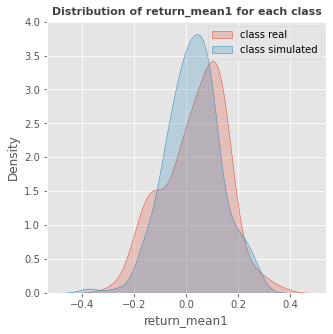

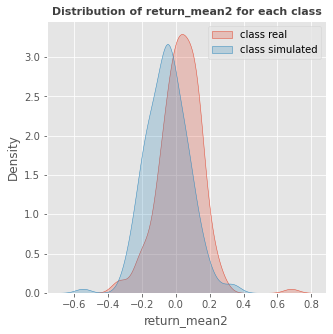

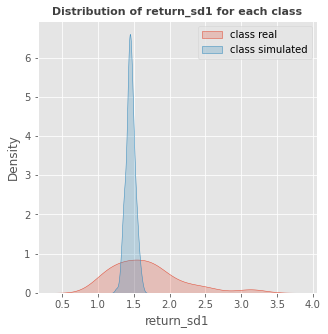

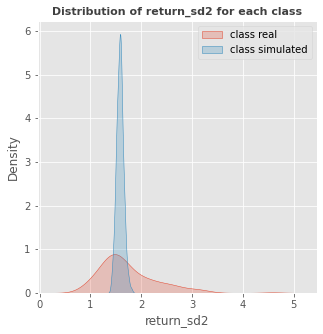

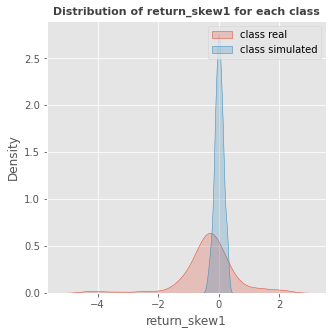

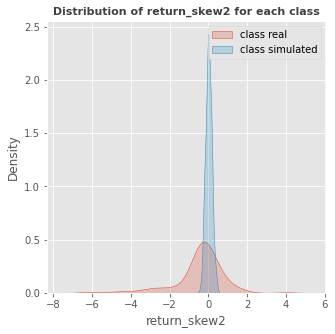

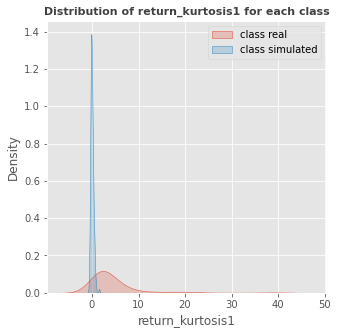

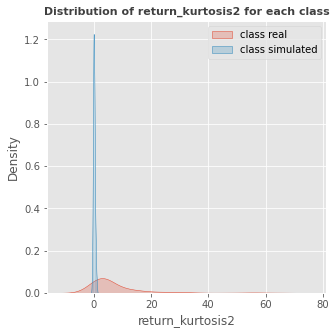

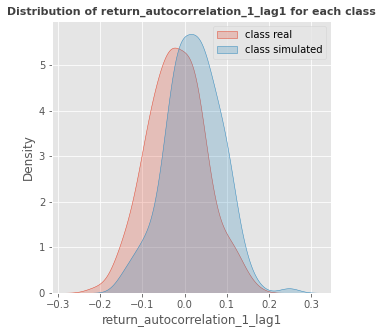

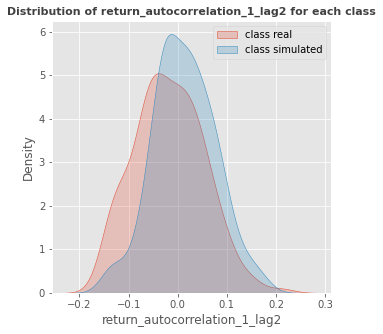

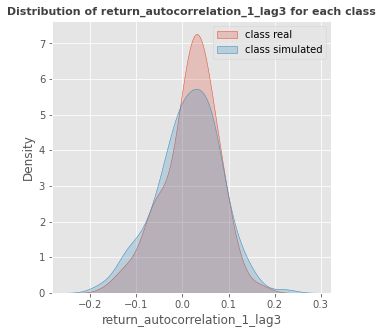

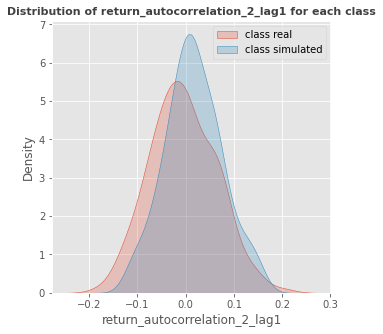

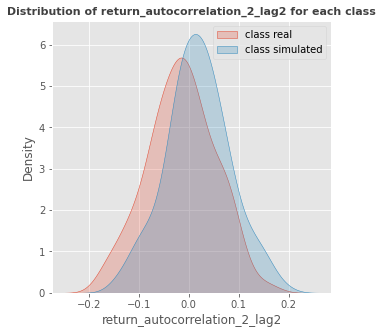

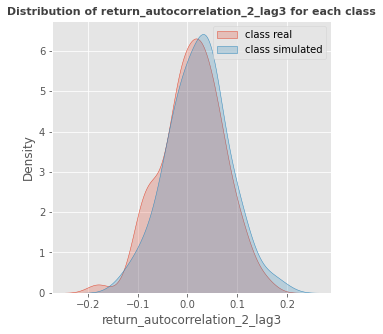

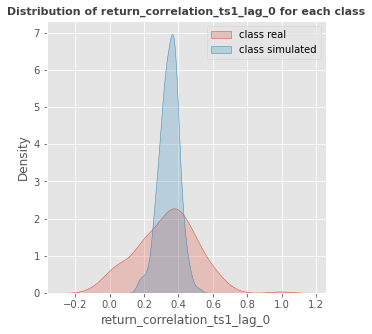

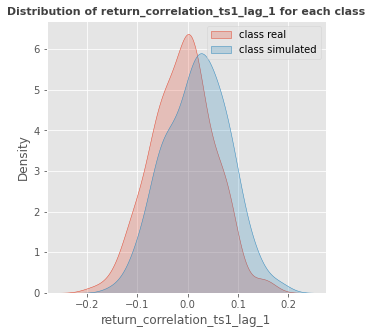

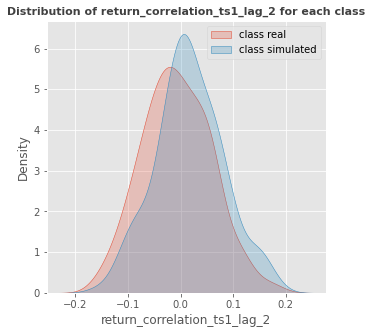

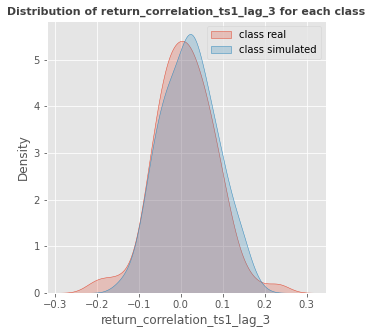

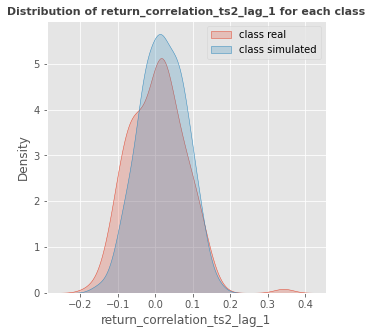

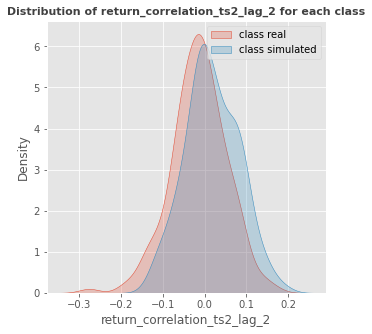

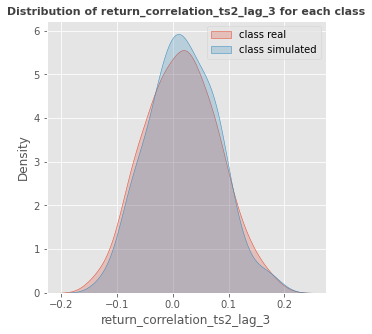

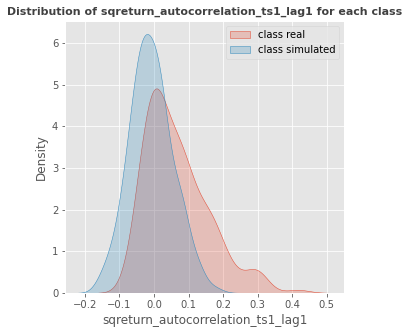

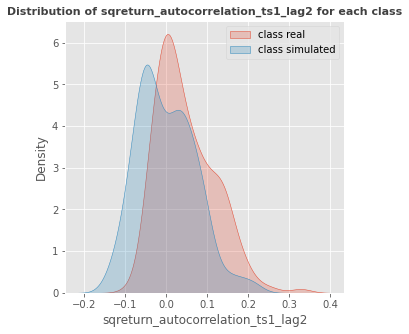

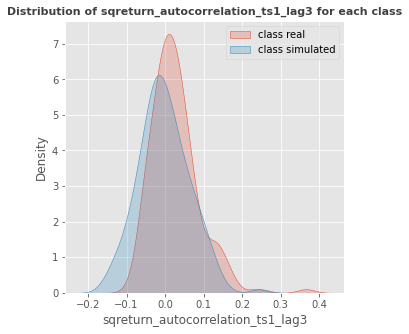

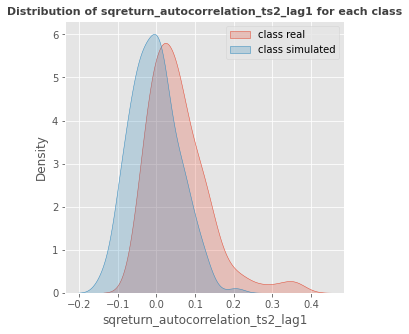

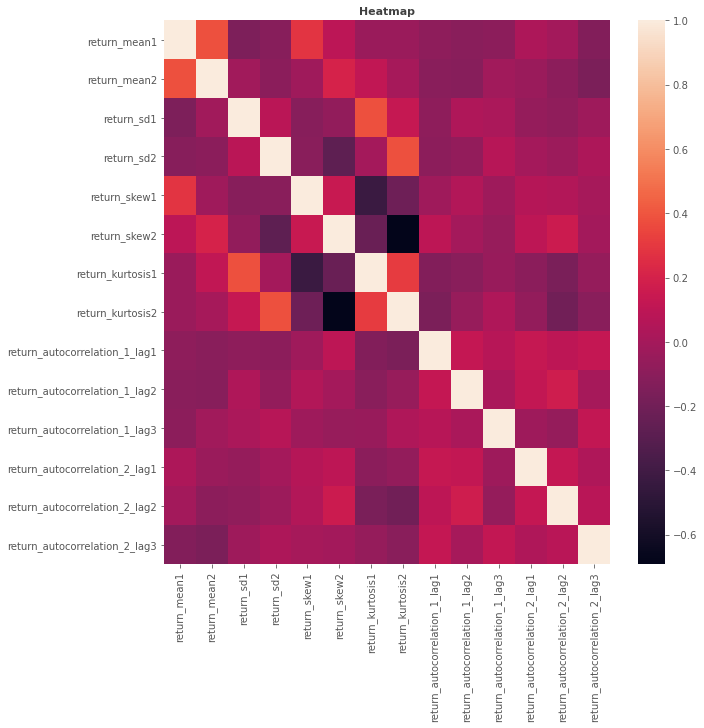

In [4]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_ou_log_prices = n_ou_simulation(
    random_seed=random_seed, num_sim=248,
    mu11=params[0], mu12=params[1], 
    mu21=params[2], mu22=params[3],
    sigma11=params[4], sigma12=params[5], 
    sigma21=params[6], sigma22=params[7],
    xinit_vec=xinit_vec, T0=0, T=1, length=250)
    
    n_sim_ou_pair_prices = log_price_to_price(n_log_price=n_sim_ou_log_prices)
    n_sim_ou_pair_returns = price_to_return(n_price=n_sim_ou_pair_prices)
    
    n_sim_ou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_prices.csv")
    n_sim_ou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_returns.csv")


    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_ou_pair_prices.csv")

    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)

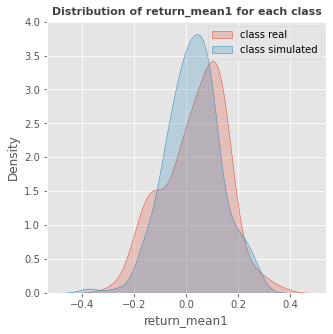

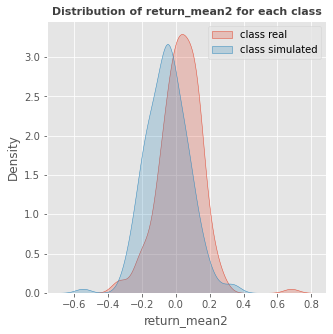

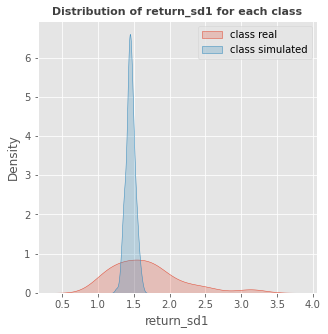

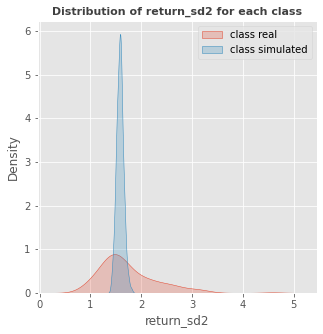

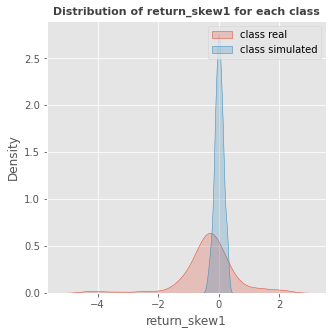

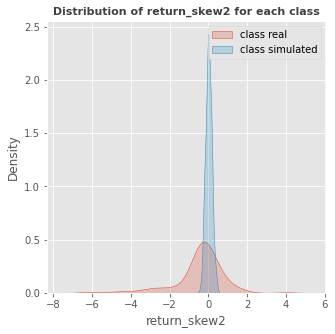

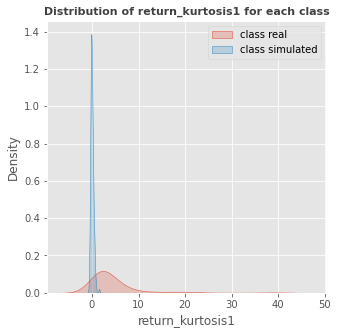

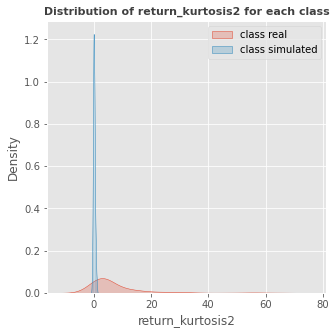

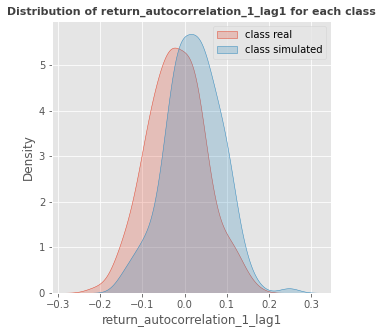

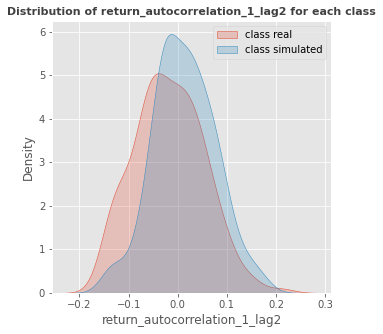

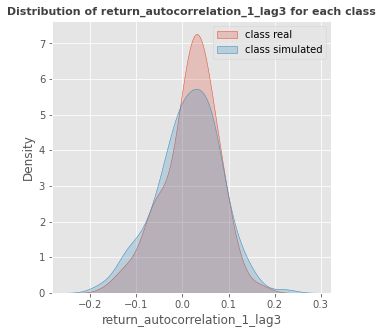

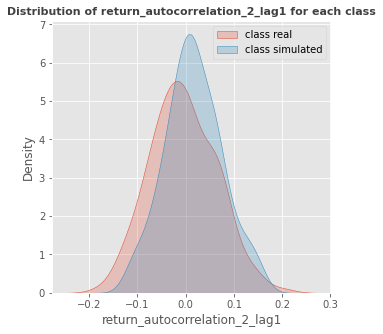

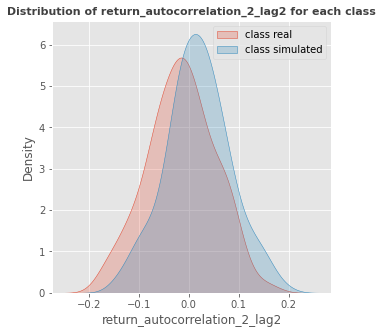

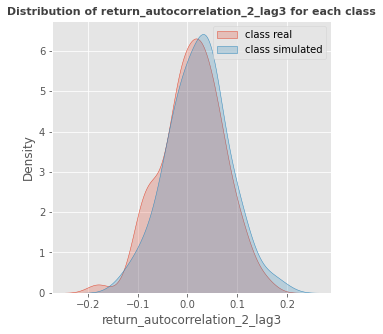

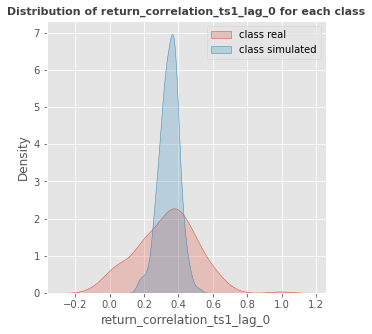

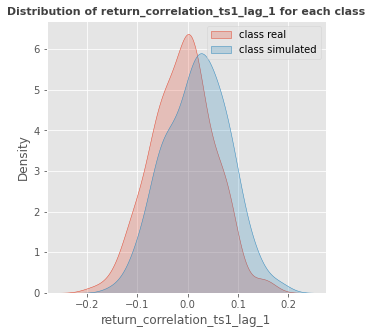

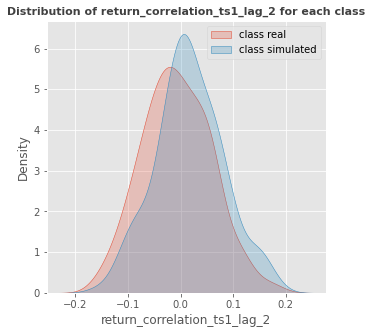

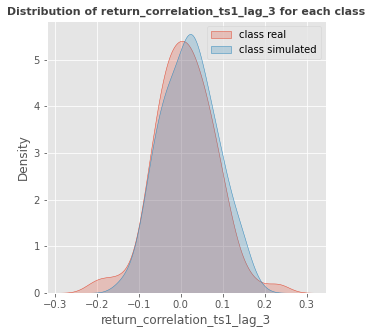

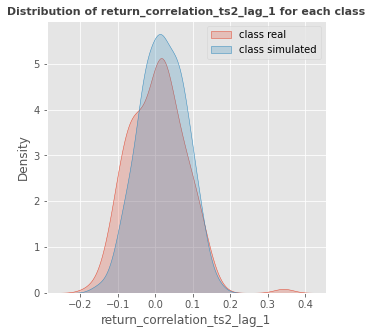

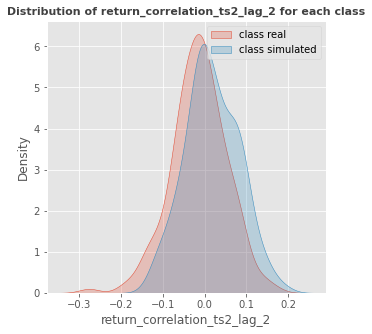

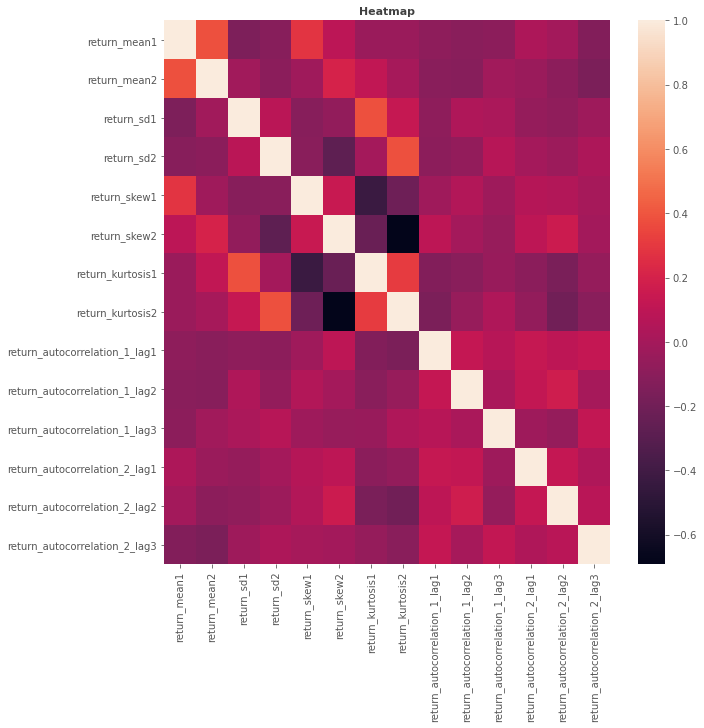

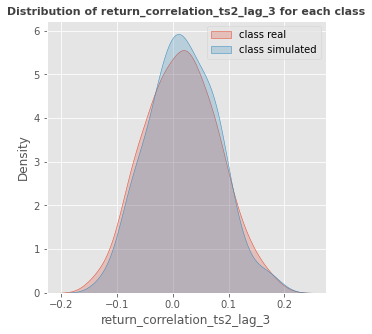

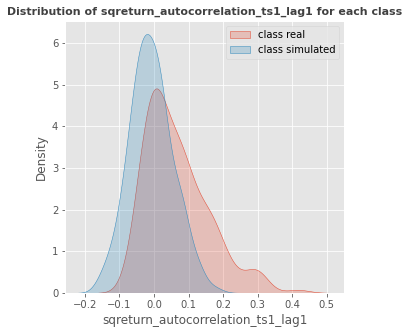

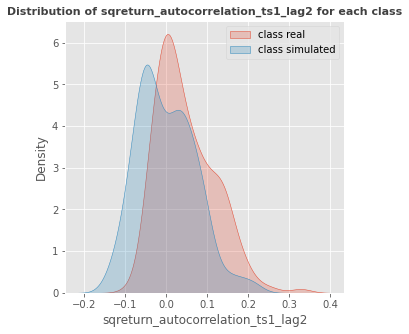

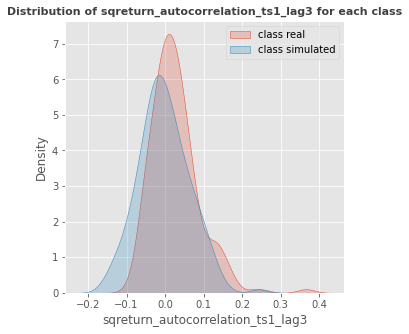

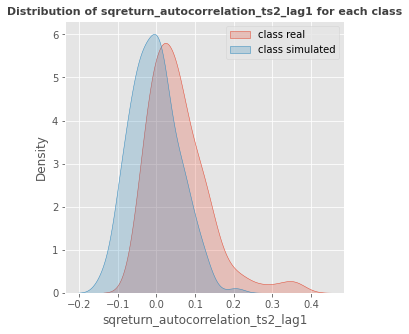

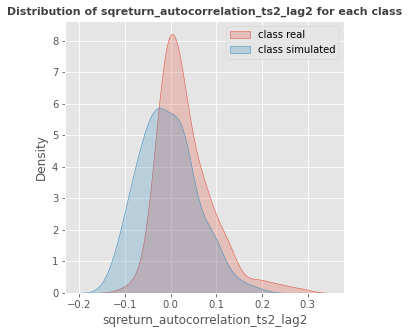

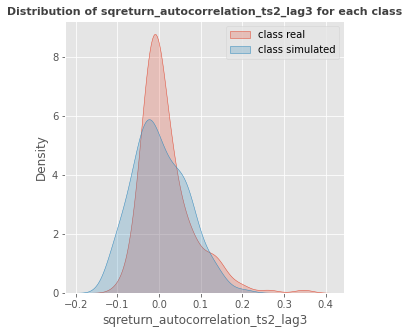

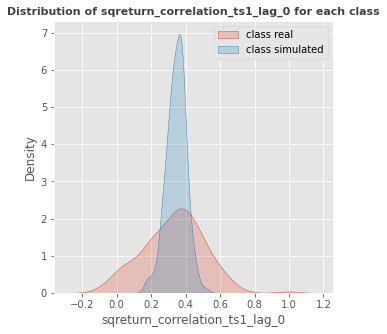

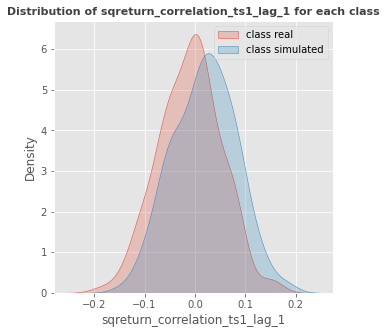

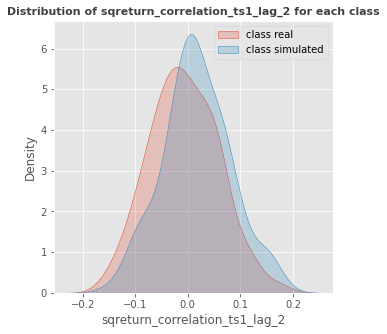

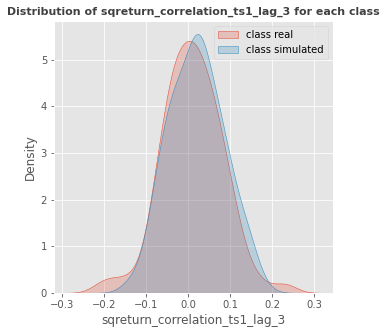

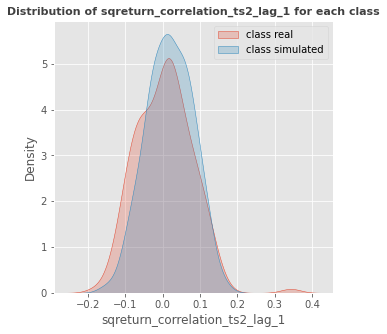

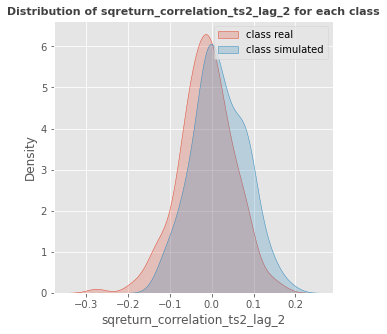

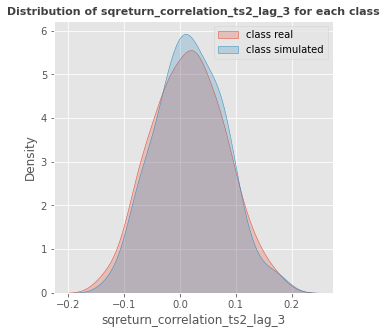

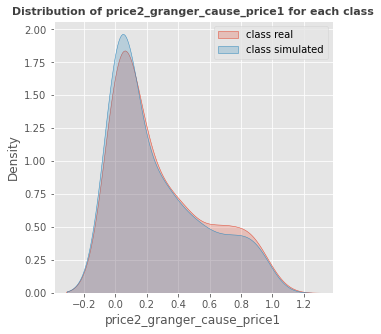

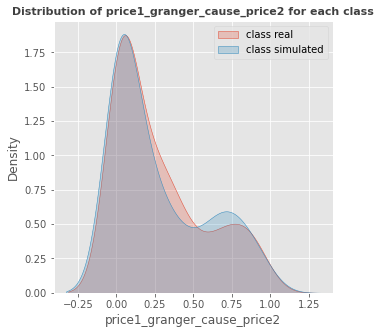

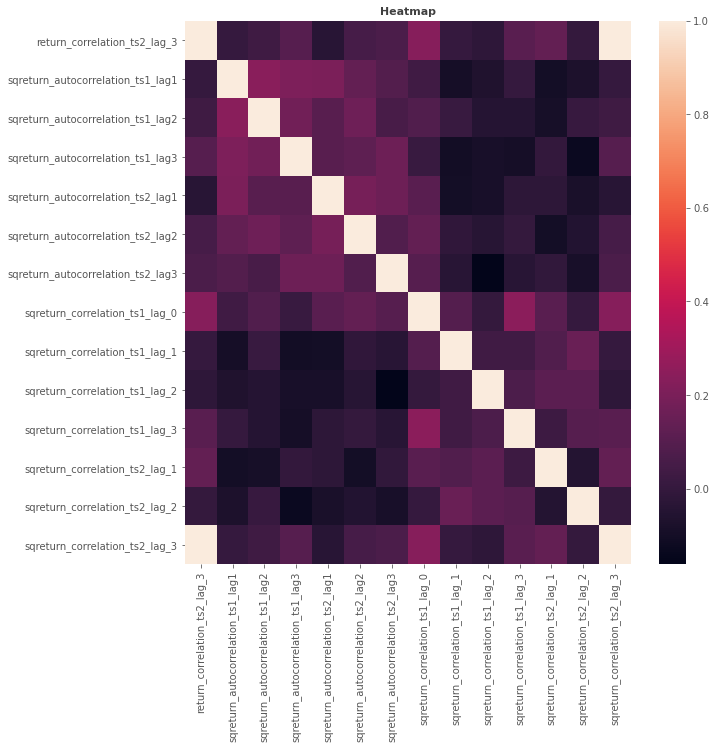

In [6]:
plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train.iloc[:, 0:20], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_ou")
EDA.extensive_eda(X_train.iloc[:, 20:36], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_ou")

In [7]:
print(results)
print(accuracy_average)
print(accuracy_std)

[0.4697986577181208, 0.9865771812080537, 0.9932885906040269, 0.9798657718120806, 0.9932885906040269]
0.8845637583892618
0.20744227110820404
